In [ ]:
pip install torch --ignore-installed TBB

In [1]:
import torch

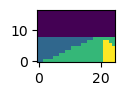

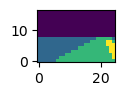

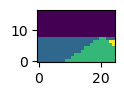

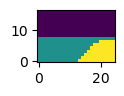

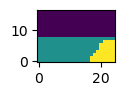

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class terreno:
    def __init__(self):
        da=10
        self.r=[]
        x=[10.25,9.56,9.68,10.89,12.46,14.03,17.78,19.35,18.75,16.45,12.82,10.4,5.69,1.81,-1.09,-6.05,-12.22,-14.64,-16.45,-18.87,-19.6,-19.23,-18.15,-14.4,-10.52,-7.26,-4.84,-2.06,-0.48,0.12,-0.73,-2.66,-5.69,-9.31,-11.61,-16.94,-18.87,-19.84,-19.72,-18.75,-16.57,-12.82,-9.07,-6.29,-2.78,0.12,2.42,5.08,8.47,10.65,12.82,16.21,19.48,20.69,22.02,22.86,22.98,21.05,19.72,17.66,15.6,14.27,12.7,11.01]
        y=[-1.0,5.1,9.81,13.54,15.49,15.97,17.6,20.68,25.23,28.31,27.82,27.66,27.18,27.01,27.01,27.18,27.5,27.18,26.85,25.06,21.49,17.76,13.54,11.75,11.59,12.73,14.84,13.54,10.13,6.56,2.66,-0.1,-0.58,-0.1,1.36,1.53,-0.1,-2.86,-6.92,-10.65,-11.95,-13.41,-14.55,-14.87,-14.06,-13.9,-13.9,-13.9,-16.98,-20.39,-21.85,-22.18,-21.04,-18.93,-15.03,-10.65,-7.4,-4.81,-3.18,-2.69,-3.34,-5.13,-4.32,-3.99]
        for xi, yi in zip(x,y):
            self.r.append(np.array([xi,yi]))
        self.a=2 #Ancho de la via a cada lado del eje

    def tipo(self, ri): #Verifica si es terreno o camino
        dist=[np.linalg.norm(ri-r) for r in self.r]
        ind1=np.argmin(dist)
        if(dist[ind1]>self.a*2):
            return 1
        ind2=ind1+1 if ind1+1<len(self.r) else 0
        ind0=ind1-1 if ind1>0 else len(self.r)-1
        return max([self.incluye(ri,ind0), self.incluye(ri,ind1), self.incluye(ri,ind2)])
    def incluye(self, r, ind):
        th=6
        C1=self.r[ind]
        if(ind+1<len(self.r)):
            C2=self.r[ind+1]
        else:
            C2=self.r[0]
        gamma=C2-C1
        dist=np.linalg.norm(gamma)
        gamma=gamma/dist
        a=np.dot(r-C1,gamma)
        if(a<0 or a>dist):
            if(np.linalg.norm(r-C1)<self.a/th or np.linalg.norm(r-C2)<self.a/th):
                return 3
            if(np.linalg.norm(r-C1)<self.a or np.linalg.norm(r-C2)<self.a):
                return 2
            return 1
        dp=np.linalg.norm(r-C1-a*gamma)
        if(dp<=self.a/th):
            return 3
        if(dp<=self.a):
            return 2
        return 1
    def dibujar(self):
        x=[ri[0] for ri in self.r]
        y=[ri[1] for ri in self.r]
        plt.plot(x,y,'o-k')
    #Función que mapea la posición y ubicación del carro en el terreno a la proyección que se visualizaría.
    def visor(self, robs=np.array([0,0]), mu=np.array([1,0]), D=2, H=2, W=3, dL=0.2, h=1):
        x,y=robs
        xp, yp=np.meshgrid(np.arange(-W,W+dL, dL), np.arange(-H,H+dL, dL))
        z=np.zeros_like(xp)
        Xs=np.zeros_like(xp)
        Ys=np.zeros_like(xp)
        for i in range(len(xp)):
            for j in range(len(xp[0])):
                if(yp[i,j]>=0):
                    z[i,j]=0
                else:
                    alfa=-h/yp[i,j]
                    xs=x+alfa*D*mu[0]+alfa*xp[i,j]*mu[1]
                    Xs[i,j]=xs
                    ys=y+alfa*D*mu[1]-alfa*xp[i,j]*mu[0]
                    Ys[i,j]=ys
                    z[i,j]=self.tipo(np.array([xs,ys]))
        return xp, yp, z, Xs, Ys

#Simulación del movimiento del carro.
class carro:
    def __init__(self, dt=0.2, r=np.array([0,0]), fi=np.pi/2, theta=0, L=2, W=2, pista=None):
        self.dt=dt
        self.r=r #Posición del carro
        self.fi=fi #Dirección del movimiento del carro
        self.mu=np.array([np.cos(self.fi), np.sin(self.fi)])
        self.theta=theta #Ángulo de la dirección del carro.
        self.L=L #Longitud del carro hasta la dirección
        self.W=W #Velocidad del carro en m/s
        self.pista=pista
        self.dtheta=2*np.pi/180
        self.reset()
    def reset(self):
        i=np.random.randint(low=0, high=len(self.pista.r))
        self.r=self.pista.r[i].copy()
        self.fi=np.random.uniform(0, np.pi*2)
        self.theta=0
        _, _, nueva_imagen, _, _=self.pista.visor(robs=self.r, mu=self.mu, D=2, H=2, W=3, dL=0.25, h=1)
        return nueva_imagen
    def cambio_theta(self, dtheta):
        self.theta=np.min([np.pi/2, np.max([-np.pi/2, self.theta+dtheta])])
    def step(self, acc): #acc:0 +dtheta, acc:1 0, acc:2, -dtheta
        if(acc==0):
          self.cambio_theta(self.dtheta/2)
        if(acc==1):
          self.cambio_theta(self.dtheta)
        if(acc==3):
          self.cambio_theta(-self.dtheta)
        if(acc==4):
          self.cambio_theta(-self.dtheta/2)
        
        if(self.theta==0):
            self.r=self.r+self.W*self.mu*self.dt
        else:
            v=np.array([np.sin(self.fi), -np.cos(self.fi)])
            self.r=self.r+self.mu*self.L/np.sin(self.theta)*np.sin(self.W*self.dt*np.sin(self.theta)/self.L)+v*self.L/np.sin(self.theta)*(1-np.cos(self.W*self.dt*np.sin(self.theta)/self.L))
            self.fi=self.fi+self.dt*self.W*np.sin(self.theta)/self.L
            self.mu=np.array([np.cos(self.fi), np.sin(self.fi)])
        _, _, nueva_imagen, _, _=self.pista.visor(robs=self.r, mu=self.mu, D=2, H=2, W=3, dL=0.25, h=1)
        zona=self.pista.tipo(self.r)
        if(zona==1): #Manga
          return nueva_imagen, -1000, True
        if(zona==2): #Parte gris de la carretera
          return nueva_imagen, 5, False
        #Si no fue nada, dejamos la linea amarilla
        return nueva_imagen, 50, False

pista=terreno()
C=carro(pista=pista)
for i in range(5):
  img, rwd, done=C.step(1)
  plt.figure(figsize=(1,2))
  plt.imshow(img, origin='lower')

In [3]:
from collections import namedtuple, deque
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
  def __init__(self, action_size, buffer_size, batch_size, seed): #action_size (int): dimension of each action, buffer_size (int): maximum size of buffer, batch_size (int): size of each training batch, seed (int): random seed
    self.action_size = action_size
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size
    self.experiences = namedtuple("Experience", field_names=["state","action","reward","next_state","done"])

  def add(self,state, action, reward, next_state,done):
    e = self.experiences(state,action,reward,next_state,done)
    self.memory.append(e)

  def sample(self):
    experiences = random.sample(self.memory, k=self.batch_size)
    states = [e.state for e in experiences if e is not None]              #torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(device)
    next_states = [e.next_state for e in experiences if e is not None]                                                         #torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
    return (states,actions,rewards,next_states,dones)

  def __len__(self):
    return len(self.memory)

In [4]:
from torch import nn as nn
import torch
#Con Kernels de 3x3
input = torch.randn(2000, 1, 17, 25)            #1 número de imagenes, batch 1 imagenes.
                                              #1 número de capas de la imagen.
                                              #17, 25 es la dimension de la imagen.
qnetwork_local=torch.nn.Sequential(
  nn.Conv2d(1, 16, 5, stride=1, padding=0),
  nn.MaxPool2d(2, stride=2, padding=0),
  nn.Conv2d(16, 32, 5, stride=1, padding=0),
  nn.MaxPool2d((2,5), stride=2, padding=0),
  nn.Flatten(1),
  nn.Linear(32,16),
  nn.ReLU(),
  nn.Linear(16,5),
  nn.ReLU()
)
qnetwork_target=torch.nn.Sequential(
  nn.Conv2d(1, 16, 5, stride=1, padding=0),
  nn.MaxPool2d(2, stride=2, padding=0),
  nn.Conv2d(16, 32, 5, stride=1, padding=0),
  nn.MaxPool2d((2,5), stride=2, padding=0),
  nn.Flatten(1),
  nn.Linear(32,16),
  nn.ReLU(),
  nn.Linear(16,5),
  nn.ReLU()
)

output=qnetwork_local(input)
print(input.shape, output.shape)

torch.Size([2000, 1, 17, 25]) torch.Size([2000, 5])


In [5]:
#Construcción del agente que soluciona el modelo
BUFFER_SIZE = int(1e5)  #replay buffer size
BATCH_SIZE = 2000         # minibatch size
GAMMA = 0.85            # discount factor
TAU = 1e-2              # for soft update of target parameters
LR = 0.001              # learning rate
UPDATE_EVERY = 72        # how often to update the network. Not done on every movement.

action_size=5

optimizer = optim.Adam(qnetwork_local.parameters(),lr=LR)
memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE, seed=0)
criterion = torch.nn.HuberLoss(reduction='mean',delta=100.0)

In [6]:
import random

#Método principal del programa
def dqn(n_episodes= 200, max_t = 200, eps_start=1.0, eps_end = 0.05, eps_decay=0.996):
  scores2=[]
  eps_decay=np.power(eps_end/eps_start, 1/n_episodes)
  t_step = 0 #Contador de tiempo para poder hacer el entrenamiento cada UPDATE_EVERY iteraciones.
  env = C
  scores = [0] # lista que contiene las recompensas de cada movimiento.
  eps = eps_start
  for i_episode in range(1, n_episodes+1):
    state = torch.unsqueeze(torch.unsqueeze(torch.tensor(env.reset()),0),0).float().to(device)
 #Al comienzo del episodio se resetea el ambiente.
    score = 0
    x=[]
    for t in range(max_t):
      #A partir del estado actual, se elige una nueva acción.
      if random.random() > eps: #Acción óptima
        state2 = state
        qnetwork_local(state2) #La red no va a entrenar, sino a evaluar.
        with torch.no_grad():
          action_values = qnetwork_local(state2) #Los valores de Q(state), que arroja los valores de Q para cada una de las acciones.
        qnetwork_local.train() #La red dejó de evaluar. Ahora puede ser entrenada de nuevo.
        print("El vector de salidas de la red es: ", action_values)
        action = np.argmax(action_values.cpu().data.numpy())
        print("Action NN: ", action)        
      else:                     #Acción aleatoria.
        action = random.choice(np.arange(action_size))

      #Se aplica la acción al environment para obtener su recompensa, nuevo estado y fin o no del episodio.
      next_state,reward,done = env.step(action)
      next_state= torch.unsqueeze(torch.unsqueeze(torch.tensor(next_state),0),0).float().to(device)
      ''' hasta acá la primer parte del flujo donde llega la flecha verde '''
      
      #Ahora procesaremos el buffer de memoria, agregando el resultado actual y procediendo a entrenar si es el caso.
      #agent.step(state,action,reward,next_state,done)

      memory.add(state, action, reward, next_state, done) #Adiciona a la memoria los datos obtenidos en el paso de movimiento.

      t_step = (t_step+1)% UPDATE_EVERY             #Calcula cada cierto tiempo que se debe recalcular los pesos de la red neuronal.
      if(t_step == 0): #Se debe hacer un proceso de entrenamiento de la red neuronal local
        if(len(memory)>BATCH_SIZE):
          
          states, actions, rewards, next_states, dones = memory.sample() #Se extren algunas muestras de la experiencia previa. Pero aleatorias.
          qnetwork_local.train() #La red local se va a entrenar.
          qnetwork_target.eval() #Esta red no se va a modificar, solamente a evaluar lo que produce a la salida.
          # states2=torch.unsqueeze(torch.tensor(np.array(states)),1).float().to(device)

          state2=torch.cat([st for st in states],dim=0).to(device)
          # next_states2=torch.unsqueeze(torch.tensor(np.array(next_states)),1).float().to(device)
          next_state2=torch.cat([st for st in next_states],dim=0).to(device)

          Qsa_estimado = qnetwork_local(state2).gather(1,actions) #Esto es lo que evalua la red neuronal local. Lo predicho de las acciones.
          #Valor de Q(state, action) de acuerdo con el conocimiento actual de la red.
          with torch.no_grad():
            QSnextMax = qnetwork_target(next_state2).detach().max(1)[0].unsqueeze(1) #Valores de max Q(NextState, a) with respect to a.
            #La red target se evalua en el estado siguiente, en Q(s',a). No en el estado actual y se recibe el valor máximo de recompensa en el estado siguiente
          Qnuevo_valor = rewards + (GAMMA* QSnextMax*(1-dones)) #Acá se actualizan los valores predichos de los estados que son terminales y de los que no son terminales. ****
          #Se hace la función de error,
          loss = criterion(Qnuevo_valor, Qsa_estimado).to(device)
          optimizer.zero_grad() #Reset del gradiente
          loss.backward() #Gradiente descendente
          optimizer.step() #Actualización de los parámetros.

          # ------------------- update target network ------------------- #
          #En este caso los parámetros cambian de manera suave en la red target respecto a la red local
          for target_param, local_param in zip(qnetwork_target.parameters(), qnetwork_local.parameters()):
            target_param.data.copy_(TAU*local_param.data + (1-TAU)*target_param.data)

      #Ahora realmente cambiamos al nuevo estado y terminamos el proceso.
      state = next_state
      score += reward
      x.append(state[0])
      if(done):
        break
    eps = max(eps*eps_decay,eps_end)## decrease the epsilon
    scores.append(score) ## sae the most recent score
    L=100
    if(i_episode%L==0):
      print('Episode {}\tAverage Score {:.2f}, eps {:.6f}'.format(i_episode,np.mean(scores[-L:]), eps))
      print(len(memory.memory))
      scores2.append(np.mean(scores[-L:]))

  return scores



In [7]:
scores= dqn(n_episodes= 7000)

El vector de salidas de la red es:  tensor([[0.0669, 0.0881, 0.0168, 0.0000, 0.0526]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0626, 0.0841, 0.0215, 0.0000, 0.0411]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0344, 0.0858, 0.0000, 0.0000, 0.0578]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0336, 0.0485, 0.0217, 0.0000, 0.0331]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.1032, 0.1009, 0.0122, 0.0000, 0.0637]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.1307, 0.0958, 0.0229, 0.0000, 0.0518]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.0751, 0.0736, 0.0051, 0.0000, 0.0484]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.0567, 0.0875, 0.0000, 0.0000, 0.0613]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0338, 0.0722, 0.0000, 0.0000, 0.0558]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0748, 0.0785, 0.0174, 0.0000, 0.0720]])
Acti

El vector de salidas de la red es:  tensor([[0.3529, 0.3937, 0.1190, 0.0539, 0.2478]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.3255, 0.3259, 0.0942, 0.0057, 0.2159]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.3651, 0.3882, 0.1033, 0.0384, 0.2425]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.5000, 0.5525, 0.1561, 0.1607, 0.3606]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.4769, 0.5246, 0.1529, 0.1454, 0.3488]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.5056, 0.5714, 0.1696, 0.1348, 0.3445]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.4924, 0.5548, 0.1626, 0.1523, 0.3470]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.6292, 0.7205, 0.2139, 0.2512, 0.4484]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.5253, 0.5750, 0.1934, 0.1713, 0.3670]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.5228, 0.5816, 0.1721, 0.1675, 0.3786]])
Acti

El vector de salidas de la red es:  tensor([[2.8336, 5.1984, 0.7350, 2.9329, 3.0888]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.4832, 4.4105, 0.6453, 2.3965, 2.6122]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.9601, 3.4240, 0.4727, 1.8269, 2.0883]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.8416, 3.1783, 0.4759, 1.6772, 1.9308]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.0428, 3.6303, 0.4953, 1.9412, 2.1710]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.7654, 3.0783, 0.4438, 1.6618, 1.8787]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.1349, 3.7722, 0.5689, 2.0365, 2.2508]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.0539, 3.6529, 0.5153, 1.9758, 2.1931]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.0809, 5.7080, 0.8046, 3.2295, 3.3401]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.3612, 4.2834, 0.5916, 2.3218, 2.5217]])
Acti

El vector de salidas de la red es:  tensor([[ 7.0617, 11.2841,  3.3994,  6.6183,  6.5416]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 7.9036, 12.7149,  3.8135,  7.3854,  7.3144]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.2405, 9.9898, 2.9980, 5.8565, 5.7814]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.6966, 13.9906,  4.2238,  8.1557,  8.0065]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.7670, 14.2402,  4.1755,  8.4433,  8.2294]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 7.4666, 12.0476,  3.5856,  7.0657,  6.9384]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.6369, 13.4744,  4.3339,  7.9323,  7.8427]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.4499, 9.9761, 3.3236, 5.9594, 5.8138]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.3840, 16.2966,  5.4238,  9.8670,  9.4021]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.4760, 16

El vector de salidas de la red es:  tensor([[ 9.5418, 11.1439,  6.9083,  7.9229,  7.2988]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.2910, 10.8188,  6.7386,  7.7196,  7.0861]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.7808, 19.0323, 11.1864, 13.2756, 12.4262]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.8089, 20.1141, 12.0397, 14.2443, 13.1480]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.7225, 17.6963, 10.4459, 12.2841, 11.5690]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.4919, 17.3886, 10.2697, 12.0827, 11.3741]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.9746, 13.0048,  7.8605,  9.1376,  8.5115]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.8481, 18.6506, 11.7637, 13.4106, 12.4559]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.0130, 17.6903, 11.1275, 12.6611, 11.8141]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[9.7230, 9.5601, 9.1662, 9.5424, 7.7901]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.8523, 15.1730, 13.8041, 15.1145, 12.2202]])
Action NN:  1
El vector de salidas de la red es:  tensor([[9.5398, 9.4466, 8.9939, 9.4327, 7.7004]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.6619, 14.8266, 13.7227, 14.7163, 11.9288]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.9212, 14.9581, 14.2077, 15.5618, 12.3642]])
Action NN:  3
El vector de salidas de la red es:  tensor([[9.3788, 9.1698, 8.9855, 9.5160, 7.6503]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.6350, 13.7113, 12.9509, 14.1748, 11.3220]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.9417, 11.9351, 11.3246, 12.2712,  9.8767]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.3586, 14.3911, 13.5874, 15.0129, 11.9564]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.8285, 13.9213

El vector de salidas de la red es:  tensor([[ 9.2411,  8.9544,  9.2791, 10.8838,  8.4682]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.0534, 10.8505, 11.1235, 13.1340, 10.1880]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 8.9888,  8.7393,  9.0512, 10.3564,  8.1138]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.5992, 8.3075, 8.6882, 9.8740, 7.7259]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.0898, 10.5613, 11.2780, 12.8048,  9.9513]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.3605,  8.5601,  9.5069, 10.1564,  7.9632]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 8.9995,  8.5452,  9.1506, 10.4477,  8.1622]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.6221, 6.0234, 6.8381, 7.4600, 5.7813]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.8995,  9.6152,  9.9419, 11.6173,  9.0492]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.4660, 13

El vector de salidas de la red es:  tensor([[10.9286, 11.2901, 10.7169, 13.7473, 10.8865]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.2904, 14.5737, 14.1851, 18.3878, 14.3954]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.5849, 10.8191, 10.4231, 13.3704, 10.5788]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.5310, 13.7808, 13.3301, 16.8953, 13.3779]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.0554, 13.2235, 12.8838, 16.1924, 12.8015]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.5463, 12.7095, 12.3225, 15.4385, 12.2063]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.4251, 13.6134, 13.2512, 16.7373, 13.1335]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.4119, 14.6186, 14.2954, 18.2887, 14.2614]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.7516, 15.0763, 14.6050, 18.9028, 14.7446]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[14.3654, 15.2181, 13.5771, 17.0986, 13.9418]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.0831, 12.4776, 11.5957, 14.5410, 11.7494]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.0800, 8.1131, 7.7159, 8.9730, 7.3819]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.6573, 6.4055, 6.5061, 7.2231, 5.8952]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.0106, 12.3268, 11.5838, 14.1364, 11.5440]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.4569, 7.1123, 7.3071, 7.9437, 6.5357]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.4480, 12.9219, 11.9559, 14.8707, 12.0719]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.7255, 6.4710, 6.5521, 7.2139, 5.9087]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.5456, 16.3443, 14.6576, 18.5465, 15.1213]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.2673, 12.7785, 11.

El vector de salidas de la red es:  tensor([[16.0314, 16.2458, 14.7220, 17.3620, 14.5974]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.8901, 16.0933, 14.6207, 17.2540, 14.4820]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.4864, 16.1046, 14.1556, 17.1101, 14.4523]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.2232, 14.8335, 12.8925, 15.4855, 13.2276]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.5475, 14.0247, 12.2706, 14.5319, 12.4708]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.6313, 14.1091, 12.3306, 14.5623, 12.5063]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.9220, 14.3850, 12.5938, 14.8559, 12.7499]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.3032, 14.5971, 13.0509, 15.1986, 12.9826]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.1615, 15.3593, 13.8682, 16.1350, 13.7252]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[5.5473, 5.2404, 4.9228, 4.6160, 4.3490]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.6517, 16.2630, 13.8443, 16.6770, 14.4330]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.9903, 13.4943, 11.7082, 14.5690, 12.3209]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.5765, 5.2883, 5.0465, 5.0302, 4.5554]])
Action NN:  0
El vector de salidas de la red es:  tensor([[ 9.8962, 10.0067,  8.8340,  9.8289,  8.8616]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.8951, 11.4203,  9.5983, 11.6748, 10.1744]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.8083, 13.4439, 11.3901, 14.2413, 12.2352]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.8563, 5.6810, 5.3286, 5.6359, 5.0310]])
Action NN:  0
El vector de salidas de la red es:  tensor([[7.8573, 7.9139, 6.9877, 8.0409, 7.0465]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.5280, 5.3237, 4.902

El vector de salidas de la red es:  tensor([[17.6505, 18.5096, 15.9268, 19.1922, 16.7006]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.8423, 18.7783, 16.0318, 19.5625, 16.9904]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.7228, 17.5812, 15.0958, 17.9531, 15.7636]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.4118, 12.7819, 11.2757, 11.6918, 10.8876]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.8997, 14.3279, 12.8704, 13.7437, 12.4966]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.5042, 15.9707, 14.3565, 15.9911, 14.1861]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.9971, 21.2733, 18.1986, 22.5523, 19.4588]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.8942, 5.8305, 5.5429, 5.4902, 5.1040]])
Action NN:  0
El vector de salidas de la red es:  tensor([[13.7865, 14.4408, 12.5883, 14.8437, 13.0803]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.237

El vector de salidas de la red es:  tensor([[16.7093, 17.8417, 15.5588, 18.0388, 16.0869]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.8690, 16.8811, 14.8271, 16.8992, 15.1643]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.2699, 16.1214, 14.3430, 15.8702, 14.4758]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.7868, 14.4709, 12.9869, 13.7410, 12.7879]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.2410, 13.8124, 12.4872, 12.7617, 12.0694]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.4280, 14.0014, 12.6684, 12.8545, 12.1915]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.6904, 14.2198, 12.9406, 13.0214, 12.3680]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.5840, 14.0985, 12.8161, 12.8397, 12.2341]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.3939, 16.6930, 15.6762, 16.1908, 14.9759]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[19.2570, 19.7738, 18.6913, 20.1048, 18.3869]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.6005, 12.7592, 12.5304, 11.4643, 11.2613]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.3967, 14.7148, 14.3392, 14.1330, 13.4044]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.2685, 15.6310, 15.2341, 15.3829, 14.3273]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.4438, 16.8588, 16.2986, 17.0064, 15.6043]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.7865, 20.4701, 19.3868, 21.9715, 19.4514]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.1864, 5.0154, 5.4090, 4.3264, 4.4886]])
Action NN:  2
El vector de salidas de la red es:  tensor([[19.5800, 20.0667, 18.9987, 20.5292, 18.8231]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.9134, 20.8025, 19.1767, 21.5513, 19.5502]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.750

El vector de salidas de la red es:  tensor([[13.9431, 13.5461, 14.1215, 14.1871, 13.2024]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.5148, 4.9943, 5.8620, 4.2583, 4.6829]])
Action NN:  2
El vector de salidas de la red es:  tensor([[13.4378, 13.6037, 13.2123, 13.4469, 12.7763]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.5238, 18.0478, 18.5409, 19.0913, 17.6928]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.3113, 19.3690, 18.8322, 20.4485, 18.7984]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.5612, 18.6649, 18.2112, 19.2931, 17.9306]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.0652, 18.1746, 17.6560, 19.0845, 17.6524]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.2400, 18.3788, 17.8017, 19.3639, 17.8767]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.2358, 18.2894, 17.8625, 19.2734, 17.7879]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.471

El vector de salidas de la red es:  tensor([[22.1003, 21.8958, 21.1342, 25.3081, 22.5375]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.2868, 16.5434, 15.6861, 17.7132, 16.5441]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.0756, 15.2920, 14.6622, 16.0399, 15.2117]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.5924, 14.8341, 14.2199, 15.4313, 14.7057]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.6603, 13.7872, 13.3811, 14.1409, 13.6387]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.1955, 13.3220, 12.9775, 13.4477, 13.1296]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.7192, 12.8250, 12.5259, 12.9097, 12.6110]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.9876, 17.8840, 16.3631, 19.9033, 17.9540]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.5963, 16.2798, 15.0905, 17.9799, 16.3442]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6

El vector de salidas de la red es:  tensor([[20.3086, 21.4996, 19.0124, 24.8182, 22.2180]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.1084, 22.2567, 19.7258, 25.9500, 23.0979]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.2294, 20.5715, 17.9495, 23.6299, 21.0755]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.3441, 22.5747, 19.6979, 26.0353, 23.2892]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.4848, 23.4217, 20.8147, 27.3281, 24.3349]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.4204, 20.0344, 18.3360, 22.8253, 20.8135]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.1885, 17.4539, 16.5149, 19.8413, 18.2998]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.7464, 15.9169, 14.0621, 17.2934, 16.0830]])
Action NN:  3
Episode 700	Average Score -772.60, eps 0.741134
9272
El vector de salidas de la red es:  tensor([[16.6269, 17.5278, 15.6328, 19.9084, 17.8502]])
Action 

El vector de salidas de la red es:  tensor([[27.9867, 27.6394, 26.3973, 32.5538, 28.7928]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.3291,  9.8963, 10.3259,  9.9790, 10.0653]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.3670, 2.9381, 3.8514, 2.1027, 3.0806]])
Action NN:  2
El vector de salidas de la red es:  tensor([[6.6867, 7.2164, 6.8684, 5.2450, 6.5719]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.0000, 0.6133, 0.0000, 0.0000]])
Action NN:  2
El vector de salidas de la red es:  tensor([[24.9918, 25.2489, 23.3722, 29.0889, 26.0496]])
Action NN:  3
El vector de salidas de la red es:  tensor([[23.3945, 23.5855, 22.0190, 28.5218, 24.5304]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.7760, 19.7871, 18.6186, 23.3448, 20.4304]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.5980, 11.6590, 11.3401, 12.4524, 11.6879]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.6917, 2.0367, 

El vector de salidas de la red es:  tensor([[0.3752, 0.5180, 1.0667, 0.0000, 0.3026]])
Action NN:  2
El vector de salidas de la red es:  tensor([[21.3527, 20.3412, 21.1803, 23.7198, 21.2111]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.7424, 10.0582, 11.0174, 10.1659, 10.1088]])
Action NN:  2
El vector de salidas de la red es:  tensor([[3.0515, 2.5598, 3.7607, 1.2891, 2.5313]])
Action NN:  2
El vector de salidas de la red es:  tensor([[13.9343, 13.9076, 13.7218, 15.5874, 14.0933]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.3271, 17.9144, 17.9159, 20.4536, 18.3459]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.4917, 17.0540, 17.0485, 19.1968, 17.3126]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.3857, 27.1045, 26.4264, 30.6359, 27.5708]])
Action NN:  3


El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.6740, 29.9842, 28.4520, 33.1032, 29.5361]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.1922, 19.4263, 19.8490, 21.7879, 19.6724]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.5894, 4.9078, 6.2608, 3.5741, 4.6410]])
Action NN:  2
El vector de salidas de la red es:  tensor([[13.7171, 13.8712, 13.7536, 13.4659, 13.0504]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.8105, 10.9360, 11.0308,  9.6643, 10.0080]])
Action NN:  2
El vector de salidas de la red es:  tensor([[1.8252, 2.5617, 2.7382, 0.0000, 1.2987]])
Action NN:  2
El vector de salidas de la red es:  tensor([[18.8825, 19.1089, 18.4147, 19.9340, 18.5081]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.8962, 21.2984, 20.3493, 22.6780, 20.7372]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.4439, 22.2589, 21.6752, 24.8245, 

El vector de salidas de la red es:  tensor([[25.8388, 25.8877, 24.9522, 27.9446, 25.1899]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.7835, 18.9954, 18.3400, 19.2588, 18.0724]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.1027, 11.8141, 11.1085, 10.0267, 10.4879]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.2702, 9.2711, 8.4683, 7.0368, 7.8553]])
Action NN:  1
El vector de salidas de la red es:  tensor([[36.3019, 35.2767, 34.7694, 38.8208, 35.0052]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.9274, 17.0134, 18.2666, 17.5728, 16.9703]])
Action NN:  2
El vector de salidas de la red es:  tensor([[30.4833, 29.9358, 29.0234, 31.8043, 29.4068]])
Action NN:  3
El vector de salidas de la red es:  tensor([[27.8672, 27.5439, 26.6749, 28.4835, 26.6989]])
Action NN:  3
El vector de salidas de la red es:  tensor([[25.9404, 25.7327, 25.0877, 26.2170, 24.7898]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.597

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.1288, 25.6153, 25.5907, 27.7722, 25.4405]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.8522, 23.0355, 22.4140, 22.0614, 21.9043]])
Action NN:  1
El vector de salidas de la red es:  tensor([[20.7133, 20.8566, 20.5854, 19.5277, 19.8240]])
Action NN:  1
El vector de salidas de la red es:  tensor([[20.6106, 20.7475, 20.5830, 19.6070, 19.8166]])
Action NN:  1
El vector de salidas de la red es:  tensor([[24.6363, 24.5699, 24.4285, 24.3602, 23.8427]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.1573, 26.9624, 26.7156, 27.3182, 26.3595]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.1435, 40.2649, 39.9280, 43.0121, 39.7592]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.7015, 33.3054, 34.0765, 35.5668, 33.1714]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.8873, 28.6258, 29.4753,

El vector de salidas de la red es:  tensor([[40.9781, 40.8299, 39.8757, 43.1244, 40.2578]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.5410, 31.7732, 30.8590, 33.0405, 30.8155]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.7982, 10.8467, 10.0557,  8.0709,  9.3101]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.1584, 8.6120, 7.4955, 5.4823, 6.9716]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.8153, 6.4431, 5.2529, 3.3034, 4.8521]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.4746, 7.6399, 7.1170, 3.8504, 6.1629]])
Action NN:  1
El vector de salidas de la red es:  tensor([[39.0781, 38.2609, 38.4812, 40.8451, 38.0639]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.1148, 8.3531, 8.5309, 6.3961, 7.6096]])
Action NN:  2
El vector de salidas de la red es:  tensor([[31.9230, 32.5808, 31.1459, 33.9313, 31.5279]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[13.3245, 14.4869, 13.5496, 12.2419, 13.0522]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.6047, 4.1984, 3.1682, 0.0262, 2.4456]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.8374, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.6812, 17.5964, 18.1545, 17.0270, 17.2344]])
Action NN:  2
El vector de salidas de la red es:  tensor([[3.5122, 4.6961, 4.0890, 0.9833, 3.1910]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.8498, 15.5058, 16.2070, 13.2576, 14.6524]])
Action NN:  2
El vector de salidas de la red es:  tensor([[12.3827, 12.2227, 12.9307,  9.6108, 11.3370]])
Action NN:  2
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.6292, 3.3799, 4.1274, 1.1958, 3.0940]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[5.4891, 5.5306, 5.9251, 2.7894, 4.9577]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.9198, 32.5228, 32.2856, 34.0291, 32.0440]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.1189, 18.0737, 17.9177, 17.0974, 17.2414]])
Action NN:  0
El vector de salidas de la red es:  tensor([[6.5522, 7.4877, 6.8502, 5.0726, 6.4311]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.1938, 41.2935, 39.4270, 41.6661, 40.0861]])
Action NN:  3
El vector de salidas de la red es:  tensor([[36.4690, 3

El vector de salidas de la red es:  tensor([[26.5470, 26.7782, 25.4832, 25.3671, 25.9913]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.1767, 22.7296, 21.3845, 20.9487, 21.9397]])
Action NN:  1
El vector de salidas de la red es:  tensor([[43.2979, 43.3993, 41.4099, 44.3618, 42.3330]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.3281, 37.7285, 35.9195, 38.7134, 36.7719]])
Action NN:  3
El vector de salidas de la red es:  tensor([[25.2627, 25.5391, 24.6932, 25.9984, 24.9253]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.2310, 4.7377, 3.5463, 2.1224, 3.6182]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.4006, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.2521, 34.2935, 34.0292, 34.4097, 33.7512]])
Action NN:  0
El vector de salidas de la red es:  tensor([[20.9561, 21.0363, 20.1610, 18.9542, 

El vector de salidas de la red es:  tensor([[29.6679, 29.4330, 28.2701, 29.1413, 28.9063]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.5630, 29.3597, 28.2575, 29.0567, 28.8748]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.8022, 22.4884, 20.9984, 22.2973, 21.7210]])
Action NN:  1
El vector de salidas de la red es:  tensor([[39.5605, 38.3893, 37.5666, 39.3662, 38.0294]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.4003, 31.6763, 30.0044, 31.6005, 30.7584]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.3501, 12.4403, 10.8345, 10.5329, 11.4145]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.4046, 3.3298, 1.2897, 0.0000, 1.8411]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.8137, 3.6966, 1.5882, 0.0000, 2.2245]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.9087, 0.1091, 0.0000, 0.3620]])
Action NN:  1
El vector de salidas de la red es:  tensor([[37.9589, 36.9917

El vector de salidas de la red es:  tensor([[41.7975, 41.1430, 39.3938, 42.2191, 40.3468]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.8894, 30.8638, 30.9392, 32.4640, 30.5797]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.0339, 30.0631, 30.0331, 31.8094, 29.8962]])
Action NN:  3
El vector de salidas de la red es:  tensor([[28.0767, 27.4219, 27.1702, 29.0130, 27.3988]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.8455, 18.1357, 18.2552, 18.7607, 18.1020]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.5724, 21.3274, 22.2041, 21.4477, 21.3906]])
Action NN:  0
El vector de salidas de la red es:  tensor([[7.9585, 8.0501, 7.9331, 6.2199, 7.6083]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.2965, 0.6412, 0.6897, 0.0000, 0.0907]])
Action NN:  2
El vector de salidas de la red es:  tensor([[20.6653, 19.2732, 20.2581, 20.0111, 19.5919]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.9272, 15

El vector de salidas de la red es:  tensor([[6.0023, 7.8984, 5.8121, 5.6968, 6.6025]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.2438, 6.2461, 4.0834, 3.8866, 4.9366]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.3602, 6.5410, 6.3869, 5.5077, 6.2403]])
Action NN:  1
El vector de salidas de la red es:  tensor([[31.8984, 31.9773, 30.5578, 33.4190, 31.2933]])
Action NN:  3
El vector de salidas de la red es:  tensor([[35.6428, 34.3096, 34.5956, 36.8706, 34.3848]])
Action NN:  3
El vector de salidas de la red es:  tensor([[30.6766, 29.4182, 29.6964, 31.2748, 29.3805]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.1900, 30.2102, 30.0974, 32.3018, 30.2105]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.1932, 20.2567, 19.8099, 20.0483, 19.9719]])
Action NN:  1
El vector de salidas de la red es:  tensor([[34.3688, 33.7332, 33.0639, 34.8834, 33.49

El vector de salidas de la red es:  tensor([[17.4231, 17.1874, 17.2722, 17.0184, 17.0624]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.8118, 50.4755, 50.8676, 53.6241, 50.2764]])
Action NN:  3
El vector de salidas de la red es:  tensor([[44.1231, 42.4323, 42.6754, 44.5400, 41.7783]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.6029, 35.8381, 36.4063, 38.3510, 35.7306]])
Action NN:  3
El vector de salidas de la red es:  tensor([[30.8995, 29.2591, 29.8245, 30.7914, 29.0791]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.5878, 34.8011, 35.5300, 36.9786, 34.5675]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.4450, 2.7873, 3.4478, 1.3181, 2.7685]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[41.5087, 40.2634, 39.4182, 41.6706, 39.3583]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.3449, 34.5559, 33.5096, 35.5702, 33.7346]])
Action NN:  3
El vector de salidas de la red es:  tensor([[27.0726, 27.3827, 25.9520, 27.9039, 26.3258]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.6261, 20.4349, 20.1681, 21.0513, 20.0003]])
Action NN:  3
El vector de salidas de la red es:  tensor([[26.3197, 23.7489, 25.8422, 25.2911, 24.4639]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.1711, 29.7520, 29.9592, 30.8112, 29.5507]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.7201, 38.4193, 38.8485, 39.7859, 38.1517]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.5587, 40.7121, 40.4122, 42.2463, 40.1116]])
Action NN:  0
El vector de salidas de la red es:  tensor([[24.3366, 24.2374, 23.7584,

El vector de salidas de la red es:  tensor([[0.2856, 0.0000, 0.5939, 0.0000, 0.0000]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.8887, 27.5764, 30.2611, 30.0629, 28.4785]])
Action NN:  0
El vector de salidas de la red es:  tensor([[20.9344, 20.6943, 20.6312, 20.6730, 20.0161]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.8856, 31.9472, 32.2340, 32.3714, 31.6777]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.5983, 16.0140, 17.5410, 16.4783, 16.2291]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1.9775, 1.1085, 2.3817, 0

El vector de salidas de la red es:  tensor([[47.1014, 44.3406, 44.5989, 46.4312, 44.3843]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.3457, 42.2328, 42.2075, 43.9007, 42.1384]])
Action NN:  0
El vector de salidas de la red es:  tensor([[11.8426, 12.5356, 11.8062, 11.7246, 11.9058]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.0606, 41.8208, 42.0622, 43.7297, 42.0790]])
Action NN:  0
El vector de salidas de la red es:  tensor([[24.1858, 23.5211, 23.5414, 23.5654, 23.3985]])
Action NN:  0
El vector de salidas de la red es:  tensor([[20.6403, 20.3300, 20.0942, 19.8460, 20.1018]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.6868, 37.0820, 37.3522, 38.7910, 37.3413]])
Action NN:  3
El vector de salidas de la red es:  tensor([[45.4859, 43.3094, 43.6286, 45.8908, 43.6413]])
Acti

El vector de salidas de la red es:  tensor([[48.0326, 45.5527, 46.1259, 47.6467, 46.0751]])
Action NN:  0
El vector de salidas de la red es:  tensor([[4.0546, 3.1720, 4.3176, 2.5845, 3.2324]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.4357, 21.2639, 22.3960, 22.2871, 21.7476]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.9762, 40.4639, 39.8111, 41.5840, 40.3339]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.4730, 2.1056, 0.2662, 0.0000, 0.3981]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.7447, 24.3752, 25.4749, 25.7049, 24.8114]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.6636, 30.1915, 31.0458, 32.1812, 30.5573]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.2844, 19.9299, 21.2949, 20.9019, 20.4004]])
Action NN:  2


El vector de salidas de la red es:  tensor([[44.4019, 43.4596, 42.1610, 44.0496, 43.1427]])
Action NN:  0
El vector de salidas de la red es:  tensor([[11.6543, 11.1328, 11.6649, 10.3092, 10.9234]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.3668, 39.4675, 38.6381, 40.0777, 39.4110]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.1505, 28.2747, 29.6268, 30.2737, 29.1715]])
Action NN:  3
El vector de salidas de la red es:  tensor([[24.2532, 22.9912, 23.9120, 24.2405, 23.6114]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.8297, 29.2511, 29.1122, 30.4398, 29.4986]])
Action NN:  3
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[10.7095, 10.3885, 10.6866, 10.1774, 10.4083]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.7476, 28.0520, 29.0851, 28.8455, 28.3372]])
Action NN:  0
El vector de salidas de la red es:  tensor([[8.0810, 7.9083, 8.0126, 7.1792, 7.6774]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.0761, 46.9189, 46.1916, 46.7085, 46.4930]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.5057, 28.0976, 29.6021, 28.4822, 28.6664]])
Action NN:  0
El vector de salidas de la red es:  tensor([[20.7061, 19.3941, 20.3805, 19.4348, 19.8304]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.9842, 15.1644, 15.8322, 14.6474, 15.2942]])
Action NN:  0
El vector de salidas de la red es:  tensor([[9.6173, 9.0738, 9.7149, 7.5502, 8.7980]])
Action NN:  2
El vector de salidas de la red es:  tensor([[15.9421, 15.3635, 15.5786, 15.0776, 

El vector de salidas de la red es:  tensor([[9.3237, 9.3315, 9.2317, 8.1333, 9.0726]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.3589, 32.5269, 33.5897, 33.3721, 32.8089]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.1571, 36.2388, 34.9095, 34.4997, 35.3673]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.8005, 32.2242, 31.0668, 30.4935, 31.4364]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.9257, 27.7693, 26.3775, 25.7011, 26.9413]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.0528, 31.5330, 30.3981, 29.8111, 30.7841]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.4238, 43.8643, 43.0181, 43.0079, 43.4240]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.3154, 50.3109, 49.1596, 49.6079, 49.5162]])
Action NN

El vector de salidas de la red es:  tensor([[48.0132, 46.5645, 45.9993, 45.7019, 45.4161]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.4377, 43.0862, 42.6028, 42.2636, 42.0665]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.4441, 16.7476, 14.9176, 15.3529, 15.8660]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.9586, 8.8332, 6.7000, 6.2381, 7.3868]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.3338, 5.2813, 3.0985, 2.7784, 3.6397]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.6597, 2.3047, 0.6457, 0.3846, 0.7793]])
Action NN:  1
El vector de salidas de la red es:  tensor([[48.5770, 46.5684, 45.8161, 45.6187, 45.8341]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.4041, 48.4555, 47.1955, 47.6045, 47.8195]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.9463, 47.9901, 46.8404, 47.2661, 47.4102]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.6932, 49.6955

El vector de salidas de la red es:  tensor([[20.5420, 20.8247, 20.2483, 20.0484, 20.3916]])
Action NN:  1
El vector de salidas de la red es:  tensor([[23.7792, 25.3336, 22.7726, 23.5970, 23.8927]])
Action NN:  1
El vector de salidas de la red es:  tensor([[19.2896, 21.0772, 18.6128, 19.3620, 19.7498]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.6673, 8.3627, 6.5443, 5.6985, 6.6501]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.9726, 4.7998, 4.2062, 2.6262, 3.4960]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[7.4676, 7.0521, 7.4465, 6.0583, 6.5278]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0.

El vector de salidas de la red es:  tensor([[54.3675, 51.5858, 51.3589, 50.9822, 50.7679]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.6517, 51.8636, 51.6312, 51.2013, 51.0269]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.2315, 47.5143, 46.9503, 46.8404, 46.7960]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.7825, 23.4919, 21.9999, 22.5122, 22.5276]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.9722, 8.3847, 9.0290, 7.7307, 8.1208]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 9.1435, 10.0249,  9.1484,  8.0345,  8.6779]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.0107, 44.1033, 43.2057, 44.4620, 43.0281]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.5378, 32.1834, 31.5888, 32.8089, 31.7444]])
Action NN:  3
El vector de salidas de la red es:  tensor([[24.4447, 24.4639, 23.8533, 24.4

El vector de salidas de la red es:  tensor([[38.3601, 35.7599, 37.7930, 37.2850, 36.3421]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.0030, 13.7904, 15.1454, 13.4830, 14.0702]])
Action NN:  2
El vector de salidas de la red es:  tensor([[44.2637, 41.8641, 41.8372, 41.1949, 41.3170]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.3157, 35.7078, 35.3340, 34.4223, 34.9660]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.4354, 32.2499, 32.0595, 31.0389, 31.5918]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.4027, 29.5167, 29.2952, 28.2402, 28.8852]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.6727, 28.7856, 28.5342, 27.5179, 28.1979]])
Action NN:  0
El vector de salidas de la red es:  tensor([[24.6111, 24.1436, 23.7980, 22.6207, 23.5731]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.0029, 32.7143, 32.9848, 32.3859, 32.5998]])
Action NN:  0
El vector de salidas de la red es:  tensor([[5

El vector de salidas de la red es:  tensor([[2.6343, 3.1105, 3.0306, 1.5864, 2.0546]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.0583, 30.3787, 31.4516, 31.4212, 30.4474]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.4005, 0.2800, 1.0795, 0.0000, 0.0000]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.5449, 34.0235, 35.9783, 35.6996, 34.5594]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.6051, 42.3369, 42.3476, 41.8489, 41.8074]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.6758, 34.3085, 34.0467, 33.3068, 33.7413]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.6919, 29.7929, 29.5879, 28.6799, 29.2639]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[42.0918, 40.0050, 40.3565, 40.5800, 40.0165]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.5163, 45.6197, 46.4419, 46.6914, 45.8290]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.5845, 46.6931, 47.6629, 47.7689, 46.9403]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.6341, 47.5171, 48.5653, 48.7609, 47.8969]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.9791, 47.7525, 48.8424, 49.1654, 48.2161]])
Action NN:  0
El vector de salidas de la red es:  tensor([[56.8895, 53.6365, 54.3691, 55.3465, 53.8019]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.5540, 34.2761, 35.0017, 34.1377, 34.3107]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.3889, 30.4693, 31.0519, 30.1550, 30.5523]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.2668, 31.3447, 31.8523, 30.9688, 31.3523]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.4680, 24.8729, 26.8168, 26.2641, 25.7412]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.7843, 28.7851, 31.6197, 30.4606, 30.2373]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.8876, 35.4555, 34.1022, 35.7721, 34.6938]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.5863, 19.5345, 18.8508, 19.2865, 18.9563]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.5246, 6.1917, 4.7852, 3.9534, 4.6837]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[12.0070, 11.1354, 12.6018, 10.7245, 11.2014]])
Action NN:  2
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[45.1345, 42.6736, 43.2157, 43.5055, 42.9455]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.5611, 36.1485, 36.0924, 36.2827, 36.2120]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.9724, 33.0011, 32.7191, 32.9475, 33.0099]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.2821, 37.0478, 36.7382, 37.0210, 36.8910]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.1441, 34.1858, 33.6269, 33.9896, 33.9650]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.2155, 32.8413, 31.8034, 32.4211, 32.3400]])
Action NN:  0
El vector de salidas de la red es:  tensor([[11.1086, 12.5865, 10.8591, 11.0934, 11.5018]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[59.0902, 55.8679, 56.5851, 57.5270, 56.1718]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.7808, 37.7550, 36.6280,

El vector de salidas de la red es:  tensor([[37.1064, 35.4845, 36.0035, 36.1909, 35.6679]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.2607, 39.2576, 39.8279, 40.1892, 39.4756]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.2317, 41.8783, 42.7160, 43.1186, 42.2032]])
Action NN:  0
El vector de salidas de la red es:  tensor([[46.3640, 43.9051, 44.5537, 45.4926, 44.3147]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.8292, 47.1661, 47.6503, 48.8176, 47.4702]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.3377, 46.5779, 47.1754, 48.2159, 46.8785]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.7985, 45.3839, 45.9162, 46.7398, 45.5543]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.5686, 50.7198, 51.3649, 52.7549, 50.9868]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.5076, 38.3260, 37.4709, 39.0475, 37.7244]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[29.7100, 28.0071, 29.7734, 29.6611, 28.8246]])
Action NN:  2
El vector de salidas de la red es:  tensor([[26.2333, 25.2224, 26.3554, 26.2102, 25.8535]])
Action NN:  2
El vector de salidas de la red es:  tensor([[21.1037, 20.1841, 21.1276, 20.6089, 20.5627]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.4399, 30.3552, 32.5228, 32.5459, 31.2234]])
Action NN:  3
El vector de salidas de la red es:  tensor([[43.5822, 41.4874, 41.7965, 42.2191, 41.2148]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.1379, 35.4762, 35.6350, 35.7123, 35.2523]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.0235, 37.9243, 38.3197, 38.5235, 37.8642]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.5118, 36.5433, 37.0809, 37.1597, 36.6153]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.8725, 49.5977, 51.0371,

El vector de salidas de la red es:  tensor([[46.7928, 45.0880, 45.1312, 45.9424, 44.6583]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.3660, 15.2064, 15.3878, 14.3361, 14.8168]])
Action NN:  2
El vector de salidas de la red es:  tensor([[15.7972, 16.1461, 15.7737, 14.9152, 15.5925]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.4761, 17.8885, 17.3907, 16.8404, 17.3797]])
Action NN:  1
El vector de salidas de la red es:  tensor([[19.3876, 19.7820, 19.3318, 18.9599, 19.3554]])
Action NN:  1
El vector de salidas de la red es:  tensor([[23.3834, 23.6707, 23.2219, 23.2784, 23.5001]])
Action NN:  1
El vector de salidas de la red es:  tensor([[45.6290, 44.2810, 44.4419, 45.5777, 44.1486]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.7238, 48.0542, 47.2959, 48.8471, 46.8707]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.1252, 37.5082, 36.4519, 38.1136, 36.4180]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[33.8774, 31.7726, 33.6237, 32.7322, 32.4646]])
Action NN:  0
El vector de salidas de la red es:  tensor([[12.0590, 12.1366, 11.7722, 10.7524, 11.4971]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.1391, 7.6129, 6.9556, 5.8853, 6.8161]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.1427, 3.9035, 3.2402, 2.2621, 3.0162]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.3639, 2.4779, 1.4332, 0.6362, 1.4581]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[55.2403, 53.2208, 54.7693, 55.2899, 52.7209]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.0649, 10.7059, 11.1652, 10.1525, 10.2621]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[46.9310, 45.9332, 45.9063, 47.1281, 45.9125]])
Action NN:  3
El vector de salidas de la red es:  tensor([[46.3106, 47.1576, 45.1229, 47.6691, 45.8291]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.7844, 23.4152, 21.7483, 23.5202, 22.6930]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.8551, 15.6180, 13.9079, 14.5406, 14.3243]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.2082, 4.4672, 2.2885, 2.0007, 2.5623]])
Action NN:  1
El vector de salidas de la red es:  tensor([[35.1679, 36.1735, 34.0273, 35.4423, 34.9682]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.3674, 24.4284, 21.8638, 22.8891, 23.1834]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.3912, 16.0032, 13.0971, 13.5378, 14.2250]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.2353, 4.1677, 0.9029, 1.0431, 1.9107]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 3.0

El vector de salidas de la red es:  tensor([[23.2862, 24.9983, 23.3054, 24.9906, 24.4424]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.2264, 18.0770, 16.3242, 17.1529, 17.0146]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.2229, 10.2508,  8.3163,  8.2258,  8.7446]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.1462, 7.4109, 5.1598, 5.1438, 5.7231]])
Action NN:  1
El vector de salidas de la red es:  tensor([[59.2878, 57.4869, 57.1831, 58.3647, 56.9518]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.6862, 36.2700, 33.8424, 35.8693, 35.1073]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.3568, 13.4371, 11.3819, 11.7229, 12.0111]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.4078, 30.0323, 31.6233, 31.4474, 30.9929]])
Action NN:  2
El vector de salidas de la red es:  tensor([[60.0204, 57.3287, 57.8968, 58.8

El vector de salidas de la red es:  tensor([[54.7687, 52.4434, 53.3471, 53.0360, 52.5952]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.3824, 33.6269, 34.0774, 32.9397, 33.5706]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.2930, 18.2712, 18.7538, 17.1295, 18.3153]])
Action NN:  2
El vector de salidas de la red es:  tensor([[14.8958, 14.6647, 15.2973, 13.2736, 14.5279]])
Action NN:  2
El vector de salidas de la red es:  tensor([[16.3531, 16.2389, 16.7845, 14.8910, 16.1958]])
Action NN:  2
El vector de salidas de la red es:  tensor([[21.6445, 21.7356, 22.1557, 20.9838, 22.0576]])
Action NN:  2
El vector de salidas de la red es:  tensor([[30.6702, 30.5366, 30.7958, 30.0716, 30.8446]])
Action NN:  4
El vector de salidas de la red es:  tensor([[32.7055, 32.5467, 32.6739, 32.2073, 32.8392]])
Action NN:  4
El vector de salidas de la red es:  tensor([[45.4863, 44.2295, 45.0676, 45.0204, 44.7592]])
Action NN:  0
El vector de salidas de la red es:  tensor([[5

El vector de salidas de la red es:  tensor([[63.5621, 61.2451, 62.3263, 62.7088, 61.2719]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.1629, 53.5463, 53.4695, 54.4512, 53.0415]])
Action NN:  3
El vector de salidas de la red es:  tensor([[24.5658, 24.7689, 25.2241, 25.0895, 25.0285]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.9571, 39.6158, 38.6246, 39.2345, 38.8501]])
Action NN:  1
El vector de salidas de la red es:  tensor([[36.2272, 36.7127, 36.4229, 36.8595, 36.2272]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.4936, 38.3794, 38.8388, 39.0453, 38.2317]])
Action NN:  3
El vector de salidas de la red es:  tensor([[27.0925, 26.7876, 27.5451, 27.3956, 27.1643]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0.6919, 1.6850, 1.4345, 0.4397, 0.6568]])
Action NN

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.1364, 29.4584, 31.7973, 31.0916, 30.4960]])
Action NN:  2
El vector de salidas de la red es:  tensor([[17.4871, 16.5772, 18.2106, 16.9711, 17.1813]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0.0000, 0.1319, 0.3420, 0.0000, 0.0000]])
Action NN:  2
El vector de salidas de la red es:  tensor([[34.0426, 32.9790, 34.5280, 34.7948, 33.7107]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.6561, 7.6435, 8.3295, 6.8341, 7.1110]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.1364, 35.6944, 38.4783, 36.6139, 36.7317]])
Action NN:  2
El vector de salidas de la red es:  tensor([[54.95

El vector de salidas de la red es:  tensor([[35.1868, 33.0915, 35.3004, 35.2274, 34.1516]])
Action NN:  2
El vector de salidas de la red es:  tensor([[26.0736, 24.4073, 26.4053, 25.7567, 25.3979]])
Action NN:  2
El vector de salidas de la red es:  tensor([[64.2522, 60.4488, 62.1873, 62.9115, 61.1647]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.1350, 55.1272, 56.0211, 56.5870, 55.4018]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.3894, 39.7888, 40.4630, 39.9538, 39.8307]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.7470, 21.2368, 21.8120, 20.4595, 21.5529]])
Action NN:  2
El vector de salidas de la red es:  tensor([[10.7017, 10.4700, 10.5826,  9.2708, 10.3067]])
Action NN:  0
El vector de salidas de la red es:  tensor([[10.1114, 10.0765,  9.9631,  8.5745,  9.8073]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.1374, 13.8632, 13.9607, 12.4565, 13.7281]])
Action NN:  0
El vector de salidas de la red es:  tensor([[2

El vector de salidas de la red es:  tensor([[ 7.6087, 10.1740,  7.0869,  7.6682,  8.3732]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.2790, 8.8133, 5.8055, 6.2338, 7.0413]])
Action NN:  1
El vector de salidas de la red es:  tensor([[21.9847, 20.9014, 21.9720, 21.6059, 21.4982]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1.0712, 2.4176, 1.5544, 0.9538, 1.1376]])
Action NN:  1
El vector de salidas de la red es:  tensor([[29.4424, 27.9258, 29.5057, 29.7931, 29.1489]])
Action NN:  3
El vector de salidas de la red es:  tensor([[25.3844, 23.9787, 25.1317, 25.1586, 24.8895]])
Action NN:  0
El vector de salidas de la red es:  tensor([[13.8432, 12.9388, 13.7184, 12.6710, 13.0299]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.7525, 0.8504, 1.2029, 0.6843, 0.6583]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El ve

El vector de salidas de la red es:  tensor([[29.8716, 27.7785, 29.3137, 29.6229, 28.9027]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.6157, 21.6020, 22.1990, 22.3385, 21.9653]])
Action NN:  0
El vector de salidas de la red es:  tensor([[12.4183, 11.9636, 12.2732, 11.0430, 11.6887]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.0000, 0.2468, 0.1088, 0.0000, 0.0618]])
Action NN:  1
El vector de salidas de la red es:  tensor([[54.5278, 52.3891, 52.2672, 53.8430, 52.2049]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.5931, 50.6834, 51.1083, 51.8955, 50.5068]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.1270, 42.5140, 43.1196, 43.2998, 42.5863]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.8245, 19.2443, 19.0175, 18.7117, 19.2464]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.4345, 17.5689, 16.8806, 16.4693, 17.2523]])
Action NN:  1
El vector de salidas de la red es:  tensor([[21.974

El vector de salidas de la red es:  tensor([[63.8608, 61.8596, 60.2030, 63.3118, 60.5746]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.6217, 38.6808, 38.7083, 40.7927, 38.5128]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.4260, 35.7430, 36.8117, 36.9070, 36.3390]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.4730, 25.8534, 25.8777, 26.6410, 25.7895]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.3930, 10.5551, 10.1998,  9.6651,  9.9705]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.3202, 48.7436, 47.3294, 49.0681, 47.8257]])
Action NN:  0
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[35.7967, 35.1933, 34.8473, 36.5852, 35.1049]])
Action NN:  3
El vector de salidas de la red es:  tensor([[52.2584, 52.1573, 49.7046, 52.5507, 50.3000]])
Action NN:  3
El vector de salidas de la red es:  tensor([[35.0691, 35.9059, 33.9008, 36.2411, 34.6614]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.7320, 20.9204, 19.2877, 20.3896, 20.0365]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.6856, 13.2247, 11.4376, 11.5484, 11.8108]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.8669, 4.8845, 2.9655, 2.6105, 3.0812]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.5895, 55.9256, 54.8587, 56.6866, 54.9314]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.6401, 2.7066, 0.8502, 0.8199, 0.9254]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0


El vector de salidas de la red es:  tensor([[30.4800, 32.4024, 29.4385, 31.9839, 30.9830]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.2627, 14.2136, 12.0348, 12.2820, 12.4460]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[56.9898, 54.8838, 54.3619, 55.2674, 53.9902]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.5654, 44.5051, 41.7378, 44.2415, 42.8392]])
Action NN:  1
El vector de salidas de la red es:  tensor([[27.9249, 29.8990, 27.0715, 29.0802, 28.5776]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.2781, 19.3365, 16.7671, 17.6670, 17.6822]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.1220, 12.3265,  9.6479,  9.7722, 10.2489]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.2350, 7.9173, 4.8501, 5.0644, 5.7528]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0281, 3.2477, 0.0000, 0.1296,

El vector de salidas de la red es:  tensor([[ 8.4410, 10.4196,  8.7524,  7.9377,  8.7240]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[8.8614, 8.9362, 9.2699, 7.8311, 8.5476]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.3778, 55.9315, 55.4902, 56.0105, 55.0854]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.0698, 48.2159, 49.7829, 49.0483, 48.5377]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.8206, 31.5545, 32.4055, 32.0168, 32.0477]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.5984, 14.8556, 14.2651, 13.2097, 14.3640]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.7451, 7.3485, 6.7624, 5.7999, 6.8233]])
Action NN:  1
El vector de salidas de l

El vector de salidas de la red es:  tensor([[58.2306, 56.7428, 56.8739, 57.3719, 56.4954]])
Action NN:  0
El vector de salidas de la red es:  tensor([[63.6629, 61.6349, 62.1347, 62.5947, 61.4218]])
Action NN:  0
El vector de salidas de la red es:  tensor([[63.0659, 61.3120, 61.6980, 62.2901, 61.0803]])
Action NN:  0
El vector de salidas de la red es:  tensor([[68.6821, 66.5577, 67.0558, 67.9866, 66.2282]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.8108, 47.0104, 45.3282, 47.4416, 45.8371]])
Action NN:  3
El vector de salidas de la red es:  tensor([[28.0154, 29.6812, 28.2753, 29.7531, 29.1613]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.1419, 11.1396,  9.5912,  8.8027,  9.4622]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.4621, 2.7765, 1.2349, 0.7383, 0.9083]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN

El vector de salidas de la red es:  tensor([[49.9190, 49.0009, 49.7456, 49.3992, 49.2246]])
Action NN:  0
El vector de salidas de la red es:  tensor([[62.1776, 60.3078, 61.4776, 61.7463, 60.6969]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.8145, 39.7595, 39.2783, 40.5156, 39.3811]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.7997, 15.1610, 14.5549, 13.5937, 14.1769]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.3087, 3.9900, 3.3678, 2.0732, 2.4946]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.6998, 32.3864, 33.3797, 33.3895, 32.7011]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.3524, 37.0191, 38.5684, 36.5797, 37.4219]])
Action NN:  2
El vector de salidas de la red es:  tensor([[25.7670, 25.3092, 26.3878, 24.5337, 25.7562]])
Action NN

El vector de salidas de la red es:  tensor([[27.6666, 27.3177, 28.4769, 27.5455, 27.6383]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.3969, 63.3692, 65.6551, 64.4712, 63.8505]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.9215, 46.2775, 48.0742, 45.9290, 46.4637]])
Action NN:  2
El vector de salidas de la red es:  tensor([[33.5625, 32.5730, 34.1784, 31.6889, 32.9612]])
Action NN:  2
El vector de salidas de la red es:  tensor([[22.2060, 21.9190, 23.1270, 20.3869, 22.1633]])
Action NN:  2
El vector de salidas de la red es:  tensor([[14.7435, 14.7303, 15.6970, 13.1490, 14.5714]])
Action NN:  2
El vector de salidas de la red es:  tensor([[10.5144, 10.9924, 11.2577,  9.2373, 10.5725]])
Action NN:  2
El vector de salidas de la red es:  tensor([[8.1624, 8.8895, 9.1651, 7.0157, 8.3344]])
Action NN:  2
El vector de salidas de la red es:  tensor([[7.8761, 8.6630, 8.8210, 6.7072,

El vector de salidas de la red es:  tensor([[40.3868, 38.0803, 41.1604, 38.1594, 39.1743]])
Action NN:  2
El vector de salidas de la red es:  tensor([[21.9034, 21.0010, 22.8872, 20.5929, 21.4023]])
Action NN:  2
El vector de salidas de la red es:  tensor([[30.8107, 30.7550, 31.7648, 30.1244, 31.1975]])
Action NN:  2
El vector de salidas de la red es:  tensor([[34.5018, 34.4662, 35.4498, 34.2046, 34.9748]])
Action NN:  2
El vector de salidas de la red es:  tensor([[41.8023, 41.1273, 42.5146, 41.5905, 41.8316]])
Action NN:  2
El vector de salidas de la red es:  tensor([[69.3366, 66.9211, 69.1884, 68.7465, 67.4898]])
Action NN:  0
El vector de salidas de la red es:  tensor([[63.2677, 61.4810, 63.0234, 62.9157, 61.8596]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.4840, 43.1868, 43.1781, 43.7210, 42.9465]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.3453, 7.5747, 6.2744, 5.1549, 5.7961]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0.

El vector de salidas de la red es:  tensor([[4.4684, 6.9149, 5.3006, 4.3666, 5.0495]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.1221, 4.0226, 1.8430, 1.1618, 1.9931]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.5926, 3.7519, 1.2057, 0.5811, 1.6042]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.4473, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.8209, 32.5418, 34.0985, 34.2542, 33.4962]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.3545, 32.1818, 33.9726, 33.8516, 33.3296]])
Action NN:  2
El vector de salidas de la red es:  tensor([[34.7311, 34.0537, 35.5088, 35.6104, 34.6327]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.4892, 20.8566, 21.4174, 20.8561, 21.0533]])
Action NN:  2
El vector 

El vector de salidas de la red es:  tensor([[34.7613, 32.5873, 34.4177, 33.7303, 33.8552]])
Action NN:  0
El vector de salidas de la red es:  tensor([[10.9941, 11.3957, 11.3965, 11.3474, 11.0982]])
Action NN:  2
El vector de salidas de la red es:  tensor([[5.4729, 6.1465, 6.1035, 5.2493, 5.8207]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.0251, 4.0073, 3.7849, 2.7542, 3.4966]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.1149, 4.2164, 3.8537, 2.7294, 3.6530]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.2034, 3.4802, 3.0121, 1.7396, 2.8144]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.2895, 19.5105, 18.9355, 18.7265, 18.7542]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.6434, 6.5178, 5.5769, 4.4200, 5.0001]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.5835, 36.4896, 37.9993, 38.6459, 37.3217]])
Acti

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[59.7489, 59.2453, 59.3414, 61.0581, 59.0644]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.2505, 37.2594, 37.2898, 39.0371, 37.7064]])
Action NN:  3
El vector de salidas de la red es:  tensor([[36.4814, 36.6594, 36.4327, 38.2723, 36.9353]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.2740, 25.7602, 25.6951, 26.3091, 25.8833]])
Action NN:  3
El vector de salidas de la red es:  tensor([[32.1326, 33.7362, 32.5188, 34.0301, 33.2239]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.2578, 23.7092, 22.8685, 23.6902, 23.3945]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.7598, 41.8589, 40.7842, 42.4033, 41.3115]])
Action NN:  3
El vector de sa

El vector de salidas de la red es:  tensor([[2.3545, 4.3806, 3.1890, 2.5552, 2.8419]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.9329, 23.5283, 22.1776, 23.2812, 22.9247]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.8810, 11.2774,  9.1247,  8.9032,  9.7140]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.6237, 9.2879, 6.9199, 6.6344, 7.5565]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9936, 6.0398, 3.1437, 3.1207, 4.0742]])
Action NN:  1
El vector de salidas de la red es:  tensor([[29.9581, 30.1399, 30.4573, 31.6746, 30.4221]])
Action NN:  3
El vector de salidas de la red es:  tensor([[25.5548, 26.3812, 26.0065, 27.3079, 26.4030]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[42.3657, 40.2530, 42.4434, 40.7101, 40.9332]])
Action NN:  2
El vector de salidas de la red es:  tensor([[15.9948, 16.2556, 16.4366, 16.1336, 15.9930]])
Action NN:  2
El vector de salidas de la red es:  tensor([[8.0234, 8.8132, 8.6360, 8.2062, 8.2364]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.4967, 39.3368, 40.8120, 42.0062, 40.1435]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.8831, 29.0787, 30.2050, 30.8446, 29.7369]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.3702, 33.4817, 34.9152, 35.4026, 34.2712]])
Action NN:  3
El vector de salidas de la red es:  tensor([[58.8110, 55.5346, 58.2979, 57.4313, 56.4230]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.5983, 38.3490, 40.4848, 39.4347, 39.2388]])
Action NN:  0
El vector de salidas de la red es:  tensor([[2.3940, 2.9417, 2.5869, 2.7212,

El vector de salidas de la red es:  tensor([[48.4224, 48.1338, 48.6297, 51.2227, 48.3618]])
Action NN:  3
El vector de salidas de la red es:  tensor([[35.0124, 35.3680, 35.4129, 37.2127, 35.4623]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.5385, 7.5069, 6.4031, 6.0247, 5.9917]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.1129, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.8376, 49.8960, 51.7131, 50.6741, 50.1281]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.7321, 26.6314, 27.1700, 25.5449, 26.6079]])
Action NN:  2
El vector de salidas de la red es:  tensor([[17.7659, 18.0955, 18.4774, 17.0327, 17.9195]])
Action NN:  2
El vector de salidas de la red es:  tensor([[13.9031, 14.4607, 14.5837, 13.7297, 14.1595]])
Action NN:  2
El vector de salidas de la red es:  tensor([[10.1117, 10.9482, 10.7483,  9.8804, 

El vector de salidas de la red es:  tensor([[37.9394, 35.9826, 37.9475, 36.0406, 36.5668]])
Action NN:  2
El vector de salidas de la red es:  tensor([[15.6611, 15.8217, 16.1961, 16.1031, 15.6950]])
Action NN:  2
El vector de salidas de la red es:  tensor([[8.5998, 9.1870, 9.2198, 8.8986, 8.8782]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[20.2304, 21.8839, 20.9637, 21.4052, 21.0717]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.1156, 14.6967, 13.7600, 13.2056, 13.3905]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.6853, 11.4308, 10.3750,  9.6087, 10.1035]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.9172, 7.6572, 6.7553, 5.8879, 6.3167]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.2562, 2.2712, 1.2066, 0.7580, 0.7691]])
Action NN:  1
El ve

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
Episode 1600	Average Score -813.10, eps 0.504222
21125
El vector de salidas de la red es:  tensor([[39.8483, 39.5478, 39.9451, 41.7310, 39.8185]])
Action NN:  3
El vector de salidas de la red es:  tensor([[66.1857, 64.7380, 66.0808, 67.1772, 64.6606]])
Action NN:  3
El vector de salidas de la red es:  tensor([[23.2897, 24.1426, 23.7653, 24.0413, 23.9245]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.4909, 14.7505, 14.0565, 13.2524, 13.9205]])
Action NN:  1
El vector de salidas de la red es:  tensor([[38.9510, 37.8200, 39.0297, 39.9382, 38.4473]])
Action NN:  3
El vector de salidas de la red es:  tensor([[30.0914, 29.4154, 30.4482, 30.5033, 29.8168]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[46.7331, 45.1755, 46.

El vector de salidas de la red es:  tensor([[69.0509, 66.1098, 67.8046, 68.2718, 66.7045]])
Action NN:  0
El vector de salidas de la red es:  tensor([[71.9925, 69.6869, 70.8101, 71.5471, 69.8706]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.3147, 52.8176, 52.1875, 53.1149, 52.0950]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.0442, 11.3751,  9.6723,  9.6277,  9.7043]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.8715, 6.4678, 4.7027, 4.5244, 4.6287]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.6924, 31.5275, 32.0097, 32.4350, 31.8354]])
Action NN:  3
El vector de salidas de la red es:  tensor([[57.9033, 57.0296, 56.7967, 57.3321, 56.6976]])
Action NN:  0
El vector de salidas de la red es:  tensor([[55.1514, 54.6258, 54.1902, 54.7514, 54.1891]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.6116, 46.3616, 45.2679, 45.8

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[81.8836, 78.9833, 80.3283, 80.7967, 79.0284]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.2634, 41.6602, 41.1456, 42.9605, 41.5104]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.1978, 9.0185, 7.5283, 7.9231, 7.7790]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.4177, 33.0687, 33.3061, 34.3668, 33.3105]])
Action NN:  3
El vector de salidas de la red es:  tensor([[75.9474, 72.5643, 74.7534, 74.2647, 73.0039]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.3678, 19.0456, 18.4905, 18.1540, 18.8353]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.1380, 13.1038, 12.4572, 12.0450, 12.7248]])
Action NN:  1
El vector de salidas

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.8256, 37.9109, 36.7433, 38.3114, 37.5605]])
Action NN:  3
El vector de salidas de la red es:  tensor([[43.9340, 44.0825, 43.8422, 45.7806, 44.3407]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.5100, 28.3845, 28.6780, 28.8056, 28.6183]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[12.5402, 13.7312, 12.8565, 12.8499, 13.2190]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.0827, 12.3505, 11.3760, 11.2862, 11.8478]])
Action NN:  1
El vector de salidas de la red es:  tensor([[34.2305, 36.4384, 34.1509, 36.1056, 35.6755]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.4667, 13.9737, 11.8943, 12.3274, 12.2855]])
Action NN:  1
El vector de sa

El vector de salidas de la red es:  tensor([[7.2589, 9.7853, 7.8849, 7.3877, 8.1778]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.5148, 7.0895, 5.2549, 4.6377, 5.4342]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.3851, 6.8656, 5.1011, 4.2634, 5.3292]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.4231, 6.5310, 3.9745, 4.1516, 4.5403]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.4105, 6.5310, 4.0916, 3.2943, 4.6860]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.9469, 14.1102, 12.5087, 12.0021, 12.8383]])
Action NN:  1
El vector de salidas de la red es:  tensor([[30.7739, 31.7958, 30.9488, 30.7648, 31.6783]])
Action NN:  1
El vector de salidas de la red es:  tensor([[32.6538, 33.5607, 32.7106, 32.5901, 33.5045]])
Action NN:  1
El vector de salidas de la red es:  tensor([[38.7779, 39.1985, 38.7071, 38.9684, 39.4388]])
Action NN:  4
El vector de salidas de la red es:  tensor([[63.9169, 61.4173, 63.2602,

El vector de salidas de la red es:  tensor([[37.1523, 37.3897, 37.1248, 37.0344, 37.6962]])
Action NN:  4
El vector de salidas de la red es:  tensor([[63.7358, 62.2006, 63.1407, 63.9647, 62.9341]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.2925, 30.0939, 30.0415, 30.1474, 30.6209]])
Action NN:  4
El vector de salidas de la red es:  tensor([[13.6586, 14.0771, 13.9717, 13.7129, 14.0695]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.0322, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.6322, 31.1026, 31.9566, 30.0215, 31.8070]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.8733, 36.9681, 35.2987, 36.7772, 36.9289]])
Action NN:  1
El vector de salidas de la red es:  tensor([[48.7207, 47.4919, 47.8967, 49.3643, 48.6185]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.2652, 37.5048, 37.7256, 38.2119, 38.1669]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.7542, 21.7447, 21.7243, 21.5072, 22.1006]])
Action NN:  4
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[67.1812, 64.2198, 65.6926, 64.3975, 65.2565]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.0230, 16.6054, 16

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.8208, 39.1566, 39.1221, 40.0243, 40.1478]])
Action NN:  4
El vector de salidas de la red es:  tensor([[33.6297, 33.1435, 32.9127, 33.5402, 34.0033]])
Action NN:  4
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.3166, 5.0924, 4.0877, 3.8037, 3.8022]])
Action NN:  1
El vector de salidas de la red es:  tensor([[46.7377, 45.8130, 45.5258, 44.9432, 46.5027]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.1527, 51.7448, 51.5774, 51.6355, 52.7429]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.2349, 55.4283, 55.4499, 55.6022, 56.5744]])
Action NN:  0
El vector de salidas de la red es:  tensor([[65.7268, 62.5552, 63.1465, 62.9143, 63.7699]])
Action NN:  0
El vector de salidas de la red es:  tensor([[59.7296, 57.6363, 57.7002, 56.9833, 58.3622]])
Action NN

El vector de salidas de la red es:  tensor([[42.3481, 40.9365, 41.6315, 42.4621, 42.2661]])
Action NN:  3
El vector de salidas de la red es:  tensor([[30.9660, 30.2360, 30.6359, 30.6681, 31.1045]])
Action NN:  4
El vector de salidas de la red es:  tensor([[8.6877, 9.1469, 9.1079, 8.9509, 8.9955]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[60.5516, 57.6001, 59.3015, 57.5372, 59.0075]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.6256, 15.2710, 15.0284, 14.4903, 15.3531]])
Action NN:  4
El vector de salidas de la red es:  tensor([[13.1260, 13.9430, 13.3714, 12.9052, 13.9868]])
Action NN:  4
El vector de salidas de la red es:  tensor([[10.6629, 11.5997, 11.0874, 10.2896, 11.5684]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.3602, 4.8313, 4.2262, 3.3602, 4.3203]])
Action NN:  1


El vector de salidas de la red es:  tensor([[36.2792, 35.2188, 35.7426, 37.1791, 36.4949]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.7244, 20.3515, 20.5460, 20.9018, 21.1254]])
Action NN:  4
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.5969, 33.5754, 33.4491, 34.5095, 34.3724]])
Action NN:  3
El vector de salidas de la red es:  tensor([[32.9090, 32.0898, 32.4049, 33.4636, 33.1160]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.2157, 8.8409, 8.4740, 8.7976, 8.5693]])
Action NN:  1
El vector de salidas de la red es:  tensor([[57.6221, 56.4606, 56.5620, 59.3196, 57.9579]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.5217, 41.3359, 40.9880, 43.0029, 42.3443]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.8007, 32.1451, 31.4664, 32.9693, 32.7494]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.1435, 10.8820,  9.6944,  9.6

El vector de salidas de la red es:  tensor([[26.2456, 26.0395, 26.0840, 27.2684, 26.9157]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.6914, 19.1749, 17.7629, 17.8930, 18.6661]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.6268, 6.2766, 4.2842, 3.9575, 4.7495]])
Action NN:  1
El vector de salidas de la red es:  tensor([[49.1215, 47.5428, 48.2684, 51.1324, 49.4385]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.8466, 19.2249, 18.9076, 19.4445, 19.5884]])
Action NN:  4
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.5072, 74.2497, 75.6107, 77.7966, 76.5207]])
Action NN:  3
El vector de salidas de la red es:  tensor([[53.8691, 52.7079, 53.0856, 54.1862, 53.8605]])
Action NN:  3
El vector de salidas de la red es:  tensor([[46.6134, 45.9692, 46.2869, 47.4089, 46.9567]])
Action NN

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.5928, 44.8759, 44.2155, 47.2831, 45.8767]])
Action NN:  3
El vector de salidas de la red es:  tensor([[32.1259, 31.3596, 31.9522, 33.2628, 32.6292]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.2437, 51.5305, 53.7515, 53.6837, 53.6175]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.5950, 56.6771, 56.9967, 59.1408, 57.9227]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.8649, 40.4103, 39.6329, 42.4905, 41.2864]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.3260, 15.4047, 14.6899, 14.6687, 15.0267]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.1892, 5.0321, 4.1440, 3.9815, 3.8103]])
Action NN:  1
El vector de salidas

El vector de salidas de la red es:  tensor([[64.1675, 61.1682, 63.0949, 64.4092, 63.3510]])
Action NN:  3
El vector de salidas de la red es:  tensor([[80.1068, 75.8489, 78.4892, 80.3415, 78.5170]])
Action NN:  3
El vector de salidas de la red es:  tensor([[70.5476, 66.6077, 69.6753, 69.8717, 69.0033]])
Action NN:  0
El vector de salidas de la red es:  tensor([[56.9297, 53.7367, 56.5847, 56.1401, 55.8400]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.8276, 34.9607, 36.8992, 36.4288, 36.6120]])
Action NN:  2
El vector de salidas de la red es:  tensor([[15.3872, 15.3948, 15.8824, 15.8705, 15.8743]])
Action NN:  2
El vector de salidas de la red es:  tensor([[10.1561, 10.4991, 10.8931, 10.9066, 10.6095]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de sa

El vector de salidas de la red es:  tensor([[30.9536, 30.4650, 31.0080, 32.7142, 31.6247]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.4850, 38.3481, 38.6295, 40.6190, 39.5578]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.1209, 6.4180, 5.3316, 4.5085, 4.9435]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.6026, 5.8201, 4.8226, 3.9221, 4.4007]])
Action NN:  1
El vector de salidas de la red es:  tensor([[21.5937, 21.5692, 21.9781, 22.6760, 22.1500]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[62.8039, 59.5057, 62.5133, 61.6630, 61.5314]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.9569, 27.9357, 29.1090, 29.6781, 29.5800]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.6660, 16.9492, 17.2725, 17.9789, 17.2169]])
Action NN:  3


El vector de salidas de la red es:  tensor([[2.2002, 4.6018, 3.4764, 2.4621, 3.0130]])
Action NN:  1
El vector de salidas de la red es:  tensor([[62.6986, 59.7407, 62.8311, 61.4850, 61.4754]])
Action NN:  2
El vector de salidas de la red es:  tensor([[49.6299, 47.2973, 49.9630, 48.1447, 48.7758]])
Action NN:  2
El vector de salidas de la red es:  tensor([[42.0436, 40.0662, 42.5523, 40.3927, 41.4170]])
Action NN:  2
El vector de salidas de la red es:  tensor([[27.4764, 26.7912, 28.3746, 26.2384, 27.6327]])
Action NN:  2
El vector de salidas de la red es:  tensor([[18.1621, 18.3461, 19.2616, 18.4120, 18.7731]])
Action NN:  2
El vector de salidas de la red es:  tensor([[16.0909, 16.3933, 17.1134, 16.2685, 16.7832]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 8.8195,  9.4616, 10.0252,  9.1241,  9.5240]])
Action NN:  2
El vector de salidas de la red es:  tensor([[6.7274, 7.3856, 8.0609, 6.9205, 7.3644]])
Action NN:  2
El vector de salidas de la red es:  tensor([[3.0876, 3.9

El vector de salidas de la red es:  tensor([[57.8535, 55.6220, 57.2873, 56.7834, 56.9053]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.5402, 34.6902, 34.9032, 34.1234, 34.9811]])
Action NN:  4
El vector de salidas de la red es:  tensor([[35.2666, 34.9440, 35.5083, 33.9854, 35.2598]])
Action NN:  2
El vector de salidas de la red es:  tensor([[48.8238, 47.1685, 48.7344, 48.1765, 48.3035]])
Action NN:  0
El vector de salidas de la red es:  tensor([[59.7245, 56.9359, 59.5540, 59.1044, 58.6763]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.9201, 61.7870, 64.7080, 64.6674, 63.8075]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.1585, 72.0310, 75.3835, 75.9112, 74.4755]])
Action NN:  0
El vector de salidas de la red es:  tensor([[71.4917, 67.5554, 71.0180, 70.5061, 69.7183]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.6880, 19.4440, 20.3814, 21.0120, 20.1907]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1

Episode 1800	Average Score -797.85, eps 0.462860
23693
El vector de salidas de la red es:  tensor([[37.3561, 36.4194, 37.7302, 38.3031, 37.4395]])
Action NN:  3
El vector de salidas de la red es:  tensor([[68.5849, 65.5329, 67.8380, 68.0410, 67.1748]])
Action NN:  0
El vector de salidas de la red es:  tensor([[73.0166, 69.6021, 72.2935, 72.4524, 71.3851]])
Action NN:  0
El vector de salidas de la red es:  tensor([[73.5724, 70.0742, 72.7667, 73.0827, 71.8988]])
Action NN:  0
El vector de salidas de la red es:  tensor([[79.9404, 75.7605, 78.9056, 79.1900, 77.6525]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.9083, 74.7842, 77.9553, 77.8386, 76.5829]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.0133, 72.7567, 75.9960, 75.4789, 74.4543]])
Action NN:  0
El vector de salidas de la red es:  tensor([[63.5337, 60.6151, 63.0202, 62.4867, 61.8919]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.2817, 55.3292, 57.0710, 56.1622, 56.1825]])
Actio

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[83.3286, 79.2373, 82.2904, 82.0995, 80.8228]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.3232, 36.2478, 37.4670, 38.0120, 37.1364]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 0.0000, 0.0000, 0.1039, 0.0000]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.6929, 17.7777, 17.4460, 16.9944, 17.1530]])
Action NN:  1
El vector de s

El vector de salidas de la red es:  tensor([[64.3165, 62.5291, 63.8817, 63.9233, 63.2546]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.9325, 70.1310, 72.1775, 73.2058, 71.1641]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[73.2628, 71.6076, 72.7628, 73.3636, 72.0948]])
Action NN:  3
El vector de salidas de la red es:  tensor([[57.9661, 57.7517, 57.8645, 59.2973, 57.8843]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.7197, 40.6842, 39.8851, 41.2549, 40.4788]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 7.4539, 10.2695,  8.6705,  8.0535,  8.5074]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.7020, 8.5756, 6.9629, 5.9887, 6.7982]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.5459, 8.4510, 6.7698, 5.7845, 6.6659]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.7863, 8.6619, 6.9830, 6.3663, 6.82

El vector de salidas de la red es:  tensor([[77.7608, 75.1441, 76.4707, 76.6490, 75.6640]])
Action NN:  0
El vector de salidas de la red es:  tensor([[70.0194, 68.4115, 68.9788, 69.4793, 68.6515]])
Action NN:  0
El vector de salidas de la red es:  tensor([[63.6636, 62.6136, 62.9519, 63.3277, 62.6842]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.6295, 53.7295, 53.6050, 54.1598, 53.3950]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.2792, 39.0883, 38.4321, 39.4515, 38.8025]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.8732, 20.1590, 19.1938, 19.3227, 19.6646]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.6662, 24.1114, 23.7174, 24.8379, 24.1116]])
Action NN:  3
El vector de sa

El vector de salidas de la red es:  tensor([[16.0508, 17.1497, 16.1539, 16.5954, 16.5257]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.9827, 26.3268, 25.8149, 27.1196, 26.5386]])
Action NN:  3
El vector de salidas de la red es:  tensor([[86.2510, 82.5356, 83.9142, 84.8789, 83.5273]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.7567, 48.1230, 47.9552, 47.3771, 48.0464]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.4630, 31.3992, 30.6420, 29.6102, 30.9188]])
Action NN:  1
El vector de salidas de la red es:  tensor([[27.1889, 28.3845, 27.4733, 27.7604, 27.9701]])
Action NN:  1
El vector de salidas de la red es:  tensor([[68.3281, 66.9350, 66.9951, 69.3447, 67.6300]])
Action NN:  3
El vector de salidas de la red es:  tensor([[71.8416, 70.7152, 70.7221, 72.5547, 70.8201]])
Acti

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.7111, 34.0396, 33.7712, 34.9117, 34.4043]])
Action NN:  3
El vector de salidas de la red es:  tensor([[64.7107, 62.9580, 63.2703, 65.9610, 63.6119]])
Action NN:  3
El vector de salidas de la red es:  tensor([[52.4363, 51.1426, 51.1769, 54.0001, 51.8626]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.2140, 36.9928, 36.6056, 38.3467, 37.2480]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.4708, 20.1057, 19.3837, 19.8328, 19.8562]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.7216, 38.9680, 38.6438, 40.4757, 39.5343]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.1466, 26.8085, 25.0744, 26.3405, 26.1337]])
Action NN:  1
El vector de sa

El vector de salidas de la red es:  tensor([[34.0434, 33.7889, 33.2242, 34.8264, 33.9198]])
Action NN:  3
El vector de salidas de la red es:  tensor([[45.5045, 44.1185, 44.6377, 43.4719, 44.3048]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.2581, 20.0000, 19.4973, 19.8470, 19.8331]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.8984, 15.0405, 14.3113, 14.6034, 14.6137]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.6767, 13.7368, 13.2536, 13.1597, 13.3265]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.2682, 15.2234, 14.7849, 14.4406, 14.9220]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.9527, 12.0209, 11.6594, 11.1306, 11.6075]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.2383, 11.3498, 11.0421, 10.4486, 10.8553]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.6843, 9.9287, 9.5516, 8.9875, 9.3204]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.263

El vector de salidas de la red es:  tensor([[60.9858, 59.9673, 59.6498, 60.0998, 59.8513]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.2806, 48.0117, 46.5672, 47.7950, 47.4486]])
Action NN:  1
El vector de salidas de la red es:  tensor([[29.5709, 31.5585, 29.4082, 30.5052, 30.6546]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.5807, 6.4734, 4.4229, 4.3369, 4.4923]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.1809, 32.8554, 32.4242, 33.1961, 33.0942]])
Action NN:  3
El vector de salidas de la red es:  tensor([[50.3249, 49.5515, 49.5909, 49.3401, 49.5730]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.2322, 52.3394, 52.4101, 52.8305, 52.5380]])
Action NN:  0
El vector de salidas de la red es:  tensor([[74.3206, 72.4434, 72.8887, 74.6024, 72.7176]])
Action NN:  3
El vector de salidas de la red es:  tensor([[53.9160, 53.6988, 52.8453, 55.6

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.4767, 32.5016, 32.8848, 32.1297, 32.8363]])
Action NN:  0
El vector de salidas de la red es:  tensor([[13.7549, 14.6679, 14.1404, 14.7363, 14.1464]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.0720, 8.2060, 7.8341, 7.7426, 7.5457]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9353, 4.2501, 3.9472, 3.5484, 3.3842]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.6492, 34.1227, 33.8043, 35.6939, 34.4190]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.3381, 38.0933, 37.2383, 38.7675, 38.2314]])
Action NN:  3
El vector de salidas de la red es:  tensor([[32.6650, 32.1406, 31.4792, 32.5552, 32.4244]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[33.1078, 33.7515, 33.0012, 32.0665, 33.2180]])
Action NN:  1
El vector de salidas de la red es:  tensor([[37.4298, 37.8840, 36.9932, 37.0875, 37.5310]])
Action NN:  1
El vector de salidas de la red es:  tensor([[55.6953, 54.9251, 54.6246, 55.6443, 55.0397]])
Action NN:  0
El vector de salidas de la red es:  tensor([[90.6219, 87.3477, 88.3579, 90.6888, 88.1261]])
Action NN:  3
El vector de salidas de la red es:  tensor([[82.8105, 80.5178, 80.8420, 82.8525, 80.8386]])
Action NN:  3
El vector de salidas de la red es:  tensor([[63.2424, 63.0514, 62.1293, 64.7864, 62.7890]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.7667, 11.7919, 10.2342, 10.5561, 10.4008]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de sa

El vector de salidas de la red es:  tensor([[20.4517, 22.9634, 20.7144, 21.2417, 21.4569]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.5496, 15.1318, 13.1310, 13.5678, 13.3002]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.1364, 11.7076,  9.7909, 10.1211,  9.9115]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.5685, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.7092, 37.7547, 36.0991, 38.6123, 37.4701]])
Action NN:  3
El vector de salidas de la red es:  tensor([[24.3689, 26.2150, 24.4221, 24.1895, 25.4216]])
Action NN:  1
El vector de salidas de la red es:  tensor([[47.1799, 46.5301, 46.2315, 46.3990, 46.5525]])
Action NN:  0
El vector de salidas de la red es:  tensor([[59.3633, 57.7671, 57.9540, 58.6169, 58.1467]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.0351, 81.8892, 82.9655, 84.3

El vector de salidas de la red es:  tensor([[44.0902, 44.7563, 44.0032, 43.3168, 44.0438]])
Action NN:  1
El vector de salidas de la red es:  tensor([[77.3263, 74.1317, 75.9725, 75.6201, 74.8805]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.3115, 61.3413, 63.6777, 62.1739, 62.1037]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.6613, 42.3211, 43.2775, 42.6692, 42.7632]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.9375, 35.2516, 35.6243, 35.5904, 35.5648]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.6825, 26.5435, 26.4446, 26.6356, 26.7034]])
Action NN:  4
El vector de salidas de la red es:  tensor([[14.9970, 15.7660, 15.3791, 15.6693, 15.5220]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.9536, 48.6351, 47.4421, 49.7820, 48.4331]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.8345, 31.1372, 29.8425,

El vector de salidas de la red es:  tensor([[49.1086, 48.6786, 48.6202, 47.8806, 48.6706]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.3111, 39.6276, 39.2835, 38.1599, 39.3907]])
Action NN:  1
El vector de salidas de la red es:  tensor([[34.7984, 35.4931, 34.9240, 34.4354, 35.3132]])
Action NN:  1
El vector de salidas de la red es:  tensor([[36.3627, 36.8981, 36.4166, 36.1670, 36.8086]])
Action NN:  1
El vector de salidas de la red es:  tensor([[52.8579, 52.3703, 52.3573, 52.6858, 52.6237]])
Action NN:  0
El vector de salidas de la red es:  tensor([[71.8149, 70.1668, 70.6328, 71.8897, 70.8235]])
Action NN:  3
El vector de salidas de la red es:  tensor([[26.9539, 28.5190, 27.2414, 28.1169, 28.1644]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.4779, 0.0999, 0.2468, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.0279, 42.3430, 42.4569, 43.7773, 42.9570]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.3729, 12.8931, 12.5053, 13.3853, 12.6997]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.7760, 82.2696, 84.1570, 83.9263, 83.2614]])
Action NN:  0
El vector de salidas de la red es:  tensor([[81.2004, 78.3151, 79.9058, 79.2733, 79.0840]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.3682, 44.8088, 44.2172, 43.2998, 44.4473]])
Action NN:  1
El vector de salidas de la red es:  tensor([[30.9294, 32.7719, 31.2774, 30.6602, 31.9479]])
Action NN:  1
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[37.1362, 36.7221, 36.6262, 37.2010, 37.2077]])
Action NN:  4
El vector de salidas de la red es:  tensor([[4.3782, 6.9901, 5.4386, 5.5660, 5.2298]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[90.7357, 87.3167, 88.8658, 89.5133, 88.3916]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.3341, 27.3473, 26.9731, 26.1845, 27.3953]])
Action NN:  4
El vector de salidas de la red es:  tensor([[23.0926, 24.0996, 23.7495, 23.2972, 24.0641]])
Action NN:  1
El vector de salidas de la red es:  tensor([[19.6965, 20.7830, 20.5541, 19.8977, 20.6434]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.9744, 19.1627, 18.8711, 18.3483, 18.9363]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.7469, 19.9723, 19.5853, 19.2341, 19.7493]])
Action NN

El vector de salidas de la red es:  tensor([[16.2023, 17.4961, 16.3528, 16.8606, 16.8527]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[68.2053, 65.4414, 67.6536, 66.1641, 66.2779]])
Action NN:  0
El vector de salidas de la red es:  tensor([[62.8477, 62.8742, 62.4415, 63.5008, 62.7417]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.6701, 39.4979, 37.5723, 39.2158, 38.9268]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.1906, 7.4709, 5.3377, 5.2830, 5.2955]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.7902, 7.8278, 5.8724, 5.5360, 5.9236]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.1293, 5.3267, 3.3189, 2.7120, 3.3177]])
Action NN:  1
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[4.3185, 7.3273, 5.2782, 5.6159, 5.3402]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[56.6969, 56.0628, 56.0204, 56.2857, 56.1005]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.5509, 47.0484, 46.9396, 49.4653, 47.5007]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.1674, 61.1146, 60.8745, 62.0590, 60.9748]])
Action NN:  3
El vector de salidas de la red es:  tensor([[56.8842, 55.6103, 55.8594, 58.9343, 56.4366]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.4143, 20.6689, 20.1132

El vector de salidas de la red es:  tensor([[ 8.9184, 11.7448,  9.8838, 10.2018,  9.7520]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.1840, 8.9652, 7.2415, 7.2808, 7.0393]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.3800, 44.4860, 43.8924, 46.0338, 44.7188]])
Action NN:  3
El vector de salidas de la red es:  tensor([[45.6533, 45.5739, 45.0538, 47.2190, 45.8270]])
Action NN:  3
El vector de salidas de la red es:  tensor([[30.4183, 31.2972, 30.3248, 31.2511, 31.0115]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.1945, 4.9641, 3.5494, 2.6280, 3.0252]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.1148, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[94.6112, 90.4689, 92.7243, 93.8157, 91.4665]])
Action NN:  0
El ve

El vector de salidas de la red es:  tensor([[75.7804, 72.4781, 74.3689, 74.8211, 73.4768]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.0476, 61.7387, 63.4861, 62.8361, 62.3714]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.8769, 50.8868, 52.7766, 51.0567, 51.4172]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.8256, 34.6892, 35.9787, 33.9615, 35.0557]])
Action NN:  2
El vector de salidas de la red es:  tensor([[16.0461, 17.0046, 17.0997, 16.3699, 16.5774]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0.0761, 1.6572, 1.7354, 0.7374, 0.5745]])
Action NN:  2
El vector de salidas de la red es:  tensor([[13.4981, 14.3429, 14.5968, 13.7587, 14.0808]])
Action NN:  2
El vector de salidas de la red es:  tensor([[43.8453, 43.5945, 43.6677, 45.2674, 44.1167]])
Action NN:  3
El vector de salidas de la red es:  tensor([[73.7309, 71.8234, 72.5459, 76.2195, 72.9505]])
Action NN:  3
El vector de salidas de la red es:  tensor([[73.894

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.2064, 40.6134, 40.3102, 43.0037, 41.1516]])
Action NN:  3
El vector de salidas de la red es:  tensor([[27.1466, 28.9329, 27.2668, 29.3572, 28.4944]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.3468, 11.3745,  9.9799, 10.4388,  9.9190]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.9560, 7.9985, 6.8115, 6.6836, 6.5610]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.9536, 75.3840, 76.5142, 79.1318, 76.3887]])
Action NN:  3
El vector de salidas de la red es:  tensor([[89.3547, 85.8792, 87.3239

El vector de salidas de la red es:  tensor([[84.7190, 81.7947, 82.7579, 85.2785, 82.6890]])
Action NN:  3
El vector de salidas de la red es:  tensor([[79.7885, 77.1257, 78.1166, 80.2330, 77.9728]])
Action NN:  3
El vector de salidas de la red es:  tensor([[82.2456, 79.3902, 80.5389, 82.6289, 80.3132]])
Action NN:  3
El vector de salidas de la red es:  tensor([[86.9151, 83.6282, 85.0374, 87.2854, 84.6936]])
Action NN:  3
El vector de salidas de la red es:  tensor([[91.8011, 87.5861, 89.4285, 91.9242, 88.8703]])
Action NN:  3
El vector de salidas de la red es:  tensor([[94.5937, 90.6139, 92.3917, 95.2710, 91.8402]])
Action NN:  3
El vector de salidas de la red es:  tensor([[90.2566, 86.2036, 88.0096, 90.6425, 87.5949]])
Action NN:  3
El vector de salidas de la red es:  tensor([[71.2692, 68.6310, 70.3462, 70.7233, 69.4639]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.6944, 17.5166, 16.8928, 18.3378, 17.1950]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0

El vector de salidas de la red es:  tensor([[13.0391, 13.8732, 13.5821, 13.8911, 13.5928]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.8177, 62.4927, 64.0812, 64.0318, 63.1430]])
Action NN:  0
El vector de salidas de la red es:  tensor([[62.7210, 60.6153, 62.0176, 62.0869, 61.2209]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.8161, 57.0421, 58.2948, 58.0382, 57.5296]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.9550, 38.6875, 39.1187, 38.2372, 38.7799]])
Action NN:  2
El vector de salidas de la red es:  tensor([[19.9522, 21.1285, 20.7418, 20.2912, 20.6384]])
Action NN:  1
El vector de salidas de la red es:  tensor([[48.3111, 46.9835, 47.8499, 48.0220, 47.5902]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.4953, 73.7357, 74.7703, 78.7934, 75.1541]])
Acti

El vector de salidas de la red es:  tensor([[62.3619, 61.5175, 62.2325, 63.7424, 61.8504]])
Action NN:  3
El vector de salidas de la red es:  tensor([[56.0887, 55.8288, 55.9811, 57.9272, 55.9802]])
Action NN:  3
El vector de salidas de la red es:  tensor([[52.8502, 52.7460, 52.5646, 55.1322, 52.9377]])
Action NN:  3
El vector de salidas de la red es:  tensor([[24.9471, 25.9765, 25.1731, 26.3462, 25.6976]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1.8292, 4.2463, 3.1778, 2.6346, 2.5335]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 2.2271, 1.2713, 0.5243, 0.4536]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.5911, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[26.5168, 26.4485, 26.0793, 28.2992, 26.9296]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 0.0000, 0.0000, 0.3931, 0.0000]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[97.1922, 92.3148, 95.8090, 96.8531, 94.0850]])
Action NN:  0
El vector de salidas de la red es:  tensor([[96.0652, 91.1482, 94.6689, 95.7324, 92.9244]])
Action NN:  0
El vector de salidas de la red es:  tensor([[90.4072, 85.6585, 89.1608, 89.5693, 87.3923]])
Action NN:  0
El vector de salidas de la red es:  tensor([[91.7293, 87.0100, 90.6799, 90.7355, 88.7039]])
Action NN:  0
El vector de salidas de la red es:  tensor([[68.4128, 65.2485, 68.5658, 66.8050, 66.3644]])
Action NN:  2
El vector de salidas de la red es:  tensor([[49.0257, 47.1220, 49.5416, 47.3813, 47.8478]])
Action NN:  2
El vector de salidas de la red es:  tensor([[43.7603, 42.3265, 44.5641, 42.1248, 42.9008]])
Action NN:  2
El vector de salidas de la red es:  tensor([[33.5090, 32.8879, 34.3975, 32.2215, 33.2703]])
Action NN:  2
El vector de salidas de la red es:  tensor([[28.8495, 28.8408, 29.9643,

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.9188, 57.5408, 58.4062, 61.1523, 58.3631]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.4876, 40.8009, 41.3832, 42.8022, 41.3010]])
Action NN:  3
El vector de salidas de la red es:  tensor([[90.8638, 87.0281, 90.2880, 90.2162, 88.2774]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.2206, 39.0006, 39.2759, 40.7169, 39.3856]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.5369, 22.1139, 21.9318, 21.8401, 21.9401]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.6367, 7.2211, 6.7580, 6.3390, 5.9785]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[ 9.8602, 10.5058, 10.4303, 11.2186, 10.1842]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[90.9380, 86.1357, 89.9531, 89.6814, 87.6534]])
Action NN:  0
El vector de salidas de la red es:  tensor([[86.4963, 82.0763, 85.6746, 85.1582, 83.4979]])
Action NN:  0
El vector de salidas de la red es:  tensor([[87.2315, 82.7628, 86.4019, 85.8835, 84.2046]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.4199, 84.6951, 88.6400, 87.7532, 86.1009]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.6039, 73.6683, 76.9893, 75.9077, 74.8350]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.3722, 52.9041, 54.5396, 53.1182, 53.3794]])
Action NN:  2
El vector de sa

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
Episode 2100	Average Score -819.40, eps 0.407091
27530
El vector de salidas de la red es:  tensor([[72.2122, 69.1357, 72.6743, 69.8115, 69.9466]])
Action NN:  2
El vector de salidas de la red es:  tensor([[48.4702, 46.3193, 49.1097, 45.6049, 46.8557]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0.8270, 2.6153, 2.1052, 1.8286, 1.0798]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.9296, 82.3063, 85.3464, 84.6909, 83.4627]])
Action NN:  0
El vector de salidas de la red es:  tensor([[56.6084, 55.4875, 56.8559, 55.1984, 55.7213]])
Action NN:  2
El vector de salidas de la red es:  tensor([[33.4376, 34.2549, 34.2014, 32.6997, 33.9533]])
Acti

El vector de salidas de la red es:  tensor([[30.6270, 31.5564, 31.6847, 30.4546, 31.5542]])
Action NN:  2
El vector de salidas de la red es:  tensor([[30.8733, 31.7657, 31.6725, 31.2464, 31.8410]])
Action NN:  4
El vector de salidas de la red es:  tensor([[60.1435, 59.4678, 59.9789, 60.7464, 59.8357]])
Action NN:  3
El vector de salidas de la red es:  tensor([[75.6132, 74.0320, 75.0154, 76.4824, 74.6652]])
Action NN:  3
El vector de salidas de la red es:  tensor([[84.7144, 82.6298, 83.9005, 85.6890, 83.3776]])
Action NN:  3
El vector de salidas de la red es:  tensor([[89.3996, 87.0153, 88.6428, 89.1315, 87.5364]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.5650, 82.6133, 83.8091, 84.4699, 83.0597]])
Action NN:  0
El vector de salidas de la red es:  tensor([[71.6200, 70.6800, 71.2919, 71.6807, 70.8850]])
Action NN:  3
El vector de salidas de la red es:  tensor([[61.2051, 61.4382, 61.3612, 61.8882, 61.2776]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3

El vector de salidas de la red es:  tensor([[24.2774, 25.8745, 24.4929, 25.3510, 25.3420]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.7068, 18.2332, 16.7198, 17.5939, 17.3910]])
Action NN:  1
El vector de salidas de la red es:  tensor([[41.7333, 41.8215, 40.9431, 43.3628, 42.1098]])
Action NN:  3
El vector de salidas de la red es:  tensor([[45.8338, 44.1514, 44.6563, 44.7658, 44.7724]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.5077, 29.7467, 29.2320, 30.2144, 29.9812]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[20.4927, 21.7258, 21.1049, 21.0718, 21.4630]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.8837, 15.1077, 14.8240, 14.4283, 14.8479]])
Action NN:  1
El vector de sa

El vector de salidas de la red es:  tensor([[68.2865, 68.3447, 67.5315, 69.9634, 68.2161]])
Action NN:  3
El vector de salidas de la red es:  tensor([[45.2411, 46.4309, 44.8415, 47.3037, 46.1108]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.6796, 3.1802, 1.9089, 1.4741, 1.4032]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.0258, 40.4239, 39.2809, 41.6608, 40.4848]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[68.8565, 67.5416, 68.3246, 68.0776, 67.8553]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Act

El vector de salidas de la red es:  tensor([[16.6201, 17.5740, 16.6191, 17.7311, 17.2619]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.3943, 13.4559, 12.5730, 13.3940, 13.0571]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[83.1203, 80.2463, 81.6595, 81.6903, 81.0509]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.7056, 17.5237, 16.3829, 17.6584, 17.2908]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[59.6934, 58.7438, 57.8167, 61.5871, 59.3380]])
Action NN:  3
El vector de salidas de la red es:  tensor([[87.8930, 84.9861, 85.5456, 87.3600, 85.8911]])
Action NN:  0
El vector de salidas de la red es:  tensor([[98.5121, 95.0326, 95.9960, 97.9517, 95.9688]])
Action NN:  0
El vector de sa

El vector de salidas de la red es:  tensor([[28.8984, 30.0413, 29.1765, 28.8338, 30.1987]])
Action NN:  4
El vector de salidas de la red es:  tensor([[21.8887, 23.0596, 22.4640, 22.0133, 22.9162]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.9351, 14.4761, 13.8837, 13.5864, 13.9306]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.4855, 10.8927, 10.3020, 10.1326, 10.3763]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.4630, 42.8045, 42.7962, 43.1970, 43.4807]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.1080, 17.0323, 15.9590, 17.2180, 16.8028]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.4944, 6.6786, 5.8849, 6.5776, 6.0961]])
Action NN:  1
El vector de salidas de la red es:  tensor([[64.6535, 63.1602, 63.0392, 63.8964, 63.8501]])
Action NN

El vector de salidas de la red es:  tensor([[0.0000, 0.9629, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.0222, 34.1083, 32.7212, 35.3554, 34.3679]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.1054, 41.2113, 39.9138, 42.6230, 41.4725]])
Action NN:  3
El vector de salidas de la red es:  tensor([[28.8045, 30.9810, 28.5868, 30.3520, 30.5592]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.7654, 20.9220, 18.7776, 19.7140, 19.7283]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.0415, 13.5519, 11.5116, 12.1195, 12.0110]])
Action NN:  1
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.0407, 36.2723, 34.8166, 37.2927, 36.5887]])
Action NN:  3
El vector de salidas de la red es:  tensor([[97.5431, 93.6359, 95.1777, 95.6188, 95.2286]])
Action NN:  0
El vector de salidas de la red es:  tensor([[95.7013, 91.9951, 93.4250, 94.0357, 93.5296]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.0202, 85.7325, 87.1880, 87.2276, 87.1143]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.6180, 90.0454, 91.6251, 91.7950, 91.6706]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.5206, 86.5100, 87.6969, 88.1483, 88.0566]])
Action NN:  0
El vector de salidas de la red es:  tensor([[99.3782, 95.8548, 97.0780, 98.5894, 97.6608]])
Action NN:  0
El vector de salidas de la red es:  tensor([[96.9840, 93.9395, 94.7952, 96.6498, 95.4978]])
Acti

El vector de salidas de la red es:  tensor([[8.4133, 9.3546, 8.3700, 9.3584, 9.0171]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.2957, 22.5307, 21.3696, 22.8961, 22.9637]])
Action NN:  4
El vector de salidas de la red es:  tensor([[0.0000, 1.7494, 0.6022, 1.0157, 0.4182]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.0389, 58.1949, 56.9822, 59.1184, 58.7249]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.6443, 33.7485, 32.4424, 34.2919, 34.2319]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.6637, 13.1814, 12.2149, 13.5973, 13.1426]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0

El vector de salidas de la red es:  tensor([[17.1512, 18.2533, 17.6616, 17.3350, 18.3822]])
Action NN:  4
El vector de salidas de la red es:  tensor([[13.8950, 15.1000, 14.3297, 14.3158, 15.0843]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.4161, 8.3042, 7.6688, 8.2061, 8.3177]])
Action NN:  4
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.0711, 34.2458, 32.5406, 35.6105, 34.8561]])
Action NN:  3
El vector de salidas de la red es:  tensor([[91.9001, 88.2639, 89.2957, 90.0409, 90.2175]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.3917, 85.9484, 86.9774, 87.6201, 87.9630]])
Action NN:  0
El vector de salidas de la red es:  tensor([[99.9689, 95.9648, 97.3713, 97.9079, 98.1140]])
Action NN:  0
El vector de salidas de la red es:  tensor([[94.5209, 90.9228, 91.9570, 92.7690, 92.9611]])
Action NN

El vector de salidas de la red es:  tensor([[97.6220, 93.6588, 94.9000, 95.6274, 95.8784]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.8745, 90.0960, 91.3393, 91.7369, 92.2296]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.9978, 69.9770, 72.0054, 69.7605, 71.6371]])
Action NN:  0
El vector de salidas de la red es:  tensor([[46.7245, 44.9865, 45.7097, 43.8647, 46.2545]])
Action NN:  0
El vector de salidas de la red es:  tensor([[11.0558, 12.1370, 11.2239, 12.0794, 11.9437]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.4818, 10.5163,  9.8577, 10.1232, 10.3847]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.2362, 9.2318, 8.7089, 8.7831, 9.1066]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.4027, 3.5409, 3.2593, 2.9767, 3.1905]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0


El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[102.8421,  99.0967, 100.4294, 101.1755, 100.9221]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.2029, 41.6956, 40.4397, 43.3035, 42.5108]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.6678, 20.0964, 18.6122, 20.4624, 20.3086]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[98.2530, 94.9771, 96.0167, 97.1222, 96.8096]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.0185, 39.0930, 37.7264, 39.9699, 39.7373]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 1.1913, 0.0000, 0.4579, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1.4617, 2.5475, 1.7407, 2.7628, 1.8095]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[56.6471, 53.8397, 54.8919, 53.7514, 55.2981]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.4982, 27.7416, 26.2745, 28.6933, 28.1978]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.0191, 76.5530, 76.9113, 77.3049, 77.5827]])
Action NN:  0
El vector de salidas de la red es:  tensor([[101.5254,  97.6526,  99.1864,  99.7806,  99.3810]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.8834, 90.6151, 92

El vector de salidas de la red es:  tensor([[1.7004, 3.4823, 2.6383, 2.1780, 2.1673]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.3059, 46.6024, 45.5529, 48.5866, 47.3187]])
Action NN:  3
El vector de salidas de la red es:  tensor([[101.1233,  97.4488,  98.6998, 100.0826,  99.0610]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.9703, 82.9900, 83.5414, 84.2005, 84.0134]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.9979, 64.7189, 63.8987, 65.7266, 65.2105]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.4712, 42.3899, 40.7871, 42.7255, 42.5454]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.1720, 21.7639, 20.0739, 20.5780, 21.0315]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.7616, 12.7365, 11.1969, 11.4928, 11.5460]])
Acti

El vector de salidas de la red es:  tensor([[93.3022, 89.5081, 91.6330, 90.8439, 90.9389]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.0549, 42.5068, 42.9288, 41.6772, 43.3648]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.1325, 15.1790, 14.2738, 15.1118, 14.9154]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.2712, 10.4068,  9.7527,  9.9472, 10.1093]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.6899, 5.7278, 5.3904, 5.4156, 5.3994]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.1533, 44.0024, 43.3013, 45.2773, 44.8582]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.7961, 41.2026, 39.6914, 42.5806, 41.9502]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[91.6473, 88.1955, 89.2023, 89.6562, 89.2552]])
Action NN:  0
El vector de salidas de la red es:  tensor([[65.4192, 62.9125, 64.1616, 62.4217, 63.5609]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.7129, 36.0930, 35.7239, 35.2743, 36.4305]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.9806, 24.6523, 23.6460, 24.1286, 24.7706]])
Action NN:  4
El vector de salidas de la red es:  tensor([[ 8.5165, 10.0268,  9.4653,  8.7309,  9.2952]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.9051, 6.5566, 6.3397, 5.3961, 5.7374]])
Action NN:  1
El vector de salidas de la red es:  tensor([[34.5473, 34.6709, 34.1416, 33.9185, 34.9265]])
Action NN:  4
El vector de salidas de la red es:  tensor([[38.2364, 38.5645, 37.6863, 38.0491, 38.7917]])
Action NN:  4
El vector de salidas de la red es:  tensor([[103.0646, 100.3795,  99.5031, 104.7673, 101.2272]])
Action NN:  3
El vector de salidas de la red es:  tensor([[9

El vector de salidas de la red es:  tensor([[64.1630, 61.8415, 62.7329, 61.5328, 62.5520]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.8588, 53.3553, 52.7564, 52.0967, 53.4788]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.9107, 32.1534, 30.6995, 29.9789, 31.8748]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.5346, 18.5738, 16.6723, 16.6786, 17.5522]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.9484, 14.2689, 12.3940, 12.2305, 12.8705]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.0818, 6.6926, 4.9773, 4.8901, 4.8670]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[62.0605, 60.7705, 60.6061, 60.6350, 61.1517]])
Action NN:  0
El vector de salidas de la red es:  tensor([[74.9128, 72.9732, 72.7987, 74.0134, 73.5119]])
Action NN:  0
El vector de salidas de la red es:  tensor([[106.1616, 102.1871, 103.0319, 104.4206, 103.0403]])
Action NN:  0
El vector de salidas de la red es:  tensor([[99.4683, 95.6812, 96.8995, 96.9731, 96.4303]])
Action NN:  0
El vector de salidas de la red es:  tensor([[70.1008, 67.7405, 68.7431, 67.2716, 68.2520]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.5926, 62.5899, 63.4847, 61.6257, 62.9636]])
Action NN:  0
El vector de salidas de la red es:  tensor([[55.7589, 54.4105, 55.1642, 52.8711, 54.6088]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.1395, 41.7995, 41.9543, 39.7116, 41.8043]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.0494, 46.6829, 46.4345, 45.1059, 46.7339]])
Action NN:  0
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[18.4904, 19.6705, 18.6295, 18.6730, 19.3584]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.4303, 60.4002, 61.1072, 58.9663, 60.4588]])
Action NN:  0
El vector de salidas de la red es:  tensor([[87.2872, 84.8326, 85.3587, 85.2352, 85.2088]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.2264, 76.3462, 76.5787, 76.2649, 76.6313]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.0320, 82.6758, 83.0555, 83.2829, 83.0711]])
Action NN:  0
El vector de salidas de la red es:  tensor([[91.6594, 88.8166, 89.4474, 89.8144, 89.3015]])
Action NN:  0
El vector de salidas de la red es:  tensor([[95.9261, 92.9086, 93.5940, 93.9847, 93.3534]])
Action NN:  0
El vector de salidas de la red es:  tensor([[88.1116, 85.7443, 86.0913, 86.2264, 86.1069]])
Action NN:  0
El vector de salidas de la red es:  tensor([[87.9120, 85.7921, 86.2986,

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.1698, 82.4873, 83.7503, 82.5473, 83.0225]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.4890, 51.1307, 50.0637, 52.3228, 51.6112]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.9765, 34.1823, 32.4230, 34.5234, 34.5379]])
Action NN:  4
El vector de salidas de la red es:  tensor([[18.9630, 19.9137, 18.3404, 19.8408, 19.8346]])
Action NN:  1
El vector de salidas de la red es:  tensor([[45.3945, 44.7658, 43.2683, 45.8031, 45.0592]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[101.9842,  98.6163, 

El vector de salidas de la red es:  tensor([[95.1865, 92.0198, 93.2099, 92.5015, 92.8637]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.0020, 40.2117, 38.4520, 40.1761, 40.0343]])
Action NN:  1
El vector de salidas de la red es:  tensor([[20.3606, 21.8766, 20.2945, 20.4799, 20.9570]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.1572, 43.4133, 41.7756, 44.3897, 43.5558]])
Action NN:  3
El vector de salidas de la red es:  tensor([[26.3876, 27.1189, 25.2885, 27.5215, 27.1182]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[103.2751,  99.8731, 

El vector de salidas de la red es:  tensor([[11.6132, 12.6354, 12.4252, 11.6923, 12.3852]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.5743, 9.7340, 9.4555, 8.9879, 9.3025]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.5658, 9.7906, 9.5538, 8.8697, 9.2736]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.7960, 14.9124, 14.5219, 13.9948, 14.5514]])
Action NN:  1
El vector de salidas de la red es:  tensor([[31.1917, 31.8873, 30.9422, 31.0240, 32.0841]])
Action NN:  4
El vector de salidas de la red es:  tensor([[63.1993, 62.7259, 61.4718, 63.9848, 63.4083]])
Action NN:  3
El vector de salidas de la red es:  tensor([[71.6936, 70.9654, 70.0599, 72.5862, 71.2970]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.8940, 39.0606, 37.3855, 39.9847, 39.2746]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.9633, 11.2733,  9.6657, 11.0235, 10.2397]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0.,

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[73.9501, 72.0103, 71.1015, 75.1472, 72.9468]])
Action NN:  3
El vector de salidas de la red es:  tensor([[56.3892, 55.2367, 53.8359, 57.9565, 56.0154]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.5816, 2.0959, 0.8511, 1.8077, 0.7019]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  ten

El vector de salidas de la red es:  tensor([[57.1251, 57.0517, 55.2969, 58.9842, 57.4447]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.9563, 30.7384, 28.9232, 30.9716, 30.8859]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.5769, 6.2917, 4.7174, 5.7538, 4.8809]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.8707, 40.3327, 38.7129, 41.7003, 40.9559]])
Action NN:  3
El vector de salidas de la red es:  tensor([[26.8998, 27.0460, 25.2557, 27.8999, 27.3289]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[87.5648, 84.3946, 84.9834

El vector de salidas de la red es:  tensor([[50.4965, 49.6841, 49.5415, 49.3653, 50.3175]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.5660, 62.7798, 63.2262, 62.9327, 63.5921]])
Action NN:  0
El vector de salidas de la red es:  tensor([[79.5529, 76.8611, 77.6690, 77.8619, 77.8865]])
Action NN:  0
El vector de salidas de la red es:  tensor([[103.1515,  99.2768, 100.1983, 102.2861, 100.6152]])
Action NN:  0
El vector de salidas de la red es:  tensor([[103.0822,  99.0431, 100.1080, 101.8368, 100.3554]])
Action NN:  0
El vector de salidas de la red es:  tensor([[80.8749, 79.2668, 79.4263, 80.6129, 79.7771]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.1929, 50.3804, 49.0083, 51.4846, 50.5351]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.9713, 22.8738, 21.4113, 22.0638, 22.2348]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[83.7836, 80.0453

El vector de salidas de la red es:  tensor([[8.8278, 9.7577, 9.5322, 9.1213, 9.1670]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.3833, 11.0874, 11.1160, 10.4247, 10.7213]])
Action NN:  2
El vector de salidas de la red es:  tensor([[8.3739, 9.2207, 9.6713, 8.2475, 8.7129]])
Action NN:  2
El vector de salidas de la red es:  tensor([[14.6723, 15.5045, 15.5369, 14.4014, 15.1063]])
Action NN:  2
El vector de salidas de la red es:  tensor([[37.6727, 37.8501, 36.9496, 37.5685, 38.1683]])
Action NN:  4
El vector de salidas de la red es:  tensor([[66.1594, 65.0447, 64.3421, 66.9831, 65.7664]])
Action NN:  3
El vector de salidas de la red es:  tensor([[98.7533, 95.2869, 95.1525, 99.7342, 96.5854]])
Action NN:  3
El vector de salidas de la red es:  tensor([[87.3287, 84.7819, 84.5233, 88.2462, 85.6061]])
Action NN:  3
El vector de salidas de la red es:  tensor([[74.2423, 72.5617, 71.9467, 75.3473, 73.1708]])
Action NN:  3
El vector de salidas de la red es:  tensor([[56.2760, 55

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.6498, 41.7862, 40.0013, 43.5547, 41.9702]])
Action NN:  3
El vector de salidas de la red es:  tensor([[111.8173, 107.5329, 108.5408, 110.8471, 108.6327]])
Action NN:  0
El vector de salidas de la red es:  tensor([[105.1746, 101.0893, 102.2415, 104.0204, 102.2798]])
Action NN:  0
El vector de salidas de la red es:  tensor([[91.8931, 88.4449, 89.6130, 90.0974, 89.4803]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.6918, 70.5075, 71.5648, 70.8242, 71.1905]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.8151, 60.2733, 61.1146, 60.0539, 60.8057]])
Action NN:  0
El vector de salidas de la red es:  tensor([[55.7009, 54.7003, 55.0720, 54.2280, 55.1236]])
Action NN:  0
El ve

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.7555, 35.5650, 33.7320, 36.7379, 35.7575]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.4589, 23.1356, 21.2299, 23.5364, 22.8225]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.3141, 5.4723, 4.1374, 5.7170, 4.3518]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.2035, 22.6611, 20.4914, 22.0947, 21.6634]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de s

El vector de salidas de la red es:  tensor([[7.4904, 9.5823, 7.5898, 8.5491, 7.8885]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.0865, 37.3156, 35.1567, 38.5343, 37.2376]])
Action NN:  3
El vector de salidas de la red es:  tensor([[100.6942,  97.7116,  98.4874, 100.3269,  98.1268]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.7440, 87.4007, 88.0413, 89.2714, 87.6812]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.5634, 76.7258, 77.1836, 77.7117, 76.8745]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.1641, 76.3420, 76.6346, 77.5484, 76.5342]])
Action NN:  0
El vector de salidas de la red es:  tensor([[71.9266, 70.6410, 70.7130, 71.2411, 70.6805]])
Action NN:  0
El vector de salidas de la red es:  tensor([[79.3551, 77.9315, 77.3819, 80.1496, 78.1366]])
Action NN:  3
El vector de salidas de la red es:  tensor([[100.0738,  97.6181,  97.44

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.1121, 57.6937, 55.4105, 61.0365, 57.6953]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.1600, 33.7932, 31.2805, 35.6424, 33.5511]])
Action NN:  3
El vector de salidas de la red es:  tensor([[57.6921, 58.5129, 57.4191, 58.4214, 57.9008]])
Action NN:  1
El vector de salidas de la red es:  tensor([[42.2493, 43.9272, 41.9254, 43.6267, 43.1487]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.6515, 20.7433, 18.7627, 19.2530, 18.9542]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.7611, 8.1168, 6.3669, 6.6044, 6.0254]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.9233, 4.3124, 2.7825, 2.7712, 2.1413]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[13.2352, 14.4514, 13.0786, 14.3168, 13.4988]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.5148, 6.8124, 6.0200, 6.3688, 5.7350]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.1419, 3.6672, 2.7569, 3.0447, 2.4595]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[13.7449, 15.0393, 12.9698, 15.4468, 14.0670]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.8337, 9.1636, 7.5030, 9.3349, 8.1699]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.6656, 57.5728, 55.2417, 60.0658, 57.2149]])
Action NN:  3
El vector de salidas de la red es:  tensor([[79.6982, 78.4860, 77.7861, 80.0871, 78.1143]])
Action NN:  3
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[ 9.1221, 11.2958,  8.9854, 10.1582,  9.2259]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.7229, 0.0000, 0.4898, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.7456, 30.0617, 27.6442, 30.2215, 29.0907]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.7585, 14.5281, 12.3339, 13.4771, 12.7915]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.0124, 44.2593, 41.3861, 45.8746, 43.4895]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.8734, 22.3248, 20.6232, 21.4854, 20.9743]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.1932, 10.1205,  8.3173,  9.6972,  8.2903]])
Action NN:  1
El vector de salidas

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[98.4261, 95.3762, 95.5955, 97.1524, 94.4480]])
Action NN:  0
El vector de salidas de la red es:  tensor([[106.2214, 103.1682, 103.4227, 105.1927, 102.2154]])
Action NN:  0
El vector de salidas de la red es:  tensor([[110.4632, 107.1745, 107.2788, 109.8997, 106.2549]])
Action NN:  0
El vector de salidas de la red es:  tensor([[111.2614, 108.1208, 108.1038, 110.9830, 107.1396]])
Action NN:  0
El vector de salidas de la red es:  tensor([[116.9123, 113.5286, 113.6630, 116.4016, 112.4550]])
Action NN:  0
El vector de salidas de la red es:  tensor([[115.0000, 111.5840, 111.7318, 114.3924, 110.6451]])
Action NN:  0
El vector de salidas de la red es:  tensor([[91.6849, 89.9464, 89.6749, 90.8566, 88.7732]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.3273, 66.6716, 65.3596,

El vector de salidas de la red es:  tensor([[76.2956, 74.5745, 75.2114, 74.1749, 73.3021]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.1635, 44.1856, 41.7302, 45.1116, 42.8488]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.0035, 22.3280, 20.0092, 21.5433, 20.7256]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.7171, 9.7801, 7.6308, 8.5397, 7.6609]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.5409, 40.2145, 37.6675, 41.2568, 39.0641]])
Action NN:  3
El vector de salidas de la red es:  tensor([[90.0259, 87.0417, 87.4728, 88.1737, 85.9522]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.4488, 53.1100, 51.9136, 53.1136, 52.0366]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.6825, 30.4486, 28.0462, 30.7852, 29.4388]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.6054, 12.2901, 10.7844, 11.5

El vector de salidas de la red es:  tensor([[11.9825, 14.4058, 12.0886, 12.8808, 11.8354]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.2415, 10.7590,  8.6406,  9.0339,  8.3174]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.9716, 0.8038, 0.1199, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.3861, 91.5780, 91.1806, 92.6813, 90.3336]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.3883, 33.4048, 30.9587, 33.7350, 32.2151]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.8459, 12.3883, 10.4413, 11.6896, 10.5103]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[115.7206, 111.8992, 112.4955, 114.3021, 110.8929]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[103.4578, 100.6590, 100.1507, 103.5679,  99.6751]])
Action NN:  3
El vector de salidas de la red es:  tensor([[87.5917, 86.0300, 85.4528, 87.7692, 84.8412]])
Action NN:  3
El vector de salidas de la red es:  tensor([[69.9627, 69.7024, 68.3763, 71.0378, 68.3261]])
Action NN:  3
El vector de salidas de la red es:  tensor([[47.0736, 47.8724, 45.8377, 48.5199, 46.5759]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.4535, 20.8968, 18.6996, 19.9523, 19.3063]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.5834, 6.8532, 4.6983, 5.7919, 4.5570]])
Action NN:  1
El vector 

El vector de salidas de la red es:  tensor([[12.0682, 13.6831, 11.3391, 14.0420, 11.9386]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 8.2892,  9.9632,  7.9041, 10.0561,  8.2308]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.6528, 9.2217, 7.3965, 9.2101, 7.6397]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.4193, 6.0320, 4.5746, 5.8369, 4.4068]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[71.7377, 70.2847, 70.4557, 69.6209, 69.2266]])
Action NN:  0
El vector de salidas de la red es:  tensor([[97.5627, 95.1921, 95.3548, 96.3834, 94.1659]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.1776, 90.9738, 90.9229, 92.3574, 89.9948]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[116.3640, 112.3179, 113.2170, 114.4407, 111.7630]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.0875, 30.2045, 27.8022, 30.0951, 29.3045]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.1644, 69.9772, 70.4554, 69.5628, 69.3477]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.5880, 63.6965, 61.2118, 66.9978, 63.2132]])
Action NN:  3
El vector de salidas de la red es:  tensor([[35.5327, 36.0317, 33.2823, 37.5973, 35.3818]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.0127, 15.9113, 13.9122, 15.9028, 14.9326]])
Action NN:  1
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.0163, 59.2545, 58.0204, 59.8777, 58.6885]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.4764, 37.3454, 35.1389, 37.6113, 36.6089]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.6468, 9.1303, 7.2998, 8.9208, 7.7709]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.1280, 42.9692, 40.3100, 43.9107, 42.0588]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.2684, 18.3313, 16.0091, 16.8504, 16.2449]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 7.8433, 10.1532,  7.9982,  8.6304,  7.8999]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0041, 2.5445, 0.7802, 0.9072, 0.1289]])
Action NN:  1
El vector de salidas de l

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.7150, 60.9945, 58.0426, 63.4362, 60.3680]])
Action NN:  3
El vector de salidas de la red es:  tensor([[45.4884, 45.6290, 42.5022, 46.7371, 44.8744]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.1091, 22.2964, 19.3051, 22.4045, 21.3781]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.4605, 29.3587, 26.2234, 30.1648, 28.5655]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.6805, 26.6978, 23.9680, 26.4554, 25.9299]]

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.3398, 5.7129, 5.0319, 3.0093, 3.6794]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.6876, 10.9596, 10.0966,  8.2835,  8.9758]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.5504, 10.9039,  9.9580,  8.2402,  8.8930]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.8226, 19.6871, 18.6253, 17.1398, 18.2456]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.2306, 23.9282, 22.6867, 21.5039, 22.6342]])
Action NN:  1
El vector de salidas de la red es:  tensor([[30.1498, 31.6850, 30.1086, 29.9173, 30.6955]])
Action NN:  1
El vector de salidas de la red es:  tensor([[30.8864, 32.4078, 30.6496, 30.7203, 31.3204]])
Action NN:  1
El vector de salidas de la red es:  tensor([[40.6993, 41.9278, 39.7692, 41.1238, 40.9898]])
Action NN:  1
El vector de salidas de la red es:  tensor([[57.5744, 57.6531, 56.1334, 57.0

El vector de salidas de la red es:  tensor([[ 8.8913, 10.7694,  8.8874, 10.3621,  9.2487]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.4233, 6.3866, 4.7536, 5.9715, 4.7146]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.7821, 6.7040, 5.2437, 6.0542, 5.1457]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.6791, 9.1459, 8.1994, 8.3570, 7.9526]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.0708, 3.6606, 3.1394, 2.7670, 2.2855]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.7158, 6.1498, 5.4643, 5.4487, 4.9516]])
Action NN:  1
El vector de salidas de la red es:  tensor([[43.8942, 44.2351, 41.6797, 45.8060, 43.5941]])
Action NN:  3
El vector de salidas de la red es:  tensor([[23.2565, 24.1654, 21.8176, 24.0006, 23.4378]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de sa

El vector de salidas de la red es:  tensor([[94.3373, 92.4758, 92.9007, 92.4286, 91.8111]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.5495, 41.9243, 40.8226, 40.1863, 40.8129]])
Action NN:  1
El vector de salidas de la red es:  tensor([[31.3233, 33.0318, 31.4712, 31.5051, 31.9193]])
Action NN:  1
El vector de salidas de la red es:  tensor([[19.3192, 21.0041, 19.4921, 19.1489, 19.2460]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.8674, 8.9223, 7.3033, 7.3540, 6.7403]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.2015, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[60.1881, 60.5711, 58.8221, 61.7320, 59.6852]])
Action NN:  3
El vector de salidas de la red es:  tensor([[25.8097, 27.0285, 24.6046, 26.9325, 26.2940]])
Action NN:  1


El vector de salidas de la red es:  tensor([[23.2502, 24.7445, 22.7854, 23.7031, 23.4699]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.5648, 18.9778, 17.0856, 17.8049, 17.6062]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.0268, 49.3954, 46.6464, 51.3451, 48.7018]])
Action NN:  3
El vector de salidas de la red es:  tensor([[24.5824, 25.5198, 22.5860, 25.8662, 24.7767]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[108.8185, 106.5902, 106.8617, 107.9369, 105.9

El vector de salidas de la red es:  tensor([[110.6280, 108.5173, 107.7813, 111.1999, 107.9312]])
Action NN:  3
El vector de salidas de la red es:  tensor([[113.0069, 110.7022, 110.4596, 112.9424, 110.0422]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.2629, 61.8774, 59.9762, 63.0648, 60.9057]])
Action NN:  3
El vector de salidas de la red es:  tensor([[28.1993, 29.6122, 27.3993, 29.2896, 28.7274]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.0741, 13.7141, 11.7996, 12.4836, 12.1514]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[104.8047, 102.5098, 103.0662, 103.3033, 101.8830]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.8093, 44.5013, 41.7265, 46.2212, 43.7492]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0


El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[86.7441, 86.0452, 85.5596, 86.6221, 85.2981]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.7488, 54.0967, 51.6400, 56.1485, 53.4435]])
Action NN:  3
El vector de salidas de la red es:  tensor([[28.5059, 29.9457, 27.1716, 30.3365, 29.1283]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.1021, 4.9355, 3.0269, 4.3700, 3.0309]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.3269, 44.9588, 42.3973, 46.5131, 44.2510]])
Action NN:  3
El vector de salidas de la red es:  tensor([[54.4795, 55.1902, 53.9369

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[111.1057, 108.7121, 108.7865, 110.2629, 108.2631]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.7465, 84.4858, 84.0087, 84.9111, 83.6998]])
Action NN:  3
El vector de salidas de la red es:  tensor([[60.3145, 61.2759, 59.9435, 61.3129, 60.3257]])
Action NN:  3
El vector de salidas de la red es:  tensor([[23.9758, 25.7604, 24.0781, 24.2689, 24.2707]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.1206, 17.9798, 16.3389, 16.3461, 16.0891]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.9356, 11.9551, 10.3552, 10.4295,  9.9441]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.1217, 10.1277,  8.6548,  8.5072,  8.2570]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.8012, 3.8033, 2.9331, 2.0541, 1.8989]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Acti

El vector de salidas de la red es:  tensor([[47.9641, 48.5932, 47.4479, 47.2604, 47.9402]])
Action NN:  1
El vector de salidas de la red es:  tensor([[25.1112, 26.6396, 25.1851, 24.3543, 25.4724]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.9814, 10.8958, 10.3572,  8.6440,  9.3022]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.0247, 8.9576, 8.7459, 6.2812, 7.3629]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.3899, 7.0754, 7.1717, 4.5712, 5.5627]])
Action NN:  2
El vector de salidas de la red es:  tensor([[116.0603, 113.5978, 113.7741, 115.1959, 113.0786]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.8801, 46.4499, 43.6693, 47.9031, 45.8026]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.0547, 19.1083, 16.5231, 19.3666, 18.1084]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN

El vector de salidas de la red es:  tensor([[36.8476, 37.4286, 35.5950, 36.6059, 36.6654]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.7094, 77.0809, 75.8009, 77.9005, 76.0923]])
Action NN:  3
El vector de salidas de la red es:  tensor([[52.6798, 53.9426, 51.9022, 54.5288, 52.9963]])
Action NN:  3
El vector de salidas de la red es:  tensor([[25.5890, 27.3125, 25.1262, 26.3508, 26.0236]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.7444, 11.9108,  9.9805, 10.5843,  9.8180]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.3882, 5.7076, 3.9422, 4.3583, 3.5153]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.0302, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de l

El vector de salidas de la red es:  tensor([[76.8215, 75.9616, 76.1129, 75.4082, 75.2616]])
Action NN:  0
El vector de salidas de la red es:  tensor([[117.9290, 115.5334, 115.6592, 117.4207, 114.8689]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.9432, 77.1148, 75.8966, 78.3603, 76.0916]])
Action NN:  3
El vector de salidas de la red es:  tensor([[35.0341, 36.2062, 34.1309, 36.2601, 35.3278]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.8396, 37.5118, 34.6187, 39.1205, 36.8888]])
Action NN:  3
El vector de salidas de la red es:  tensor([[100.4074,  98.7553,  99.1616,  99.1077,  97.9875]])
Action NN:  0
El vector de salidas de la red es:  tensor([[83.3281, 82.3523, 82.3815, 82.0739, 81.6698]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.4249, 61.7898, 61.0381, 61.1107, 60.98

El vector de salidas de la red es:  tensor([[85.6012, 83.7610, 83.7838, 84.3831, 83.2747]])
Action NN:  0
El vector de salidas de la red es:  tensor([[79.9267, 78.2972, 77.9744, 78.6296, 77.8260]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.4959, 83.6952, 83.4279, 84.3765, 83.2247]])
Action NN:  0
El vector de salidas de la red es:  tensor([[94.3545, 92.3320, 92.0357, 93.5804, 91.7861]])
Action NN:  0
El vector de salidas de la red es:  tensor([[90.9531, 88.9403, 89.1955, 89.5399, 88.4037]])
Action NN:  0
El vector de salidas de la red es:  tensor([[105.4474, 102.7768, 103.5309, 103.8107, 102.2504]])
Action NN:  0
El vector de salidas de la red es:  tensor([[102.2391,  99.8321, 100.8244, 100.4476,  99.2301]])
Action NN:  0
El vector de salidas de la red es:  tensor([[106.0012, 103.7282, 104.3624, 104.6055, 103.0201]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.0585, 91.3964, 91.9232, 91.6383, 90.6344]])
Action NN:  0
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[98.2259, 96.5949, 95.1840, 99.9569, 95.9373]])
Action NN:  3
El vector de salidas de la red es:  tensor([[84.6466, 84.0561, 82.5711, 86.2279, 83.1075]])
Action NN:  3
El vector de salidas de la red es:  tensor([[71.4628, 71.2789, 69.4334, 73.6960, 70.4718]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.9533, 21.1181, 18.7293, 20.6909, 19.8839]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.5852, 2.4090, 0.5284, 1.9377, 0.4118]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[75.7231, 75.3700, 74.7213, 76.1803, 74.5424]])
Action NN:  3
El vector de salidas de la red es:  tensor([[76.9319, 75.7315, 75.8406, 75.5790, 75.1074]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.7130, 53.7005, 52.8063, 53.0421, 53.0216]])
Action NN

El vector de salidas de la red es:  tensor([[15.0302, 15.9173, 14.8385, 15.7399, 14.9191]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.3987, 19.0912, 18.0336, 18.8184, 18.4339]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.4691, 5.3191, 5.3849, 4.6429, 4.3078]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.0740, 37.5060, 34.4184, 39.4242, 37.0139]])
Action NN:  3
El vector de salidas de la red es:  tensor([[58.6265, 58.1558, 55.6122, 60.2873, 57.8213]])
Action NN:  3
El vector de salidas de la red es:  tensor([[53.7902, 53.3063, 50.6171, 55.3714, 52.9908]])
Action NN:  3
El vector de salidas de la red es:  tensor([[27.6102, 28.0978, 25.2945, 28.9223, 27.8451]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[33.1792, 34.2883, 32.7964, 33.9894, 33.8483]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.7904, 13.3205, 11.8770, 12.1565, 11.5281]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.5439, 8.3424, 6.8562, 7.2481, 6.3125]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.1545, 10.7770,  9.2282,  9.7501,  8.9709]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.7527, 2.4977, 1.6386, 1.2489, 0.4190]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.7820, 45.5125, 42.3826, 47.4900, 45.4294]])
Action NN:  3
El vector de salidas de la red es:  tensor([[115.9

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[63.3279, 62.6723, 62.0418, 63.2144, 62.9126]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.3568, 16.7700, 14.9052, 16.0270, 15.2782]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.5924, 6.4425, 4.6578, 5.7340, 4.4640]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[79.4940, 78.2620, 76.8782, 81.4874, 78.4523]])
Action NN:  3
El vector de salidas de la red es:  tensor([[53.4772, 53.3154, 51.0052, 55.7714, 53.3844]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.0010, 8.5795, 6.5249, 7

El vector de salidas de la red es:  tensor([[44.8621, 45.2388, 44.1111, 45.5818, 45.4487]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.1941, 14.4046, 13.1037, 13.3105, 13.1938]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.9696, 10.3348,  9.1922,  9.1838,  9.0255]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.8851, 3.3385, 2.7219, 2.0663, 1.9007]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.2159, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[118.1618, 113.5101, 114.8821, 116.1884, 114.9118]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.9783, 53.8883, 51.6080, 56.0756, 54.5564]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.0492, 37.5439, 35.0613, 39.0305, 37.8609]])
Action NN

El vector de salidas de la red es:  tensor([[0.9565, 1.9777, 0.1113, 2.5848, 0.8375]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.8246, 35.6546, 33.7143, 37.0813, 36.0791]])
Action NN:  3
El vector de salidas de la red es:  tensor([[98.9173, 95.2694, 96.7149, 96.7271, 96.8836]])
Action NN:  0
El vector de salidas de la red es:  tensor([[105.8259, 101.7085, 103.4877, 103.5107, 103.4004]])
Action NN:  0
El vector de salidas de la red es:  tensor([[102.6684,  99.0942, 100.6927, 100.8412, 100.7310]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.5145, 65.5096, 65.7595, 66.0955, 66.3763]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.4478, 42.5760, 41.7332, 42.8858, 43.0583]])
Action NN:  4
El vector de salidas de la red es:  tensor([[23.2478, 23.7245, 22.5958, 22.8717, 23.1760]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.0166, 12.1135, 10.

El vector de salidas de la red es:  tensor([[44.1900, 43.4394, 43.9298, 42.2554, 44.1281]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.7541, 36.4286, 36.1585, 35.7989, 37.1295]])
Action NN:  4
El vector de salidas de la red es:  tensor([[42.4488, 41.6697, 41.1538, 41.5057, 42.3995]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.7776, 44.0370, 43.1878, 44.2656, 44.7841]])
Action NN:  4
El vector de salidas de la red es:  tensor([[70.5309, 68.8714, 68.5284, 70.3458, 70.0287]])
Action NN:  0
El vector de salidas de la red es:  tensor([[102.9462,  99.7143,  99.9360, 103.2445, 101.4651]])
Action NN:  3
El vector de salidas de la red es:  tensor([[109.4883, 105.6690, 106.5962, 109.1746, 107.5448]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.2037, 90.5750, 91.3234, 93.0197, 91.9835]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.2650, 30.6381, 28.6708, 31.4036, 30.9712]])
Action NN:  3
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
Episode 2700	Average Score -795.70, eps 0.314901
35053
El vector de salidas de la red es:  tensor([[46.4376, 46.0218, 43.5723, 48.3148, 46.6325]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.7027, 3.5334, 2.1058, 4.0291, 2.7502]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[80.5934, 78.8384, 79.5681, 80.2181, 80.1996]])
Action NN:  0
El vector de salidas de la red es:  tensor([[98.0282, 93.5893, 95.7491, 95.3574, 95.6032]])
Action NN:  0
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[11.4778, 12.3562, 12.0240, 11.7727, 11.9057]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.2689, 9.2127, 9.0196, 8.6002, 8.6656]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.1374, 9.1105, 8.8579, 8.4737, 8.6103]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.5869, 60.0829, 58.7183, 62.2547, 61.1515]])
Action NN:  3
El vector de salidas de la red es:  tensor([[53.6317, 53.0392, 50.3735, 55.8327, 53.9903]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.0932, 41.0425, 37.9146, 43.1635, 41.6160]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.7700, 14.7224, 11.7293, 15.8947, 14.1129]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[16.3137, 17.3058, 16.3331, 16.8797, 17.0191]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.4468, 16.5147, 15.5967, 16.0058, 16.1281]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.5056, 16.4992, 15.7436, 15.9258, 16.1372]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.8169, 13.8076, 13.3595, 13.0138, 13.4752]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.8908, 6.9804, 6.6287, 6.4075, 6.3121]])
Action NN:  1
El vector de salidas de la red es:  tensor([[42.5787, 42.9034, 39.3122, 45.1484, 43.3808]])
Action NN:  3
El vector de salidas de la red es:  tensor([[76.8182, 75.4534, 73.4900, 78.6919, 76.5142]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.8984, 34.6012, 31.7107, 35.7062, 34.9418]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.4712, 48.0816, 44.2310, 50.5857, 48.4845]])
Action NN:  3
El vector de salidas de la red es:  tensor([[60.5975, 60.7738, 56.9587, 64.2583, 61.3824]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.9996, 20.2131, 16.1626, 21.4936, 19.7093]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[107.1821, 105.4300, 104.9535, 108.6754, 106.9283]])
Action NN:  3
El vector de salidas de la red es:  tensor([[83.2768, 82.7716, 81.6028, 84.8354, 83.8088]])
Action NN:  3
El vector de salidas de la red es:  tensor([[55.7914, 56.7079, 54.4303, 58.0839, 57.1392]])
Action NN:  3
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[41.1729, 42.2842, 40.6282, 41.4715, 42.4417]])
Action NN:  4
El vector de salidas de la red es:  tensor([[31.3927, 32.8528, 31.1836, 31.8496, 32.6258]])
Action NN:  1
El vector de salidas de la red es:  tensor([[25.2390, 26.8667, 25.2177, 25.8510, 26.3013]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.9696, 16.8355, 15.2179, 16.0784, 15.7617]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.0281, 16.4889, 14.8760, 16.0572, 15.7635]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.9884, 16.3159, 15.1712, 15.7004, 15.7180]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.7083, 14.3435, 12.6030, 14.1203, 13.5757]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.0415, 18.5880, 16.7885, 18.2903, 18.0342]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.6341, 17.2745, 14.9612, 17.2443, 16.6259]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[13.3966, 15.0312, 13.1015, 14.7289, 14.0181]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.1702, 14.4648, 13.3942, 13.8183, 13.8259]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.7218, 41.8853, 38.0860, 43.9808, 41.8400]])
Action NN:  3
El vector de salidas de la red es:  tensor([[24.2130, 26.0778, 23.0393, 25.9293, 25.2233]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.4904, 39.7087, 37.3466, 39.5139, 39.8687]])
Action NN:  4
El vector de salidas de la red es:  tensor([[ 98.6425,  97.5569, 

El vector de salidas de la red es:  tensor([[63.2960, 64.4919, 61.4719, 67.1440, 64.4557]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.4256, 13.6825, 10.5379, 13.0562, 11.9440]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.1022, 42.4057, 38.5072, 44.5854, 42.2056]])
Action NN:  3
El vector de salidas de la red es:  tensor([[76.1005, 77.0562, 73.6688, 80.6415, 77.1238]])
Action NN:  3
El vector de salidas de la red es:  tensor([[28.9793, 30.9683, 27.3858, 31.6669, 30.6570]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.9269, 5.3945, 2.7786, 4.7138, 3.1849]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[100.6438, 100.5260,  97.4853, 105.4435, 100.4839]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.2518, 32.5978, 28.9784, 34.3705, 32.1883]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[121.0942, 119.3666, 118.6714, 123.5006, 120.0536]])
Action NN:  3
El vector de salidas de la red es:  tensor([[127.0402, 124.8903, 124.9606, 128.5571, 125.4324]])
Action NN:  3
El vector de salidas de la red es:  tensor([[118.1320, 115.7691, 116.2057, 118.9875, 116.5114]])
Action NN:  3
El vector de salidas de la red es:  tensor([[108.2387, 106.2114, 106.1355, 109.0617, 106.7588]])
Action NN:  3
El vector de salidas de la red es:  tensor([[123.6254, 121.4298, 121.4298, 124.7635, 121.9658]])
Action NN:  3
El vector de salidas de la red es:  tensor([[112.6024, 110.5328, 1

El vector de salidas de la red es:  tensor([[93.8641, 93.8881, 91.4909, 98.2132, 93.7081]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.8980, 33.4039, 28.8850, 35.8356, 32.9879]])
Action NN:  3
El vector de salidas de la red es:  tensor([[58.8115, 58.8250, 58.0338, 58.5164, 58.8056]])
Action NN:  1
El vector de salidas de la red es:  tensor([[67.2527, 66.9070, 66.3600, 67.1271, 66.9534]])
Action NN:  0
El vector de salidas de la red es:  tensor([[74.9051, 74.0510, 73.9095, 74.8786, 74.2221]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.3889, 83.3167, 83.0721, 84.8275, 83.5518]])
Action NN:  3
El vector de salidas de la red es:  tensor([[92.3428, 91.1719, 90.8378, 93.2438, 91.4573]])
Action NN:  3
El vector de sa

El vector de salidas de la red es:  tensor([[87.0649, 85.5733, 86.9856, 85.8765, 86.0278]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.0630, 76.1017, 77.0322, 76.0924, 76.3397]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.1782, 60.8065, 61.5845, 59.9596, 60.8668]])
Action NN:  2
El vector de salidas de la red es:  tensor([[44.2172, 44.5964, 44.3454, 43.3706, 44.4272]])
Action NN:  1
El vector de salidas de la red es:  tensor([[26.1350, 27.4897, 26.3416, 26.3431, 26.6363]])
Action NN:  1
El vector de salidas de la red es:  tensor([[24.7323, 26.1181, 24.9862, 25.0892, 25.1889]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.4976, 23.9817, 22.8033, 23.0316, 22.9468]])
Action NN:  1
El vector de salidas de la red es:  tensor([[21.7949, 23.3115, 22.1725, 22.3480, 22.2540]])
Action NN:  1
El vector de salidas de la red es:  tensor([[21.7574, 23.2796, 22.1663, 22.2723, 22.2329]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2

El vector de salidas de la red es:  tensor([[13.7654, 14.7948, 13.1688, 14.8293, 13.8976]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.3933, 11.4381, 10.1763, 11.3231, 10.4998]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.8817, 7.9006, 6.8887, 7.7943, 6.9660]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.6866, 5.5528, 3.6975, 4.8231, 3.5865]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[59.3128, 59.6510, 57.8921, 61.8656, 59.5898]])
Action NN:  3
El vector de salidas de la red es:  tensor([[26.2582, 27.0867, 24.2161, 27.

El vector de salidas de la red es:  tensor([[57.9596, 56.4451, 55.7087, 56.6790, 56.6944]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.6749, 27.2531, 25.2868, 27.3818, 26.8490]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.1244, 16.1812, 14.4043, 16.1682, 15.0839]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.8710, 13.7805, 13.0991, 13.2290, 12.9555]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.7713, 10.7079, 10.2148, 10.1082,  9.7580]])
Action NN:  1
El vector de salidas de la red es:  tensor([[49.5903, 49.9076, 47.7166, 51.6170, 49.7181]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.6217, 19.9337, 18.3427, 18.9694, 18.4949]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.6472, 8.5196, 6.8389, 7.4253, 6.3104]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN

El vector de salidas de la red es:  tensor([[126.8599, 122.7662, 126.1151, 124.3527, 123.5918]])
Action NN:  0
El vector de salidas de la red es:  tensor([[127.0908, 123.0297, 126.4771, 124.5834, 123.8654]])
Action NN:  0
El vector de salidas de la red es:  tensor([[119.9614, 116.1646, 119.6723, 117.2090, 116.9723]])
Action NN:  0
El vector de salidas de la red es:  tensor([[124.2601, 120.4346, 123.4060, 122.2764, 121.2315]])
Action NN:  0
El vector de salidas de la red es:  tensor([[123.0557, 119.4424, 122.3543, 121.1384, 120.1988]])
Action NN:  0
El vector de salidas de la red es:  tensor([[129.8306, 125.7627, 128.9666, 128.0257, 126.7387]])
Action NN:  0
El vector de salidas de la red es:  tensor([[123.3317, 119.7815, 122.7447, 121.4835, 120.6234]])
Action NN:  0
El vector de salidas de la red es:  tensor([[94.1851, 92.1208, 94.0601, 92.5231, 92.5603]])
Action NN:  0
El vector de salidas de la red es:  tensor([[60.1150, 59.9501, 60.2246, 59.9288, 59.7435]])
Action NN:  2
El vector d

El vector de salidas de la red es:  tensor([[29.8084, 30.2563, 29.3964, 29.1999, 29.9263]])
Action NN:  1
El vector de salidas de la red es:  tensor([[30.9025, 31.2580, 30.5937, 30.0881, 30.9684]])
Action NN:  1
El vector de salidas de la red es:  tensor([[35.5542, 35.4172, 34.9092, 34.3638, 35.5221]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.0407, 35.8363, 35.2746, 34.8907, 35.9798]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.5427, 48.1542, 48.6940, 46.6516, 48.2126]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.5060, 52.8137, 53.8582, 51.2252, 52.9122]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.4756, 44.3506, 44.3678, 42.9302, 44.3472]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.0121, 27.6531, 27.3140, 26.1700, 26.9027]])
Action NN:  1
El vector de salidas de la red es:  tensor([[24.9268, 25.7294, 25.6205, 24.0994, 24.8286]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2

El vector de salidas de la red es:  tensor([[ 9.3086, 10.6561,  9.2749, 10.0578,  8.9787]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.7974, 13.0002, 11.9175, 12.3037, 11.5197]])
Action NN:  1
El vector de salidas de la red es:  tensor([[21.5155, 22.5665, 21.7564, 21.4475, 21.5251]])
Action NN:  1
El vector de salidas de la red es:  tensor([[40.2302, 40.6302, 39.5087, 39.5242, 40.2954]])
Action NN:  1
El vector de salidas de la red es:  tensor([[66.7584, 65.7976, 65.6668, 65.5385, 65.5096]])
Action NN:  0
El vector de salidas de la red es:  tensor([[101.0641,  98.7302,  99.1851, 100.3629,  98.7552]])
Action NN:  0
El vector de salidas de la red es:  tensor([[108.4945, 105.8771, 106.6006, 107.6354, 106.0316]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.8447, 32.6366, 30.2791, 32.7260, 32.0024]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.5503, 8.0155, 5.8590, 7.7984, 6.1488]])
Action NN:  1
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[72.9648, 72.5753, 72.3382, 73.4909, 71.9084]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.7592, 41.6837, 38.8965, 42.7660, 41.0416]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.0279, 20.8746, 17.8095, 21.4571, 19.9542]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[112.4367, 108.8490, 111.3360, 109.5672, 108.8164]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.3616, 40.5983, 38.3580, 41.5214, 39.8872]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.8840, 7.0808, 4.9525, 7.1926, 5.2141]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[20.0672, 21.3567, 18.0263, 21.6341, 20.0935]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.5082, 54.2705, 52.3624, 54.8540, 53.1593]])
Action NN:  3
El vector de salidas de la red es:  tensor([[55.8951, 56.3692, 53.8818, 58.1465, 55.3712]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.1056, 9.8316, 7.0507, 9.3034, 7.7982]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.5937, 41.4285, 38.4572, 42.4715, 40.3868]])
Act

El vector de salidas de la red es:  tensor([[32.0214, 33.3629, 32.3827, 31.4849, 31.8945]])
Action NN:  1
El vector de salidas de la red es:  tensor([[50.8405, 51.5632, 50.5594, 50.0718, 50.0309]])
Action NN:  1
El vector de salidas de la red es:  tensor([[60.8956, 61.4680, 60.3496, 60.5216, 59.9351]])
Action NN:  1
El vector de salidas de la red es:  tensor([[82.7103, 82.4866, 81.9999, 82.3761, 80.9079]])
Action NN:  0
El vector de salidas de la red es:  tensor([[112.9404, 111.6402, 112.6583, 112.4707, 110.3197]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.8961, 51.0758, 48.8034, 51.6815, 49.5863]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.6517, 22.2004, 19.5977, 21.0841, 20.3509]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector 

El vector de salidas de la red es:  tensor([[0.0000, 1.2445, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[97.5465, 96.2168, 97.5165, 95.5544, 94.7757]])
Action NN:  0
El vector de salidas de la red es:  tensor([[103.1549, 101.8190, 102.6618, 101.8028, 100.3339]])
Action NN:  0
El vector de salidas de la red es:  tensor([[101.0269,  99.7176, 100.2329,  99.8478,  98.2393]])
Action NN:  0
El vector de salidas de la red es:  tensor([[68.0027, 67.3650, 65.7124, 67.5384, 65.8563]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.8879, 44.4756, 41.6614, 44.5843, 43.0218]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.4763, 30.7102, 27.6555, 30.3519, 29.4379]])
Action NN:  1
El vector 

El vector de salidas de la red es:  tensor([[76.8834, 77.8531, 76.0000, 78.7799, 76.1852]])
Action NN:  3
El vector de salidas de la red es:  tensor([[58.7573, 60.2098, 57.4668, 60.8789, 58.6106]])
Action NN:  3
El vector de salidas de la red es:  tensor([[35.3249, 37.0251, 33.4612, 37.5668, 35.6882]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.4262, 21.1753, 17.5559, 20.7224, 19.5289]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.7450, 2.8590, 0.0000, 2.5789, 0.4433]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.0675, 51.6771, 47.2185, 53.7829, 50.2780]])
Action NN:  3
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[23.4035, 25.4238, 22.0304, 24.7237, 23.5104]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.8900, 14.1435, 11.0476, 13.0442, 11.8101]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.6076, 5.0062, 2.3059, 3.9478, 2.4288]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.4971, 25.3023, 21.7290, 25.2157, 23.6199]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.4885, 13.2421, 10.5855, 12.9035, 11.5493]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.0331, 4.7822, 2.1556, 4.8203, 2.9439]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0

El vector de salidas de la red es:  tensor([[6.1611, 8.5765, 6.7492, 6.8515, 6.1623]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.5410, 10.8016,  9.2125,  8.9019,  8.5989]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.7453, 9.7799, 8.7769, 7.7901, 7.8298]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.9003, 7.7671, 7.1826, 5.8458, 5.8543]])
Action NN:  1
El vector de salidas de la red es:  tensor([[33.5362, 35.8008, 30.7277, 37.6375, 34.6472]])
Action NN:  3
El vector de salidas de la red es:  tensor([[64.5459, 65.0664, 63.8503, 64.0456, 64.0818]])
Action NN:  1
El vector de salidas de la red es:  tensor([[45.1292, 46.0185, 43.3430, 44.9359, 44.9781]])
Action NN:  1
El vector de salidas de la red es:  tensor([[26.8624, 28.7936, 25.0436, 28.5702, 27.3841]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.7730, 15.9604, 12.1297, 16.4280, 13.9316]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.9694, 13.1749

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.7201, 51.9390, 46.5882, 54.0650, 50.7528]])
Action NN:  3
El vector de salidas de la red es:  tensor([[72.6954, 74.6316, 68.8932, 78.3919, 73.5215]])
Action NN:  3
El vector de salidas de la red es:  tensor([[72.6201, 74.5581, 68.8251, 78.3106, 73.4491]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.1804, 35.4367, 29.7520, 37.7230, 34.3981]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[10.1328, 12.0187,  9.0170, 11.8684, 10.3857]]

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[62.3324, 64.4056, 59.2075, 67.4204, 63.3889]])
Action NN:  3
El vector de salidas de la red es:  tensor([[32.4363, 34.5169, 30.0277, 35.7396, 33.5670]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[63.6358, 64.6946, 61.0835, 65.5798, 63.8105]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.2400, 39.7575, 35.5973, 40.0773, 39.0334]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 1.2833, 0.0000, 1.2701, 0.0000]])
Act

El vector de salidas de la red es:  tensor([[91.6624, 92.0647, 91.4915, 91.9873, 91.5964]])
Action NN:  1
El vector de salidas de la red es:  tensor([[91.5937, 91.9490, 91.2881, 91.9236, 91.4609]])
Action NN:  1
El vector de salidas de la red es:  tensor([[61.4421, 62.4759, 60.9598, 61.6586, 61.8568]])
Action NN:  1
El vector de salidas de la red es:  tensor([[52.0096, 53.3472, 51.7076, 52.0631, 52.6580]])
Action NN:  1
El vector de salidas de la red es:  tensor([[50.9728, 52.3477, 50.7385, 51.0174, 51.6467]])
Action NN:  1
El vector de salidas de la red es:  tensor([[75.1793, 76.5389, 74.3678, 76.9044, 75.7925]])
Action NN:  3
El vector de salidas de la red es:  tensor([[89.3845, 90.6463, 88.3324, 91.8244, 89.8880]])
Action NN:  3
El vector de salidas de la red es:  tensor([[100.8993, 102.0540,  98.7330, 105.1387, 101.3606]])
Action NN:  3
El vector de salidas de la red es:  tensor([[86.0339, 87.6821, 84.3145, 90.5584, 86.8538]])
Action NN:  3
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.9135, 44.8085, 39.6959, 46.5687, 44.1381]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.8518, 33.5566, 29.2336, 34.2560, 32.9597]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.3868, 7.2496, 3.5625, 7.5837, 5.2603]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[121.0760, 120.9388, 120.3081, 122.6141, 120.8305]])
Action NN:  3
El vector de salidas de la red es:  tensor([[104.3500, 104.6196, 103.5643, 106.1462, 104.6695]])
Action NN:  3
El vector de salidas de la red es:  tensor([[90.9053, 91.7290, 90.0988, 93.3535, 91.4754]])
Action NN:  3
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.2106, 37.7941, 33.1873, 39.3574, 37.2690]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.8670, 32.7023, 31.5336, 31.1384, 32.3558]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.6737, 13.0642, 11.0724, 12.4806, 11.6077]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.6321, 6.1374, 4.1785, 5.8935, 4.3316]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0858, 1.6501, 0.0000, 1.3333, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.2094, 2.1304, 1.6621, 1.6404, 0.7579]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[117.5822, 116.6140, 116.2163, 117.7237, 117.1155]])
Action NN:  3
El vector de salidas de l

El vector de salidas de la red es:  tensor([[38.7228, 40.2720, 36.5943, 41.0350, 39.8985]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.1418, 1.9976, 0.6746, 0.4064, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.6805, 37.1459, 32.7833, 38.4333, 36.7421]])
Action NN:  3
El vector de salidas de la red es:  tensor([[96.8444, 95.8984, 93.8114, 97.1764, 96.1162]])
Action NN:  3
El vector de salidas de la red es:  tensor([[66.8221, 66.4664, 63.3097, 67.9047, 66.4987]])
Action NN:  3
El vector de salidas de la red es:  tensor([[23.1019, 24.2645, 20.3200, 24.7827, 23.7056]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.3714, 3.7468, 0.7854, 4.3717, 2.4257]])
Action NN:  3
El vector de salidas de l

El vector de salidas de la red es:  tensor([[60.9511, 61.3921, 57.6684, 63.3047, 61.2814]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.5212, 40.7242, 36.5369, 41.6949, 40.5240]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.9371, 4.3501, 1.3921, 4.6572, 2.8677]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.4023, 67.4677, 63.4214, 70.3382, 67.5059]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[98.2004, 97.1301, 97.6823, 96.7633, 97.7356]])
Action NN:  0
El vector de salidas de la red es:  tensor([[124.9885, 123.8893, 123.7

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[103.3735, 102.7092, 102.6591, 103.2398, 103.6509]])
Action NN:  4
El vector de salidas de la red es:  tensor([[57.1618, 58.2513, 55.9666, 59.0775, 58.4391]])
Action NN:  3
El vector de salidas de la red es:  tensor([[27.0974, 28.3589, 25.5730, 28.1244, 27.7271]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.0216, 8.6326, 6.2537, 7.9317, 6.8141]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.4774, 9.0421, 7.0680, 8.0801, 7.5155]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.8783, 6.3699, 4.9871, 5.2076, 4.8693]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.6105, 76.6403, 75.7771, 77.2524, 77.3630]])
Action NN:  4
El vector de salidas de l

El vector de salidas de la red es:  tensor([[93.0012, 92.2100, 91.5765, 93.3555, 93.0536]])
Action NN:  3
El vector de salidas de la red es:  tensor([[104.1561, 103.0105, 102.6823, 104.4718, 103.9936]])
Action NN:  3
El vector de salidas de la red es:  tensor([[112.8615, 111.3160, 111.5570, 112.8235, 112.4173]])
Action NN:  0
El vector de salidas de la red es:  tensor([[111.0698, 109.5701, 109.7858, 110.9590, 110.6482]])
Action NN:  0
El vector de salidas de la red es:  tensor([[108.0577, 106.5294, 106.8017, 107.7247, 107.5763]])
Action NN:  0
El vector de salidas de la red es:  tensor([[98.7963, 97.6888, 97.5348, 98.7692, 98.6006]])
Action NN:  0
El vector de salidas de la red es:  tensor([[95.2473, 94.5610, 93.4314, 96.2033, 95.4074]])
Action NN:  3
El vector de salidas de la red es:  tensor([[96.7778, 96.2580, 94.6492, 98.2820, 97.0775]])
Action NN:  3
El vector de salidas de la red es:  tensor([[108.2243, 107.2207, 105.8160, 109.9658, 108.3987]])
Action NN:  3
El vector de salidas 

El vector de salidas de la red es:  tensor([[40.2520, 40.4461, 38.8508, 40.3276, 40.8922]])
Action NN:  4
El vector de salidas de la red es:  tensor([[51.2029, 51.4654, 49.2780, 51.8865, 51.9499]])
Action NN:  4
El vector de salidas de la red es:  tensor([[109.9615, 108.3122, 107.7618, 110.7492, 109.4208]])
Action NN:  3
El vector de salidas de la red es:  tensor([[125.3133, 122.9910, 122.8139, 125.9285, 124.4242]])
Action NN:  3
El vector de salidas de la red es:  tensor([[110.0347, 107.6767, 108.3334, 109.3360, 108.9165]])
Action NN:  0
El vector de salidas de la red es:  tensor([[68.7298, 67.2659, 65.6266, 68.4045, 67.8621]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.2414, 35.1985, 32.1908, 36.0132, 35.3119]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.7391, 21.2705, 18.4651, 21.6345, 20.8877]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.4215, 52

El vector de salidas de la red es:  tensor([[23.9553, 24.2647, 21.1785, 24.8934, 24.1102]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.2395, 8.8768, 6.2982, 9.5824, 7.9445]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[101.2538,  99.1991, 100.1150, 101.1189, 100.4309]])
Action NN:  0
El vector de salidas de la red es:  tensor([[74.7407, 74.0748, 73.3028, 75.9828, 74.6694]])
Action NN:  3
El vector de salidas de la red es:  tensor([[44.9118, 45.2721, 42.9599, 46.8015, 45.4291]])
Action NN:  3
El vector de salidas de la red es:  tensor([[25.8835, 26.5088, 24.0494, 26.9051, 26.3997]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.0572, 5.0767, 3.1780, 4.7163, 3.6294]])
Action NN:  1
El vector de salidas

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[55.4433, 55.2998, 52.5063, 58.2771, 55.6023]])
Action NN:  3
El vector de salidas de la red es:  tensor([[65.8008, 63.7364, 62.4046, 65.2564, 64.4195]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.5630, 31.0977, 28.7029, 32.3077, 31.4778]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.3038, 19.3532, 16.9883, 20.3276, 19.0248]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.3398, 8.8224, 6.6333, 9.6934, 7.9729]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1.4798, 1.9463, 0.3761, 2.7058, 1.0143]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0

El vector de salidas de la red es:  tensor([[29.4541, 29.5905, 28.5348, 29.9921, 29.5729]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.3607, 7.1428, 5.6621, 6.7657, 5.7560]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.1611, 33.5372, 29.5322, 36.3621, 33.4860]])
Action NN:  3
El vector de salidas de la red es:  tensor([[73.4001, 72.2007, 71.2370, 75.0445, 72.8804]])
Action NN:  3
El vector de salidas de la red es:  tensor([[40.9312, 40.8524, 38.2491, 42.8108, 40.9362]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Act

El vector de salidas de la red es:  tensor([[41.6557, 40.9222, 38.6202, 42.7638, 41.0185]])
Action NN:  3
El vector de salidas de la red es:  tensor([[75.0046, 72.5320, 74.4202, 73.2016, 73.2994]])
Action NN:  0
El vector de salidas de la red es:  tensor([[75.4033, 72.8092, 75.0959, 73.2822, 73.6370]])
Action NN:  0
El vector de salidas de la red es:  tensor([[70.6265, 68.2808, 70.1990, 68.6869, 69.0252]])
Action NN:  0
El vector de salidas de la red es:  tensor([[65.5841, 63.5488, 64.9373, 63.8896, 64.2025]])
Action NN:  0
El vector de salidas de la red es:  tensor([[74.5878, 72.2924, 73.6104, 73.1625, 73.0223]])
Action NN:  0
El vector de salidas de la red es:  tensor([[97.3839, 94.3960, 96.4236, 96.3499, 95.2945]])
Action NN:  0
El vector de salidas de la red es:  tensor([[126.4158, 122.2904, 125.1214, 125.8517, 123.5562]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.9226, 91.2068, 93.3240, 92.9763, 92.2083]])
Action NN:  0
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[50.0646, 49.6239, 49.8057, 50.4216, 49.7985]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.4639, 31.5606, 31.2385, 31.5409, 31.4548]])
Action NN:  1
El vector de salidas de la red es:  tensor([[19.6434, 19.8196, 19.1824, 19.2549, 18.6540]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.1221, 8.7181, 8.3969, 7.8983, 7.1693]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.5649, 8.0854, 8.2506, 6.9966, 6.7444]])
Action NN:  2
El vector de salidas de la red es:  tensor([[3.9376, 4.3783, 5.0412, 3.2130, 3.0634]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0.0000, 0.2242, 0.8143, 0.0000, 0.0000]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.7535, 40.4650, 38.9526, 41.7711, 40.5094]])
Action NN:  3
El vector 

El vector de salidas de la red es:  tensor([[56.7737, 55.4663, 57.0380, 54.5341, 55.4081]])
Action NN:  2
El vector de salidas de la red es:  tensor([[39.3634, 38.8708, 39.7003, 37.7728, 38.7627]])
Action NN:  2
El vector de salidas de la red es:  tensor([[37.6446, 37.3002, 37.8707, 36.3616, 37.1398]])
Action NN:  2
El vector de salidas de la red es:  tensor([[45.1036, 44.4888, 44.8113, 43.9210, 44.2210]])
Action NN:  0
El vector de salidas de la red es:  tensor([[120.0094, 117.0050, 118.6537, 120.1954, 117.3109]])
Action NN:  3
El vector de salidas de la red es:  tensor([[86.1310, 83.9021, 84.0863, 85.9574, 83.8092]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.0479, 44.2022, 42.8889, 44.9050, 44.1276]])
Action NN:  0
El vector de salidas de la red es:  tensor([[20.7561, 20.6421, 19.6238, 20.7740, 20.1398]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.0730, 10.1338,  9.5255, 10.2084,  9.1109]])
Action NN:  3
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.1230, 58.1877, 56.7270, 60.5176, 57.8423]])
Action NN:  3
El vector de salidas de la red es:  tensor([[138.5975, 135.4357, 139.2054, 137.4314, 135.4393]])
Action NN:  2
El vector de salidas de la red es:  tensor([[134.2402, 131.1778, 134.4951, 133.4176, 131.2992]])
Action NN:  2
El vector de salidas de la red es:  tensor([[132.3656, 129.3872, 132.5419, 131.7720, 129.5276]])
Action NN:  2
El vector de salidas de la red es:  tensor([[133.2879, 130.1374, 133.6214, 132.4505, 130.3858]])
Action NN:  2
El vector de salidas de la red es:  tensor([[133.4300, 130.2167, 133.7836, 132.5748, 130.5651]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.9860, 100.7226, 103.6769, 101.4919, 100.9195]])

El vector de salidas de la red es:  tensor([[115.3621, 114.0128, 115.5013, 116.3252, 113.8077]])
Action NN:  3
El vector de salidas de la red es:  tensor([[112.0426, 111.1510, 111.0032, 114.7973, 110.9778]])
Action NN:  3
El vector de salidas de la red es:  tensor([[114.7344, 113.4609, 113.6670, 117.2727, 113.4952]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 99.5703,  98.7425,  99.7124, 100.7239,  98.6908]])
Action NN:  3
El vector de salidas de la red es:  tensor([[88.9587, 88.5927, 89.5646, 90.2229, 88.3409]])
Action NN:  3
El vector de salidas de la red es:  tensor([[73.2522, 73.3478, 73.5340, 74.7682, 72.9910]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.5565, 38.4614, 37.5574, 38.5018, 37.9979]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.8235, 35.7500, 34.9449, 35.5642, 35.2807]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.6517, 18.6773, 17.3321, 17.7008, 16.9482]])
Action NN:  1
El vector de salidas de la

El vector de salidas de la red es:  tensor([[11.8045, 13.0453, 11.0718, 12.2690, 11.1471]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.7995, 4.1410, 2.5420, 3.2860, 2.3150]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.2926, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.4819, 39.7699, 35.4194, 42.2039, 39.0987]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.0912, 7.5338, 5.2198, 6.9737, 5.6731]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0

El vector de salidas de la red es:  tensor([[126.6664, 125.5487, 127.4583, 126.9412, 125.6487]])
Action NN:  2
El vector de salidas de la red es:  tensor([[101.6248, 101.0184, 102.8361, 100.8881, 100.8905]])
Action NN:  2
El vector de salidas de la red es:  tensor([[65.8912, 65.8226, 65.5440, 65.1883, 65.4566]])
Action NN:  0
El vector de salidas de la red es:  tensor([[ 9.9224, 11.0460, 10.2933, 10.1897,  9.6241]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.6798, 11.6171, 11.9292, 10.1943, 10.3582]])
Action NN:  2
El vector de salidas de la red es:  tensor([[15.9156, 16.5870, 17.2071, 15.0672, 15.7085]])
Action NN:  2
El vector de salidas de la red es:  tensor([[16.3219, 17.1643, 17.0992, 15.8676, 16.1610]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.8932, 15.6974, 15.7139, 14.5835, 14.6100]])
Action NN:  2
El vector de salidas de la red es:  tensor([[12.7777, 13.5935, 13.7969, 12.4299, 12.3728]])
Action NN:  2
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[0.3950, 1.5874, 2.3217, 0.0000, 0.0000]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 9.9320, 10.8972, 11.5096,  8.7886,  9.6390]])
Action NN:  2
El vector de salidas de la red es:  tensor([[49.0964, 50.5910, 46.4070, 52.6112, 49.9849]])
Action NN:  3
El vector de salidas de la red es:  tensor([[75.6750, 77.0474, 73.0604, 80.4779, 76.5519]])
Action NN:  3
El vector de salidas de la red es:  tensor([[47.9196, 49.5736, 45.4271, 51.3966, 48.7646]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.1875, 14.7407, 10.9423, 14.7692, 13.1316]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.8580, 86.8085, 86.1477, 87.9423, 86.5115]])
Action NN:  3
El vector de salidas de la red es:  tensor([[98.3969, 97.9759, 99.1802, 97.7231, 97.9693]])
Action NN

El vector de salidas de la red es:  tensor([[3.4859, 4.7325, 2.1478, 4.5979, 2.9776]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[130.6525, 130.1367, 130.2596, 131.3514, 130.2517]])
Action NN:  3
El vector de salidas de la red es:  tensor([[75.4264, 75.3497, 74.9473, 74.3457, 75.2109]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.5984, 44.9883, 42.7585, 43.4830, 44.6214]])
Action NN:  1
El vector de salidas de la red es:  tensor([[29.0465, 30.2165, 27.1243, 29.4960, 29.5255]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.1649, 15.8146, 12.6994, 15.3162, 14.1010]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.1333, 14.5591, 12.1939, 13.9690, 13.0662]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.6600, 14.9395, 13.1067, 14.1886, 13.6283]])
Acti

El vector de salidas de la red es:  tensor([[81.0747, 82.2080, 78.9975, 83.9294, 81.6830]])
Action NN:  3
El vector de salidas de la red es:  tensor([[45.2744, 46.7314, 42.2901, 48.1683, 46.1670]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.5255, 21.1377, 16.5750, 20.9851, 20.0191]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.6441, 3.5165, 0.0000, 3.2237, 1.5780]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.5511, 84.2553, 83.5350, 83.6544, 84.1221]])
Action NN:  0
El vector de salidas de la red es:  tensor([[63.8677, 65.7035, 61.2026, 67.5159, 64.9834]])
Action NN:  3
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[8.2764, 9.8902, 7.5041, 8.6437, 8.1469]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.3211, 61.4708, 57.6553, 62.2215, 61.1078]])
Action NN:  3
El vector de salidas de la red es:  tensor([[135.7180, 134.9808, 134.8739, 135.8153, 135.2770]])
Action NN:  3
El vector de salidas de la red es:  tensor([[130.8168, 129.9530, 130.2912, 130.3224, 130.3275]])
Action NN:  0
El vector de salidas de la red es:  tensor([[124.5871, 124.0693, 123.7976, 124.7104, 124.2305]])
Action NN:  3
El vector de salidas de la red es:  tensor([[122.0679, 121.6322, 121.4642, 122.0050, 121.7981]])
Action NN:  0
El vector de salidas de la red es:  tensor([[119.8023, 119.5825, 118.8709, 120.2841, 119.7043]])
Action NN

El vector de salidas de la red es:  tensor([[35.4825, 36.4314, 32.8442, 35.7882, 36.5254]])
Action NN:  4
El vector de salidas de la red es:  tensor([[26.0674, 27.3339, 23.3000, 26.9680, 26.7089]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.5260, 17.0805, 12.8753, 17.2906, 15.7292]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[63.6993, 65.2001, 60.8283, 66.5472, 64.9196]])
Action NN:  3
El vector de salidas de la red es:  tensor([[27.2115, 29.0823, 23.3525, 30.6125, 28.5084]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.2785, 3.9503, 0.0000, 4.1154, 2.1793]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.8838, 49.1905, 45.3901, 49.5857, 49.1753]])
Action NN:  3
El vector de salidas

El vector de salidas de la red es:  tensor([[52.5221, 52.5390, 49.0550, 51.8966, 52.3509]])
Action NN:  1
El vector de salidas de la red es:  tensor([[26.5836, 27.6572, 23.6390, 27.5478, 27.1125]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.2622, 14.7677, 10.8733, 14.7619, 13.3356]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.3370, 13.7040, 10.1618, 13.7824, 12.3983]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.0251, 7.3518, 4.3542, 7.3306, 5.8469]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.5958, 6.9084, 3.7544, 7.0205, 5.5142]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.4116, 1.7084, 0.0000, 1.6073, 0.2711]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.8955, 84.7174, 83.4542, 84.0285, 84.9338]])
Action NN:  4
El ve

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[112.3084, 112.3093, 111.0331, 113.0640, 112.6895]])
Action NN:  3
El vector de salidas de la red es:  tensor([[72.5409, 73.6112, 71.3653, 73.9380, 73.5236]])
Action NN:  3
El vector de salidas de la red es:  tensor([[49.4099, 50.9375, 48.1454, 50.8056, 50.7143]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.7279, 11.5134,  8.2974, 10.4761,  9.4801]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.2889, 8.1011, 4.8461, 7.2656, 6.1134]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.9512, 5.6247, 3.0002, 4.5824, 3.7779]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.5961, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[100.5454, 100.7677,  98.4920, 102.0390, 100.8082]])
Action NN:  3
El vector de salidas de la red es:  tensor([[85.2735, 86.0184, 83.3579, 87.5666, 85.8578]])
Action NN:  3
El vector de salidas de la red es:  tensor([[26.0346, 27.4891, 23.3183, 27.3910, 26.6142]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.3469, 11.9653,  8.0573, 11.4085, 10.3180]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.8470, 3.6489, 0.1996, 2.7846, 1.7226]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.2620, 85.2641, 81.6951, 87.1545, 85.0893]])
Action NN:  3
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[81.0155, 80.0539, 79.8995, 78.8571, 80.0226]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.7147, 59.6607, 54.4566, 62.1547, 59.1301]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.8095, 31.2324, 25.8556, 32.4611, 30.6031]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[62.1994, 63.0774, 58.9799, 64.8764, 62.5809]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.3557, 35.6564, 30.7765, 36.7588, 35.1264]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.6340, 5.1690, 1.5144, 4.8309, 3.4251]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[64.5544, 65.3857, 60.0322, 68.2204, 64.8791]])
Action NN:  3
El vector de salidas de la red es:  tensor([[45.8290, 46.8606, 41.4402, 48.7817, 46.2409]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[129.4446, 127.7524, 127.7946, 128.4822, 127.6663]])
Action NN:  0
El vector de salidas de la red es:  tensor([[7.7733, 9.0946, 4.4699, 9.5679, 7.5659]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[139.1533, 137.4949, 137.2887, 138.2988, 137.2

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.8242, 35.0672, 29.6060, 36.4754, 34.3921]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.5029, 2.1656, 0.0000, 1.8668, 0.1741]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[90.3696, 89.6933, 88.8617, 89.8909, 89.5137]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.0940, 92.7843, 90.6345, 94.2554, 92.4949]])
Action NN:  3
El vector de salidas de la red es:  tensor([[30.5275, 31.4834, 26.9358, 32.2842, 30.9682]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.6256, 11.7626,  7.9025, 11.4942, 10.3868]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.6585, 42.4984, 36.9612, 43.9986, 41.7792]])
Action NN:  3
El vector de salidas de la red es:  tensor([[92.1001, 91.0930, 89.6914, 91.5819, 91.0650]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.3722, 53.3890, 50.5332, 53.8266, 53.0877]])
Action NN:  3
El vector de salidas de la red es:  tensor([[24.9019, 24.9697, 22.4745, 24.5433, 24.2917]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.5395, 14.7700, 13.4239, 13.9179, 13.8243]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.9012, 16.1655, 15.9295, 14.6905, 15.3510]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.9501, 18.0336, 18.6859, 16.1771, 17.4071]])
Action NN:  2
El vector de salidas de la red es:  tensor([[50.3254, 49.8148, 49.4109, 48.3430, 49.7327]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.4361, 54.0631, 52.1565,

El vector de salidas de la red es:  tensor([[25.7678, 25.9230, 23.7316, 25.1565, 25.0031]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.7610, 17.2036, 14.8796, 16.6909, 15.8098]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.5896, 8.1837, 6.2699, 7.7249, 6.5904]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.1285, 1.1310, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.1964, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[120.8030, 118.2458, 119.6932, 118.3124, 118.2209]])
Action NN:  0
El vector de salidas de la red es:  tensor([[101.0420,  99.8718,  99.5234, 101.1224,  99.7216]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.1245, 17.7581, 14.9979, 17.2977, 16.3809]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.8898, 2.9111, 1.0044, 2.0670,

El vector de salidas de la red es:  tensor([[78.5754, 76.5825, 77.9037, 75.4177, 76.4615]])
Action NN:  0
El vector de salidas de la red es:  tensor([[69.5290, 67.7818, 68.7924, 66.3170, 67.5955]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.0963, 40.5158, 40.4034, 38.9568, 40.4110]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.3160, 42.4846, 42.3655, 40.8064, 42.2175]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.5949, 38.2707, 37.7269, 36.8807, 38.0687]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.3607, 38.1363, 37.2092, 37.0803, 37.8214]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.3069, 44.7137, 43.8383, 43.4330, 44.2291]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.8787, 66.0509, 64.6709, 66.0704, 65.4612]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.4053, 84.2320, 82.9487, 85.1471, 83.6236]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.1578, 51.6657, 47.5547, 53.2334, 50.9487]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.9654, 15.6242, 11.4664, 16.2547, 14.3713]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.4957, 45.6531, 41.9097, 47.2398, 44.7813]])
Action NN:  3
El vector de salidas de la red es:  tensor([[142.9399, 139.8134, 142.0392, 141.2358, 139.2558]])
Action NN:  0
El vector de salidas de la red es:  tensor([[140.2339, 137.1635, 139.6102, 138.3339, 136.6332]])
Action NN:  0
El vector de salidas de la red es:  tensor([[132.4671, 129.6892, 132.4297, 130.2659, 129.3168]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[63.3866, 63.0703, 61.6074, 64.3368, 62.3374]])
Action NN:  3
El vector de salidas de la red es:  tensor([[60.1091, 59.5226, 59.3564, 59.3562, 59.2781]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.6914, 39.7332, 38.7972, 39.3758, 39.3399]])
Action NN:  1
El vector de salidas de la red es:  tensor([[24.4775, 24.5307, 23.2512, 23.5167, 23.2812]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.6230, 15.1467, 13.1346, 14.5685, 13.4458]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[117.2642, 114.7227, 116.8746, 114.8145, 113.9257]])
Action NN:  0
El vector de salidas de la red es:  tensor([[100.6188,  98.4520, 100.2750,  97.9295,  97.7756]])
Action NN:  0
El ve

El vector de salidas de la red es:  tensor([[19.0813, 19.5063, 16.0528, 20.1342, 18.5136]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.0044, 8.6726, 5.7393, 9.2620, 7.3006]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.7103, 4.2696, 1.9275, 4.8454, 2.9665]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[82.4713, 82.0225, 82.0155, 83.0047, 81.3683]])
Action NN:  3
El vector de salidas de la red es:  tensor([[139.4220, 136.9521, 139.9387, 137.2405, 136.3253]])
Action NN:  2
El vector de salidas de la red es:  tensor([[140.9073, 138.5338, 141.2949, 139.0052, 137.8001]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.2313, 136.8149, 139.5962, 137.1398, 136.1224]])
Action NN:  2
El vector de salidas de la red es:  tensor([[137.9890, 135.6087, 138.3095, 136.0062, 134.93

El vector de salidas de la red es:  tensor([[39.4285, 38.9261, 37.1478, 38.3931, 38.8602]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.8595, 32.7887, 30.2909, 32.5886, 32.4737]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.6925, 17.3312, 14.1785, 17.7579, 16.0377]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.9784, 16.5790, 13.7894, 17.0011, 15.3544]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.5881, 10.3395,  8.0386, 10.5840,  8.8172]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.5736, 14.0303, 12.4000, 14.0559, 12.8208]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.3189, 17.5136, 16.6371, 17.1232, 16.6769]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.8937, 17.1095, 16.3303, 16.5895, 16.2913]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.7473, 15.9278, 15.1202, 15.4952, 15.0909]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.1695, 49.4167, 45.1684, 50.8682, 48.9989]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.3330, 71.2727, 70.9753, 70.3906, 71.2164]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.7243, 37.5961, 35.1131, 37.2732, 37.5878]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.7995, 17.5897, 14.3847, 17.9037, 16.2754]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.2511, 3.8597, 2.0550, 4.2960, 2.8089]])
Action NN:  3
El vector de salidas de la red es:  tensor([[51.4804, 51.9651, 48.3660

El vector de salidas de la red es:  tensor([[18.1251, 18.8059, 15.9396, 19.1339, 17.7411]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.5029, 16.1370, 13.4279, 16.5412, 15.1580]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.5070, 12.2216,  9.7802, 12.4985, 11.2404]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.9909, 1.8653, 0.0000, 2.1624, 0.6012]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.8014, 89.0785, 91.1677, 87.8722, 89.2051]])
Action NN:  2
El vector de salidas de la red es:  tensor([[49.0539, 48.7877, 48.9649, 46.9397, 48.7604]])
Action NN:  0
El vector de salidas de la red es:  tensor([[129.3613, 128.4752, 129.8232, 129.9640, 128.7784]])
Action NN:  3
El vector de salidas de la red es:  tensor([[123.8819, 123.1670, 124.4343, 124.4720, 123.4899]])
Action NN:  3
El vector de salidas de la red es:  tensor([[109.7021, 109.3268, 1

El vector de salidas de la red es:  tensor([[34.4894, 35.5860, 31.3268, 37.0799, 35.4304]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.0553, 12.1646,  8.1855, 12.6835, 11.0312]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.4851, 35.0621, 29.3320, 37.6570, 34.7523]])
Action NN:  3
El vector de salidas de la red es:  tensor([[85.3318, 86.4897, 82.3807, 90.1488, 86.5389]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.9877, 21.3261, 16.3777, 22.5793, 20.6583]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1.6791, 3.1051, 0.00

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.9197, 79.0093, 78.9757, 79.4375, 80.0142]])
Action NN:  4
El vector de salidas de la red es:  tensor([[42.3118, 42.4907, 41.8888, 41.3767, 42.8117]])
Action NN:  4
El vector de salidas de la red es:  tensor([[37.3998, 37.9171, 36.9804, 36.9721, 37.9899]])
Action NN:  4
El vector de salidas de la red es:  tensor([[38.1782, 38.6452, 36.5124, 38.4921, 38.9576]])
Action NN:  4
El vector de salidas de la red es:  tensor([[41.2684, 41.6960, 39.8516, 41.3250, 42.0664]])
Action NN:  4
El vector de salidas de la red es:  tensor([[50.8571, 51.3399, 49.6004, 51.2625, 51.7554]])
Action NN:  4
El vector de salidas de la red es:  tensor([[46.5954, 47.0350, 45.5443, 46.5759, 47.4310]])
Action NN:  4
El vector de salidas de la red es:  tensor([[47.2264, 47.5145, 46.7391, 46.6898, 47.9711]])
Acti

El vector de salidas de la red es:  tensor([[64.5959, 65.9582, 60.6802, 69.4843, 66.2206]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 8.4656,  9.5191,  4.6938, 10.9212,  8.5279]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[91.7909, 91.9467, 91.8123, 93.4574, 93.3013]])
Action NN:  3
El vector de salidas de la red es:  tensor([[81.9328, 83.2248, 77.7764, 87.7449, 83.7021]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.1222, 38.8194, 32.4842, 42.1500, 38.7861]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.7257, 14.9212,  9.3467, 16.5307, 14.0111]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[142.4160, 141.3149, 143.4127, 142.7108, 142.9204]])
Action NN:  2
El vector de salidas de la red es:  tensor([[92.1770, 91.1037, 92.0699, 91.1553, 92.4843]])
Action NN:  4
El vector de salidas de la red es:  tensor([[32.5753, 32.9370, 29.5351, 33.6637, 33.2466]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.8442, 14.6572, 10.9070, 15.8104, 13.7806]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.1828, 12.1479,  7.9823, 13.4736, 11.3151]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.3621, 5.4562, 1.5209, 6.6333, 4.3080]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[55.0847, 55.2932, 51.0352, 57.4076, 55.8799]])
Action NN:  3
El vector de sa

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.9560, 66.9712, 65.6627, 67.6512, 67.9616]])
Action NN:  4
El vector de salidas de la red es:  tensor([[104.4572, 104.5483, 102.5230, 107.9247, 106.1094]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 98.9207,  99.1959,  97.5751, 101.8560, 100.5178]])
Action NN:  3
El vector de salidas de la red es:  tensor([[84.6263, 85.0904, 83.2843, 87.8904, 86.2177]])
Action NN:  3
El vector de salidas de la red es:  tensor([[60.7844, 61.7518, 58.2310, 64.4624, 62.4612]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.1251, 18.0315, 14.2386, 18.3082, 17.1368]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.6231, 2.1957, 0.0000, 1.4890, 0.4004]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector 

El vector de salidas de la red es:  tensor([[134.5535, 133.1295, 135.8366, 134.1356, 135.4455]])
Action NN:  2
El vector de salidas de la red es:  tensor([[145.9719, 144.6251, 147.2329, 146.3698, 147.1303]])
Action NN:  2
El vector de salidas de la red es:  tensor([[140.9376, 139.5930, 141.9916, 141.1648, 141.9863]])
Action NN:  2
El vector de salidas de la red es:  tensor([[138.8297, 137.3282, 140.1699, 138.5556, 139.7380]])
Action NN:  2
El vector de salidas de la red es:  tensor([[126.2296, 124.8248, 127.6686, 125.2938, 127.0808]])
Action NN:  2
El vector de salidas de la red es:  tensor([[30.3970, 30.7563, 27.3528, 31.2648, 30.9851]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.8663, 13.5696, 10.6910, 14.1573, 12.9510]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.4494, 6.3744, 2.4865, 7.5526, 5.3879]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.027

El vector de salidas de la red es:  tensor([[ 99.9001,  98.7049, 100.8902,  98.1924, 100.9493]])
Action NN:  4
El vector de salidas de la red es:  tensor([[72.5170, 71.7191, 72.7315, 70.8814, 73.4116]])
Action NN:  4
El vector de salidas de la red es:  tensor([[34.3074, 34.4260, 32.8342, 33.6178, 35.0959]])
Action NN:  4
El vector de salidas de la red es:  tensor([[19.9537, 20.5706, 17.9442, 20.5536, 20.1524]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.8048, 11.4839,  9.5981, 11.4910, 10.6845]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.3149, 10.6912,  9.7457, 10.4960, 10.1722]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.6129, 1.1791, 0.5251, 0.5908, 0.2153]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.3125, 38.2187, 33.9461, 39.9889, 38.7817]])
Acti

El vector de salidas de la red es:  tensor([[41.1301, 41.8608, 36.3534, 43.7033, 42.7473]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.5485, 14.7093,  9.1050, 16.1034, 14.0452]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.4460, 77.4633, 77.7438, 76.9586, 79.5341]])
Action NN:  4
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[122.4642, 120.9941, 122.6981, 121.2100, 123.9429]])
Action NN:  4
El vector de salidas de la red es:  tensor([[135.0836, 133.5871, 135.5056, 134.6691, 136.8110]])
Action NN:  4
El vector de salidas de la red es:  tensor([[126.6979, 125.5475, 127.1615, 126.1418, 128.5054]])
Action NN:  4
El vector de salidas de la red es:  tensor([[117.6442, 116.5575, 118.4507, 116.7298, 119.3800]])
Action NN:  4
El vector de salidas de la red es:  tensor([[117.5541, 116.5189, 118.1328, 116.8516, 119.3284]])
Action NN:  4
El vector de salidas de la red es:  tensor([[128.7641, 127.4782, 129.1238, 128.4354, 130.5407]])
Action NN:  4
El vector de salidas de la red es:  tensor([[132.7788, 131.3022, 133.4561, 131.8204, 134.3732]])
Action NN:  4
El vector de salidas de la red es:  tensor([[138.6850, 136.9463, 139.2200, 137.7081, 140.1280]])
Action NN:  4
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.4635, 24.0194, 21.0461, 23.4497, 23.8879]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.3446, 17.1180, 14.2274, 16.8899, 16.5577]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.4332, 8.5954, 5.7897, 7.7995, 7.3594]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.7468, 7.8401, 5.2307, 7.0237, 6.5959]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.5231, 5.6894, 3.1983, 4.5708, 4.3274]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.3611, 1.7335, 0.0000, 0.0000, 0.0357]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.7244, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.8001, 31.3958, 26.4866, 32.4710, 31.8883]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 7.9096,  8.9942,  4.3614, 10.1024,  8.0842]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.2762, 36.7027, 30.2086, 38.4303, 37.0483]])
Action NN:  3
El vector de salidas de la red es:  tensor([[59.2962, 60.4141, 55.6782, 62.7183, 61.2680]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.8031, 21.8002, 17.2397, 21.8656, 21.2453]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.2579, 3.8987, 0.0000, 3.4375, 2.1886]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.5857, 35.1729, 28.1903, 37.7153, 35.1278]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.9760, 4.5899, 0.0000, 4.3570, 2.7692]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[97.8156, 97.4071, 97.2218, 96.6606, 99.2637]])
Action NN:  4
El vector de salidas de la red es:  tensor([[87.8896, 87.2315, 84.4999, 87.6012, 88.4374]])
Action NN:  4
El vector de salidas de la red es:  tensor([[47.6429, 48.3020, 43.1524, 49.2081, 48.6275]])
Act

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.2358, 34.8682, 28.4111, 36.8839, 34.7938]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.7178, 11.7211,  8.4987, 11.8809, 10.6488]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.4899, 11.3741,  8.5922, 11.4484, 10.3537]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.0728, 2.9077, 0.7309, 2.7086, 1.6257]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[140.0563, 139.0748, 139.6420, 139.0340, 140.5085]])
Action NN:  4
El vector de salidas de la red es:  tensor([[55.6136, 55.4793, 53.2629, 54.2614, 55.9120]])
Action NN:  4
El vector de salidas de la red es:  tensor([[11.6058, 12.2547, 10.8496, 11.5435, 11.2832]])
Action NN:  1
El vector de sa

El vector de salidas de la red es:  tensor([[71.2828, 71.0068, 66.8527, 71.5595, 71.1578]])
Action NN:  3
El vector de salidas de la red es:  tensor([[88.5167, 88.0476, 88.1835, 86.5810, 88.8037]])
Action NN:  4
El vector de salidas de la red es:  tensor([[69.2138, 69.0440, 68.4897, 67.5167, 69.5798]])
Action NN:  4
El vector de salidas de la red es:  tensor([[53.5835, 53.3697, 52.1538, 51.6649, 53.7434]])
Action NN:  4
El vector de salidas de la red es:  tensor([[36.0585, 36.4926, 32.9178, 35.8273, 36.5360]])
Action NN:  4
El vector de salidas de la red es:  tensor([[14.3408, 15.5532, 11.1135, 15.8370, 14.0705]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.8732, 9.1016, 4.7308, 9.9330, 7.7648]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 1.2766, 0.0000, 1.4779, 0.0000]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0


El vector de salidas de la red es:  tensor([[0.0000, 0.6488, 0.0000, 0.5288, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[141.4906, 140.7703, 140.9886, 140.9074, 141.3892]])
Action NN:  0
El vector de salidas de la red es:  tensor([[121.6189, 121.1438, 120.9489, 120.9410, 121.5913]])
Action NN:  0
El vector de salidas de la red es:  tensor([[116.2635, 115.8236, 115.7089, 115.2485, 116.2105]])
Action NN:  0
El vector de salidas de la red es:  tensor([[101.6025, 101.4338, 100.5868, 100.9505, 101.6986]])
Action NN:  4
El vector de salidas de la red es:  tensor([[90.0038, 90.0213, 88.4287, 89.6448, 90.1252]])
Action NN:  4
El vector de salidas de la red es:  tensor([[86.2628, 86.4239, 84.4469, 86.1718, 86.5224]])
Action NN:  4
El vector de salidas de la red es:  tensor([[83.1785, 83.4463, 81.0288, 83.3260, 83.4629]])
Action NN:  4
El vector de salidas de la red es:  tensor([[89.8317, 90

El vector de salidas de la red es:  tensor([[109.7196, 110.5560, 106.1005, 113.2793, 110.2062]])
Action NN:  3
El vector de salidas de la red es:  tensor([[112.6310, 113.5856, 110.0050, 115.6492, 113.1469]])
Action NN:  3
El vector de salidas de la red es:  tensor([[63.1319, 64.7527, 59.2766, 67.2710, 64.1249]])
Action NN:  3
El vector de salidas de la red es:  tensor([[35.1472, 36.6758, 30.8068, 38.2539, 36.0221]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.6540, 6.4482, 1.1495, 6.4418, 4.4013]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[146.2974, 145.9455, 146.7698, 145.9887, 145.7655]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.6010, 139.3354, 139.5668, 139.7121, 139.2766]])
Action NN:  3


El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[133.9884, 133.8172, 133.9711, 134.2234, 133.4250]])
Action NN:  3
El vector de salidas de la red es:  tensor([[62.5548, 64.0793, 58.9138, 66.3021, 63.0839]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.6913, 45.5095, 38.7446, 47.4320, 44.4054]])
Action NN:  3
El vector de salidas de la red es:  tensor([[131.0900, 130.7845, 131.1903, 130.8434, 130.3130]])
Action NN:  2
El vector de salidas de la red es:  tensor([[132.0137, 131.5400, 131.9071, 131.7496, 131.0374]])
Action NN:  0
El vector de salidas de la red es:  tensor([[147.1

El vector de salidas de la red es:  tensor([[52.8202, 53.9034, 48.0602, 55.9776, 52.8955]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.3119, 34.8720, 30.3484, 35.8439, 34.2997]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.0278, 17.1548, 12.1303, 18.4837, 15.5307]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.1157, 12.3689,  7.4243, 13.7046, 10.7849]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.7323, 5.0575, 0.6727, 5.9003, 3.3610]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.7526, 61.9810, 57.9500, 63.1281, 60.9599]])
Action NN:  3
El vector de salidas de la red es:  tensor([[139.9410, 139.5779, 139.8899, 140.7724, 138.9470]])
Action NN:  3
El vector de salidas de la red es:  tensor([[137.3847, 136.8689, 137.6506, 137.6129, 136.2455]])

El vector de salidas de la red es:  tensor([[72.3385, 73.4497, 70.6034, 75.7665, 72.5966]])
Action NN:  3
El vector de salidas de la red es:  tensor([[27.1260, 28.1629, 24.4238, 28.8612, 27.0441]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.3149, 12.4436,  9.0038, 12.5191, 10.4683]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.1199, 6.3337, 4.2694, 5.3881, 4.4167]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.6692, 0.6178, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.3284, 0.0958, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[48.1761, 49.7349, 43.9097, 52.2887, 48.5650]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.3354, 23.3792, 18.5234, 24.3514, 22.1730]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 0.1890, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])

El vector de salidas de la red es:  tensor([[149.9611, 149.2897, 151.9569, 149.9564, 147.5627]])
Action NN:  2
El vector de salidas de la red es:  tensor([[143.0160, 142.1227, 144.5311, 143.2001, 140.7665]])
Action NN:  2
El vector de salidas de la red es:  tensor([[52.5151, 53.9254, 48.1868, 57.1754, 52.7347]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[102.4073, 102.2802, 102.9081, 103.3723, 101.5106]])
Action NN:  3
El vector de salidas de la red es:  tensor([[46.9834, 48.2827, 42.7717, 50.5847, 47.0142]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 0.8543, 0.0000, 1.3766, 0.0000]])
Action NN:  3
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[46.9516, 48.1633, 43.1000, 50.8939, 47.0188]])
Action NN:  3
El vector de salidas de la red es:  tensor([[90.5736, 91.4550, 87.8931, 95.2346, 90.1704]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.8025, 16.9077, 12.0085, 18.1467, 15.2853]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[128.3217, 127.2947, 129.6801, 128.2028, 126.1807]])
Action NN:  2
El v

El vector de salidas de la red es:  tensor([[21.5757, 22.0080, 19.9684, 22.0181, 20.4023]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.0792, 17.5473, 15.5783, 17.5936, 15.8445]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.4923, 10.2973,  8.2908, 10.0484,  8.2104]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.0423, 11.6985,  9.6545, 11.7932,  9.8212]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.1776, 9.0155, 7.2883, 8.6119, 7.1013]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.0545, 10.6321,  9.3302, 10.4730,  8.9545]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.8799, 5.6875, 4.5997, 4.8682, 4.0138]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.3295, 4.1249, 3.3020, 3.1058, 2.4894]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.0317, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[80.1301, 79.2025, 78.

El vector de salidas de la red es:  tensor([[12.9083, 13.5251, 11.5660, 13.6623, 11.7192]])
Action NN:  3
El vector de salidas de la red es:  tensor([[9.0746, 9.6291, 7.9174, 9.6515, 7.9527]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.1670, 4.1486, 2.1091, 3.5237, 2.1549]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.5617, 79.5944, 76.0163, 83.4944, 78.6283]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.1533, 40.5056, 35.6072, 43.4820, 39.6123]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 0.5587, 0.0000, 0.2815, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0.

El vector de salidas de la red es:  tensor([[27.9248, 27.7565, 29.0881, 27.0946, 27.1983]])
Action NN:  2
El vector de salidas de la red es:  tensor([[50.6234, 50.6497, 50.0118, 51.4105, 50.2114]])
Action NN:  3
El vector de salidas de la red es:  tensor([[65.8399, 65.8864, 65.4779, 67.2865, 65.3663]])
Action NN:  3
El vector de salidas de la red es:  tensor([[92.4707, 92.6312, 92.4957, 95.0352, 91.9154]])
Action NN:  3
El vector de salidas de la red es:  tensor([[110.8706, 111.3600, 109.1254, 116.2710, 110.8185]])
Action NN:  3
El vector de salidas de la red es:  tensor([[90.1238, 90.8637, 89.3175, 94.4976, 90.2385]])
Action NN:  3
El vector de salidas de la red es:  tensor([[66.4999, 67.4854, 64.4159, 71.0593, 66.9638]])
Action NN:  3
El vector de salidas de la red es:  tensor([[36.0816, 37.2026, 33.0943, 39.5343, 36.6655]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.3751, 8.6806, 4.5353, 9.0755, 6.9585]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0

El vector de salidas de la red es:  tensor([[121.6360, 121.1174, 122.6743, 124.2246, 121.1794]])
Action NN:  3
El vector de salidas de la red es:  tensor([[113.4071, 112.6584, 115.2565, 114.7769, 113.0372]])
Action NN:  2
El vector de salidas de la red es:  tensor([[97.8089, 97.4545, 99.4230, 99.7944, 97.7179]])
Action NN:  3
El vector de salidas de la red es:  tensor([[30.4625, 31.0300, 29.2475, 32.1795, 30.8691]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.2704, 10.0267,  7.7156, 10.0903,  8.5368]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.9762, 6.9595, 4.6019, 6.6364, 5.3863]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.4309, 2.4125, 0.9952, 1.3335, 0.7994]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[148.3298, 147.0239, 151.7907, 148.5029, 146.8625]])

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[128.5123, 126.8558, 131.7657, 127.8758, 127.3707]])
Action NN:  2
El vector de salidas de la red es:  tensor([[103.2670, 101.8010, 105.9379, 101.9936, 102.2711]])
Action NN:  2
El vector de salidas de la red es:  tensor([[86.7536, 85.4770, 88.6522, 85.5846, 85.8640]])
Action NN:  2
El vector de salidas de la red es:  tensor([[72.5034, 71.6904, 73.5962, 71.6998, 71.9133]])
Action NN:  2
El vector de salidas de la red es:  tensor([[57.6692, 57.5229, 57.8431, 57.7815, 57.5042]])
Action NN:  2
El vector de salidas de la red es:  tensor([[57.5325, 57.3873, 57.1513, 57.9382, 57.3750]])
Action NN:  3
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.7626, 40.8073, 35.2415, 43.7607, 40.6558]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.4158, 6.6794, 1.3955, 7.9898, 5.1182]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[106.3356, 104.6196, 108.7260, 105.2927, 105.5749]])
Action NN:  2
El vector de salidas de la red es:  tensor([[84.7394, 83.5025, 85.8374, 84.2184, 84.2215]])
Action NN:  2
El vector de salidas de la red es:  tensor([[68.3603, 67.7788, 68.3621, 68.5291, 68.2706]])
Action NN:  3
El vector de salidas de la red es:  tensor([[113.2777, 112.3246, 

El vector de salidas de la red es:  tensor([[110.3956, 108.9667, 112.4704, 109.9851, 110.2916]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.1183, 100.7467, 103.6242, 101.6004, 102.0006]])
Action NN:  2
El vector de salidas de la red es:  tensor([[122.5949, 120.6696, 124.6573, 122.1450, 121.9575]])
Action NN:  2
El vector de salidas de la red es:  tensor([[125.2645, 123.0997, 127.3033, 124.7109, 124.4097]])
Action NN:  2
El vector de salidas de la red es:  tensor([[146.4078, 144.4884, 149.2322, 146.1384, 145.4898]])
Action NN:  2
El vector de salidas de la red es:  tensor([[138.8633, 136.5789, 141.3141, 138.3768, 137.8878]])
Action NN:  2
El vector de salidas de la red es:  tensor([[151.9230, 149.9473, 155.1476, 151.7661, 150.9097]])
Action NN:  2
El vector de salidas de la red es:  tensor([[146.8132, 144.7680, 149.5144, 146.8953, 146.0177]])
Action NN:  2
El vector de salidas de la red es:  tensor([[129.3307, 127.2920, 131.4777, 128.9472, 128.6518]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[49.8858, 50.5133, 46.1506, 53.3812, 50.4849]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.4820, 34.3686, 30.1007, 36.5662, 34.5431]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.5134, 18.0092, 14.3730, 18.7104, 17.4537]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.6929, 44.8338, 39.3291, 47.4581, 44.7192]])
Action NN:  3
El vector de salidas de la red es:  tensor([[74.7085, 73.6349, 75.1662, 73.3902, 74.7455]])
Action NN:  2
El vector de salidas de la red es:  tensor([[70.6729, 69.7534, 71.1546, 69.3332, 70.8428]])
Action NN:  2
El vector de salidas de la red es:  tensor([[53.4527, 52.9686, 53.1610, 52.4085, 53.8100]])
Action NN:  4
El vector de sa

El vector de salidas de la red es:  tensor([[2.5189, 3.2470, 2.8663, 1.6031, 2.0803]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.7825, 45.5720, 40.6900, 47.8016, 45.7096]])
Action NN:  3
El vector de salidas de la red es:  tensor([[43.4840, 42.8219, 40.9685, 42.4945, 43.3676]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.0808, 28.2964, 25.0684, 28.7480, 28.1388]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.4141, 19.0401, 15.5336, 19.7602, 18.1825]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.9641, 6.9591, 3.1989, 7.7638, 5.7815]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0

El vector de salidas de la red es:  tensor([[136.1980, 134.8517, 136.7530, 137.3599, 136.3987]])
Action NN:  3
El vector de salidas de la red es:  tensor([[125.7526, 124.5823, 125.3719, 127.5039, 126.1922]])
Action NN:  3
El vector de salidas de la red es:  tensor([[132.4541, 130.8474, 133.4529, 132.8454, 132.5503]])
Action NN:  2
El vector de salidas de la red es:  tensor([[133.0512, 131.3866, 134.5202, 132.6974, 133.2157]])
Action NN:  2
El vector de salidas de la red es:  tensor([[124.2066, 122.8224, 125.6357, 124.0103, 124.6285]])
Action NN:  2
El vector de salidas de la red es:  tensor([[119.2500, 117.9566, 120.7882, 118.9594, 119.7554]])
Action NN:  2
El vector de salidas de la red es:  tensor([[119.2500, 117.9566, 120.7882, 118.9594, 119.7554]])
Action NN:  2
El vector de salidas de la red es:  tensor([[108.1720, 107.0984, 108.9294, 108.4393, 108.8465]])
Action NN:  2
El vector de salidas de la red es:  tensor([[89.6607, 88.8407, 90.0683, 89.8420, 90.4224]])
Action NN:  4
El vec

El vector de salidas de la red es:  tensor([[0.0000, 1.6260, 0.0000, 1.6393, 0.0000]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.6088, 55.3444, 50.7676, 58.0176, 55.6325]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.8961, 21.7626, 16.5683, 22.6321, 21.2586]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.8122, 5.2032, 0.0404, 5.6717, 3.7049]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.6566, 41.0129, 34.3414, 44.1347, 40.9251]])
Action NN:  3
El vector de salidas de la red es:  tensor([[108.5772, 107.1409, 105.8870, 108.6685, 108.2072]])
Action NN:  3
El vector de salidas de la red es:  tensor([[66.3513, 66.0130, 61.9661, 68.1005, 66.4981]])
Action NN:  3
El vector de salidas

El vector de salidas de la red es:  tensor([[85.0553, 85.4339, 81.5065, 88.4380, 85.7544]])
Action NN:  3
El vector de salidas de la red es:  tensor([[121.3623, 119.8969, 122.1176, 120.6756, 121.3791]])
Action NN:  2
El vector de salidas de la red es:  tensor([[101.8334, 101.0072, 101.6587, 102.1315, 102.2948]])
Action NN:  4
El vector de salidas de la red es:  tensor([[78.5814, 78.1336, 78.3504, 78.8673, 79.1776]])
Action NN:  4
El vector de salidas de la red es:  tensor([[51.3230, 51.4271, 50.1894, 51.9616, 52.1534]])
Action NN:  4
El vector de salidas de la red es:  tensor([[42.6396, 42.9141, 41.4188, 43.1975, 43.5441]])
Action NN:  4
El vector de salidas de la red es:  tensor([[32.7405, 33.0938, 30.9938, 32.9764, 33.1671]])
Action NN:  4
El vector de salidas de la red es:  tensor([[30.6298, 30.9552, 28.5200, 30.7307, 30.7506]])
Action NN:  1
El vector de salidas de la red es:  tensor([[35.7405, 36.0704, 34.0061, 36.1578, 36.3809]])
Action NN:  4
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[18.1144, 18.7903, 15.0356, 18.9064, 17.6653]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.4571, 10.5630,  7.0544, 10.0590,  9.0969]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.7463, 3.3397, 0.0000, 1.9067, 1.3734]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[91.9797, 91.0506, 91.2091, 91.7010, 92.1881]])
Action NN:  4
El vector de salidas de la red es:  tensor([[96.7830, 95.2319, 94.7354, 95.5427, 95.7591]])
Action NN:  0
El vector de salidas de la red es:  tensor([[62.9694, 62.1878, 59.4259, 62.6342, 62.2648]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[104.0855, 103.0246, 103.9213, 103.1128, 103.5687]])
Action NN:  0
El vector de salidas de la red es:  tensor([[122.5856, 120.9736, 123.3208, 121.0238, 121.6902]])
Action NN:  2
El vector de salidas de la red es:  tensor([[126.8889, 125.3518, 127.0179, 126.2504, 126.0208]])
Action NN:  2
El vector de salidas de la red es:  tensor([[142.4400, 140.6683, 142.9783, 141.6761, 141.4021]])
Action NN:  2
El vector de salidas de la red es:  tensor([[151.5122, 149.3608, 152.6257, 150.5307, 150.4163]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.4184, 101.8424, 102.2814, 102.2490, 102.4276]])
Action NN:  4
El vector de salidas de la red es:  tensor([[72.1714, 72.2529, 70.8223, 73.0720, 72.5924]])
Action NN:  3
El vector de salidas de la red es:  tensor([[50.9232, 51.4756, 49.2265, 52.1964, 51.5917]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.9787, 22.6679, 19.1231, 22.5151, 21.4126]])
Action NN:  1
El vector de sal

El vector de salidas de la red es:  tensor([[4.3425, 6.2676, 1.1221, 5.3560, 4.2181]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.6444, 36.1786, 32.9430, 35.1627, 35.6258]])
Action NN:  1
El vector de salidas de la red es:  tensor([[19.2453, 20.3598, 16.4855, 19.8703, 18.7160]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.5563, 12.7756,  9.2261, 12.4707, 10.9212]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.7035, 15.3456, 13.9837, 14.3237, 13.9822]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.4178, 12.8291, 12.2835, 11.6881, 11.4348]])
Action NN:  1
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.3208, 43.8090, 37.0175, 45.3832, 42.7957]])
Action NN:  3
El vector de salidas de la red es:  tensor([[81.7985, 82.4160, 76.7199, 84.9300, 81.5825]])
Action NN:  3
El vector de salidas de la red es:  tensor([[63.2981, 64.0592, 58.1887, 65.7200, 63.2863]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.4960, 35.2049, 28.0506, 37.6270, 34.3389]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.8396, 66.8730, 62.4728, 67.2722, 65.9204]]

El vector de salidas de la red es:  tensor([[34.7764, 36.5660, 29.6047, 38.4210, 35.6259]])
Action NN:  3
El vector de salidas de la red es:  tensor([[57.5261, 57.6297, 55.3253, 56.1097, 57.0026]])
Action NN:  1
El vector de salidas de la red es:  tensor([[31.3978, 32.2135, 27.8198, 31.3916, 31.2137]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.6937, 17.0181, 12.3075, 16.7961, 15.1728]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.8543, 15.1749, 10.6762, 15.1660, 13.3702]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.0885, 15.2809, 11.4151, 15.1478, 13.5195]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.6900, 12.7814,  9.3398, 12.6671, 11.0955]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.4469, 14.4800, 11.1398, 14.2153, 12.9366]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.2083, 11.3560,  8.0388, 11.1003,  9.7185]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 

El vector de salidas de la red es:  tensor([[41.5824, 43.4066, 36.1794, 45.1275, 42.2454]])
Action NN:  3
El vector de salidas de la red es:  tensor([[114.7342, 115.2357, 113.5672, 117.3166, 114.4100]])
Action NN:  3
El vector de salidas de la red es:  tensor([[82.1322, 83.0453, 79.4680, 85.5710, 82.3522]])
Action NN:  3
El vector de salidas de la red es:  tensor([[50.5846, 51.8437, 46.7942, 53.6650, 51.0974]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.7115, 6.6376, 2.2125, 5.0963, 4.3650]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.3088, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.1605, 51.5029, 45.2718, 53.0866, 50.5033]])
Action NN:  3
El vector de salidas de la red es:  tensor([[28.2370, 29.2189, 23.9131, 29.7003, 28.1765]])
Action NN

El vector de salidas de la red es:  tensor([[150.0366, 149.4315, 151.4130, 149.4772, 148.5654]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.6662, 148.0609, 149.8893, 148.0705, 147.1965]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.4417, 148.7824, 150.7576, 148.6582, 147.8729]])
Action NN:  2
El vector de salidas de la red es:  tensor([[76.7772, 76.5886, 73.5468, 76.7953, 75.8084]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.4260, 30.5707, 24.6086, 31.0543, 29.5791]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.7799, 19.0536, 13.5961, 19.4430, 17.7411]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.6479, 8.1019, 2.8525, 8.3566, 6.2896]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El ve

El vector de salidas de la red es:  tensor([[118.3977, 117.4033, 118.9120, 117.3333, 117.3717]])
Action NN:  2
El vector de salidas de la red es:  tensor([[94.8154, 94.2784, 94.5964, 93.7809, 94.2832]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.2139, 88.6438, 89.4905, 87.5993, 88.8061]])
Action NN:  2
El vector de salidas de la red es:  tensor([[56.6335, 56.4696, 55.4029, 55.5267, 56.7920]])
Action NN:  4
El vector de salidas de la red es:  tensor([[22.9285, 23.2785, 20.6272, 22.4860, 22.3101]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.7588, 7.4135, 3.2389, 5.3498, 5.1406]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.1999, 1.9497, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[140.1104, 139.1180, 140.9324, 139.5679, 138.6564]])
Action NN:  2
El vector de salidas de la red es:  tensor([[140.4051, 139.4851, 141.2876, 139.9232, 138.9810]])
Action NN:  2
El vector de salidas de la red es:  tensor([[141.9710, 140.9613, 143.2707, 141.1310, 140.4803]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.1866, 147.3390, 150.0792, 147.0726, 146.5240]])
Action NN:  2
El vector de salidas de la red es:  tensor([[154.1709, 153.6014, 156.2526, 153.3689, 152.4947]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.7696, 148.0248, 150.6584, 147.8624, 147.1381]])
Action NN:  2
El vector de salidas de la red es:  tensor([[105.8808, 105.3680, 106.3549, 104.9485, 105.2702]])
Action NN:  2
El vector de salidas de la red es:  tensor([[84.6151, 84.0934, 85.3988, 82.5744, 84.1163]])
Action NN:  2
El vector de salidas de la red es:  tensor([[90.1436, 89.7662, 90.7973, 88.7223, 89.6704]])
Action NN:  2
El vector d

El vector de salidas de la red es:  tensor([[139.9642, 138.9038, 141.3456, 138.8905, 138.5045]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.4148, 146.4565, 149.3835, 146.3361, 145.7879]])
Action NN:  2
El vector de salidas de la red es:  tensor([[145.7757, 144.6075, 148.1127, 144.1314, 144.1200]])
Action NN:  2
El vector de salidas de la red es:  tensor([[125.7095, 124.6787, 127.6500, 123.8502, 124.4298]])
Action NN:  2
El vector de salidas de la red es:  tensor([[80.6645, 80.2100, 81.0784, 78.7565, 79.9423]])
Action NN:  2
El vector de salidas de la red es:  tensor([[59.6758, 59.3834, 58.4846, 57.7128, 59.1681]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.3805, 30.1357, 26.0514, 29.6266, 29.2126]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.7842, 17.9105, 13.3803, 17.7726, 16.3276]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.5683, 15.5084, 12.2691, 15.1625, 14.0429]])
Action NN:  1
El vector de salidas de la

El vector de salidas de la red es:  tensor([[99.5898, 98.7698, 99.2048, 98.2405, 98.4225]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.9096, 72.5521, 70.2612, 72.2807, 71.9315]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.3641, 20.4690, 15.2712, 20.8989, 19.2525]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.0329, 15.0647, 10.3061, 15.4924, 13.8854]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.5113, 11.6054,  6.6091, 12.2503, 10.2873]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.8788, 2.5455, 0.0000, 1.9551, 0.7306]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[108.7265, 107.7412, 109.7687, 106.9481, 107.5077]])
Action NN:  2
El vector de salidas de la red es:  tensor([[65.6919, 65.1690, 63.7740, 64.0607, 64.9636]])
Acti

El vector de salidas de la red es:  tensor([[147.3011, 146.4324, 148.4525, 147.8814, 146.1831]])
Action NN:  2
El vector de salidas de la red es:  tensor([[142.9083, 141.9984, 144.1006, 143.3171, 141.7962]])
Action NN:  2
El vector de salidas de la red es:  tensor([[136.4447, 135.6431, 137.7675, 136.5687, 135.4723]])
Action NN:  2
El vector de salidas de la red es:  tensor([[126.4284, 125.8773, 127.3832, 126.3933, 125.6897]])
Action NN:  2
El vector de salidas de la red es:  tensor([[96.6103, 96.1394, 97.0737, 95.7077, 96.1662]])
Action NN:  2
El vector de salidas de la red es:  tensor([[82.2176, 81.7549, 82.2576, 81.1410, 82.0096]])
Action NN:  2
El vector de salidas de la red es:  tensor([[62.3194, 62.0908, 61.6410, 61.1677, 62.4702]])
Action NN:  4
El vector de salidas de la red es:  tensor([[35.8124, 35.8495, 33.4042, 35.0960, 36.0521]])
Action NN:  4
El vector de salidas de la red es:  tensor([[35.1834, 35.2444, 33.0824, 34.2612, 35.2507]])
Action NN:  4
El vector de salidas de la

El vector de salidas de la red es:  tensor([[55.8727, 56.6851, 50.9104, 58.3320, 56.0651]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.6593, 35.4541, 31.7768, 36.2631, 35.3929]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.7172, 15.7330, 11.4046, 15.2381, 14.0885]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.8720, 13.0210,  9.0096, 12.0556, 11.3663]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.6448, 9.1718, 5.1560, 7.4594, 7.2177]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.2926, 8.6507, 5.7413, 6.6792, 6.9955]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.6466, 7.8450, 5.5437, 5.8080, 6.2765]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.4382, 3.4373, 2.5007, 0.9308, 2.0421]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.4573, 2.4645, 1.3395, 0.1457, 1.0267]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Acti

El vector de salidas de la red es:  tensor([[5.5988, 6.8332, 2.0206, 6.8750, 5.3579]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[11.2886, 12.1768,  9.3481, 10.8310, 10.8082]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.9994, 8.9452, 7.1885, 6.8528, 7.4866]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.5342, 10.0964,  9.4260,  8.1637,  8.9373]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.2390, 18.1223, 19.1419, 16.5987, 17.4987]])
Action NN:  2
El vector de salidas de la red es:  tensor([[40.4131, 39.9299, 40.9713, 38.1586, 40.1865]])
Action NN:  2
El vector de salidas de la red es:  tensor([[71.0346, 71.3446, 69.6971, 71.7792, 70.7386]])
Action NN:  3
El vector de salidas de l

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[104.6538, 104.6142, 104.8169, 104.7426, 104.0268]])
Action NN:  2
El vector de salidas de la red es:  tensor([[76.5131, 76.5600, 75.5514, 76.4828, 76.3903]])
Action NN:  1
El vector de salidas de la red es:  tensor([[132.2646, 131.9772, 133.2841, 132.6165, 130.9554]])
Action NN:  2
El vector de salidas de la red es:  tensor([[116.3949, 116.2178, 117.6317, 116.4345, 115.5692]])
Action NN:  2
El vector de salidas de la red es:  tensor([[70.9959, 71.4976, 70.4191, 71.9650, 70.9679]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.3292, 34.2411, 30.8621, 34.6933, 33.8268]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.3648, 19.1023, 15.2422, 18.7047, 17.6415]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.6291, 13.6873,  9.3095, 13.0808, 12.0898]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.3316, 3.2

El vector de salidas de la red es:  tensor([[0.0000, 1.6510, 0.0000, 0.4886, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[122.1285, 121.5375, 123.1864, 120.8391, 120.2777]])
Action NN:  2
El vector de salidas de la red es:  tensor([[90.7646, 90.5359, 90.5396, 89.4607, 89.4295]])
Action NN:  0
El vector de salidas de la red es:  tensor([[99.1774, 98.9015, 99.6237, 97.8101, 97.7073]])
Action NN:  2
El vector de salidas de la red es:  tensor([[95.2866, 95.1080, 95.4979, 93.9830, 93.8944]])
Action NN:  2
El vector de salidas de la red es:  tensor([[91.8149, 91.6693, 91.3515, 90.9815, 90.4449]])
Action NN:  0
El vector de salidas de la red es:  tensor([[92.4448, 92.3837, 91.9990, 91.7148, 91.1345]])
Action NN:  0
El vector de sa

El vector de salidas de la red es:  tensor([[58.9597, 60.1812, 53.3874, 61.8141, 58.7938]])
Action NN:  3
El vector de salidas de la red es:  tensor([[80.5381, 82.0453, 77.4108, 84.6448, 80.5772]])
Action NN:  3
El vector de salidas de la red es:  tensor([[54.5782, 56.2368, 49.9492, 58.3657, 54.8414]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 1.9123, 0.0000, 0.1238, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[63.1428, 64.2590, 60.0047, 65.8580, 63.2571]])
Action NN:  3
El vector de salidas de la red es:  tensor([[119.3314, 119.6291, 119.7656, 119.9759, 118.3161]])
Action NN:  3
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[65.8011, 67.8970, 61.0408, 70.4519, 66.1718]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.0041, 23.8324, 16.3979, 25.3995, 22.8566]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.7445, 77.0524, 76.4276, 74.9301, 75.6215]])
Action NN:  1
El vector de salidas de la red es:  tensor([[32.1435, 33.4938, 25.9249, 34.0763, 32.4863]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1.0237, 3.8310, 0.0000, 2.4765, 1.3210]])
Action NN:  1
El vector de salidas de la red es:  tensor([[85.1912, 87.0941, 81.2658, 88.7549, 84.9729]])
Action NN:  3
El vector de salidas de la red es:  tensor([[

Episode 3700	Average Score -761.05, eps 0.205264
47698
El vector de salidas de la red es:  tensor([[65.7506, 67.2631, 63.0497, 68.4234, 65.8513]])
Action NN:  3
El vector de salidas de la red es:  tensor([[74.2113, 75.1203, 73.1293, 74.5342, 74.1784]])
Action NN:  1
El vector de salidas de la red es:  tensor([[49.2565, 50.4291, 47.4711, 50.1738, 49.5859]])
Action NN:  1
El vector de salidas de la red es:  tensor([[21.3518, 22.4125, 17.7083, 21.6781, 20.7882]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.7278, 9.5915, 3.8953, 8.2495, 7.5983]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.3682, 2.7712, 0.0000, 0.7442, 0.3346]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.1318, 65.4129, 59.8269, 65.6

El vector de salidas de la red es:  tensor([[128.6113, 128.9210, 129.4627, 127.6549, 126.8143]])
Action NN:  2
El vector de salidas de la red es:  tensor([[94.4965, 94.9310, 94.6006, 93.0589, 93.3713]])
Action NN:  1
El vector de salidas de la red es:  tensor([[88.0945, 88.4534, 88.1130, 86.4042, 87.0872]])
Action NN:  1
El vector de salidas de la red es:  tensor([[107.4257, 107.9742, 107.5290, 106.6871, 106.1741]])
Action NN:  1
El vector de salidas de la red es:  tensor([[118.5514, 119.3309, 118.3285, 118.5384, 117.2862]])
Action NN:  1
El vector de salidas de la red es:  tensor([[140.1851, 140.7388, 140.9918, 140.1472, 138.3997]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.3805, 150.1116, 150.9669, 149.0813, 147.3231]])
Action NN:  2
El vector de salidas de la red es:  tensor([[142.3695, 142.8371, 143.0472, 142.4191, 140.5578]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.8325, 129.4651, 129.7047, 128.6179, 127.5798]])
Action NN:  2
El vector d

El vector de salidas de la red es:  tensor([[24.0331, 25.6335, 18.4670, 25.7585, 24.1742]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.9001, 7.7320, 1.4043, 7.4911, 5.8667]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.4564, 38.9222, 30.8540, 40.9638, 37.4850]])
Action NN:  3
El vector de salidas de la red es:  tensor([[107.6126, 108.7253, 105.1941, 108.5923, 106.5130]])
Action NN:  1
El vector de salidas de la red es:  tensor([[89.1903, 90.7227, 85.4170, 91.9626, 88.5807]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.7949, 12.5517,  5.9677, 12.3138, 10.7335]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.1248, 4.3147, 0.0000, 3.4676, 2.1776]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[102.0190, 103.5200, 102.5102, 102.9167, 102.2119]])
Action NN:  1
El vector de salidas de la red es:  tensor([[74.8959, 76.3191, 73.9591, 76.0977, 75.4213]])
Action NN:  1
El vector de salidas de la red es:  tensor([[52.6789, 54.3650, 50.8492, 54.3160, 53.5673]])
Action NN:  1
El vector de salidas de la red es:  tensor([[31.2611, 32.7597, 28.5803, 32.4068, 31.8273]])
Action NN:  1
El vector de salidas de la red es:  tensor([[19.1667, 20.5266, 15.4913, 19.9526, 18.8019]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[134.8679, 135.8017, 137.2403, 134.2174, 133.5840]])
Action NN:  2
El vector de salidas de la red es:  tensor([[129.9564, 130.9682, 132.0869, 129.3699, 128.7988]])
Action NN:  2


El vector de salidas de la red es:  tensor([[81.8166, 82.7072, 80.5153, 81.0488, 81.2997]])
Action NN:  1
El vector de salidas de la red es:  tensor([[83.8254, 84.5475, 83.6423, 82.2862, 83.1550]])
Action NN:  1
El vector de salidas de la red es:  tensor([[64.8601, 65.5759, 63.8522, 63.0773, 64.4928]])
Action NN:  1
El vector de salidas de la red es:  tensor([[55.0243, 55.6347, 54.2997, 52.9036, 54.7051]])
Action NN:  1
El vector de salidas de la red es:  tensor([[49.8000, 50.8303, 48.5504, 48.4283, 49.8262]])
Action NN:  1
El vector de salidas de la red es:  tensor([[64.6447, 65.9439, 63.8081, 64.0503, 64.7279]])
Action NN:  1
El vector de salidas de la red es:  tensor([[94.6747, 96.0470, 94.8607, 94.7549, 94.4178]])
Action NN:  1
El vector de salidas de la red es:  tensor([[146.3680, 148.2023, 147.8161, 148.1507, 145.6337]])
Action NN:  1
El vector de salidas de la red es:  tensor([[120.1247, 121.9251, 120.7521, 121.3318, 119.7131]])
Action NN:  1
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[129.2998, 131.0119, 131.1048, 130.8390, 129.4035]])
Action NN:  2
El vector de salidas de la red es:  tensor([[93.5569, 95.2531, 93.3561, 95.6221, 94.1011]])
Action NN:  3
El vector de salidas de la red es:  tensor([[56.2110, 58.0567, 54.0606, 59.0767, 57.1183]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.7675, 15.5366,  9.4772, 14.7932, 13.6740]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.1475, 4.7063, 0.0000, 2.9302, 2.3593]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[123.6739, 124.7515, 125.6510, 123.4187, 122.8870]])
Action NN:  2
El vector de salidas de la red es:  tensor([[17.7822, 19.6033, 12.3164, 20.0727, 18.2229]])
Action NN:  3
El vector 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[157.0589, 158.4312, 161.2608, 157.8255, 156.1695]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.8260, 150.8558, 153.6470, 150.4769, 148.9908]])
Action NN:  2
El vector de salidas de la red es:  tensor([[142.8197, 143.7885, 146.1812, 143.5291, 142.2000]])
Action NN:  2
El vector de salidas de la red es:  tensor([[61.8231, 63.3428, 60.6108, 64.2530, 62.8537]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.0639, 30.1625, 26.3307, 29.9846, 29.4784]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.7571, 18.9715, 14.1450, 18.4245, 17.4374]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.2905, 11.9111,  7.2173, 10.2723, 10.1391]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.3333, 10.6228,  7.8350,  8.6944,  9.1896]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.3534, 8.3

El vector de salidas de la red es:  tensor([[64.8184, 66.2521, 60.8920, 67.5230, 65.2617]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1.9016, 3.6838, 0.0000, 2.5233, 2.1059]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[69.2342, 69.8736, 66.1926, 69.7185, 68.8947]])
Action NN:  1
El vector de salidas de la red es:  tensor([[30.2928, 31.3683, 25.6622, 31.7834, 30.6359]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.2309, 20.4104, 14.8630, 20.8836, 19.2869]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.7604, 8.1367, 2.9901, 7.8958, 6.8421]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[75.7125, 76.5277, 73.0016, 77.2250, 75.4624]])
Action NN:  3
El vector de salidas de la red es:  tensor([[24.4744, 25.8915, 19.3066, 26.4749, 25.0958]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[108.5334, 108.4007, 111.6633, 107.3349, 107.9461]])
Action NN:  2
El vector de salidas de la red es:  tensor([[53.7086, 54.1460, 53.7188, 52.4724, 53.9804]])
Action NN:  1
El vector de salidas de la red es:  tensor([[84.3619, 84.8865, 84.6153, 84.6029, 84.2667]])
Action NN:  1
El vector de salidas de la red es:  tensor([[83.4493, 84.379

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.5811, 44.9441, 39.3988, 47.1073, 44.4949]])
Action NN:  3
El vector de salidas de la red es:  tensor([[69.9650, 70.8220, 66.3578, 72.6210, 69.9868]])
Action NN:  3
El vector de salidas de la red es:  tensor([[67.7900, 68.5536, 65.0870, 69.9025, 68.0076]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[143.3111, 143.2111, 147.0954, 143.8005, 142.2808]])
Action NN:  2
El vector de salidas de la red es:  tensor([[135.3819, 135.2204, 138.7551, 135.5834, 134.3191]])
Action NN:  2
El vector de salidas de la red es:  tensor([[133.9567, 133.9600, 137.1190, 134.3547, 133.0373]])
Action NN:  2
El vector de salidas de la red es:  tensor([[132.0093, 131.9775, 135.0224, 132.4312, 131.0711]])
Action NN

El vector de salidas de la red es:  tensor([[60.9493, 62.6223, 56.6286, 66.0547, 61.8798]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.8853, 24.6562, 17.2531, 26.9649, 24.3786]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 1.3737, 0.0000, 0.0289, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.0931, 77.1151, 74.6079, 78.1303, 76.4298]])
Action NN:  3
El vector de salidas de la red es:  tensor([[133.2645, 133.5545, 135.1852, 135.3440, 133.0317]])
Action NN:  3
El vector de salidas de la red es:  tensor([[116.7791, 116.7176, 119.0934, 117.5670, 116.6796]])
Action NN:  2
El vector de salidas de la red es:  tensor([[93.5792, 93.6387, 94.1896, 94.6563, 93.8734]])
Action NN:  3
El vector 

El vector de salidas de la red es:  tensor([[80.7048, 79.5726, 81.0696, 79.5081, 79.8902]])
Action NN:  2
El vector de salidas de la red es:  tensor([[71.9473, 70.9891, 70.5891, 71.1101, 71.0381]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.6935, 53.3714, 50.4053, 54.1404, 53.1843]])
Action NN:  3
El vector de salidas de la red es:  tensor([[27.9951, 28.4391, 22.7013, 29.6278, 28.1233]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.7174, 18.3028, 12.7392, 19.4832, 17.7364]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.1300, 9.2483, 3.2777, 9.7160, 8.1322]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.7358, 40.1097, 33.1165, 42.7369, 39.6900]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.6863, 19.0882, 13.6887, 20.2817, 18.3306]])
Action NN

El vector de salidas de la red es:  tensor([[8.8884, 9.5637, 4.7362, 9.8747, 8.6739]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[98.0594, 97.0017, 99.1553, 98.8581, 97.7227]])
Action NN:  2
El vector de salidas de la red es:  tensor([[78.0583, 76.9158, 75.5737, 78.2718, 76.9078]])
Action NN:  3
El vector de salidas de la red es:  tensor([[40.5078, 40.6601, 35.5378, 42.6066, 40.6971]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.1314, 17.4932, 11.9998, 18.7313, 17.0281]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.6684, 6.8436, 1.3909, 6.9105, 5.6122]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.1509, 40.0985, 37.8436, 39.9590, 40.4309]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.8399, 64.6207, 62.1032, 67.9144, 65.0432]])
Action NN:  3
El vector de salidas de la red es:  tensor([[94.2819, 93.4577, 93.3316, 97.2030, 94.1529]])
Action NN:  3
El vector de salidas de la red es:  tensor([[68.9067, 68.4313, 66.0567, 71.7614, 69.0078]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.7596, 21.1082, 18.2910, 21.7583, 21.1184]])
Action NN:  0
El vector de salidas de la red es:  tensor([[8.1122, 8.1752, 7.3961, 6.1025, 7.6629]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.7211, 10.0093, 10.9836,  8.2066,  9.9814]])
Action NN:  2
El vector de salidas de la red es:  tensor([[12.1489, 11.1291, 12.7193,  9.4308, 11.2702]])
Action NN:  2
El vector de salidas de la red es:  tensor([[15.6436, 14.4062, 15.9294, 13.2304, 14.6657]])
Action NN

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.6325, 48.3799, 44.6706, 51.2520, 49.0531]])
Action NN:  3
El vector de salidas de la red es:  tensor([[36.5392, 35.5922, 33.5971, 36.3727, 36.7692]])
Action NN:  4
El vector de salidas de la red es:  tensor([[34.2620, 33.0480, 31.7665, 33.0370, 34.0041]])
Action NN:  0
El vector de salidas de la red es:  tensor([[60.8020, 59.7615, 58.8899, 61.1748, 60.9967]])
Action NN:  3
El vector de salidas de la red es:  tensor([[70.5086, 69.2441, 69.3723, 70.3770, 70.4551]])
Action NN:  0
El vector de salidas de la red es:  tensor([[112.6906, 110.8576, 112.4483, 113.0635, 111.5297]])
Action NN:  3
El vector de salidas de la red es:  tensor([[148.0503, 145.3226, 150.1831, 147.3411, 145.8650]])
Action NN:  2
El ve

El vector de salidas de la red es:  tensor([[17.2611, 17.2759, 12.5116, 17.6063, 16.7126]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.1101, 8.8837, 4.7095, 7.6040, 7.8749]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.4610, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[83.5428, 83.6625, 78.8020, 88.0472, 83.6274]])
Action NN:  3
El vector de salidas de la red es:  tensor([[40.8484, 41.4538, 34.9852, 44.6983, 41.5043]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[131.0634, 128.1005, 134.3114, 128.3339, 128.7319]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 99.7518,  97.0383, 100.6100,  97.0207,  97.7684]])
Action NN:  2
El vector de salidas de la red es:  tensor([[75.8843, 73.6816, 74.1093, 73.4833, 74.3296]])
Action NN:  0
El vector de salidas de la red es:  tensor([[132.8777, 130.4810, 133.6629, 132.5019, 130.8604]])
Action NN:  2
El vector de salidas de la red es:  tensor([[151.6893, 148.8177, 153.8435, 150.9372, 149.1650]])
Action NN:  2
El vector de salidas de la red es:  tensor([[156.0064, 152.9783, 159.7428, 154.0998, 153.2504]])
Action NN:  2
El vector de salidas de la red es:  tensor([[131.0629, 128.3309, 133.7535, 129.0387, 128.8673]])
Action NN:  2
El vector de salidas de la red es:  tensor([[96.5945, 93.7993, 97.5638, 93.3734, 94.5923]])
Action NN:  2
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[ 8.3310,  9.8232,  2.8216, 10.4743,  8.4583]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[142.8722, 139.9606, 144.9407, 141.2605, 140.1799]])
Action NN:  2
El vector de salidas de la red es:  tensor([[141.2198, 138.4941, 143.0005, 139.9162, 138.6815]])
Action NN:  2
El vector de salidas de la red es:  tensor([[126.1328, 123.4283, 127.8513, 124.2585, 123.7833]])
Action NN:  2
El vector de salidas de la red es:  tensor([[120.2583, 117.5503, 122.0271, 118.0096, 117.9967]])
Action NN:  2
El vector de salidas de la red es:  tensor([[49.7662, 49.1124, 47.4233, 50.8586, 50.0630]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.4287, 28.7939, 25.8842, 29.7414, 29.0541]])
Action NN

El vector de salidas de la red es:  tensor([[49.3352, 49.6814, 44.2726, 52.8900, 49.7965]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.9621, 11.1239,  4.9982, 11.0875,  9.8908]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[86.0646, 85.0534, 83.8650, 88.0959, 85.7397]])
Action NN:  3
El vector de salidas de la red es:  tensor([[44.4899, 43.2026, 39.3036, 43.8089, 43.7992]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.5312, 17.6172, 12.5138, 18.3436, 16.8695]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.9971, 14.7763, 11.1258, 15.2190, 14.2087]])
Action NN:  3
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[24.4937, 24.2048, 20.0176, 25.1790, 24.0945]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.9265, 16.9612, 12.2672, 17.1054, 16.3937]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.8202, 6.0574, 1.8225, 4.7115, 4.6400]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0758, 1.4182, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.6879, 60.2114, 59.4996, 61.1191, 61.4683]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.7754, 46.5628, 44.7749, 47.3954, 47.7620]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.8497, 21.1290, 17.9298, 21.1727, 20.9870]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[19.6057, 19.2453, 18.5331, 18.5406, 18.8306]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.3904, 20.8488, 20.2911, 20.2942, 20.5096]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.1899, 25.7820, 24.5723, 25.1950, 25.4663]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.4431, 28.8116, 27.4898, 28.3698, 28.4831]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.5020, 47.4626, 45.1766, 47.7266, 47.5857]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.5409, 71.6985, 69.3395, 73.0784, 71.5608]])
Action NN:  3
El vector de salidas de la red es:  tensor([[116.9813, 116.3119, 114.0970, 120.0277, 116.1349]])
Action NN:  3
El vector de salidas de la red es:  tensor([[115.9129, 115.4144, 113.3064, 119.4105, 115.1583]])
Action NN:  3
El vector de salidas de la red es:  tensor([[92.7008, 92.7538, 90.0734, 96.5170, 92.4606]])
Action NN:  3
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[3.7331, 4.3680, 2.4686, 1.6967, 3.1270]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.8937, 6.3097, 4.4602, 3.8737, 5.2075]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.7607, 8.9662, 7.5864, 6.8977, 8.0370]])
Action NN:  1
El vector de salidas de la red es:  tensor([[29.9840, 28.9618, 28.8920, 28.2465, 29.4061]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.6838, 34.4773, 34.4478, 33.8568, 35.0843]])
Action NN:  0
El vector de salidas de la red es:  tensor([[59.3162, 58.8359, 56.1634, 60.4324, 58.9829]])
Action NN:  3
El vector de salidas de la red es:  tensor([[62.7499, 62.5817, 58.8106, 64.5067, 62.6742]])
Action NN:  3
El vector de salidas de la red es:  tensor([[71.7016, 71.3037, 68.5079, 72.6665, 71.2474]])
Action NN:  3
El vector de salidas de la red es:  tensor([[111.5794, 110.5565, 110.2982, 112.4797, 110.0740]])
Action NN:  3
El vector de salidas de la red es:  tensor([[139.1921, 1

El vector de salidas de la red es:  tensor([[136.5187, 134.7398, 139.2882, 135.0060, 133.8661]])
Action NN:  2
El vector de salidas de la red es:  tensor([[119.4919, 117.9357, 121.5497, 117.9496, 117.2486]])
Action NN:  2
El vector de salidas de la red es:  tensor([[109.8102, 108.3411, 111.6202, 107.8658, 107.7702]])
Action NN:  2
El vector de salidas de la red es:  tensor([[89.8692, 88.4877, 90.0843, 87.9056, 88.0880]])
Action NN:  2
El vector de salidas de la red es:  tensor([[25.0828, 25.3014, 19.7898, 26.1324, 24.5509]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.9471, 17.4441, 11.5634, 18.3909, 16.4104]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.0691, 12.9732,  7.2059, 13.2501, 11.8325]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.6970, 7.9061, 2.1326, 7.7874, 6.6574]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.3911, 1.5747, 0.0000, 0.5706, 0.5116]])
Action NN:  1
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[33.9434, 33.4448, 30.2149, 33.3829, 33.6781]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.4256, 52.1547, 49.5256, 52.7309, 52.5324]])
Action NN:  3
El vector de salidas de la red es:  tensor([[64.3883, 63.9071, 62.5451, 64.3326, 64.1003]])
Action NN:  0
El vector de salidas de la red es:  tensor([[69.0545, 68.6340, 67.3443, 69.1694, 68.6926]])
Action NN:  3
El vector de salidas de la red es:  tensor([[107.1059, 106.7355, 106.7118, 108.2294, 105.9784]])
Action NN:  3
El vector de salidas de la red es:  tensor([[118.9354, 118.4601, 118.7613, 120.1828, 117.3437]])
Action NN:  3
El vector de salidas de la red es:  tensor([[143.7338, 142.5860, 144.2911, 144.6746, 141.4122]])
Action NN:  3
El vector de salidas de la red es:  tensor([[134.9050, 133.6265, 136.5678, 134.8137, 132.6761]])
Action NN:  2
El vector de salidas de la red es:  tensor([[20.9715, 21.8225, 15.1846, 22.6778, 20.8210]])
Action NN:  3
El vector de salidas de la

El vector de salidas de la red es:  tensor([[13.7008, 14.6968,  7.5948, 15.9994, 13.8337]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.8885, 55.9100, 50.3517, 59.1211, 55.3266]])
Action NN:  3
El vector de salidas de la red es:  tensor([[123.8588, 122.7224, 125.5706, 123.3913, 121.5421]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.3916, 127.2719, 130.2380, 128.0804, 125.9883]])
Action NN:  2
El vector de salidas de la red es:  tensor([[134.3700, 133.2115, 136.5402, 134.1326, 131.8222]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.6337, 127.7077, 129.9809, 128.9268, 126.3839]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.2589, 127.3809, 129.5142, 128.7728, 126.0330]])
Acti

El vector de salidas de la red es:  tensor([[6.4586, 7.5271, 3.8798, 5.9102, 6.0738]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.5241, 2.5607, 0.4376, 0.4316, 1.1046]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.6517, 33.2696, 28.5350, 35.0876, 33.0956]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.4043, 12.4922,  6.9928, 11.8810, 11.0753]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.5918, 76.7108, 75.7468, 76.6297, 75.8918]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.1678, 92.4903, 91.1105, 93.

El vector de salidas de la red es:  tensor([[34.8799, 34.9170, 33.1032, 33.8994, 34.0977]])
Action NN:  1
El vector de salidas de la red es:  tensor([[62.9574, 62.7944, 61.1165, 63.0655, 62.0346]])
Action NN:  3
El vector de salidas de la red es:  tensor([[79.1566, 78.9726, 76.9545, 80.1629, 77.9292]])
Action NN:  3
El vector de salidas de la red es:  tensor([[103.7599, 103.6876, 102.1427, 105.6838, 102.1324]])
Action NN:  3
El vector de salidas de la red es:  tensor([[120.3612, 120.3960, 119.0003, 123.9186, 119.1261]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.1022, 5.1205, 0.1285, 3.6615, 3.0495]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[6.3280, 7.7937, 3.4166, 6.0134, 6.0455]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.8295, 7.7531, 4.4623, 5.8981, 6.3768]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.9951, 4.9991, 2.2684, 2.9573, 3.6222]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.3328, 2.2032, 0.5521, 0.0000, 0.8566]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.2762, 59.1234, 54.2489, 62.3939, 58.3215]])
Action NN:  3
El vector de salidas de la red es:  tensor([[128.3552, 126.6808, 131.5546, 126.6775, 125.2708]])
Action NN:  2
El vector de salidas de la red es:  tensor([[94.5644, 93.7001, 94.8744, 93.9330, 92.6888]])
Action NN:  2
El vector de salidas de la red es:  tensor([[78.0717, 76.9899, 77.6635, 76.8510, 76.3382]])
Action NN:  0
El vector de salidas de la red es:  tensor([[62.4804, 61.6123, 60.9215, 61.2593, 61.12

El vector de salidas de la red es:  tensor([[62.4510, 62.8121, 57.4956, 65.2652, 61.7540]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.1201, 38.0490, 34.5892, 39.6068, 38.3409]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.7538, 22.7806, 18.3460, 23.1631, 21.9108]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.7029, 12.3551,  7.8890, 11.2325, 10.9655]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.7131, 7.0094, 3.2371, 4.9129, 5.2268]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.6795, 4.9687, 1.9911, 2.4345, 3.1093]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.2422, 3.2687, 1.3620, 0.4044, 1.6411]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.0064, 5.3315, 4.3536, 2.6811, 4.1543]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.8958, 5.9939, 5.4936, 3.4051, 4.8577]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.4079, 3.7112, 3.0407, 0.

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.8130, 30.9374, 23.4855, 33.7804, 30.2179]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.8045, 5.9254, 0.3349, 4.9592, 4.0283]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[79.5635, 80.3981, 75.8512, 83.9333, 78.9551]])
Action NN:  3
El vector de salidas de la red es:  tensor([[32.3143, 33.7535, 25.9301, 37.1472, 33.0671]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.0479, 6.9626, 0.9794, 6.6024, 5.1647]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N

El vector de salidas de la red es:  tensor([[12.7731, 13.2456, 10.6516, 12.3448, 11.7860]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.6222, 15.8779, 13.5829, 15.3628, 14.5970]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.2473, 18.5642, 15.5873, 18.3382, 17.2916]])
Action NN:  1
El vector de salidas de la red es:  tensor([[19.3814, 19.5700, 16.9165, 19.1461, 18.3224]])
Action NN:  1
El vector de salidas de la red es:  tensor([[37.6171, 37.4099, 34.3446, 37.2838, 36.7626]])
Action NN:  0
El vector de salidas de la red es:  tensor([[103.1854, 102.4100, 102.3978, 103.9550, 101.1361]])
Action NN:  3
El vector de salidas de la red es:  tensor([[142.7897, 141.5247, 144.1099, 143.8229, 139.8676]])
Action NN:  2
El vector de salidas de la red es:  tensor([[142.2054, 140.9045, 144.3361, 142.9003, 139.3535]])
Action NN:  2
El vector de salidas de la red es:  tensor([[121.2167, 120.2073, 122.4421, 121.8951, 119.1947]])
Action NN:  2
El vector de salidas de la

El vector de salidas de la red es:  tensor([[57.3741, 57.0984, 54.6589, 59.5652, 56.8746]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.7692, 8.8871, 4.2990, 7.7111, 7.3149]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.1457, 43.1430, 36.0103, 46.6447, 42.3698]])
Action NN:  3
El vector de salidas de la red es:  tensor([[83.2409, 82.0590, 82.8216, 83.3818, 82.0216]])
Action NN:  3
El vector de salidas de la red es:  tensor([[68.8248, 67.7399, 67.7220, 69.0522, 67.9766]])
Action NN:  3
El vector de salidas de la red es:  tensor([[51.8439, 51.1771, 49.8960, 52.6627, 51.4198]])
Action NN:  3
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[136.3445, 134.2002, 137.9772, 135.7394, 132.9657]])
Action NN:  2
El vector de salidas de la red es:  tensor([[137.3215, 135.3472, 138.4838, 137.2007, 134.1940]])
Action NN:  2
El vector de salidas de la red es:  tensor([[119.9206, 118.3525, 119.0507, 120.4149, 117.3037]])
Action NN:  3
El vector de salidas de la red es:  tensor([[55.5552, 55.6263, 49.8240, 58.2544, 54.9601]])
Action NN:  3
El vector de salidas de la red es:  tensor([[23.4138, 23.6898, 16.9128, 25.0988, 23.0159]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.6065, 7.2470, 1.0456, 6.8750, 5.4447]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[57.9001, 57.0625, 55.4040, 58.5572, 57.6427]])
Action NN:  3
El vector de salidas de la red es:  tensor([[44.2308, 43.6219, 40.8877, 45.0769, 44.3368]])
Action NN:  3
El vector de salidas de la red es:  tensor([[35.9708, 35.3762, 32.0639, 36.6855, 35.7908]])
Action NN:  3
El vector de salidas de la red es:  tensor([[27.2615, 26.4995, 22.9750, 26.9469, 26.1634]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.6854, 25.0806, 21.2742, 25.4001, 24.6020]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.5212, 21.3551, 17.0096, 21.2115, 20.5784]])
Action NN:  0
El vector de salidas de la red es:  tensor([[20.3314, 20.1663, 15.9956, 19.8752, 19.3565]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.9790, 15.3679, 10.6520, 14.2343, 14.0640]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.1992, 12.6592,  8.4729, 11.1780, 11.3269]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 

El vector de salidas de la red es:  tensor([[115.9669, 114.7196, 114.7916, 117.1735, 113.7532]])
Action NN:  3
El vector de salidas de la red es:  tensor([[132.3066, 130.7830, 132.7756, 133.2536, 129.9343]])
Action NN:  3
El vector de salidas de la red es:  tensor([[136.9024, 135.2218, 137.8056, 137.8235, 134.6097]])
Action NN:  3
El vector de salidas de la red es:  tensor([[119.0084, 117.5411, 119.8601, 119.7207, 117.3554]])
Action NN:  2
El vector de salidas de la red es:  tensor([[95.7015, 94.7734, 94.9791, 97.6949, 94.5173]])
Action NN:  3
El vector de salidas de la red es:  tensor([[42.4010, 42.3640, 38.0440, 44.7155, 42.4090]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.6129, 16.1115, 10.1559, 16.0645, 15.0765]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.6684, 2.6395, 0.0000, 0.6829, 0.5704]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0.,

El vector de salidas de la red es:  tensor([[50.9482, 51.8012, 44.6720, 55.5624, 51.2843]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.6916, 15.9235, 10.5772, 15.6651, 15.0219]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.6628, 2.2262, 0.0000, 0.1537, 0.3874]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.7388, 54.2532, 47.8671, 57.5418, 53.6383]])
Action NN:  3
El vector de salidas de la red es:  tensor([[88.5976, 88.4452, 85.4052, 92.3203, 87.9116]])
Action NN:  3
El vector de salidas de la red es:  tensor([[65.5128, 65.7645, 60.7234, 69.4883, 65.3709]])
Action NN:  3
El vector de salidas de la red es:  tensor([[23.2181, 23.3355, 17.3546, 24.9526, 23.1916]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.0974, 11.9659,  6.7292, 11.2848, 10.8868]])
Action NN

El vector de salidas de la red es:  tensor([[112.7667, 110.4318, 114.0950, 111.0124, 110.1463]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.4492, 100.0878, 103.4742, 100.2701,  99.9185]])
Action NN:  2
El vector de salidas de la red es:  tensor([[94.5724, 92.3526, 94.7398, 92.7125, 92.1785]])
Action NN:  2
El vector de salidas de la red es:  tensor([[89.0169, 86.9531, 88.4335, 87.5245, 86.7976]])
Action NN:  0
El vector de salidas de la red es:  tensor([[90.2740, 88.5262, 89.1356, 89.6697, 88.1695]])
Action NN:  0
El vector de salidas de la red es:  tensor([[97.8291, 96.2971, 96.0594, 98.4876, 95.9310]])
Action NN:  3
El vector de salidas de la red es:  tensor([[114.3590, 112.8126, 112.2613, 116.4052, 112.6163]])
Action NN:  3
El vector de salidas de la red es:  tensor([[114.0268, 112.9689, 111.3778, 117.3537, 112.6593]])
Action NN:  3
El vector de salidas de la red es:  tensor([[96.3938, 95.4274, 94.6096, 98.4901, 95.2116]])
Action NN:  3
El vector de salidas de la

El vector de salidas de la red es:  tensor([[46.4511, 46.6079, 40.9095, 49.8137, 46.5850]])
Action NN:  3
El vector de salidas de la red es:  tensor([[108.1552, 106.4277, 108.2639, 109.1311, 106.9463]])
Action NN:  3
El vector de salidas de la red es:  tensor([[86.9334, 85.6141, 86.0482, 88.3148, 86.0536]])
Action NN:  3
El vector de salidas de la red es:  tensor([[43.5070, 42.8359, 39.8716, 45.0057, 43.5126]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.2575, 20.7807, 16.5722, 20.8222, 20.1263]])
Action NN:  0
El vector de salidas de la red es:  tensor([[12.0623, 12.5753,  8.0038, 11.3465, 11.3423]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.6869, 9.5378, 5.5069, 7.7476, 8.1868]])
Action NN:  1
El vector de salidas de la red es:  tensor([[9.5376, 9.6668, 7.3928, 7.9885, 8.8777]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.0439, 5.1616, 3.9997, 2.8114, 4.3595]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.1786, 1.5

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.2225, 76.9249, 73.0758, 80.2630, 76.3687]])
Action NN:  3
El vector de salidas de la red es:  tensor([[71.8550, 71.8882, 67.3442, 76.2296, 71.6049]])
Action NN:  3
El vector de salidas de la red es:  tensor([[50.2336, 50.5720, 44.8144, 53.9185, 50.2829]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 8.8179, 10.0990,  4.4240,  9.6507,  8.7151]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.0187, 76.9786, 76.7921, 79.8572, 77.2111]])
Action NN:  3
El vector de salidas de la red es:  tensor([[140.3428, 137.5317, 143.0654, 139.2426, 137.1583]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.1403, 146.1579, 152.3308, 147.9231, 145.5993]])
Action NN:  2
El ve

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[112.5622, 110.1188, 114.8841, 110.4747, 109.9569]])
Action NN:  2
El vector de salidas de la red es:  tensor([[91.1197, 88.8642, 91.0265, 89.3399, 88.8776]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.5719, 22.3710, 17.1585, 23.5779, 22.0439]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0313, 1.9732, 0.0000, 0.0000, 0.0134]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[74.4834, 72.5598, 74.1724, 72.3111, 72.6327]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.5985, 2.6788, 0.00

El vector de salidas de la red es:  tensor([[77.7508, 77.3853, 74.8570, 81.5622, 77.4038]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.1295, 39.2913, 33.9583, 42.0250, 39.3845]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.9145, 5.7859, 0.5481, 4.5301, 3.8979]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.3589, 53.9444, 48.0922, 57.8019, 53.7346]])
Action NN:  3
El vector de salidas de la red es:  tensor([[155.7635, 153.1411, 159.7108, 155.1724, 152.7169]])
Action NN:  2
El vector de salidas de la red es:  tensor([[137.3928, 134.8823, 140.5249, 136.5043, 134.6517]])
Action NN:  2
El vector de salidas de la red es:  tensor([[101.2189,  99.2626, 102.2136,  99.9668,  99.1429]])
Action NN:  2
El vector de salidas de la red es:  tensor([[67.2047, 65.5562, 65.5556, 65.5017, 65.83

El vector de salidas de la red es:  tensor([[11.4167, 11.9803,  6.6922, 11.8819, 11.0381]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.2855, 6.3400, 1.5881, 5.5193, 5.1035]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.0327, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[131.3501, 129.8199, 134.6504, 131.6003, 129.8105]])
Action NN:  2
El vector de salidas de la red es:  tensor([[121.7971, 120.2261, 124.8595, 121.7726, 120.4658]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.0059, 100.6588, 103.4593, 102.4859, 101.3666]])
Action NN:  2
El vector de salidas de la red es:  tensor([[159.8073, 157.5455, 165.2352, 158.9396, 156.8922]])
Action NN:  2
El vector de salidas de la red es:  tensor([[145.1680, 143.0269, 149.4093, 144.5224, 142.6242]])
Action NN:  2
El vector de salidas de la red es:  tensor([[117.7230, 1

El vector de salidas de la red es:  tensor([[84.3667, 83.3184, 84.1938, 83.9195, 83.1294]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.9542, 75.8634, 76.6448, 76.1134, 75.7626]])
Action NN:  0
El vector de salidas de la red es:  tensor([[90.3477, 88.9968, 90.9049, 89.5816, 88.8493]])
Action NN:  2
El vector de salidas de la red es:  tensor([[121.9904, 120.7897, 123.2734, 123.1975, 120.2986]])
Action NN:  2
El vector de salidas de la red es:  tensor([[112.6984, 112.3109, 112.2547, 116.2227, 112.1485]])
Action NN:  3
El vector de salidas de la red es:  tensor([[89.4697, 89.6149, 87.6791, 93.5506, 89.3334]])
Action NN:  3
El vector de salidas de la red es:  tensor([[62.9743, 63.5559, 58.5281, 67.4421, 63.3626]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.3563, 22.0080, 15.1529, 23.6209, 21.7433]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 

El vector de salidas de la red es:  tensor([[0.0000, 0.0734, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[46.4369, 47.2750, 41.0251, 50.5790, 47.2249]])
Action NN:  3
El vector de salidas de la red es:  tensor([[46.2819, 46.3961, 42.8989, 48.7892, 46.8909]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.5303, 19.8007, 14.2474, 19.8201, 19.0968]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.5702, 12.7492,  7.2925, 11.6843, 11.5263]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.4144, 10.7412,  5.6465,  9.4239,  9.5204]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.0261, 6.7350, 2.1745, 4.9310, 5.2355]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.2456, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El ve

El vector de salidas de la red es:  tensor([[121.7427, 121.2639, 122.8130, 123.4619, 121.1494]])
Action NN:  3
El vector de salidas de la red es:  tensor([[145.7789, 144.9078, 147.8080, 147.6503, 144.3950]])
Action NN:  2
El vector de salidas de la red es:  tensor([[130.2241, 129.0645, 132.9966, 130.3376, 128.9710]])
Action NN:  2
El vector de salidas de la red es:  tensor([[80.9931, 80.2152, 78.2315, 81.0987, 80.1235]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.6693, 19.2728, 12.7533, 20.1343, 18.6200]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.9577, 7.7492, 1.4591, 7.1388, 6.1199]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.0160, 52.4283, 47.9754, 55.4043, 52.7370]])
Action NN:  3
El ve

El vector de salidas de la red es:  tensor([[86.8448, 87.3204, 84.6241, 91.4333, 87.3604]])
Action NN:  3
El vector de salidas de la red es:  tensor([[68.5167, 70.0405, 63.4251, 74.4713, 69.6890]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.0726, 35.5625, 27.8026, 38.3927, 35.4723]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.0241, 5.5700, 0.0000, 4.1540, 3.6493]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[2.7527, 5.1255, 0.0000, 3.3553, 3.0886]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[92.9323, 93.5223, 91.5385, 97.3906, 93.5190]])
Action NN:  3
El vector de salidas de la red es:  tensor([[55.7387, 56.6532, 51.4413, 59.6993, 56.7107]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.7207, 17.0280,  9.9051, 16.5968, 15.8570]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.2454, 7.4628, 1.8887, 5.4039, 5.6140]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.0332, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N

El vector de salidas de la red es:  tensor([[160.6867, 160.0065, 165.0236, 161.4702, 159.1933]])
Action NN:  2
El vector de salidas de la red es:  tensor([[154.3447, 153.4633, 158.0781, 155.0841, 152.8460]])
Action NN:  2
El vector de salidas de la red es:  tensor([[153.2636, 152.0300, 157.6008, 153.4531, 151.6254]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.3870, 149.4426, 154.3076, 151.1039, 149.1165]])
Action NN:  2
El vector de salidas de la red es:  tensor([[138.8353, 138.3756, 141.6976, 140.2745, 138.2866]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 99.9916, 100.0045, 100.2458, 102.2840, 100.2929]])
Action NN:  3
El vector de salidas de la red es:  tensor([[68.7098, 69.0062, 66.7057, 71.3811, 69.2650]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.7979, 22.3638, 16.0140, 22.9924, 21.9012]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 8.3330, 10.0467,  4.4462,  8.5161,  8.5565]])
Action NN:  1
El vector de sal

El vector de salidas de la red es:  tensor([[24.3514, 24.8219, 19.1784, 24.6961, 24.1087]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.3563, 16.1586, 10.6178, 15.5755, 14.9564]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.7251, 15.4762, 10.1604, 15.1059, 14.3355]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.0046, 16.5470, 11.7732, 16.3216, 15.5602]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.2196, 18.5957, 14.0376, 18.6795, 17.7806]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.5684, 15.0130, 11.2048, 14.5051, 14.1155]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.6025, 14.9777, 11.5323, 14.4890, 14.1318]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.1389, 14.4571, 11.5028, 13.7883, 13.6024]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.9985, 16.1473, 13.6075, 15.4716, 15.4371]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[155.4430, 154.6351, 159.8472, 155.9814, 154.0819]])
Action NN:  2
El vector de salidas de la red es:  tensor([[135.0293, 134.0099, 139.4254, 134.2566, 133.7366]])
Action NN:  2
El vector de salidas de la red es:  tensor([[100.9643, 100.4555, 103.0747, 100.0167, 100.3500]])
Action NN:  2
El vector de salidas de la red es:  tensor([[45.6274, 45.4383, 43.4275, 44.1161, 45.5747]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.2103, 22.8079, 18.0761, 22.2998, 21.8795]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.8614, 13.8821,  9.2980, 12.4966, 12.5228]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.9609, 13.5740, 10.6324, 12.1804, 12.4935]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.9310, 11.1806,  9.8860,  9.4745, 10.1726]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0.,

El vector de salidas de la red es:  tensor([[12.0399, 13.9633,  5.6545, 14.6341, 12.7297]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[139.8378, 139.1810, 143.7195, 140.1315, 138.7851]])
Action NN:  2
El vector de salidas de la red es:  tensor([[122.1100, 121.1398, 125.8439, 121.1880, 121.1031]])
Action NN:  2
El vector de salidas de la red es:  tensor([[109.0046, 108.4088, 111.3703, 108.4250, 108.3610]])
Action NN:  2
El vector de salidas de la red es:  tensor([[85.4347, 84.9996, 85.6325, 84.9395, 85.0266]])
Action NN:  2
El vector de salidas de la red es:  tensor([[57.1367, 56.9948, 54.7573, 56.6525, 57.1658]])
Action NN:  4
El vector de salidas de la red es:  tensor([[30.5401, 31.4526, 24.9396, 33.2939, 31.7513]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 0.6138, 0.0000, 0.0000, 0.00

El vector de salidas de la red es:  tensor([[14.8849, 16.1975,  9.4932, 15.6270, 14.9924]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.2467, 7.4219, 1.9995, 5.4801, 5.7035]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.2015, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[75.9616, 77.1667, 71.7868, 81.6541, 77.0918]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.7509, 39.2576, 31.0951, 41.7021, 38.9675]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[158.7265, 157.8186, 164.7512, 

El vector de salidas de la red es:  tensor([[24.6274, 25.5256, 18.2643, 26.6050, 25.0248]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.3575, 11.9615,  5.1786, 11.6877, 10.6079]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.3350, 4.3614, 0.0000, 3.1741, 2.5741]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.0958, 38.9196, 30.9573, 41.9847, 38.5537]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.9487, 7.3993, 1.1858, 6.0942, 5.5319]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[55.1527, 55.2292, 52.4296, 57.

El vector de salidas de la red es:  tensor([[11.5290, 11.6361, 11.1931, 10.1405, 10.4073]])
Action NN:  1
El vector de salidas de la red es:  tensor([[24.4137, 24.1427, 23.8928, 23.2077, 23.3393]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.8430, 51.6878, 50.3579, 51.8124, 51.5412]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.4880, 76.6167, 75.4164, 78.0528, 76.2748]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 99.0966,  99.5269,  98.8143, 101.9891,  98.8684]])
Action NN:  3
El vector de salidas de la red es:  tensor([[129.3747, 131.9285, 125.7353, 138.8438, 130.6517]])
Action NN:  3
El vector de salidas de la red es:  tensor([[102.2279, 104.0970,  98.7717, 109.0913, 103.1171]])
Action NN:  3
El vector de salidas de la red es:  tensor([[85.8739, 87.8452, 81.3243, 93.0361, 87.0635]])
Action NN:  3
El vector de salidas de la red es:  tensor([[60.0623, 61.9408, 54.3900, 66.1288, 61.2847]])
Action NN:  3
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.2134, 52.5911, 45.0721, 55.4317, 52.2065]])
Action NN:  3
El vector de salidas de la red es:  tensor([[49.6089, 49.2797, 47.7335, 49.5431, 50.2796]])
Action NN:  4
El vector de salidas de la red es:  tensor([[33.4300, 32.8680, 30.1174, 32.4713, 33.3773]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.3408, 27.8108, 24.5609, 27.5321, 28.0895]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.7187, 37.6212, 34.5096, 38.6283, 38.4459]])
Action NN:  3
El vector de salidas de la red es:  tensor([[55.6994, 56.1176, 52.8680, 57.9320, 56.6418]])
Action NN:  3
El vector de salidas de la red es:  tensor([[84.5247, 85.2744, 82.5758, 87.9386, 85.2734]])
Action NN:  3
El vector de salidas de la red es:  tensor([[109.2806, 109.5207, 110.0252, 111.7686, 109.2145]])
Action NN:  3
El vector de salidas de la red es:  tensor([[142.5166, 142.4986, 1

El vector de salidas de la red es:  tensor([[2.8774, 3.8234, 1.7443, 0.9371, 2.0844]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.6304, 7.7329, 7.8179, 5.5311, 6.5010]])
Action NN:  2
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[4.1586, 4.7700, 4.7525, 1.7972, 3.0865]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.7549, 12.0098, 11.5781, 10.2617, 10.6868]])
Action NN:  1
El vector de salidas de la red es:  tensor([[42.9034, 42.4423, 42.0396, 41.5871, 42.4011]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.1658, 44.7676, 37.5932, 47.7444, 44.4575]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.6197, 20.0916, 11.8926, 22.0246, 19.6969]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[25.2818, 26.1813, 19.8742, 27.7690, 26.0428]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.2642, 12.8139,  7.1847, 11.4556, 11.4433]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.5111, 7.5448, 2.4586, 5.6899, 5.8328]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.6346, 3.7814, 0.0000, 1.3689, 1.9378]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.7122, 54.7137, 46.8446, 58.4788, 54.1690]])
Action NN:  3
El vector de salidas de la red es:  tensor([[165.4344, 165.2087, 171.4496, 166.6183, 164.1779]])
Action NN:  2
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[89.9761, 89.8902, 90.7264, 90.5911, 90.5536]])
Action NN:  2
El vector de salidas de la red es:  tensor([[55.7222, 55.5337, 54.3137, 55.4522, 56.6357]])
Action NN:  4
El vector de salidas de la red es:  tensor([[23.1154, 23.6402, 19.9017, 22.8905, 22.7499]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.7659, 18.4241, 15.0059, 17.3475, 17.3406]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.3913, 18.8018, 15.5673, 18.1326, 17.9273]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.5330, 13.1336, 10.3472, 11.6841, 12.0170]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.8717, 18.7732, 17.8153, 17.7185, 18.2329]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.4285, 20.9872, 21.2090, 19.6800, 20.4865]])
Action NN:  0
El vector de salidas de la red es:  tensor([[74.9127, 75.0262, 73.0721, 75.9199, 74.8075]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[53.6758, 53.6589, 51.0608, 54.8303, 54.8601]])
Action NN:  4
El vector de salidas de la red es:  tensor([[22.5626, 22.8278, 17.6276, 22.1976, 22.5196]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.9301, 10.6523,  6.0460,  7.8468,  9.1227]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.0770, 15.6620, 12.0721, 13.8904, 15.1238]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.0224, 15.4411, 12.7998, 13.4956, 15.0413]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.3695, 22.0885, 20.5904, 21.0626, 22.3125]])
Action NN:  0
El vector de salidas de la red es:  tensor([[24.4242, 24.1596, 22.0363, 23.4016, 24.3842]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.7164, 22.6987, 19.8063, 21.7322, 22.7181]])
Action NN:  4
El vector de salidas de la red es:  tensor([[28.0290, 27.6292, 24.9042, 27.2445, 27.9605]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3

El vector de salidas de la red es:  tensor([[21.4649, 22.2320, 15.5855, 22.7405, 21.9961]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.2055, 11.8574,  6.2548, 10.3800, 10.6838]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9619, 5.2599, 0.4087, 2.9953, 3.5061]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.7830, 44.3234, 36.3504, 46.5387, 44.1120]])
Action NN:  3
El vector de salidas de la red es:  tensor([[59.5828, 60.8196, 55.2365, 63.8990, 61.0028]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.2900, 19.3300, 12.3348, 19.1169, 18.5527]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 2.1615, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[154.4670, 153.6496, 159.6048, 154.0945, 153.9453]])
Action NN:  2
El vector de salidas de la red es:  tensor([[153.0524, 152.3939, 157.9894, 152.9209, 152.6577]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.9511, 158.4354, 164.2157, 159.1722, 158.5763]])
Action NN:  2
El vector de salidas de la red es:  tensor([[152.5097, 152.0581, 157.1185, 152.5514, 152.1781]])
Action NN:  2
El vector de salidas de la red es:  tensor([[144.6725, 144.2694, 147.4628, 145.3642, 144.5067]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.9291, 149.3703, 153.1596, 150.5059, 149.7711]])
Action NN:  2
El vector de salidas de la red es:  tensor([[129.8423, 129.5098, 132.3727, 130.1279, 130.0044]])
Action NN:  2
El vector de salidas de la red es:  tensor([[97.4476, 96.9447, 97.4251, 96.8769, 97.3585]])
Action NN:  0
El vector de salidas de la red es:  tensor([[108.1730, 107.7920, 110.5749, 107.6690, 108.6954]])
Action NN:  2
El vec

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.3562, 44.1097, 35.8715, 46.1828, 43.7966]])
Action NN:  3
El vector de salidas de la red es:  tensor([[146.4317, 146.3518, 150.4993, 147.3128, 146.6814]])
Action NN:  2
El vector de salidas de la red es:  tensor([[155.5236, 155.1187, 160.5861, 156.0838, 155.6712]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.9570, 148.4264, 153.9757, 148.9802, 148.9872]])
Action NN:  2
El vector de salidas de la red es:  tensor([[144.6720, 144.3655, 149.7885, 144.5700, 144.9871]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.3935, 139.1087, 144.2890, 139.3055, 139.9016]])
Action NN:  2
El vector de salidas de la red es:  tensor([[124.5421, 124.3038, 128.7883, 124.2886, 125.2671]])
Action NN:  2
El vector de salidas de la red es:  tensor([[93.1590, 92.9596, 94.

El vector de salidas de la red es:  tensor([[122.4223, 122.0584, 126.4524, 122.0801, 123.1685]])
Action NN:  2
El vector de salidas de la red es:  tensor([[100.3217, 100.2382, 101.7790, 101.0580, 101.3562]])
Action NN:  2
El vector de salidas de la red es:  tensor([[79.2882, 79.1210, 79.5841, 79.8876, 80.3070]])
Action NN:  4
El vector de salidas de la red es:  tensor([[75.3243, 74.7105, 75.7443, 73.1592, 75.2829]])
Action NN:  2
El vector de salidas de la red es:  tensor([[40.1809, 39.9234, 36.4411, 38.6902, 40.4173]])
Action NN:  4
El vector de salidas de la red es:  tensor([[17.7121, 18.5489, 13.0949, 17.4605, 17.5283]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.9263, 12.7923,  8.4875, 11.1951, 11.7016]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.5666, 13.1972, 10.1028, 11.6363, 12.3431]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.5631, 12.1388,  9.1501, 10.5925, 11.2653]])
Action NN:  1
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[6.6290, 8.2799, 3.8881, 5.9024, 6.8571]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.9010, 3.0395, 0.0000, 0.1310, 1.1850]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[106.7150, 105.8892, 109.3724, 104.5232, 106.5379]])
Action NN:  2
El vector de salidas de la red es:  tensor([[63.9294, 63.1431, 62.8189, 61.4277, 63.9644]])
Action NN:  4
El vector de salidas de la red es:  tensor([[12.4202, 14.0715,  6.9306, 13.3932, 12.9248]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.3020, 2.8538, 0.0000, 1.0876, 0.8183]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0

El vector de salidas de la red es:  tensor([[105.9850, 104.9624, 107.8185, 104.0201, 105.7485]])
Action NN:  2
El vector de salidas de la red es:  tensor([[69.7993, 68.9597, 68.2204, 67.7113, 69.8331]])
Action NN:  4
El vector de salidas de la red es:  tensor([[16.6675, 17.3461, 11.7864, 16.2782, 16.7293]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.4116, 9.7774, 5.2414, 7.7474, 8.5742]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.9993, 3.8344, 0.2826, 1.0942, 2.1522]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[121.4310, 120.8183, 124.4088, 121.1543, 122.3082]])
Action NN:  2
El vector de salidas de la red es:  tensor([[92.3602, 91.8657, 92.3385, 92.6959, 93.5320]])
Action NN:  4
El vector de salidas de la red es:  tensor([[156.3875, 155.1460, 160.8000, 155.2531, 155.9413]])

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[100.0620,  98.7414, 101.2133,  97.6336,  99.7598]])
Action NN:  2
El vector de salidas de la red es:  tensor([[68.3353, 67.2036, 65.5596, 66.3141, 68.0249]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.4843, 49.7637, 41.7012, 52.0880, 49.8048]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.1689, 15.9016,  7.4407, 16.3245, 14.9176]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.3902, 2.7940, 0.0000, 1.4890, 0.9312]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[133.7964, 132.7901, 136.1783, 133.5017, 134.1733]])
Action NN:  2
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[106.6727, 104.8142, 108.9210, 103.6497, 106.0320]])
Action NN:  2
El vector de salidas de la red es:  tensor([[95.3573, 93.5897, 96.7593, 92.3104, 94.8147]])
Action NN:  2
El vector de salidas de la red es:  tensor([[77.8054, 75.7791, 79.0419, 73.7737, 77.1225]])
Action NN:  2
El vector de salidas de la red es:  tensor([[57.9685, 56.5444, 57.4363, 54.6444, 57.6377]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.5348, 28.8607, 27.5213, 27.2568, 28.8823]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.4569, 21.3307, 17.9456, 20.3938, 20.8876]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.8754, 15.2789, 11.5866, 13.7098, 14.3379]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.8885, 14.8204, 13.1681, 13.1803, 14.0464]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.9438, 30.0857, 30.0501, 28.4400, 30.3310]])
Action NN:  0
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[132.3874, 130.3553, 135.5971, 130.1534, 131.7209]])
Action NN:  2
El vector de salidas de la red es:  tensor([[108.2828, 106.5639, 110.1789, 105.8448, 107.7684]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.1571, 146.5595, 149.5522, 148.1307, 147.7502]])
Action NN:  2
El vector de salidas de la red es:  tensor([[156.5696, 154.6008, 159.4762, 155.7612, 156.0085]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.8315, 137.9081, 142.9441, 138.0191, 139.3744]])
Action NN:  2
El vector de salidas de la red es:  tensor([[96.4471, 94.5871, 96.1212, 93.9525, 95.8253]])
Action NN:  0
El vector de salidas de la red es:  tensor([[65.3951, 64.0137, 62.0819, 63.3926, 64.9929]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.5990, 35.7602, 31.8543, 35.3625, 36.5284]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[3.3029, 4.6543, 1.1984, 2.3902, 3.3451]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[10.8981, 11.7304,  7.1026,  9.9558, 10.8718]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.3869, 48.6906, 41.6529, 50.9810, 49.2163]])
Action NN:  3
El vector de salidas de la red es:  tensor([[111.7414, 110.3351, 111.2142, 113.1632, 112.4461]])
Action NN:  3
El vector de salidas de la red es:  tensor([[84.2681, 83.2609, 81.9035, 86.2540, 84.9583]])
Action NN:  3
El vector de salidas de la red es:  tensor([[40.8953, 40.3344, 35

El vector de salidas de la red es:  tensor([[0.0000, 0.1787, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[137.0306, 134.1888, 140.7787, 134.6147, 136.0154]])
Action NN:  2
El vector de salidas de la red es:  tensor([[47.6484, 46.3509, 44.3679, 45.6097, 47.4148]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.2338, 15.4961, 14.5455, 14.4570, 15.1559]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.1771, 27.0279, 26.7157, 26.0722, 27.3488]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.3512, 36.7604, 36.8804, 35.7610, 37.6127]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.9479, 44.1893, 43.6156, 43.4186, 45.3476]])
Action NN:  0
El vector de sa

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[56.9711, 56.9232, 51.3816, 60.3636, 57.9106]])
Action NN:  3
El vector de salidas de la red es:  tensor([[89.4791, 88.8930, 86.3007, 93.3156, 90.5367]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.6769, 16.3010, 10.0472, 16.1531, 15.9444]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[10.8639, 11.5640,  6.8915, 10.2196, 10.7378]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.0461, 4.3666, 1.0383, 1.9064, 2.9661]])
Act

El vector de salidas de la red es:  tensor([[14.9376, 15.7352,  8.5182, 16.7425, 15.3806]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.5479, 40.8218, 33.8765, 43.9783, 41.8295]])
Action NN:  3
El vector de salidas de la red es:  tensor([[137.7046, 134.9908, 140.9840, 136.0731, 137.0287]])
Action NN:  2
El vector de salidas de la red es:  tensor([[123.9910, 121.3460, 126.7166, 122.0895, 123.3946]])
Action NN:  2
El vector de salidas de la red es:  tensor([[129.1535, 126.4657, 132.3828, 127.2497, 128.5101]])
Action NN:  2
El vector de salidas de la red es:  tensor([[121.4205, 118.6532, 124.6650, 118.9233, 120.7221]])
Action NN:  2
El vector de salidas de la red es:  tensor([[105.4205, 102.7358, 107.8935, 102.5627, 104.8365]])
Acti

El vector de salidas de la red es:  tensor([[17.1715, 17.2739, 11.4578, 17.4122, 16.7780]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.8044, 11.4186,  5.5806, 11.1334, 10.5254]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.2862, 6.6192, 1.2858, 5.4784, 5.1751]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.8696, 5.1067, 0.7026, 3.6658, 3.8613]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[169.5773, 166.8584, 174.3444, 169.1010, 168.7302]])
Action NN:  2
El vector de salidas de la red es:  tensor([[169.5773, 166.8584, 174.3444, 169.1010, 168.7302]])
Action NN:  2
El vector de salidas de la red es:  tensor([[170.0330, 167.1218, 175.1760, 169.1741, 169.0731]])
Action NN:  2
El vector de salidas de la red es:  tensor([[151.6383, 148.7950, 156.0714, 150.1099, 150.7328]])
Action NN:  2
El vector de salidas de la red es:  tensor([[138.0123, 135.34

El vector de salidas de la red es:  tensor([[4.5360, 5.5685, 2.4239, 3.4499, 4.4050]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.6732, 2.6445, 0.3759, 0.4013, 1.4695]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.0517, 52.1159, 46.3402, 55.6170, 53.1036]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[167.8599, 165.3614, 172.9393, 167.2394, 166.9130]])
Action NN:  2
El vector de salidas de la red es:  tensor([[169.4110, 166.9173, 174.7021, 168.6989, 168.4196]]

El vector de salidas de la red es:  tensor([[159.3586, 156.7572, 164.0761, 159.0620, 158.5972]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.0897, 145.8201, 151.8727, 147.9893, 147.5703]])
Action NN:  2
El vector de salidas de la red es:  tensor([[92.8971, 90.8174, 94.0367, 91.3433, 92.7538]])
Action NN:  2
El vector de salidas de la red es:  tensor([[63.4549, 61.7153, 62.0746, 62.1952, 63.7021]])
Action NN:  4
El vector de salidas de la red es:  tensor([[56.8385, 55.1989, 54.9254, 55.7830, 57.2543]])
Action NN:  4
El vector de salidas de la red es:  tensor([[54.9782, 53.4305, 52.5926, 54.2744, 55.2645]])
Action NN:  4
El vector de salidas de la red es:  tensor([[95.0962, 93.5960, 93.7260, 95.4073, 94.9819]])
Action NN:  3
El vector de salidas de la red es:  tensor([[135.0709, 133.0596, 135.6017, 135.7706, 134.4611]])
Action NN:  3
El vector de salidas de la red es:  tensor([[149.4183, 147.0172, 150.7753, 150.1623, 148.8678]])
Action NN:  2
El vector de salidas de la

El vector de salidas de la red es:  tensor([[ 97.7885,  97.0112,  96.2022, 101.0560,  98.2292]])
Action NN:  3
El vector de salidas de la red es:  tensor([[50.7384, 50.5758, 45.2908, 53.7609, 51.4892]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.4982, 13.2231,  7.8386, 12.6910, 12.3417]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.4543, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[69.2527, 68.0358, 64.8242, 69.7567, 68.7313]])
Action NN:  3
El vector de salidas de la red es:  tensor([[79.3576, 80.0137, 72.9888, 84.8679, 80.5794]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.4996, 12.1993,  4.4931, 12.6742, 11.1133]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de sa

El vector de salidas de la red es:  tensor([[19.0504, 18.6775, 14.2244, 17.9476, 18.3250]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.5579, 16.4557, 12.0666, 15.5606, 15.9894]])
Action NN:  0
El vector de salidas de la red es:  tensor([[11.3090, 11.9160,  7.5565, 10.5351, 10.9321]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.7678, 12.2832,  7.9026, 11.0723, 11.4598]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.0491, 8.8172, 4.9561, 7.3273, 7.8008]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.1004, 5.1595, 1.9138, 3.2671, 3.8986]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.0242, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[38.0088, 36.7684, 35.4687, 36.1855, 37.1959]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.7760, 53.4186, 52.2830, 53.1975, 54.0816]])
Action NN:  0
El vector de salidas de la red es:  tensor([[65.3942, 64.2134, 62.9017, 64.6235, 64.7241]])
Action NN:  0
El vector de salidas de la red es:  tensor([[96.6599, 95.4504, 95.3171, 97.0744, 95.8075]])
Action NN:  3
El vector de salidas de la red es:  tensor([[127.2437, 125.7107, 128.1531, 128.0574, 126.3146]])
Action NN:  2
El vector de salidas de la red es:  tensor([[140.1964, 138.5895, 141.4958, 141.9244, 139.7260]])
Action NN:  3
El vector de salidas de la red es:  tensor([[131.7757, 130.2065, 133.6242, 133.2123, 131.4690]])
Action NN:  2
El vector de salidas de la red es:  tensor([[95.4077, 94.4370, 94.6151, 98.0251, 95.5939]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.7491, 39.5327, 34.3532, 42.2133, 40.4143]])
Action NN:  3
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[141.4279, 138.9707, 147.3136, 138.8227, 139.7946]])
Action NN:  2
El vector de salidas de la red es:  tensor([[124.7935, 122.3803, 129.4784, 122.1366, 123.3089]])
Action NN:  2
El vector de salidas de la red es:  tensor([[96.0107, 94.1350, 98.5492, 93.3706, 94.9565]])
Action NN:  2
El vector de salidas de la red es:  tensor([[76.9429, 75.4576, 77.7659, 74.7029, 76.2214]])
Action NN:  2
El vector de salidas de la red es:  tensor([[49.8083, 48.5334, 48.2673, 47.5767, 49.2742]])
Action NN:  0
El vector de salidas de la red es:  tensor([[126.0855, 124.5639, 126.9500, 126.0697, 125.1386]])
Action NN:  2
El vector de salidas de la red es:  tensor([[60.8251, 59.7723, 56.0225, 60.8572, 60.0354]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.2473, 13.1679,  6.5975, 12.9570, 

El vector de salidas de la red es:  tensor([[119.9983, 118.7296, 122.8052, 119.1895, 119.0989]])
Action NN:  2
El vector de salidas de la red es:  tensor([[110.9458, 109.4084, 113.9460, 109.1932, 109.9282]])
Action NN:  2
El vector de salidas de la red es:  tensor([[105.0019, 103.3909, 107.6980, 102.9385, 103.9905]])
Action NN:  2
El vector de salidas de la red es:  tensor([[85.7968, 84.2312, 86.9514, 83.7742, 84.9522]])
Action NN:  2
El vector de salidas de la red es:  tensor([[86.2955, 84.8125, 87.6506, 84.1194, 85.4870]])
Action NN:  2
El vector de salidas de la red es:  tensor([[75.5976, 74.1980, 76.3789, 73.2578, 74.9599]])
Action NN:  2
El vector de salidas de la red es:  tensor([[53.5202, 52.3841, 52.5495, 51.3236, 53.1452]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.2210, 39.3222, 38.3754, 37.9979, 39.5150]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.9247, 32.3871, 30.3767, 31.3534, 32.0686]])
Action NN:  0
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[16.5237, 17.9482, 10.1674, 18.4927, 17.0844]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[65.9495, 65.7905, 61.4224, 67.2617, 65.5138]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.8075, 18.1145,  9.9020, 18.5841, 17.0310]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.0569, 33.5840, 24.5153, 36.9607, 33.4794]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.0087, 40.5068, 37.5089, 41.9878, 41.5788]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.0331, 28.4545, 24

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.6617, 46.5320, 39.7079, 49.2653, 46.5895]])
Action NN:  3
El vector de salidas de la red es:  tensor([[159.1691, 158.4168, 165.0469, 158.5019, 157.5323]])
Action NN:  2
El vector de salidas de la red es:  tensor([[152.3886, 151.6274, 157.6126, 151.7302, 150.8183]])
Action NN:  2
El vector de salidas de la red es:  tensor([[141.6005, 141.4299, 144.6814, 142.2738, 140.5918]])
Action NN:  2
El vector de salidas de la red es:  tensor([[121.4012, 121.4325, 122.2627, 122.6200, 120.7239]])
Action NN:  3
El vector de salidas de la red es:  tensor([[135.6648, 135.9769, 136.9662, 137.7813, 135.2733]])
Action NN:  3
El vector de salidas de la red es:  tensor([[149.9138, 149.8864, 153.0419, 151.7005, 149.5057]])

El vector de salidas de la red es:  tensor([[32.9302, 34.8715, 25.0055, 37.5968, 34.2873]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.9560, 7.6849, 0.3660, 6.7443, 5.5754]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.4605, 52.6930, 44.8268, 54.7837, 52.1501]])
Action NN:  3
El vector de salidas de la red es:  tensor([[144.1416, 144.3823, 148.0817, 145.4973, 144.0020]])
Action NN:  2
El vector de salidas de la red es:  tensor([[131.0389, 131.2010, 134.7234, 132.0368, 131.2702]])
Action NN:  2
El vector de salidas de la red es:  tensor([[111.9481, 112.1324, 113.9219, 113.3189, 112.5764]])
Action NN:  2
El vector de salidas de la red es:  tensor([[77.5737, 77.5232, 76.7010, 78.8094, 78.1653]])
Action NN:  3
El ve

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[73.8576, 75.1015, 70.4281, 78.0112, 74.7425]])
Action NN:  3
El vector de salidas de la red es:  tensor([[30.1413, 32.0468, 22.5858, 34.7922, 31.5414]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.8489, 3.6623, 0.0000, 2.0514, 1.3105]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.1944, 55.2963, 46.4421, 58.4085, 54.4035]])
Action NN:  3
El vector de salidas de la red es:  tensor([[85.5874, 88.2879, 79.5871, 92.3962, 87.1074]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.8175, 36.2058, 25.1864, 39.7734, 35.5104]])
Action NN:  3
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[124.0070, 124.6007, 127.0524, 124.9053, 123.9900]])
Action NN:  2
El vector de salidas de la red es:  tensor([[109.5833, 110.1780, 111.0863, 111.1753, 109.8110]])
Action NN:  3
El vector de salidas de la red es:  tensor([[63.4418, 64.4820, 60.5941, 66.2401, 64.1124]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.9070, 41.0839, 34.7197, 42.7589, 40.7595]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.4268, 19.4645, 12.6575, 18.9441, 18.4380]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.8279, 9.0090, 3.3102, 7.0823, 7.0643]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[ 8.7062, 10.9642,  4.1622,  9.7654,  9.1165]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[94.2460, 94.9486, 91.1875, 95.8164, 93.4735]])
Action NN:  3
El vector de salidas de la red es:  tensor([[134.1075, 134.3297, 137.2831, 133.6101, 133.2094]])
Action NN:  2
El vector de salidas de la red es:  tensor([[101.6650, 101.7115, 101.0999, 100.8476, 100.6539]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.1958, 15.5050,  8.2665, 14.9959, 13.9959]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.5168, 9.4971, 2.8979, 8.2726, 7.5044]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.3308, 3.3747, 0.0000, 1.3756, 1.3273]])
Action NN:  1
El vector de sa

El vector de salidas de la red es:  tensor([[110.8529, 111.1301, 113.2398, 110.0377, 110.3381]])
Action NN:  2
El vector de salidas de la red es:  tensor([[120.5096, 121.0362, 123.2040, 120.2428, 119.9846]])
Action NN:  2
El vector de salidas de la red es:  tensor([[126.0235, 126.4757, 129.0988, 125.4762, 125.2599]])
Action NN:  2
El vector de salidas de la red es:  tensor([[144.1114, 144.5362, 148.4472, 143.6989, 142.9375]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.1518, 148.3439, 153.3423, 147.1834, 146.7310]])
Action NN:  2
El vector de salidas de la red es:  tensor([[146.4251, 146.4475, 151.0664, 145.2591, 144.6764]])
Action NN:  2
El vector de salidas de la red es:  tensor([[170.2783, 170.9889, 176.7474, 169.4226, 168.5789]])
Action NN:  2
El vector de salidas de la red es:  tensor([[169.6902, 170.4418, 175.7908, 169.0164, 168.0333]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.9724, 167.2026, 173.6046, 165.4245, 165.0818]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[85.0280, 87.6891, 79.2468, 90.9357, 86.0582]])
Action NN:  3
El vector de salidas de la red es:  tensor([[75.5706, 78.0857, 69.6820, 81.1992, 76.5976]])
Action NN:  3
El vector de salidas de la red es:  tensor([[32.9479, 35.0961, 24.4417, 37.8232, 34.0876]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.0202, 6.6616, 0.0000, 5.5426, 4.4648]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.5155, 42.2494, 38.7269, 40.4410, 41.5779]])
Action NN:  0
El vector de salidas de la red es:  tensor([[20.3237, 20.9243, 15.6483, 19.5508, 19.2888]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.5719, 15.8712, 13.0022, 13.8707, 14.3915]])
Action NN:  1
El vector de salidas

El vector de salidas de la red es:  tensor([[ 9.0024, 10.5708,  5.4807,  8.4540,  8.7769]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.7230, 8.4079, 3.7983, 6.0351, 6.6224]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.7257, 5.4117, 1.4403, 3.0450, 3.6210]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[97.0076, 96.9459, 97.5444, 96.2154, 96.4244]])
Action NN:  2
El vector de salidas de la red es:  tensor([[26.3453, 25.9590, 20.6962, 25.2532, 25.4907]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.8733, 19.8823, 15.0778, 18.3195, 19.0657]])
Action NN:  1
El vector de salidas de la red es:  tensor([[28.8530, 28.0968, 24.8716, 27.4942, 27.8385]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[34.1284, 34.3441, 31.4968, 32.2516, 33.1319]])
Action NN:  1
El vector de salidas de la red es:  tensor([[34.3740, 34.5494, 31.7753, 32.4842, 33.3404]])
Action NN:  1
El vector de salidas de la red es:  tensor([[48.5675, 48.5757, 46.1491, 46.5151, 47.7019]])
Action NN:  1
El vector de salidas de la red es:  tensor([[55.5330, 55.6283, 53.1067, 53.8375, 54.6032]])
Action NN:  1
El vector de salidas de la red es:  tensor([[105.9804, 106.1147, 106.6438, 104.7371, 104.3869]])
Action NN:  2
El vector de salidas de la red es:  tensor([[135.8344, 136.0401, 138.3503, 135.0609, 133.8559]])
Action NN:  2
El vector de salidas de la red es:  tensor([[145.0104, 145.4395, 147.9091, 145.0058, 143.4272]])
Action NN:  2
El vector de salidas de la red es:  tensor([[143.5759, 143.9101, 146.6534, 143.5731, 142.2733]])
Action NN:  2
El vector de salidas de la red es:  tensor([[134.3223, 134.5139, 137.8907, 133.9205, 133.3840]])
Action NN:  2
El vector de salidas 

El vector de salidas de la red es:  tensor([[49.0629, 50.5316, 42.8499, 52.1778, 49.3267]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[82.3059, 84.1589, 78.2471, 85.6256, 82.3525]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.6635, 36.5508, 27.2221, 38.4990, 35.5620]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.4341, 3.5635, 0.0000, 1.2957, 0.8275]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de s

El vector de salidas de la red es:  tensor([[174.5208, 174.7655, 181.2532, 171.5629, 171.4769]])
Action NN:  2
El vector de salidas de la red es:  tensor([[173.9693, 173.9783, 181.1682, 170.5174, 170.8230]])
Action NN:  2
El vector de salidas de la red es:  tensor([[171.2428, 171.2066, 178.2469, 167.8051, 168.1470]])
Action NN:  2
El vector de salidas de la red es:  tensor([[171.3408, 171.4069, 177.8205, 168.4587, 168.3172]])
Action NN:  2
El vector de salidas de la red es:  tensor([[170.8765, 170.8976, 177.2025, 168.0343, 167.8448]])
Action NN:  2
El vector de salidas de la red es:  tensor([[168.6037, 168.5402, 174.6294, 165.9807, 165.6889]])
Action NN:  2
El vector de salidas de la red es:  tensor([[169.1651, 168.8364, 176.1543, 165.5986, 166.0381]])
Action NN:  2
El vector de salidas de la red es:  tensor([[170.2505, 169.9913, 177.1130, 166.8216, 167.1770]])
Action NN:  2
El vector de salidas de la red es:  tensor([[159.1315, 158.9768, 164.8660, 156.0336, 156.2701]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[20.9099, 20.8135, 19.8883, 18.8031, 19.4993]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.9695, 27.7528, 26.7288, 25.6589, 26.6179]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.4580, 40.9892, 39.9147, 38.3307, 40.0879]])
Action NN:  0
El vector de salidas de la red es:  tensor([[75.7080, 75.9090, 73.2868, 74.3615, 74.1727]])
Action NN:  1
El vector de salidas de la red es:  tensor([[95.4628, 96.0538, 93.1994, 94.8330, 93.8299]])
Action NN:  1
El vector de salidas de la red es:  tensor([[127.2496, 128.6171, 125.1555, 129.1979, 126.4318]])
Action NN:  3
El vector de salidas de la red es:  tensor([[92.7885, 94.6452, 89.3149, 96.3961, 92.7707]])
Action NN:  3
El vector de salidas de la red es:  tensor([[68.8071, 70.7896, 62.6976, 72.8320, 68.9880]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.9229, 34.0316, 23.1333, 36.4476, 32.8401]])
Action NN:  3
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[44.3609, 44.0997, 41.3096, 41.5246, 43.1245]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.1073, 29.5316, 24.5603, 27.8195, 27.9071]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.8292, 23.3860, 18.5235, 21.7651, 21.4684]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.9372, 16.8175, 12.1754, 14.6368, 14.7067]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.7602, 18.3861, 14.3734, 16.4847, 16.4662]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.7019, 16.4972, 11.8055, 14.6185, 14.5245]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.6522, 15.3809, 11.5803, 13.3381, 13.4680]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.5342, 16.0891, 13.1142, 13.8806, 14.1477]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.8939, 18.9599, 16.7576, 17.2408, 17.2812]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2

El vector de salidas de la red es:  tensor([[71.4390, 71.8907, 69.7799, 71.5707, 71.1184]])
Action NN:  1
El vector de salidas de la red es:  tensor([[42.0280, 42.7072, 37.4869, 43.0893, 42.1802]])
Action NN:  3
El vector de salidas de la red es:  tensor([[28.4915, 29.2871, 22.3787, 29.8876, 28.7633]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.7062, 17.9837, 11.1239, 16.7937, 16.4330]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.1482, 84.1671, 84.4682, 81.0160, 82.3386]])
Action NN:  2
El vector de salidas de la red es:  tensor([[38.0001, 38.2775, 33

El vector de salidas de la red es:  tensor([[3.1953, 5.4780, 0.6845, 2.6284, 3.0164]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.8133, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[87.1149, 88.2958, 84.2921, 87.7045, 86.2029]])
Action NN:  1
El vector de salidas de la red es:  tensor([[68.7637, 68.8323, 68.3916, 65.8072, 67.5641]])
Action NN:  1
El vector de salidas de la red es:  tensor([[35.9942, 36.4542, 32.7120, 34.1095, 34.9659]])
Action NN:  1
El vector de salidas de la red es:  tensor([[26.1827, 26.9350, 22.4295, 25.0662, 25.0375]])
Action NN:  1
El vector de salidas de la red es:  tensor([[24.0784, 24.8017, 20.6523, 22.9363, 22.9446]])
Action NN:  1
El vector de salidas de l

El vector de salidas de la red es:  tensor([[95.1148, 96.5777, 93.9932, 97.5157, 95.2157]])
Action NN:  3
El vector de salidas de la red es:  tensor([[46.5899, 48.2854, 40.5078, 49.6349, 47.2138]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.5360, 15.5820,  8.1859, 14.1417, 13.6010]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0818, 3.0741, 0.0000, 0.4037, 0.3448]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[88.0411, 90.9023, 82.3890, 92.7887, 88.7721]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.2772, 33.7170, 22.7977, 35.7845, 32.4581]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[20.8167, 22.6472, 13.8222, 22.8153, 21.3238]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1.4320, 4.5751, 0.0000, 1.9512, 1.7988]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.9854, 48.8281, 38.2526, 51.2107, 47.5142]])
Action NN:  3
El vector de salidas de la red es:  tensor([[64.6385, 65.0776, 64.1314, 62.6018, 64.1165]])
Action NN:  1
El vector de salidas de la red es:  tensor([[31.3387, 31.9908, 28.3743, 29.8488, 30.4103]])
Action NN:  1
El vector de salidas de la red es:  tensor([[25.1137, 25.9702, 20.9071, 24.4345, 24.1374]])
Action NN:  1
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[0.0000, 1.1386, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.7333, 26.0107, 20.5255, 25.3923, 25.2157]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.3641, 19.3164, 13.3828, 17.8583, 17.8209]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.9834, 10.7725,  5.6675,  8.3838,  8.7176]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.3780, 8.2549, 3.5901, 5.7919, 6.2479]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[82.3328, 84.5739, 77.9300, 85.

El vector de salidas de la red es:  tensor([[3.8638, 6.4694, 0.0000, 5.4469, 4.2805]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[128.7682, 129.1714, 135.2068, 126.1269, 127.9287]])
Action NN:  2
El vector de salidas de la red es:  tensor([[110.0871, 110.3010, 114.9343, 107.3358, 109.3433]])
Action NN:  2
El vector de salidas de la red es:  tensor([[86.7836, 86.9545, 89.9015, 84.0361, 86.3937]])
Action NN:  2
El vector de salidas de la red es:  tensor([[62.9865, 62.9279, 63.9869, 60.0401, 62.5239]])
Action NN:  2
El vector de salidas de la red es:  tensor([[36.3295, 36.6543, 33.2335, 34.7861, 35.7550]])
Action NN:  1
El vector de salidas de la red es:  tensor([[144.7675, 146.6886, 148.7333, 146.7354, 145.6078]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.9510, 149.5518, 153.6214, 148.9470, 1

El vector de salidas de la red es:  tensor([[155.4202, 156.8215, 162.6344, 155.2873, 155.5277]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.2654, 151.5994, 157.1056, 150.0384, 150.3037]])
Action NN:  2
El vector de salidas de la red es:  tensor([[151.4311, 152.8660, 158.3253, 151.3316, 151.5100]])
Action NN:  2
El vector de salidas de la red es:  tensor([[163.8473, 165.5384, 171.9345, 163.9404, 164.0256]])
Action NN:  2
El vector de salidas de la red es:  tensor([[152.8557, 154.1293, 160.9717, 151.8102, 152.8021]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.3036, 149.4599, 155.5593, 147.2598, 148.0797]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.7954, 149.0902, 154.1082, 147.3424, 147.5587]])
Action NN:  2
El vector de salidas de la red es:  tensor([[146.2431, 147.5338, 152.0972, 145.9446, 145.9685]])
Action NN:  2
El vector de salidas de la red es:  tensor([[163.2502, 164.7627, 170.6347, 163.1922, 163.0588]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[120.6460, 123.4159, 119.9682, 125.7128, 122.5359]])
Action NN:  3
El vector de salidas de la red es:  tensor([[113.3107, 116.0969, 112.8676, 118.0433, 115.2566]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 97.8542, 100.0991,  97.2990, 102.1313,  99.4559]])
Action NN:  3
El vector de salidas de la red es:  tensor([[72.8202, 75.1532, 68.9909, 77.7968, 74.5582]])
Action NN:  3
El vector de salidas de la red es:  tensor([[23.4015, 25.0043, 16.7632, 25.9218, 24.3334]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.0200, 9.4272, 3.2964, 7.5313, 7.3051]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[120.9189, 122.3385, 125.6120, 120.9217, 121.6555]])
Action NN:  2
El vector de salidas de la red es:  tensor([[83.9369, 84.8176, 85.3311, 83.3583, 84.5146]])
Action NN:  2
El vector de salidas de la red es:  tensor([[75.8516, 76.5641, 75.8243, 75.5126, 76.3124]])
Action NN:  1
El vector de salidas de la red es:  tensor([[114.5964, 116.0858, 117.5207, 115.0642, 114.9944]])
Action NN:  2
El vector de salidas de la red es:  tensor([[138.0166, 139.6486, 142.8691, 138.4266, 138.1694]])
Action NN:  2
El vector de salidas de la red es:  tensor([[163.5994, 165.3548, 170.5267, 164.4427, 164.0242]])
Action NN:  2
El vector de salidas de la red es:  tensor([[152.2901, 154.1848, 157.7088, 153.6305, 153.0402]])
Action NN:  2
El vector de salidas de la red es:  tensor([[77.3840, 79.5204, 73.7456, 80.3893, 78.3706]])
Action NN:  3
El vector de salidas de la red es:  tensor([[51.0423, 52.8901, 45.6194, 53.4947, 51.9509]])
Action NN:  3
El vector de salidas 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[179.2411, 182.0090, 188.7240, 180.0139, 179.9011]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.2392, 184.0567, 191.2163, 181.8628, 181.9193]])
Action NN:  2
El vector de salidas de la red es:  tensor([[170.1893, 172.1789, 179.1726, 170.2852, 170.5748]])
Action NN:  2
El vector de salidas de la red es:  tensor([[172.9799, 175.0618, 181.9624, 173.2021, 173.3301]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.2993, 167.7841, 175.1389, 165.8001, 166.4633]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.3675, 151.7343, 158.3965, 149.5030, 150.6702]])
Action NN:  2
El vector de salidas de la red es:  tensor([[123.8985, 124.4592, 130.5865, 121.8866, 123.79

El vector de salidas de la red es:  tensor([[56.6536, 59.3778, 50.2484, 62.2584, 58.4839]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.1911, 41.2945, 36.5251, 40.3895, 41.0813]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.2782, 22.7525, 16.7432, 22.0839, 21.4463]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.9576, 16.8611, 10.5108, 15.8279, 15.2083]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.0379, 16.7646, 10.5457, 16.0692, 15.2852]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.2684, 17.7866, 12.4040, 17.2388, 16.4355]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.2927, 15.9481, 10.2172, 15.4369, 14.6569]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.3204, 14.0032,  8.9066, 13.2715, 12.7270]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.8529, 8.0347, 3.1042, 6.8470, 6.5663]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.6965

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[ 99.9286, 100.5932, 102.2240,  98.7494,  99.8696]])
Action NN:  2
El vector de salidas de la red es:  tensor([[60.0369, 60.1084, 57.0092, 58.8360, 59.7462]])
Action NN:  1
El vector de salidas de la red es:  tensor([[37.2618, 37.4982, 31.7229, 37.0012, 37.1063]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.9892, 17.9574, 11.1495, 17.0302, 16.3195]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.6810, 15.5866,  9.3976, 14.6334, 13.9917]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.6055, 17.1467, 11.6613, 16.5796, 15.8098]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.8084, 14.3776,  9.2447, 13.5395, 13.0575]])
Action NN:  1
El vector 

El vector de salidas de la red es:  tensor([[35.3362, 36.8708, 27.8315, 38.2514, 36.3075]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.9021, 13.1763,  5.2622, 12.3629, 11.1814]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.2404, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[46.1671, 47.9564, 40.0295, 50.1733, 47.5503]])
Action NN:  3
El vector de salidas de la red es:  tensor([[159.8318, 161.6367, 167.9270, 160.0591, 160.2630]])
Action NN:  2
El vector de salidas de la red es:  tensor([[162.2672, 164.1127, 170.3795, 162.8757, 162.9410]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.9502, 149.8320, 153.7114, 149.4499, 148.8466]])
Action NN:  2
El vector de salidas de la red es:  tensor([[140.5515, 142.3801, 145.9124, 142.0085, 141.5540]])
Action NN:  2
El vector de salidas de la red es:  tensor([[123.2266, 1

El vector de salidas de la red es:  tensor([[150.1069, 152.0791, 155.8399, 151.5986, 150.8102]])
Action NN:  2
El vector de salidas de la red es:  tensor([[130.6893, 132.4843, 134.9888, 132.1380, 131.6838]])
Action NN:  2
El vector de salidas de la red es:  tensor([[110.4621, 112.0392, 112.6459, 112.4040, 111.5562]])
Action NN:  2
El vector de salidas de la red es:  tensor([[85.7208, 87.0707, 85.4480, 88.1045, 86.6494]])
Action NN:  3
El vector de salidas de la red es:  tensor([[53.3418, 54.4020, 49.7604, 55.8290, 54.2613]])
Action NN:  3
El vector de salidas de la red es:  tensor([[23.2970, 24.2375, 17.1433, 24.7296, 23.6952]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.2053, 16.4184, 10.3011, 15.3550, 15.1803]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.2064, 7.3598, 1.9380, 5.4167, 5.3711]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 

El vector de salidas de la red es:  tensor([[126.1059, 127.3990, 130.6037, 125.4211, 126.1254]])
Action NN:  2
El vector de salidas de la red es:  tensor([[156.3539, 157.7915, 163.1169, 155.5897, 155.7616]])
Action NN:  2
El vector de salidas de la red es:  tensor([[155.8809, 157.2646, 163.2777, 154.7552, 155.2237]])
Action NN:  2
El vector de salidas de la red es:  tensor([[88.4944, 88.9111, 89.6763, 86.9987, 88.0575]])
Action NN:  2
El vector de salidas de la red es:  tensor([[45.4386, 45.1720, 41.6751, 43.9858, 44.8292]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.3972, 28.4353, 22.9805, 27.9082, 27.4539]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.4125, 17.0645, 10.9149, 15.8539, 15.3507]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.0319, 16.5095, 10.6086, 15.7227, 14.8923]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.3387, 14.0921,  8.0091, 13.4214, 12.4478]])
Action NN:  1
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[118.4674, 118.8760, 123.5500, 116.0754, 117.4805]])
Action NN:  2
El vector de salidas de la red es:  tensor([[88.3063, 88.3463, 90.1401, 86.1162, 87.4676]])
Action NN:  2
El vector de salidas de la red es:  tensor([[81.1364, 81.1117, 82.3160, 78.8118, 80.2573]])
Action NN:  2
El vector de salidas de la red es:  tensor([[67.5830, 67.6726, 67.4533, 65.6023, 66.8367]])
Action NN:  1
El vector de salidas de la red es:  tensor([[143.0334, 143.9723, 149.3570, 141.5161, 142.2691]])
Action NN:  2
El vector de salidas de la red es:  tensor([[82.1860, 82.7013, 80.5144, 81.4530, 81.5710]])
Action NN:  1
El vector de salidas de la red es:  tensor([[34.7363, 35.3345, 28.7044, 34.8879, 34.4743]])
Action NN:  1
El vector de salidas de la red es:  tensor([[21.9846, 22.8591, 15.0212, 22.9111, 21.6592]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.1817, 17.1829, 10.1244, 16.8362, 15.8206]])
Action NN:  1
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[23.4424, 23.6876, 16.9709, 23.6040, 22.4493]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.9116, 18.3727, 11.7456, 18.0176, 16.9852]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.7041, 16.2843,  9.9495, 15.8640, 14.9609]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.5354, 14.1716,  8.3954, 13.5216, 12.8495]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.0423, 10.7468,  5.6441,  9.8800,  9.4310]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.5943, 6.5626, 2.3124, 5.0560, 5.1152]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.0802, 5.7128, 2.3221, 4.1542, 4.5697]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.3060, 4.7501, 2.0287, 3.0653, 3.7386]])
Action NN:  1
El vector de salidas de la red es:  tensor([[162.2052, 163.2211, 171.0371, 160.3404, 161.0187]])
Action NN:  2
El vector de salidas de la red es:  tensor([[155.4245, 1

El vector de salidas de la red es:  tensor([[76.4509, 76.9150, 75.5576, 77.2998, 76.9734]])
Action NN:  3
El vector de salidas de la red es:  tensor([[52.1714, 52.4040, 48.7108, 53.4832, 52.6764]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.8663, 33.4912, 29.1902, 34.1511, 33.7421]])
Action NN:  3
El vector de salidas de la red es:  tensor([[26.9151, 26.5898, 21.3714, 26.2030, 26.1022]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.1743, 17.0074, 11.5680, 15.2817, 15.4559]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.7440, 15.5373, 10.5613, 13.6736, 14.0140]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.8945, 10.3022,  5.6044,  7.9347,  8.3708]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.9249, 3.5766, 0.1946, 0.7413, 1.4490]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.3968, 1.7247, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0.,

El vector de salidas de la red es:  tensor([[159.9704, 161.3654, 166.6612, 159.3414, 159.4823]])
Action NN:  2
El vector de salidas de la red es:  tensor([[132.0979, 132.7268, 137.5539, 130.1909, 131.3546]])
Action NN:  2
El vector de salidas de la red es:  tensor([[91.4304, 91.5010, 91.9932, 89.4872, 90.5920]])
Action NN:  2
El vector de salidas de la red es:  tensor([[50.7182, 50.3305, 45.4909, 49.5989, 49.8578]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.2550, 29.0895, 22.9016, 28.8618, 28.1928]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.6881, 15.4438,  8.9507, 14.3806, 13.6519]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.5943, 13.0975,  7.6384, 12.0112, 11.5718]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.5364, 11.8524,  7.0840, 10.7228, 10.4970]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.9564, 8.4958, 4.1841, 7.1212, 7.0198]])
Action NN:  1
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[2.2469, 4.5934, 0.0000, 2.5833, 2.4522]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.7228, 84.6767, 82.7952, 83.4930, 83.7000]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.3002, 54.2952, 49.2480, 56.0577, 54.6091]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.3039, 18.7225, 12.8595, 17.5693, 17.4651]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.5411, 11.1482,  7.5674,  8.6266,  9.7380]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.4372, 6.3443, 3.9523, 2.9533, 4.6995]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.7735, 5.7553, 5.0467, 2.6054, 4.7064]])
Action NN:  0
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[16.1941, 15.8987, 11.5393, 15.0586, 14.7615]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.3938, 20.9917, 16.4856, 20.7224, 20.0612]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.2832, 31.6667, 27.9478, 31.0199, 31.1072]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.6742, 53.2431, 49.2313, 52.8460, 53.0316]])
Action NN:  0
El vector de salidas de la red es:  tensor([[68.7645, 68.7038, 65.5592, 68.2089, 68.2171]])
Action NN:  0
El vector de salidas de la red es:  tensor([[112.9197, 113.5839, 112.5308, 113.7148, 112.6488]])
Action NN:  3
El vector de salidas de la red es:  tensor([[139.8067, 140.9097, 141.6349, 141.2123, 139.8690]])
Action NN:  2
El vector de salidas de la red es:  tensor([[35.2886, 34.8737, 27.8647, 36.6478, 35.4557]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.9433, 8.5788, 3.3559, 6.1433, 6.5029]])
Action NN:  1
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[71.8892, 70.5087, 70.9209, 68.9840, 70.6035]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.3409, 59.5844, 60.1588, 57.7236, 59.8780]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.1393, 49.9409, 51.2763, 47.7571, 50.4192]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.9578, 57.4485, 57.9053, 55.5802, 57.7400]])
Action NN:  0
El vector de salidas de la red es:  tensor([[88.3580, 87.1293, 89.5308, 85.2969, 87.0933]])
Action NN:  2
El vector de salidas de la red es:  tensor([[108.9750, 108.0453, 112.2419, 106.1474, 107.7167]])
Action NN:  2
El vector de salidas de la red es:  tensor([[138.3180, 137.9857, 143.5055, 136.2243, 137.1163]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.3165, 150.3425, 155.9429, 148.9499, 149.1447]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.6569, 158.9405, 164.5203, 157.8998, 157.6170]])
Action NN:  2
El vector de salidas de la

El vector de salidas de la red es:  tensor([[68.0147, 67.3366, 65.6932, 67.1757, 67.1979]])
Action NN:  0
El vector de salidas de la red es:  tensor([[99.3647, 99.2161, 97.7826, 99.7479, 98.6199]])
Action NN:  3
El vector de salidas de la red es:  tensor([[128.0285, 129.8414, 125.5105, 133.2435, 129.3722]])
Action NN:  3
El vector de salidas de la red es:  tensor([[100.4513, 102.2755,  96.6400, 105.3931, 101.9606]])
Action NN:  3
El vector de salidas de la red es:  tensor([[83.2378, 84.4675, 78.7407, 87.4216, 84.3739]])
Action NN:  3
El vector de salidas de la red es:  tensor([[59.4611, 60.9276, 52.7831, 63.8972, 60.6008]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.3312, 16.5967,  8.8723, 16.5226, 15.5523]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.7550, 4.8047, 0.0000, 3.2556, 2.9720]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])

El vector de salidas de la red es:  tensor([[151.1166, 151.2900, 155.3103, 151.8754, 151.0470]])
Action NN:  2
El vector de salidas de la red es:  tensor([[145.6400, 146.0166, 149.1149, 147.1207, 146.2190]])
Action NN:  2
El vector de salidas de la red es:  tensor([[94.2464, 94.0175, 92.9590, 96.2752, 94.8204]])
Action NN:  3
El vector de salidas de la red es:  tensor([[53.1733, 52.9594, 47.4356, 55.8966, 53.8329]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.5896, 14.5074,  8.1245, 13.7854, 13.4102]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[175.6426, 175.8324, 184.0033, 174.7474, 174.9814]])
Action NN:  2
El vector de salidas de la red es:  tensor([[177.0416, 177.3705, 185.3789, 176.3306, 176.4238]])
Action NN

El vector de salidas de la red es:  tensor([[144.2861, 143.6508, 150.2670, 142.5119, 143.5598]])
Action NN:  2
El vector de salidas de la red es:  tensor([[138.1438, 137.6753, 143.0753, 136.8683, 137.5913]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.3678, 127.8400, 132.3370, 127.0770, 127.8466]])
Action NN:  2
El vector de salidas de la red es:  tensor([[112.8593, 111.9320, 116.3495, 110.7773, 112.2013]])
Action NN:  2
El vector de salidas de la red es:  tensor([[62.0477, 60.7411, 60.4287, 59.8717, 61.4596]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.0832, 17.3021, 10.8545, 16.6826, 16.2121]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.7832, 14.1697,  8.1254, 13.2605, 12.8218]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.1602, 16.2912,  9.6928, 16.1510, 15.3349]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.5451, 12.7397,  7.2489, 11.9568, 11.6143]])
Action NN:  1
El vector de salidas de la

El vector de salidas de la red es:  tensor([[10.6716, 11.3062,  6.8888,  9.6254, 10.0626]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.0494, 10.7534,  6.2521,  9.2415,  9.5206]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.7312, 4.9213, 2.9975, 3.1085, 3.9697]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[96.3796, 95.5699, 97.3164, 94.7624, 95.7985]])
Action NN:  2
El vector de salidas de la red es:  tensor([[50.1064, 49.1801, 44.4181, 49.5027, 49.6020]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.7408, 39.2270, 35.6670, 40.4002, 40.8871]])
Action NN:  4
El vector de salidas de la red es:  tensor([[39.2124, 37.7404, 33.8887, 38.8685, 39.2959]])
Action NN:  4
El vector de salidas

El vector de salidas de la red es:  tensor([[178.5312, 179.4197, 186.8013, 178.2343, 178.2920]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.2610, 166.9381, 172.8570, 166.5747, 166.2415]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.4524, 139.2440, 145.1505, 138.0545, 138.9859]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.1557, 128.0518, 132.4310, 127.1710, 127.8768]])
Action NN:  2
El vector de salidas de la red es:  tensor([[92.5624, 91.9542, 93.5312, 91.1291, 92.0969]])
Action NN:  2
El vector de salidas de la red es:  tensor([[70.4981, 69.4168, 68.9331, 68.5048, 69.8689]])
Action NN:  0
El vector de salidas de la red es:  tensor([[165.5291, 165.7276, 172.6055, 164.8643, 165.0285]])
Action NN:  2
El vector de salidas de la red es:  tensor([[168.5680, 169.2004, 175.6016, 168.4780, 168.2753]])
Action NN:  2
El vector de salidas de la red es:  tensor([[167.4371, 167.9576, 174.0066, 167.7740, 167.3597]])
Action NN:  2
El vector d

El vector de salidas de la red es:  tensor([[0.2892, 2.0994, 0.0000, 0.0000, 0.1324]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[79.9198, 79.9466, 77.5340, 82.1865, 80.7255]])
Action NN:  3
El vector de salidas de la red es:  tensor([[52.6875, 53.3163, 45.6599, 54.9464, 52.9617]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.6168, 9.2665, 2.5154, 8.4510, 7.5525]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.2827, 3.2761, 0.0000, 1.9410, 1.2860]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.5984, 79.4105, 75.8026, 82.0379, 79.6354]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.3218, 38.7961, 35.6766, 37.7914, 38.4986]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.4202, 30.0938, 26.9812, 29.1313, 29.4514]])
Action NN:  0
El vector de salidas de la red es:  tensor([[24.4368, 24.3575, 20.9098, 23.3728, 23.4523]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.3563, 25.1821, 21.4751, 24.4574, 24.3549]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.1129, 33.8377, 30.4831, 32.9942, 33.3383]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.5367, 64.2962, 61.8233, 63.7853, 64.0609]])
Action NN:  0
El vector de salidas de la red es:  tensor([[112.3798, 113.3617, 112.5194, 113.8564, 112.4981]])
Action NN:  3
El vector de salidas de la red es:  tensor([[144.5136, 145.9907, 1

El vector de salidas de la red es:  tensor([[37.9831, 37.7353, 34.5251, 36.5552, 37.2612]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.7249, 34.5201, 31.3104, 33.3429, 33.9501]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.8530, 34.5383, 30.9172, 33.6610, 34.0558]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.0135, 36.6912, 33.2004, 35.8343, 36.3507]])
Action NN:  0
El vector de salidas de la red es:  tensor([[59.2845, 59.2796, 56.3857, 58.6664, 59.0697]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.2207, 77.7796, 74.8096, 77.6590, 77.1365]])
Action NN:  1
El vector de salidas de la red es:  tensor([[133.5394, 135.0763, 135.1094, 135.8977, 134.0450]])
Action NN:  3
El vector de salidas de la red es:  tensor([[129.4891, 130.8877, 131.7160, 132.0718, 130.4927]])
Action NN:  3
El vector de salidas de la red es:  tensor([[110.3645, 111.4776, 111.4123, 113.2915, 111.3860]])
Action NN:  3
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[175.9284, 177.6784, 184.1488, 176.8116, 176.1173]])
Action NN:  2
El vector de salidas de la red es:  tensor([[132.4766, 133.6970, 136.9040, 133.4002, 133.3853]])
Action NN:  2
El vector de salidas de la red es:  tensor([[91.4775, 91.8772, 91.1533, 92.6680, 92.4117]])
Action NN:  3
El vector de salidas de la red es:  tensor([[40.9307, 40.7372, 35.5168, 42.4202, 41.6801]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.6704, 20.8545, 14.6817, 20.3370, 20.1145]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.3037, 14.4187,  8.4573, 13.1192, 13.0607]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.3641, 6.0525, 1.3208, 4.0008, 4.1978]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector 

El vector de salidas de la red es:  tensor([[35.2056, 37.1483, 26.7821, 39.6201, 36.7539]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.8023, 8.1813, 1.1216, 7.1201, 6.3062]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[154.1497, 155.2516, 160.9407, 153.3620, 153.5664]])
Action NN:  2
El vector de salidas de la red es:  tensor([[132.2079, 132.8043, 137.4199, 130.7650, 131.6123]])
Action NN:  2
El vector de salidas de la red es:  tensor([[115.8646, 116.3749, 119.2933, 114.5326, 115.3979]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 98.8827,  99.1837, 100.6327,  97.2974,  98.4495]])
Action NN:  2
El vector de salidas de l

El vector de salidas de la red es:  tensor([[2.8684, 3.4717, 0.4994, 1.4710, 2.1139]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.9104, 2.4043, 0.0669, 0.1654, 1.1022]])
Action NN:  1
El vector de salidas de la red es:  tensor([[116.2803, 117.3229, 119.1028, 116.9952, 116.9610]])
Action NN:  2
El vector de salidas de la red es:  tensor([[84.2366, 84.5710, 83.6419, 84.9641, 84.8418]])
Action NN:  3
El vector de salidas de la red es:  tensor([[47.4267, 48.9278, 39.7345, 50.3858, 48.1071]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.3416, 19.5131, 10.9537, 19.6212, 18.3089]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.7787, 8.2160, 0.4833, 7.1854, 5.9466]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[113.8512, 114.3303, 117.0514, 112.1878, 112.8766]])
Action NN:  2
El vector de salidas de la red es:  tensor([[87.9003, 88.4188, 87.2751, 87.1605, 87.2359]])
Action NN:  1
El vector de salidas de la red es:  tensor([[121.8653, 123.2604, 123.1185, 122.5231, 121.3254]])
Action NN:  1
El vector de salidas de la red es:  tensor([[137.3809, 139.0032, 141.2585, 138.3147, 137.4884]])
Action NN:  2
El vector de salidas de la red es:  tensor([[118.8527, 120.3751, 120.5138, 120.3678, 119.3554]])
Action NN:  2
El vector de salidas de la red es:  tensor([[81.4044, 82.5852, 79.1774, 83.9230, 81.9192]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.3482, 35.1015, 27.0512, 36.8675, 35.0880]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.3402, 15.7937,  8.8684, 14.5497, 14.2299]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.2778, 6.5030, 0.7890, 4.3064, 4.3669]])
Action NN:  1
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[20.7862, 20.8282, 15.4897, 19.8634, 19.8131]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9969, 3.6762, 0.9719, 1.1147, 1.9478]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.5697, 36.3752, 24.4865, 39.4583, 35.3842]])
Action NN:  3
El vector de salidas de la red es:  tensor([[44.6697, 44.2972, 40.8858, 42.3754, 43.7920]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.5707, 19.0456, 12.5559, 17.8316, 17.4697]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.7058, 14.1665,  8.8144, 12.6270, 12.5773]])
Action NN:  1
El vector de salidas de la red es:  tensor([[19.2174, 19.1776, 15.4171, 18.1649, 17.9927]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.3620, 14.6353, 10.8188, 12.9919, 13.1783]])
Action NN

El vector de salidas de la red es:  tensor([[78.7392, 81.2951, 73.3459, 83.5166, 79.8600]])
Action NN:  3
El vector de salidas de la red es:  tensor([[40.6289, 42.7207, 32.6871, 44.7497, 41.8739]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.8154, 11.9167,  3.9818, 11.5441, 10.1686]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
Episode 4600	Average Score -768.65, eps 0.139649
60534
El vector de salidas de la red es:  tensor([[175.4850, 176.6486, 184.6482, 173.8789, 174.1434]])
Action NN:  2
El vector de salidas de la red es:  tensor([[174.4993, 175.8149, 183.2874, 173.1741, 173.4347]])
Action NN:  2
El vector de salidas de la red es:  tensor([[170.3497, 171.8776, 178.5254, 169.4580, 169.5212]])
Action NN:  2
El vector de salidas de la red es:  tensor([[157.26

El vector de salidas de la red es:  tensor([[148.7763, 150.4404, 153.5725, 149.7951, 149.0308]])
Action NN:  2
El vector de salidas de la red es:  tensor([[76.5395, 76.9207, 74.6219, 77.6008, 76.9644]])
Action NN:  3
El vector de salidas de la red es:  tensor([[42.8684, 43.0915, 37.1913, 44.4820, 43.4317]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.2171, 10.7926,  5.3912,  8.4464,  8.9153]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.3106, 7.8877, 3.3633, 5.2378, 5.9903]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.8660, 6.2928, 2.4078, 3.7548, 4.5422]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.5138, 1.5114, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.4263, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El ve

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[145.0948, 146.4455, 150.7208, 145.3156, 145.4572]])
Action NN:  2
El vector de salidas de la red es:  tensor([[126.2849, 127.2693, 130.7128, 126.2252, 126.7906]])
Action NN:  2
El vector de salidas de la red es:  tensor([[95.4916, 96.0553, 96.2375, 95.8178, 96.3527]])
Action NN:  4
El vector de salidas de la red es:  tensor([[17.0865, 18.8427,  9.6352, 18.6312, 17.3501]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9656, 5.6623, 0.0000, 4.1719, 3.2339]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.0124, 52.590

El vector de salidas de la red es:  tensor([[12.1040, 12.4199,  9.2890, 10.0148, 11.4330]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.5253, 10.8471,  8.0129,  8.5050,  9.9083]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.1720, 10.8757,  8.9251,  8.9192, 10.3307]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.8748, 4.2312, 2.9356, 1.6706, 3.1324]])
Action NN:  1
El vector de salidas de la red es:  tensor([[35.0520, 37.5540, 26.1363, 40.1611, 36.7292]])
Action NN:  3
El vector de salidas de la red es:  tensor([[160.0709, 161.4935, 166.0205, 160.4396, 159.8056]])
Action NN:  2
El vector de salidas de la red es:  tensor([[175.6366, 176.9713, 183.6262, 175.7965, 175.4153]])
Action NN:  2
El vector de salidas de la red es:  tensor([[169.8487, 171.0491, 178.0286, 169.4759, 169.4850]])
Action NN:  2
El vector de salidas de la red es:  tensor([[144.2355, 145.2354, 150.3354, 143.7075, 144.1209]])
Action NN:  2
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[120.0434, 120.1966, 124.2387, 118.2469, 119.4462]])
Action NN:  2
El vector de salidas de la red es:  tensor([[115.5376, 115.6834, 119.3289, 113.7200, 114.9268]])
Action NN:  2
El vector de salidas de la red es:  tensor([[111.7534, 112.1248, 114.4407, 110.6033, 111.3675]])
Action NN:  2
El vector de salidas de la red es:  tensor([[116.5306, 117.1680, 118.8210, 115.9943, 116.2634]])
Action NN:  2
El vector de salidas de la red es:  tensor([[123.5190, 124.1321, 126.7870, 122.7519, 123.1668]])
Action NN:  2
El vector de salidas de la red es:  tensor([[144.4071, 145.1790, 149.8272, 143.5756, 143.8864]])
Action NN:  2
El vector de salidas de la red es:  tensor([[151.3090, 152.0472, 157.6553, 150.3832, 150.66

El vector de salidas de la red es:  tensor([[170.6687, 171.4797, 179.0186, 169.3860, 170.1148]])
Action NN:  2
El vector de salidas de la red es:  tensor([[163.9236, 164.5504, 171.9097, 162.3774, 163.3264]])
Action NN:  2
El vector de salidas de la red es:  tensor([[141.1967, 141.7235, 147.3284, 139.5974, 140.7932]])
Action NN:  2
El vector de salidas de la red es:  tensor([[107.8705, 107.6436, 111.4545, 105.3844, 107.2935]])
Action NN:  2
El vector de salidas de la red es:  tensor([[84.2297, 83.7851, 86.1522, 81.1770, 83.6813]])
Action NN:  2
El vector de salidas de la red es:  tensor([[47.3103, 46.8596, 45.2118, 44.6757, 46.9065]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.4496, 26.5578, 22.3321, 25.2852, 25.5916]])
Action NN:  1
El vector de salidas de la red es:  tensor([[21.5242, 21.8975, 17.3064, 20.3386, 20.6646]])
Action NN:  1
El vector de salidas de la red es:  tensor([[19.3141, 19.7394, 15.6525, 17.9357, 18.3889]])
Action NN:  1
El vector de salidas de la

El vector de salidas de la red es:  tensor([[97.2458, 98.0492, 96.7310, 99.0904, 98.2500]])
Action NN:  3
El vector de salidas de la red es:  tensor([[53.1752, 54.0486, 47.4875, 55.8324, 54.3849]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.7529, 20.0392, 12.1097, 19.4860, 19.0051]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.6512, 13.6128,  6.5620, 11.9937, 12.0890]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.7328, 10.6331,  4.5444,  8.7260,  9.1550]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.6719, 4.2534, 0.0000, 1.8414, 2.2351]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[0.0000, 2.2351, 0.0000, 0.0735, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[109.0727, 109.6982, 108.8656, 110.5746, 110.2116]])
Action NN:  3
El vector de salidas de la red es:  tensor([[77.4729, 78.5756, 72.6068, 79.2215, 77.8791]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.3089, 42.5920, 32.9386, 43.7731, 42.3502]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.6089, 14.3852,  6.4135, 13.5313, 12.9373]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.0015, 7.1625, 0.4898, 5.7452, 5.2566]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[20.0397, 20.7255, 12.5554, 20.2367, 19.7336]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.6569, 14.5894,  7.5812, 13.6598, 13.3911]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.3994, 13.4940,  6.4580, 12.5945, 12.2525]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.6802, 10.8943,  4.5930,  9.5374,  9.4518]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.7051, 6.7289, 1.8907, 5.1242, 5.5165]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.8574, 4.4937, 1.1829, 2.5670, 3.4797]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.4098, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[38.7511, 40.9523, 29.9372, 43.4235, 40.6108]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.5207, 12.1198,  3.1580, 11.2805, 10.1907]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 

El vector de salidas de la red es:  tensor([[78.9964, 79.4322, 76.0026, 79.7195, 80.1723]])
Action NN:  4
El vector de salidas de la red es:  tensor([[ 98.7010,  99.7416,  96.2749, 100.1162,  99.7760]])
Action NN:  3
El vector de salidas de la red es:  tensor([[121.0898, 122.1071, 121.0423, 121.5317, 121.6839]])
Action NN:  1
El vector de salidas de la red es:  tensor([[145.6529, 145.9609, 150.6297, 144.1483, 145.6211]])
Action NN:  2
El vector de salidas de la red es:  tensor([[107.3024, 107.3296, 109.3569, 104.9416, 107.2275]])
Action NN:  2
El vector de salidas de la red es:  tensor([[70.5257, 70.1881, 67.0824, 68.7251, 70.4331]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.0728, 36.6216, 31.3332, 35.5109, 36.8930]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.5695, 22.7896, 15.6908, 22.3447, 22.0200]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.6125, 12.8123,  6.0000, 11.6936, 11.4813]])
Action NN:  1
El vector de salidas de la

El vector de salidas de la red es:  tensor([[168.9294, 169.3781, 176.7147, 167.2202, 168.4351]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.9580, 151.2056, 157.4756, 149.0048, 150.4885]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.2007, 102.8525, 102.1200, 101.8398, 102.4674]])
Action NN:  1
El vector de salidas de la red es:  tensor([[81.5713, 81.6671, 80.7497, 80.1199, 81.6275]])
Action NN:  1
El vector de salidas de la red es:  tensor([[47.1384, 46.8264, 44.1144, 44.9109, 47.1319]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.9623, 35.9613, 31.9063, 34.2238, 35.5856]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.0997, 28.1831, 24.5779, 26.5329, 27.5550]])
Action NN:  1
El vector de salidas de la red es:  tensor([[20.2471, 20.6099, 16.0850, 19.0424, 19.6521]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.5494, 15.1168, 10.2689, 13.2978, 13.9624]])
Action NN:  1
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[61.7812, 63.5317, 54.3186, 65.2888, 63.1972]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.9989, 12.2212,  4.9330, 10.6829, 10.6036]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 2.1787, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[151.8346, 152.1288, 159.2603, 149.7483, 151.5537]])
Action NN:  2
El vector de salidas de la red es:  tensor([[134.6000, 134.8012, 140.3871, 132.4995, 134.4364]])
Action NN:  2
El vector de salidas de la red es:  tensor([[114.4925, 114.3764, 118.6283, 112.0216, 114.2859]])
Action NN:  2
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[125.4610, 126.1298, 128.7922, 126.1044, 126.6904]])
Action NN:  2
El vector de salidas de la red es:  tensor([[104.6184, 105.2460, 105.6822, 105.9925, 105.8155]])
Action NN:  3
El vector de salidas de la red es:  tensor([[69.0376, 69.3870, 66.4005, 70.6468, 70.1370]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.2405, 37.3336, 31.7351, 38.5298, 38.3472]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.9713, 19.7325, 13.2680, 18.6373, 19.0414]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.4021, 7.2844, 2.4021, 4.7103, 5.5777]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.4354, 5.0837, 1.2352, 2.4369, 3.4907]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.3249, 2.6837, 0.0224, 0.0000, 1.1877]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.5151, 1.4548, 0.0000, 0.0000, 0.1916]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0.,

El vector de salidas de la red es:  tensor([[0.0000, 1.6029, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.8709, 31.9949, 21.9008, 34.3707, 31.8173]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.7103, 52.9583, 45.0663, 55.1622, 53.1696]])
Action NN:  3
El vector de salidas de la red es:  tensor([[89.5590, 92.6031, 83.1867, 95.9837, 92.0255]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.6374, 41.9554, 30.7699, 45.0107, 41.8070]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.7556, 14.9468,  6.1447, 14.9517, 13.7976]])
Action NN:  3
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[141.0983, 141.4146, 146.9868, 140.3640, 141.8566]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.0522, 178.1547, 188.1902, 176.6100, 177.9777]])
Action NN:  2
El vector de salidas de la red es:  tensor([[184.2760, 184.7871, 194.9345, 182.6684, 184.0819]])
Action NN:  2
El vector de salidas de la red es:  tensor([[167.2473, 167.0023, 176.8025, 164.9453, 166.8601]])
Action NN:  2
El vector de salidas de la red es:  tensor([[86.5414, 85.9191, 88.2942, 83.9354, 86.4065]])
Action NN:  2
El vector de salidas de la red es:  tensor([[50.4809, 49.8110, 45.4111, 49.0904, 50.3532]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.8301, 20.4097, 12.8156, 20.0597, 19.6551]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.6989, 12.0480,  5.4451, 10.9402, 10.8124]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.4703, 5.4547, 0.0000, 3.4923, 3.7422]])
Action NN:  1
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[82.8721, 85.0008, 77.4168, 87.4930, 84.7369]])
Action NN:  3
El vector de salidas de la red es:  tensor([[106.8604, 107.4299, 107.3265, 108.8916, 108.1808]])
Action NN:  3
El vector de salidas de la red es:  tensor([[48.2898, 48.8168, 42.6102, 50.8203, 49.6024]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.6784, 16.1013,  9.3548, 14.8702, 14.9850]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.1823, 9.1056, 3.5391, 7.0418, 7.5979]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.0473, 38.9947, 27.7018, 41.1383, 38.7820]])
Action NN:  3
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[168.5592, 168.0268, 177.6632, 166.9540, 168.0760]])
Action NN:  2
El vector de salidas de la red es:  tensor([[124.6750, 123.9181, 129.7669, 122.4855, 124.2065]])
Action NN:  2
El vector de salidas de la red es:  tensor([[112.5065, 111.5044, 116.6131, 109.9425, 111.8998]])
Action NN:  2
El vector de salidas de la red es:  tensor([[108.4350, 107.6920, 111.2608, 106.5329, 107.9638]])
Action NN:  2
El vector de salidas de la red es:  tensor([[94.8742, 93.8618, 96.4897, 92.6402, 94.2992]])
Action NN:  2
El vector de salidas de la red es:  tensor([[89.6993, 88.9020, 90.3520, 87.8848, 89.2506]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.6544, 102.2865, 103.9402, 101.6940, 102.4179]])
Action NN:  2
El vector de salidas de la red es:  tensor([[107.9181, 107.9172, 108.6863, 107.8932, 107.9005]])
Action NN:  2
El vector de salidas de la red es:  tensor([[117.9146, 118.3405, 118.2294, 119.1087, 118.3828]])
Action NN:  3
El vector d

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[116.3875, 115.4522, 121.0893, 113.9683, 116.2094]])
Action NN:  2
El vector de salidas de la red es:  tensor([[93.3142, 92.3968, 94.2681, 91.4871, 93.1609]])
Action NN:  2
El vector de salidas de la red es:  tensor([[44.2361, 43.4452, 38.7467, 43.0521, 44.2400]])
Action NN:  4
El vector de salidas de la red es:  tensor([[3.0268, 5.5147, 0.0000, 3.3479, 3.8014]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector

El vector de salidas de la red es:  tensor([[86.7787, 88.2076, 82.0840, 90.5112, 88.3102]])
Action NN:  3
El vector de salidas de la red es:  tensor([[72.6716, 74.8327, 66.3899, 78.2489, 74.9094]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.9545, 5.7148, 0.0000, 4.2339, 3.7980]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.4778, 41.2220, 31.2780, 43.9873, 41.4885]])
Action NN:  3
El vector de salidas de la red es:  tensor([[145.7909, 144.8195, 152.4169, 144.2584, 145.6330]])
Action NN:  2
El vector de salidas de la red es:  tensor([[113.0915, 111.6196, 118.0483, 110.2025, 112.6868]])
Action NN:  2
El vector de salidas de la red es:  tensor([[70.0599, 68.9549, 69.8983, 67.7258, 70.0126]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.4011, 48.5463, 47.1019, 47.2545, 49.4915]])

El vector de salidas de la red es:  tensor([[7.5495, 8.5615, 3.4844, 7.4443, 7.5011]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.8599, 4.6053, 1.3256, 2.8781, 3.6072]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.9684, 2.6508, 0.1717, 0.6072, 1.6696]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.1420, 1.7265, 0.0000, 0.0000, 0.7451]])
Action NN:  1
El vector de salidas de la red es:  tensor([[65.9209, 65.4338, 60.7777, 66.3089, 65.8269]])
Action NN:  3
El vector de salidas de la red es:  tensor([[165.8541, 164.8611, 173.4788, 165.3000, 166.0068]])
Action NN:  2
El vector de salidas de la red es:  tensor([[165.3073, 164.3514, 173.0094, 164.8148, 165.4839]])
Action NN:  2
El vector de salidas de la red es:  tensor([[152.8517, 151.9740, 159.5091, 152.4953, 153.1421]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.2153, 148.4429, 156.1415, 148.6835, 149.8635]])
Action NN:  2
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[112.4022, 111.5538, 112.2417, 112.2339, 112.6122]])
Action NN:  4
El vector de salidas de la red es:  tensor([[82.3181, 81.5711, 79.0039, 82.2519, 82.0795]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.6717, 31.4314, 23.2742, 32.6659, 31.7924]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.9175, 15.0786,  7.6572, 14.8084, 14.2041]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.7126, 7.5774, 1.2588, 6.3174, 6.0111]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.7227, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[60.4276, 61.0987, 53.9876, 64.1770, 61.8333]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.9399, 23.3032, 14.9021, 23.7810, 22.9506]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.5916, 12.6209,  6.3388, 11.7175, 11.5512]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.0136, 8.5898, 2.5315, 7.2139, 7.0064]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.1004, 3.4945, 0.0000, 1.6362, 2.0308]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.0890, 35.0454, 25.8814, 37.

El vector de salidas de la red es:  tensor([[17.9465, 18.8384, 10.9294, 19.5262, 18.4007]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[140.7820, 138.8708, 146.1391, 138.5549, 140.0679]])
Action NN:  2
El vector de salidas de la red es:  tensor([[110.3799, 108.4141, 113.1236, 107.7843, 109.7206]])
Action NN:  2
El vector de salidas de la red es:  tensor([[76.1914, 74.3687, 75.1814, 73.7192, 75.5764]])
Action NN:  0
El vector de salidas de la red es:  tensor([[75.7919, 74.2499, 74.1019, 73.8567, 75.2914]])
Action NN:  0
El vector de salidas de la red es:  tensor([[81.0089, 79.5715, 79.2386, 79.5209, 80.4343]])
Action NN:  0
El vector de salidas de la red es:  tensor([[96.7478, 95.8431, 95.2817, 96.3843, 96.5097]])
Action NN:  0
El ve

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[109.5134, 108.7308, 108.9849, 111.2165, 110.3777]])
Action NN:  3
El vector de salidas de la red es:  tensor([[94.5839, 93.8380, 93.0748, 96.6138, 95.3484]])
Action NN:  3
El vector de salidas de la red es:  tensor([[52.4340, 51.8824, 46.9809, 54.2228, 53.3387]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.0865, 19.4404, 13.1204, 18.8162, 19.0214]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.2315, 12.3185,  6.8974, 10.7651, 11.3035]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.2152, 7.7136, 2.9024, 5.6591, 6.2950]])
Action NN:  1
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[137.1970, 135.8667, 140.9569, 136.6728, 137.6619]])
Action NN:  2
El vector de salidas de la red es:  tensor([[124.5165, 123.2934, 126.8506, 124.4218, 125.2799]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 99.5641,  98.1365,  99.4479,  99.5478, 100.6097]])
Action NN:  4
El vector de salidas de la red es:  tensor([[82.5589, 83.0713, 75.9117, 86.1469, 83.5401]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.2761, 16.2055,  6.8177, 16.1700, 15.0076]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[68.6426, 68.9958, 61.5523, 70.9916, 69.3333]])
Action NN:  3
El vector de salidas de la red es:  tensor([[35.8111, 36.5354, 26.2347, 38.2615, 36.8588]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.3943, 15.0491,  6.4436, 14.9183, 

El vector de salidas de la red es:  tensor([[95.0989, 93.9228, 93.7496, 96.1169, 95.7401]])
Action NN:  3
El vector de salidas de la red es:  tensor([[51.7603, 50.9857, 46.1750, 53.2065, 52.5717]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.9951, 22.2040, 14.8704, 22.2652, 22.0385]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.0398, 9.7554, 3.7774, 7.9955, 8.3255]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.6506, 3.0156, 0.0000, 0.5618, 1.0230]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[ 98.4918,  97.5853,  96.0244, 101.0358,  99.4036]])
Action NN:  3
El vector de salidas de la red es:  tensor([[90.0656, 89.7403, 86.7588, 92.8364, 90.9451]])
Action NN:  3
El vector de salidas de la red es:  tensor([[63.0016, 63.3271, 56.2091, 66.5709, 64.1881]])
Action NN:  3
El vector de salidas de la red es:  tensor([[15.8980, 17.0685,  9.4830, 16.6

El vector de salidas de la red es:  tensor([[17.0699, 16.9037, 12.2892, 15.5241, 16.6824]])
Action NN:  0
El vector de salidas de la red es:  tensor([[ 9.8065, 10.7610,  6.0296,  8.5754,  9.5574]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.7306, 4.2132, 0.8898, 0.8284, 2.4938]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.3461, 8.7686, 5.7281, 6.3656, 7.8979]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.6182, 2.4537, 0.8635, 0.0000, 1.0576]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.6364, 16.2494, 14.4143, 14.9699, 16.7564]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.4782, 25.2017, 24.2320, 25.4483, 26.5424]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.1722, 32.0527, 28.9816, 32.7643, 33.3121]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.1905, 38.3467, 34.5934, 39.6235, 40.0000]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.2906, 43.5287

El vector de salidas de la red es:  tensor([[111.7389, 110.4246, 110.7937, 113.1226, 112.5700]])
Action NN:  3
El vector de salidas de la red es:  tensor([[30.6426, 29.8457, 22.0441, 31.8181, 30.8383]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.2533, 4.6832, 1.2018, 1.7500, 3.1910]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.9236, 1.9332, 0.0000, 0.0000, 0.6290]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[115.9967, 114.7270, 116.2412, 116.5419, 116.6516]])
Action NN:  4
El vector de salidas de la red es:  tensor([[19.9456, 21.2647, 12.2994, 22.9345, 21.2515]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.5777, 42.8871, 31.1433, 45.9033, 42.9693]])
Action NN:  3
El vector de salidas de la red es:  tensor([[160.0523, 158.3461, 164.7901, 159.5246, 159.1542]])
Action NN:  2
El vector de salidas de la red es:  tensor([[185.9026, 184.1348, 193.4304, 184.8511, 184.6482]])
Action NN:  2
El vector de salidas de la red es:  tensor([[189.0663, 187.4114, 197.2882, 187.7390, 187.7292]])
Action NN:  2
El vector de salidas de la red es:  tensor([[186.1298, 184.6202, 193.4446, 185.3286, 184.9572]])
Action NN:  2
El vector de salidas de la red es:  tensor([[184.2771, 182.6315, 191.5845, 183.3792, 183.0395]])
Action NN:  2
El vector de salidas de la red es:  tensor([[180.0528, 177.9444, 187.2833, 178.7129, 178.6449]])
Action NN:  2
El vector de salidas de la red es:  tensor([[168.1382, 165.9879, 1

El vector de salidas de la red es:  tensor([[96.2327, 95.3803, 93.8210, 98.6262, 96.6862]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.3913, 38.3038, 30.1892, 41.1199, 39.3959]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.3850, 13.9305,  6.7286, 12.9750, 12.6844]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.6989, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
Episode 4800	Average Score -764.85, eps 0.128193
63293
El vector de salidas de la red es:  tensor([[42.5186, 43.4562, 33.3216, 46.6641, 43.8451]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.9030, 12.5137,  2.9684, 12.0199, 10.6070]])
Acti

El vector de salidas de la red es:  tensor([[44.3502, 45.3578, 35.2023, 48.7212, 45.7076]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[65.3509, 65.1063, 57.2985, 67.6206, 65.3684]])
Action NN:  3
El vector de salidas de la red es:  tensor([[179.9223, 178.5589, 185.3421, 180.4319, 178.5766]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.0148, 177.5789, 184.6155, 179.3970, 177.6702]])
Action NN:  2
El vector de salidas de la red es:  tensor([[174.6873, 172.9657, 180.4053, 174.4369, 173.1491]])
Action NN:  2
El vector de salidas de la red es:  tensor([[173.0972, 171.4192, 178.3716, 173.2068, 171.8530]])
Action NN:  2
El vector de salidas

El vector de salidas de la red es:  tensor([[82.7140, 81.4346, 79.8068, 84.1421, 83.1945]])
Action NN:  3
El vector de salidas de la red es:  tensor([[44.5538, 43.6307, 37.7763, 46.2289, 45.2646]])
Action NN:  3
El vector de salidas de la red es:  tensor([[32.2199, 31.3043, 24.4079, 33.0233, 32.2564]])
Action NN:  3
El vector de salidas de la red es:  tensor([[24.1935, 23.8223, 17.1326, 23.8595, 23.7261]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.5647, 17.0154, 11.2125, 15.8477, 16.1679]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.0149, 17.1363, 11.7774, 16.1780, 16.5887]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.9748, 13.7253,  8.3375, 12.2929, 12.8035]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.5647, 15.0971,  9.5661, 13.9897, 14.3394]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.9640, 12.4648,  7.7686, 11.1777, 11.7021]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4

El vector de salidas de la red es:  tensor([[162.3226, 160.5932, 167.3237, 161.8054, 160.5126]])
Action NN:  2
El vector de salidas de la red es:  tensor([[163.4675, 161.6073, 168.5129, 162.9926, 161.5656]])
Action NN:  2
El vector de salidas de la red es:  tensor([[168.6135, 167.0404, 173.5774, 168.6690, 167.0287]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.6775, 149.6451, 152.8308, 152.1983, 150.0773]])
Action NN:  2
El vector de salidas de la red es:  tensor([[159.7744, 158.3636, 163.5679, 160.5654, 158.8696]])
Action NN:  2
El vector de salidas de la red es:  tensor([[49.0103, 50.0813, 39.5284, 53.1543, 49.9658]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.5665, 15.6228,  5.9802, 16.0944, 14.2376]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Acti

El vector de salidas de la red es:  tensor([[187.0738, 185.7303, 195.3123, 186.1839, 185.0778]])
Action NN:  2
El vector de salidas de la red es:  tensor([[186.7380, 185.3518, 195.2257, 185.7586, 184.6439]])
Action NN:  2
El vector de salidas de la red es:  tensor([[187.0234, 185.4057, 195.5932, 185.8414, 184.8320]])
Action NN:  2
El vector de salidas de la red es:  tensor([[187.7362, 186.0089, 196.2476, 186.7279, 185.5215]])
Action NN:  2
El vector de salidas de la red es:  tensor([[175.1738, 173.1928, 182.2297, 173.9659, 173.0365]])
Action NN:  2
El vector de salidas de la red es:  tensor([[173.5697, 171.9785, 179.4927, 173.3195, 171.7955]])
Action NN:  2
El vector de salidas de la red es:  tensor([[171.0850, 169.4051, 177.1480, 170.5533, 169.2517]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.2526, 156.4631, 163.6218, 157.3452, 156.4963]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.4094, 147.4434, 153.8957, 148.2638, 147.7021]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[118.4762, 117.0446, 119.8264, 117.5519, 117.3056]])
Action NN:  2
El vector de salidas de la red es:  tensor([[97.1369, 95.9026, 94.7429, 96.6993, 95.9985]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.4142, 35.5355, 26.2917, 37.0976, 35.6937]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.9659, 21.2865, 12.9748, 22.0685, 20.7795]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.6348, 12.0606,  4.6018, 11.6438, 10.6481]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.6872, 5.5053, 0.0000, 4.2275, 3.7324]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[51.5676, 51.3005, 43.8456, 54.2124, 52.0547]])
Action NN:  3
El vector de salidas de la red es:  tensor([[81.5249, 83.1284, 73.5471, 87.5782, 82.8338]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.6696, 43.1691, 31.4282, 46.3829, 42.9407]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.7961, 13.3046,  3.5060, 13.4752, 11.7048]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[159.6693, 157.9879, 165.9392, 158.1974, 157.7436]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.2607, 126.3788, 131.8540, 126.2717, 126.5510]])
Action NN:  2
El vector de salidas de la red es:  tensor([[119.9127, 117.7555, 124.0042, 116.9776, 117.9123]])
Action NN:  2


El vector de salidas de la red es:  tensor([[85.5579, 84.2035, 84.4923, 83.8695, 83.7627]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.4968, 76.4020, 75.6866, 76.1300, 75.9912]])
Action NN:  0
El vector de salidas de la red es:  tensor([[96.0214, 95.0073, 94.4801, 95.5750, 94.2895]])
Action NN:  0
El vector de salidas de la red es:  tensor([[118.9859, 118.3292, 118.2337, 119.5599, 117.2757]])
Action NN:  3
El vector de salidas de la red es:  tensor([[138.1835, 137.4572, 138.8052, 139.4420, 136.6022]])
Action NN:  3
El vector de salidas de la red es:  tensor([[147.9307, 147.1965, 150.3466, 149.3117, 146.4166]])
Action NN:  2
El vector de salidas de la red es:  tensor([[59.0389, 58.5142, 53.8114, 60.8890, 58.9860]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.8647, 15.4196,  9.5257, 14.7769, 14.4601]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.2610, 3.2313, 0.0000, 1.1197, 1.2585]])
Action NN:  1
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[77.4960, 76.2676, 75.9849, 75.7902, 75.7544]])
Action NN:  0
El vector de salidas de la red es:  tensor([[100.6542,  99.8327,  99.5498, 100.3572,  98.8915]])
Action NN:  0
El vector de salidas de la red es:  tensor([[116.8236, 116.0609, 116.4288, 117.1261, 115.1231]])
Action NN:  3
El vector de salidas de la red es:  tensor([[126.0468, 125.8248, 124.1993, 128.6861, 125.2558]])
Action NN:  3
El vector de salidas de la red es:  tensor([[110.9653, 110.8246, 109.5308, 113.9106, 110.4045]])
Action NN:  3
El vector de salidas de la red es:  tensor([[78.2471, 78.7310, 73.2964, 82.1029, 78.4989]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.0383, 39.4709, 30.7400, 41.9586, 39.6061]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.3986, 5.7291, 0.0000, 3.7100, 3.7682]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0.,

El vector de salidas de la red es:  tensor([[30.9491, 29.1143, 26.5357, 29.3978, 29.7784]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.2050, 35.9129, 34.5221, 36.0514, 36.8263]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.5565, 41.8048, 39.6105, 42.8346, 43.1252]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.0402, 46.6997, 43.2039, 48.3031, 47.8085]])
Action NN:  3
El vector de salidas de la red es:  tensor([[64.8213, 63.8933, 60.5948, 65.8747, 64.6076]])
Action NN:  3
El vector de salidas de la red es:  tensor([[95.3876, 94.6467, 94.5780, 96.5637, 94.8204]])
Action NN:  3
El vector de salidas de la red es:  tensor([[96.2353, 95.6519, 95.6579, 97.5416, 95.7134]])
Action NN:  3
El vector de salidas de la red es:  tensor([[84.5371, 84.4054, 82.1409, 86.5033, 84.2358]])
Action NN:  3
El vector de salidas de la red es:  tensor([[63.8565, 64.0186, 59.1545, 66.2216, 63.9457]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2

El vector de salidas de la red es:  tensor([[136.0496, 135.4764, 139.2161, 136.7004, 134.3104]])
Action NN:  2
El vector de salidas de la red es:  tensor([[73.6278, 73.7284, 69.6082, 76.1751, 73.5116]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.7760, 20.8634, 14.1279, 21.0383, 20.3507]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 2.1130, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[128.3885, 127.5383, 132.8631, 127.8161, 127.2292]])
Action NN:  2
El vector de salidas de la red es:  tensor([[114.4948, 113.4326, 116.8730, 114.4646, 113.5379]])
Action NN:  2
El vector de salidas de la red es:  tensor([[84.6989, 83.7179, 83.7026, 85.1046, 84.1001]])
Action NN:  3
El ve

El vector de salidas de la red es:  tensor([[7.6867, 9.3791, 2.4919, 8.3814, 7.5893]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.1072, 74.5733, 74.9054, 75.2966, 75.6690]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.1659, 64.4796, 63.7653, 65.5282, 65.6330]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.9711, 35.3196, 31.4869, 36.3739, 36.4603]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.3823, 25.2249, 19.9467, 25.1876, 25.3711]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.0273, 18.0108, 12.7613, 17.1446, 17.4751]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.0235, 4.4082, 0.4124, 2.3608, 2.8918]])
Action NN:  1
El vector de salidas de l

El vector de salidas de la red es:  tensor([[17.8279, 16.8079, 15.0201, 15.5801, 15.8891]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.3880, 14.4915, 13.1304, 12.7673, 13.3489]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.6045, 38.0732, 37.1588, 36.4270, 37.6868]])
Action NN:  0
El vector de salidas de la red es:  tensor([[75.6489, 74.6082, 72.8715, 74.5191, 74.0124]])
Action NN:  0
El vector de salidas de la red es:  tensor([[109.2800, 109.0681, 107.8326, 109.9546, 107.9623]])
Action NN:  3
El vector de salidas de la red es:  tensor([[121.5299, 122.0171, 118.6040, 125.2539, 121.1222]])
Action NN:  3
El vector de salidas de la red es:  tensor([[106.2835, 107.7423, 102.5120, 111.0199, 106.8370]])
Action NN:  3
El vector de salidas de la red es:  tensor([[84.3697, 85.3184, 79.7456, 88.1071, 84.7582]])
Action NN:  3
El vector de salidas de la red es:  tensor([[65.0272, 66.3719, 58.1706, 69.6037, 65.8252]])
Action NN:  3
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[3.2131, 4.4532, 0.6824, 2.2568, 2.9020]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[188.1262, 187.4476, 198.7388, 186.2853, 185.0134]])
Action NN:  2
El vector de salidas de la red es:  tensor([[187.0167, 186.2036, 198.0508, 184.6340, 183.8563]])
Action NN:  2
El vector de salidas de la red es:  tensor([[182.6982, 181.6343, 193.4348, 180.2534, 179.5108]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.7788, 177.8254, 188.4590, 176.7727, 175.7358]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.9587, 177.8628, 189.0475, 176.6354, 175.7690]])
Action NN:  2
El vector de salidas de la red es:  tensor([[174.4722, 173.2055, 184.2990, 171.8507, 171.3328]])
Acti

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[65.7964, 67.1077, 58.9127, 69.9092, 66.3606]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.3572, 55.9997, 55.6399, 53.9831, 56.0401]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.5481, 32.6242, 30.1947, 30.8395, 32.1273]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.1456, 30.3989, 27.2691, 28.8532, 29.8086]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.2778, 31.4431, 28.3987, 29.9860, 30.8916]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.2019, 42.9380, 40

El vector de salidas de la red es:  tensor([[100.0388,  99.5890,  99.7239, 101.1017,  99.3785]])
Action NN:  3
El vector de salidas de la red es:  tensor([[130.7255, 129.2614, 136.6743, 126.8492, 128.4942]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.7844, 101.3881, 105.3744,  99.2422, 101.0778]])
Action NN:  2
El vector de salidas de la red es:  tensor([[62.9223, 61.5640, 61.1861, 59.5397, 61.7569]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.4914, 38.4560, 35.4350, 36.5588, 38.1813]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.8223, 29.1851, 25.4276, 27.5020, 28.5816]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.0106, 22.6751, 17.5798, 21.3659, 21.8477]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.2897, 20.9993, 16.6657, 19.3611, 20.0854]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.5426, 21.2553, 16.8369, 19.7335, 20.3448]])
Action NN:  0
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[5.3368, 7.6123, 0.0000, 6.0253, 5.6053]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[65.9540, 66.0890, 60.4874, 67.9952, 66.3232]])
Action NN:  3
El vector de salidas de la red es:  tensor([[101.6392, 100.8104,  99.5985, 100.0643, 100.3744]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.5915, 76.8960, 72.9597, 76.4522, 76.3526]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.3522, 26.9626, 18.2454, 27.4074, 26.7431]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.6146, 15.5104,  7.6927, 14.5829, 14.3295]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.4813, 8.2682, 1.0459, 6.5027, 6.3932]])
Action NN:  1
El vector de salidas

El vector de salidas de la red es:  tensor([[30.6941, 28.9725, 29.8219, 26.9006, 28.7252]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.9795, 35.3079, 35.9206, 33.1327, 35.1666]])
Action NN:  0
El vector de salidas de la red es:  tensor([[60.2945, 58.8576, 59.8028, 56.4527, 58.7163]])
Action NN:  0
El vector de salidas de la red es:  tensor([[87.3518, 86.4993, 86.6291, 85.4451, 86.0866]])
Action NN:  0
El vector de salidas de la red es:  tensor([[98.1000, 97.4970, 96.5273, 97.0466, 96.9428]])
Action NN:  0
El vector de salidas de la red es:  tensor([[125.1203, 125.2545, 124.6315, 125.4936, 124.5003]])
Action NN:  3
El vector de salidas de la red es:  tensor([[120.7101, 122.4038, 115.6313, 125.8601, 121.8545]])
Action NN:  3
El vector de salidas de la red es:  tensor([[109.8886, 111.8693, 104.7927, 114.6952, 111.0928]])
Action NN:  3
El vector de salidas de la red es:  tensor([[73.5671, 75.2816, 66.5512, 78.2106, 74.8601]])
Action NN:  3
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[29.7763, 29.2127, 25.3944, 27.5465, 28.8767]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.9007, 41.0288, 37.5592, 39.0954, 41.0907]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.4727, 65.6804, 63.3069, 64.2512, 65.7441]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.1374, 83.6215, 81.8193, 82.3462, 83.2283]])
Action NN:  0
El vector de salidas de la red es:  tensor([[148.4955, 148.7072, 150.3911, 149.1932, 148.0936]])
Action NN:  2
El vector de salidas de la red es:  tensor([[143.0452, 143.0686, 145.8782, 143.5674, 142.8748]])
Action NN:  2
El vector de salidas de la red es:  tensor([[120.4872, 120.5624, 121.1283, 121.9532, 120.3826]])
Action NN:  3
El vector de salidas de la red es:  tensor([[75.4313, 75.9854, 70.6101, 77.8546, 76.1486]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.2334, 19.6331, 12.4164, 19.2711, 19.2386]])
Action NN:  1
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[32.1013, 33.8999, 22.7612, 35.6581, 33.6057]])
Action NN:  3
El vector de salidas de la red es:  tensor([[163.5659, 163.7589, 169.1000, 163.1632, 163.5529]])
Action NN:  2
El vector de salidas de la red es:  tensor([[132.3547, 132.5323, 134.5446, 132.3078, 132.8473]])
Action NN:  2
El vector de salidas de la red es:  tensor([[88.7827, 88.4806, 86.0542, 89.1769, 89.7842]])
Action NN:  4
El vector de salidas de la red es:  tensor([[57.1057, 56.5644, 50.6080, 58.1366, 58.0526]])
Action NN:  3
El vector de salidas de la red es:  tensor([[60.6254, 60.0292, 55.6811, 60.8887, 61.2063]])
Action NN:  4
El vector de salidas de la red es:  tensor([[89.4204, 89.6989, 85.2761, 91.0779, 90.4045]])
Action NN:  3
El vector de salidas de la red es:  tensor([[110.9070, 111.7301, 107.7569, 113.2865, 111.9388]])
Action NN:  3
El vector de salidas de la red es:  tensor([[152.4010, 152.1647, 156.5674, 151.1817, 151.7783]])
Action NN:  2
El vector de salidas de la

El vector de salidas de la red es:  tensor([[18.9628, 20.1066, 10.7123, 19.4367, 19.2044]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.9979, 7.3034, 0.0000, 5.1582, 5.3478]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[70.0134, 70.2851, 65.0974, 71.8802, 71.0244]])
Action NN:  3
El vector de salidas de la red es:  tensor([[53.0104, 52.2458, 46.4170, 51.3101, 52.7705]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.7582, 20.2280, 11.9554, 19.2660, 19.5264]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.1247, 14.7716,  7.6840, 13.3277, 13.6381]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.7034, 11.5669,  4.9087,  9.9838, 10.1829]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.4860, 9.6610, 3.1463, 7.8373, 8.1871]])
Action NN:  1


El vector de salidas de la red es:  tensor([[6.1814, 8.1759, 0.7355, 6.7707, 6.5313]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0618, 2.0667, 0.0000, 0.0000, 0.3453]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[86.0945, 85.9617, 83.4679, 86.9088, 86.9411]])
Action NN:  4
El vector de salidas de la red es:  tensor([[104.7777, 105.5840, 101.4670, 105.7868, 104.8818]])
Action NN:  3
El vector de salidas de la red es:  tensor([[73.1444, 73.4871, 67.7286, 73.7653, 73.5558]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.7063, 33.3190, 26.3876, 32.8376, 33.5305]])
Action NN:  0
El vector de salidas de la red es:  tensor([[13.4742, 13.2291,  9.9742, 11.5854, 12.8010]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[29.6281, 30.3581, 19.8498, 30.4722, 30.0934]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.5325, 19.5494, 10.6229, 19.2594, 18.7331]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.6101, 10.7581,  2.4441,  9.5015,  9.0055]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[152.2851, 153.5587, 156.7327, 152.7750, 152.5493]])
Action NN:  2
El vector de salidas de la red es:  tensor([[141.6008, 142.9207, 144.5716, 142.8569, 142.3090]])
Action NN:  2
El vector de salidas de la red es:  tensor([[112.7999, 113.8176, 112.9939, 114.0131, 113.7834]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 0.1756, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El ve

El vector de salidas de la red es:  tensor([[118.2690, 120.0677, 117.0886, 121.1807, 119.6704]])
Action NN:  3
El vector de salidas de la red es:  tensor([[88.8370, 90.7858, 83.9999, 92.8555, 90.4315]])
Action NN:  3
El vector de salidas de la red es:  tensor([[62.8117, 64.7466, 55.2478, 67.0466, 64.5991]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.3405, 21.0086, 11.4863, 20.5565, 20.2497]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.9847, 4.1278, 0.0000, 1.5490, 2.0579]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.5789, 76.9424, 72.6411, 77.8262, 77.8377]])
Action NN:  4
El vector de salidas de la red es:  tensor([[161.0972, 162.2173, 167.2639, 160.9580, 160.8613]])
Action NN:  2
El vector 

El vector de salidas de la red es:  tensor([[141.0578, 142.6633, 145.2421, 141.9803, 142.0897]])
Action NN:  2
El vector de salidas de la red es:  tensor([[122.4269, 123.5418, 125.2222, 122.8814, 123.5827]])
Action NN:  2
El vector de salidas de la red es:  tensor([[82.3424, 82.8419, 80.3349, 82.8858, 83.5881]])
Action NN:  4
El vector de salidas de la red es:  tensor([[14.8609, 17.4673,  6.6524, 16.7407, 15.8367]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.5534, 3.8567, 0.0000, 1.9037, 1.5083]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[83.5326, 85.9901, 78.4370, 87.4140, 85.2089]])
Action NN:  3
El vector de salidas de la red es:  tensor([[71.0683, 74.0167, 63.2813, 76.8115, 73.3133]])
Action NN:  3
El vector 

El vector de salidas de la red es:  tensor([[ 99.7099, 100.0150, 101.2347,  97.4751,  99.3856]])
Action NN:  2
El vector de salidas de la red es:  tensor([[61.9969, 61.9496, 57.0516, 60.3685, 61.9142]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.1696, 35.2111, 27.2780, 34.2500, 34.9812]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.8589, 17.8458,  9.7248, 16.3782, 16.5411]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.2564, 13.2077,  6.2701, 11.7273, 11.9507]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.4982, 11.6219,  4.9950,  9.9346, 10.2309]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.4022, 4.4551, 0.1655, 2.1780, 3.2413]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.1950, 2.0554, 0.0000, 0.0000, 0.9857]])
Action NN:  1
El vector de salidas de la red es:  tensor([[67.2705, 69.3085, 60.2643, 71.2363, 68.7554]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.745

El vector de salidas de la red es:  tensor([[120.3091, 121.0999, 123.6556, 120.1039, 121.0675]])
Action NN:  2
El vector de salidas de la red es:  tensor([[136.8748, 137.7963, 142.3421, 136.3381, 137.2027]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.6844, 151.8335, 156.7937, 150.3632, 150.7313]])
Action NN:  2
El vector de salidas de la red es:  tensor([[155.8915, 157.4411, 161.6907, 156.7367, 156.3270]])
Action NN:  2
El vector de salidas de la red es:  tensor([[154.9224, 156.5296, 160.7036, 155.9213, 155.4820]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.4340, 149.7189, 154.6417, 148.6405, 148.9605]])
Action NN:  2
El vector de salidas de la red es:  tensor([[144.0592, 145.1992, 150.1967, 143.8955, 144.5764]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.6167, 140.9150, 145.0608, 139.5956, 140.1674]])
Action NN:  2
El vector de salidas de la red es:  tensor([[154.4679, 155.6810, 161.7714, 153.9714, 154.6158]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[3.2617, 3.7297, 0.7973, 1.3122, 2.5394]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.2703, 0.6200, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.3331, 52.3841, 42.1645, 54.4783, 52.1040]])
Action NN:  3
El vector de salidas de la red es:  tensor([[23.7760, 23.9103, 15.9375, 22.8856, 23.3429]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.6977, 12.1218,  5.1598,  9.7745, 10.3710]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.6135, 12.3931,  6.4058, 10.4729, 11.1826]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.3086, 11.5555,  7.0363,  9.4838, 10.5847]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.6205, 9.0989, 4.9625, 6.8099, 7.8788]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.8044, 5.9028, 3.2878, 3.4519, 4.9187]])

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.6763, 65.6175, 59.7291, 66.9576, 65.6809]])
Action NN:  3
El vector de salidas de la red es:  tensor([[73.8520, 74.1982, 69.7331, 73.2470, 73.5685]])
Action NN:  1
El vector de salidas de la red es:  tensor([[26.6766, 26.6993, 18.2902, 26.6583, 26.4425]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.0112, 17.6512,  9.8557, 16.9737, 16.8825]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.3255, 11.6675,  4.4903, 10.2459, 10.3549]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.1358, 7.5849, 1.4786, 5.7897, 6.2137]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.2108, 3.3019, 0.0000, 1.0531, 2.1515]])
Action NN:  1
El vector de salidas de l

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.2424, 41.4898, 30.1519, 43.5720, 40.9713]])
Action NN:  3
El vector de salidas de la red es:  tensor([[132.1167, 133.4067, 134.0243, 134.3578, 132.7625]])
Action NN:  3
El vector de salidas de la red es:  tensor([[96.5325, 97.3070, 94.3606, 99.2744, 97.2284]])
Action NN:  3
El vector de salidas de la red es:  tensor([[40.2116, 40.3118, 32.3071, 41.9657, 41.0941]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1.6495, 3.4957, 0.0000, 0.0000, 1.7660]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.0754, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[64.4237, 65.2471, 57.6777, 66.2514, 64.8295]])
Action NN:  3
El vector de salidas de la red es:  tensor([[162.4912, 163.5516, 170.5687, 162.6450, 162.1357]])
Action NN:  2
El vector de salidas de la red es:  tensor([[165.5281, 166.4770, 173.8695, 165.6241, 165.2658]])
Action NN:  2
El vector de salidas de la red es:  tensor([[167.2199, 168.0111, 176.5717, 166.7504, 166.7472]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.3174, 159.2360, 166.9563, 158.0845, 158.3176]])
Action NN:  2
El vector de salidas de la red es:  tensor([[146.5636, 147.2561, 154.2660, 146.0430, 146.7157]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.3049, 129.0197, 133.7988, 128.1607, 128.8044]])
Action NN:  2
El vector de salidas de la red es:  tensor([[110.1735, 110.4969, 113.2323, 110.1194, 110.9086]])
Action NN:  2
El vector de salidas de la red es:  tensor([[83.9235, 83.6730, 83.8425, 83.5914, 84.6542]])
Action NN:  4
El vector d

El vector de salidas de la red es:  tensor([[128.3325, 129.6583, 129.1072, 130.7324, 128.9547]])
Action NN:  3
El vector de salidas de la red es:  tensor([[123.3932, 124.8380, 124.6745, 125.8951, 124.2385]])
Action NN:  3
El vector de salidas de la red es:  tensor([[94.8892, 96.0475, 93.4082, 97.6553, 95.7359]])
Action NN:  3
El vector de salidas de la red es:  tensor([[75.1612, 76.6092, 70.6487, 78.7898, 76.3845]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.3425, 22.4736, 14.1095, 22.5423, 22.2528]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.4779, 6.8420, 0.4743, 4.3845, 5.1505]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[157.7238, 158.2927, 166.7718, 156.4052, 156.7253]])
Action NN:  2
El vector de salidas de la red es:  tensor([[177.2977, 178.2757, 188.0958, 176.5362, 176.2223]])
Action NN:  2
El vector de salidas de la red es:  tensor([[184.4358, 185.4727, 195.9400, 183.7576, 183.2769]])
Action NN:  2
El vector de salidas de la red es:  tensor([[186.0411, 186.8743, 198.3011, 184.8341, 184.7700]])
Action NN:  2
El vector de salidas de la red es:  tensor([[184.7347, 185.8060, 196.1255, 184.0460, 183.5598]])
Action NN:  2
El vector de salidas de la red es:  tensor([[127.4199, 127.0878, 134.2190, 124.5432, 126.3244]])
Action NN:  2
El vector de salidas de la red es:  tensor([[104.9880, 104.5804, 109.1881, 102.0904, 104.1911]])
Action NN:  2
El vector de salidas de la red es:  tensor([[81.0371, 80.3511, 81.8759, 78.1324, 80.3050]])
Action NN:  2
El vector de salidas de la red es:  tensor([[52.1402, 51.1375, 48.7462, 49.1801, 51.6142]])
Action NN:  0
El vector d

El vector de salidas de la red es:  tensor([[99.6730, 99.6437, 99.5999, 98.5787, 99.0545]])
Action NN:  0
El vector de salidas de la red es:  tensor([[80.2076, 80.1838, 77.6139, 79.3757, 79.5450]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.2513, 38.8983, 32.0714, 38.5057, 38.8961]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.1410, 18.3374, 11.3595, 17.4365, 17.4622]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.1349, 15.5164,  8.8846, 14.5759, 14.5721]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.2721, 11.8279,  5.9453, 10.4831, 10.6594]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.9178, 9.6085, 3.9232, 8.2392, 8.3795]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.4301, 8.0642, 3.0718, 6.4672, 6.8905]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.1526, 6.5117, 2.6699, 4.6361, 5.5057]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.1335, 4.3298, 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[102.7794, 102.8155, 104.3933, 103.7171, 102.9420]])
Action NN:  2
El vector de salidas de la red es:  tensor([[64.2330, 63.9413, 61.1593, 65.1151, 64.5230]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.0279, 21.5965, 12.1546, 22.7314, 21.3643]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[159.9927, 160.6758, 168.0440, 160.0927, 159.2621]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.4680, 139.8844, 145.7923, 139.1

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[166.2228, 166.5827, 175.5424, 166.0202, 165.1167]])
Action NN:  2
El vector de salidas de la red es:  tensor([[160.1521, 160.6391, 168.4761, 160.2168, 159.3242]])
Action NN:  2
El vector de salidas de la red es:  tensor([[146.6836, 146.9702, 153.4595, 146.6756, 146.0741]])
Action NN:  2
El vector de salidas de la red es:  tensor([[30.4556, 30.5717, 21.0713, 31.0123, 30.5463]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.0903, 18.6388, 10.8823, 18.2655, 17.9022]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.4642, 11.6211,  4.7570, 10.5538, 10.3558]])
Action NN:  1
El vector de salidas de l

El vector de salidas de la red es:  tensor([[61.8219, 62.9121, 55.5930, 65.1964, 62.6217]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.2887, 40.4543, 29.4264, 43.3414, 40.0060]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.3079, 22.0876, 15.5628, 21.4965, 21.8605]])
Action NN:  0
El vector de salidas de la red es:  tensor([[2.2741, 4.0567, 0.0000, 1.3991, 2.4388]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de s

El vector de salidas de la red es:  tensor([[3.5043, 3.3380, 2.3840, 0.8814, 2.7559]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.6584, 0.6869, 0.2945, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[55.9437, 55.3178, 48.9858, 57.5756, 56.3780]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.6706, 15.3269,  9.0547, 13.4924, 14.4050]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.5608, 5.0136, 1.0920, 1.2962, 3.4839]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.0001, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.6649, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1.5147, 1.4463, 1.2036, 0.0000, 0.7778]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[189.4731, 189.6076, 199.8387, 188.6064, 187.6248]])
Action NN:  2
El vector de salidas de la red es:  tensor([[183.2588, 183.1282, 192.5440, 182.5257, 181.4224]])
Action NN:  2
El vector de salidas de la red es:  tensor([[184.5564, 184.3265, 194.2521, 183.5654, 182.6561]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.5188, 181.0400, 191.7059, 179.7079, 179.5858]])
Action NN:  2
El vector de salidas de la red es:  tensor([[159.7428, 159.2712, 167.8904, 157.7661, 158.1515]])
Action NN:  2
El vector de salidas de la red es:  tensor([[131.5220, 130.4546, 137.4643, 128.6901, 129.8910]])
Action NN:  2
El vector de salidas de la red es:  tensor([[109.2224, 108.1330, 112.4076, 106.3974, 107.9769]])
Action NN:  2
El vector de salidas de la red es:  tensor([[49.9589, 48.9606, 45.5289, 47.7303, 49.4097]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.6161, 28.9189, 23.3022, 27.9234, 28.6755]])
Action NN:  0
El vector d

El vector de salidas de la red es:  tensor([[153.3361, 152.5356, 159.9474, 151.4064, 151.3516]])
Action NN:  2
El vector de salidas de la red es:  tensor([[153.6008, 152.7899, 160.2280, 151.6629, 151.5965]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.5365, 146.4641, 153.9041, 145.1986, 145.4093]])
Action NN:  2
El vector de salidas de la red es:  tensor([[123.0547, 122.0861, 126.2712, 120.9289, 121.3522]])
Action NN:  2
El vector de salidas de la red es:  tensor([[110.9888, 110.4346, 112.0679, 109.6589, 109.7264]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.2041, 147.4073, 149.6083, 148.1933, 146.4967]])
Action NN:  2
El vector de salidas de la red es:  tensor([[132.1760, 132.3857, 131.6994, 133.9895, 131.9660]])
Action NN:  3
El vector de salidas de la red es:  tensor([[125.2253, 125.9186, 124.3131, 128.1465, 125.5663]])
Action NN:  3
El vector de salidas de la red es:  tensor([[107.6086, 108.0672, 105.8684, 110.2598, 108.0803]])
Action NN:  3
E

El vector de salidas de la red es:  tensor([[91.8188, 90.9503, 91.3766, 90.6560, 91.7768]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.9036, 72.1325, 70.1635, 72.2162, 73.3280]])
Action NN:  4
El vector de salidas de la red es:  tensor([[82.7065, 82.3536, 79.1778, 83.3798, 83.3469]])
Action NN:  3
El vector de salidas de la red es:  tensor([[164.3971, 164.5148, 169.2850, 164.5633, 163.4151]])
Action NN:  2
El vector de salidas de la red es:  tensor([[180.6795, 180.4073, 188.1966, 180.2393, 179.3080]])
Action NN:  2
El vector de salidas de la red es:  tensor([[161.0590, 160.4396, 167.5276, 159.9566, 159.7745]])
Action NN:  2
El vector de salidas de la red es:  tensor([[123.2836, 122.4932, 125.8314, 121.7016, 122.3513]])
Action NN:  2
El vector de salidas de la red es:  tensor([[85.8154, 84.9525, 83.2564, 84.2041, 85.1057]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.1536, 56.2523, 51.0581, 55.7753, 56.6116]])
Action NN:  0
El vector de salidas de la

El vector de salidas de la red es:  tensor([[6.9748, 7.5046, 3.8688, 5.2800, 6.6051]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.1366, 1.7841, 0.0000, 0.0000, 0.6809]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.6278, 38.0383, 26.4072, 39.7437, 37.9052]])
Action NN:  3
El vector de salidas de la red es:  tensor([[112.3963, 113.6712, 109.7952, 115.9364, 113.2702]])
Action NN:  3
El vector de salidas de la red es:  tensor([[91.3810, 92.8443, 85.8874, 95.5880, 92.6606]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.0513, 10.8992,  3.1317,  9.8240,  9.6979]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.0163, 42.6739, 36.9510, 41.9888, 43.1906]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.6890, 49.2716, 43.3700, 50.8056, 50.4483]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.9891, 11.0217,  5.3438,  9.1529, 10.1745]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.9428, 2.9259, 0.0000, 0.2369, 1.3311]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[92.9928, 94.6712, 86.9764, 97.4654, 94.3344]])
Act

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[87.7459, 87.5150, 83.6388, 87.9545, 87.3783]])
Action NN:  3
El vector de salidas de la red es:  tensor([[59.0556, 60.8697, 50.2354, 63.2060, 60.6462]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.4780, 20.2108,  9.8404, 21.0815, 19.8926]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.6928, 52.5202, 42.0397, 54.4325, 52.8519]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.2448, 14.6653,  6.1151, 13.4522, 13.4382]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.4967, 7.4613, 0.0639, 5.6163, 5.7338]])
Action NN:  1
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[40.2876, 38.6682, 35.8586, 38.7634, 40.2608]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.9308, 46.9836, 42.9504, 47.8871, 48.8649]])
Action NN:  4
El vector de salidas de la red es:  tensor([[64.4362, 64.2014, 59.5017, 65.6403, 65.9253]])
Action NN:  4
El vector de salidas de la red es:  tensor([[109.5163, 109.7432, 108.8224, 111.1367, 110.5984]])
Action NN:  3
El vector de salidas de la red es:  tensor([[133.7887, 134.2058, 135.5892, 134.6458, 134.2083]])
Action NN:  2
El vector de salidas de la red es:  tensor([[161.7290, 161.7544, 166.9225, 161.9099, 161.4883]])
Action NN:  2
El vector de salidas de la red es:  tensor([[168.1033, 167.8217, 175.2935, 167.4570, 167.4078]])
Action NN:  2
El vector de salidas de la red es:  tensor([[145.1859, 144.4689, 151.3211, 143.6423, 144.5796]])
Action NN:  2
El vector de salidas de la red es:  tensor([[116.3813, 115.6594, 119.7456, 114.2538, 115.9646]])
Action NN:  2
El vector de sal

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.8065, 44.5615, 32.5697, 46.7213, 44.5267]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.1710, 12.2353,  3.6596, 11.6688, 10.9480]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.7519, 51.5854, 43.5614, 52.1090, 52.0528]])
Action NN:  3
El vector de salidas de la red es:  tensor([[122.8322, 123.1899, 123.9176, 124.9081, 123.8919]])
Action NN:  3
El vector de salidas de la red es:  tensor([[104.1268, 104.6673, 102.5946, 106.9414, 

El vector de salidas de la red es:  tensor([[76.3457, 77.0649, 71.9659, 79.4031, 77.6826]])
Action NN:  3
El vector de salidas de la red es:  tensor([[56.1554, 57.3250, 48.7103, 60.0039, 57.9106]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.5257, 18.0231,  9.4252, 17.1825, 17.2753]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.6601, 8.2007, 0.9561, 5.9635, 6.5735]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.7574, 42.0933, 34.7297, 41.7940, 42.6870]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.5132, 18.0153, 10.5890, 16.5979, 17.0848]])
Action NN:  1
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[162.9040, 162.9088, 170.9315, 163.8229, 163.0632]])
Action NN:  2
El vector de salidas de la red es:  tensor([[160.6116, 160.7468, 168.4870, 161.5909, 161.0023]])
Action NN:  2
El vector de salidas de la red es:  tensor([[137.9282, 138.1492, 142.8572, 139.1116, 138.6799]])
Action NN:  2
El vector de salidas de la red es:  tensor([[124.5793, 124.6063, 128.1945, 125.4503, 125.4619]])
Action NN:  2
El vector de salidas de la red es:  tensor([[87.9388, 87.6423, 86.8829, 88.8188, 89.2304]])
Action NN:  4
El vector de salidas de la red es:  tensor([[136.9906, 136.4574, 141.9098, 136.4678, 136.4541]])
Action NN:  2
El vector de salidas de la red es:  tensor([[140.1042, 139.8086, 144.6360, 140.2298, 139.6639]])
Action NN:  2
El vector de salidas de la red es:  tensor([[133.4995, 132.8026, 138.5086, 132.5966, 132.9046]])
Action NN:  2
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[ 9.7258, 11.5320,  3.1979, 10.7563, 10.0837]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.2397, 7.4850, 0.0000, 6.4062, 5.7249]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[95.1885, 94.3886, 94.9504, 94.2206, 94.8587]])
Action NN:  0
El vector de salidas de la red es:  tensor([[24.2205, 25.0190, 16.1924, 25.7019, 25.0556]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.3435, 9.4575, 2.5637, 7.5190, 8.0337]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N

El vector de salidas de la red es:  tensor([[35.7396, 38.2726, 26.2863, 41.8706, 38.1326]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 95.2102,  97.2262,  90.7972, 100.9321,  96.9452]])
Action NN:  3
El vector de salidas de la red es:  tensor([[58.3518, 60.1422, 50.1262, 63.4831, 59.9895]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.8195, 19.3053,  9.8786, 20.0354, 18.7784]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.2994, 52.2205, 40.6760, 55.1723, 52.0356]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.1318, 14.5669,  7.3621, 13.1914, 13.5298]])
Action NN:  1
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[17.0672, 19.0447,  9.1180, 19.7732, 18.4340]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[140.3310, 140.2200, 145.4805, 141.9510, 140.6470]])
Action NN:  2
El vector de salidas de la red es:  tensor([[90.8137, 90.4625, 88.1143, 91.6943, 90.5616]])
Action NN:  3
El vector de salidas de la red es:  tensor([[54.8625, 55.0286, 47.2665, 56.6084, 55.1231]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.2258, 18.4277,  9.3755, 18.0509, 17.3792]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.9042, 10.7000,  2.8583,  9.5654,  9.1476]])
Action NN:  1
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.5743, 65.1773, 58.9042, 68.3476, 65.6432]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.4305, 41.6214, 31.4889, 43.7929, 42.2662]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 8.3257, 10.4402,  2.2854,  8.8830,  8.8644]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[79.8329, 78.8014, 77.2871, 79.0685, 79.0115]])
Action NN:  0
El vector de salidas de la red es:  tensor([[69.1762, 70.4756, 62.9485, 74.2405, 70.5541]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]]

El vector de salidas de la red es:  tensor([[83.1878, 81.5159, 84.6987, 80.3420, 81.7720]])
Action NN:  2
El vector de salidas de la red es:  tensor([[56.6386, 55.4256, 54.2377, 54.3114, 55.7736]])
Action NN:  0
El vector de salidas de la red es:  tensor([[158.5741, 158.1732, 164.7425, 160.2141, 157.4097]])
Action NN:  2
El vector de salidas de la red es:  tensor([[160.8269, 160.3231, 167.5021, 162.3279, 159.6982]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.4688, 149.9070, 156.2281, 151.8447, 149.4896]])
Action NN:  2
El vector de salidas de la red es:  tensor([[134.3312, 134.0753, 137.7769, 136.5824, 133.8915]])
Action NN:  2
El vector de salidas de la red es:  tensor([[103.5079, 103.9822, 102.2243, 107.0569, 104.0234]])
Action NN:  3
El vector de salidas de la red es:  tensor([[88.8862, 89.6836, 85.4447, 93.2725, 89.7568]])
Action NN:  3
El vector de salidas de la red es:  tensor([[56.7818, 57.6239, 49.7565, 60.8500, 57.9522]])
Action NN:  3
El vector de salidas 

El vector de salidas de la red es:  tensor([[174.5951, 173.5558, 184.9822, 173.9739, 172.2502]])
Action NN:  2
El vector de salidas de la red es:  tensor([[163.6602, 162.4390, 173.1670, 162.5789, 161.3381]])
Action NN:  2
El vector de salidas de la red es:  tensor([[153.3689, 152.1792, 161.4458, 152.4110, 151.2485]])
Action NN:  2
El vector de salidas de la red es:  tensor([[134.3435, 133.1967, 140.2222, 133.1836, 132.5579]])
Action NN:  2
El vector de salidas de la red es:  tensor([[125.1372, 123.5336, 130.8248, 122.9970, 123.1668]])
Action NN:  2
El vector de salidas de la red es:  tensor([[121.4748, 120.0754, 126.5612, 119.7114, 119.7269]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 98.7381,  97.1367, 101.7271,  96.2406,  97.2418]])
Action NN:  2
El vector de salidas de la red es:  tensor([[91.3117, 89.6878, 93.5381, 88.5920, 89.8820]])
Action NN:  2
El vector de salidas de la red es:  tensor([[58.2270, 56.9923, 55.8135, 56.1486, 57.4783]])
Action NN:  0
El vector d

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.5422, 35.8317, 24.3773, 39.0493, 35.4910]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.7460, 11.6931,  3.4667, 10.2866,  9.9700]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.1698, 5.4514, 0.0000, 3.6468, 3.4069]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.4668, 22.4761, 18.0692, 21.4735, 22.1880]])
Action NN:  0
El vector de salidas de la red es:  tensor([[4.7998, 4.9286, 2.7936, 1.6600, 3.4056]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.0035, 4.5167, 3.4904, 1.4675

El vector de salidas de la red es:  tensor([[3.6803, 3.2753, 3.1885, 0.0000, 2.3902]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1.3226, 0.9292, 1.4840, 0.0000, 0.0000]])
Action NN:  2
El vector de salidas de la red es:  tensor([[1.6902, 1.1605, 1.9747, 0.0000, 0.2185]])
Action NN:  2
El vector de salidas de la red es:  tensor([[3.7579, 3.1329, 3.5510, 0.0000, 2.3598]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.6434, 50.8413, 41.0972, 53.7396, 50.7800]])
Action NN:  3
El vector de salidas de la red es:  tensor([[107.8309, 106.7793, 106.2429, 107.8660, 106.4895]])
Action NN:  3
El vector de salidas de la red es:  tensor([[82.8179, 81.9276, 78.6988, 82.7238, 81.2984]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.6403, 27.3332, 17.6292, 28.1371, 27.1179]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.5120, 12.8058,  4.9224, 11.6587, 11.41

El vector de salidas de la red es:  tensor([[185.6416, 184.4681, 195.5030, 184.9974, 182.4279]])
Action NN:  2
El vector de salidas de la red es:  tensor([[189.9188, 188.6722, 200.7741, 189.0922, 186.5964]])
Action NN:  2
El vector de salidas de la red es:  tensor([[187.5045, 186.2483, 198.2160, 186.6438, 184.2612]])
Action NN:  2
El vector de salidas de la red es:  tensor([[183.5136, 182.3038, 193.6098, 182.8026, 180.3684]])
Action NN:  2
El vector de salidas de la red es:  tensor([[186.4762, 185.4173, 196.1268, 186.2535, 183.3365]])
Action NN:  2
El vector de salidas de la red es:  tensor([[186.1829, 185.1725, 195.9648, 185.9168, 183.0380]])
Action NN:  2
El vector de salidas de la red es:  tensor([[191.7423, 190.7722, 202.3124, 191.2982, 188.4089]])
Action NN:  2
El vector de salidas de la red es:  tensor([[191.3594, 189.9401, 202.9051, 189.9669, 187.7742]])
Action NN:  2
El vector de salidas de la red es:  tensor([[187.5102, 186.0759, 198.0272, 186.4163, 184.1143]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[172.3125, 171.2285, 179.5804, 172.0304, 169.2392]])
Action NN:  2
El vector de salidas de la red es:  tensor([[162.2969, 161.6468, 167.2912, 163.3885, 160.2914]])
Action NN:  2
El vector de salidas de la red es:  tensor([[133.4643, 133.0023, 133.8678, 135.4964, 132.2118]])
Action NN:  3
El vector de salidas de la red es:  tensor([[111.0963, 109.7810, 111.8843, 109.7183, 109.2232]])
Action NN:  2
El vector de salidas de la red es:  tensor([[72.2890, 71.1075, 68.1592, 70.7894, 70.7645]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.7826, 38.9378, 31.8348, 38.9937, 38.8516]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.6464, 21.6721, 13.2318, 21.6737, 20.8960]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.1972, 18.2921, 10.5628, 18.2137, 17.4518]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.0192, 7.4748, 0.8308, 5.7838, 5.5149]])
Action NN:  1
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[152.3986, 151.7878, 157.4164, 151.8238, 150.0926]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.8801, 166.3203, 172.8344, 167.0477, 164.5117]])
Action NN:  2
El vector de salidas de la red es:  tensor([[146.4648, 146.3286, 148.4910, 148.3223, 144.9896]])
Action NN:  2
El vector de salidas de la red es:  tensor([[125.5060, 125.8630, 124.7023, 128.5130, 124.9361]])
Action NN:  3
El vector de salidas de la red es:  tensor([[108.9464, 108.9595, 107.4393, 111.4595, 108.4873]])
Action NN:  3
El vector de salidas de la red es:  tensor([[92.4529, 92.1194, 89.9470, 94.4658, 91.8258]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.1902, 38.6862, 31.0753, 40.3739, 39.4065]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.5103, 19.9641, 12.4607, 19.0855, 19.1879]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.6989, 13.8275,  7.2150, 12.1216, 12.7031]])
Action NN:  1
El vector de salidas 

El vector de salidas de la red es:  tensor([[38.8797, 40.3999, 29.2473, 43.0343, 39.9893]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.1037, 7.5858, 0.0000, 6.0602, 5.7283]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[91.2872, 90.4821, 89.5076, 92.0869, 90.5877]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.5518, 40.2954, 28.6539, 42.2329, 40.1309]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.6546, 8.3633, 0.0000, 6.5674, 6.1346]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N

El vector de salidas de la red es:  tensor([[72.6070, 72.0969, 67.9849, 71.7635, 70.9206]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.1120, 40.8516, 32.7663, 40.9140, 40.2968]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.6355, 22.0541, 12.8541, 21.9582, 20.9636]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.9754, 12.3526,  4.3243, 11.2689, 10.6510]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.5085, 9.9808, 2.5596, 8.6276, 8.2101]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.4144, 7.4851, 1.5110, 6.0058, 6.0675]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9966, 3.7690, 0.0000, 1.6561, 2.4543]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.4575, 2.9956, 0.0000, 0.7357, 1.8163]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.2670, 2.8848, 0.0000, 0.5674, 1.6565]])
Action NN:  1
El vector de salidas de la red es:  tensor([[79.1660, 78.1588, 75.3443,

El vector de salidas de la red es:  tensor([[58.4836, 57.3366, 52.4987, 56.4246, 56.9140]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.3525, 39.4488, 32.2100, 38.8664, 39.0027]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.4472, 26.1634, 18.3991, 25.4469, 25.1246]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.4525, 27.8642, 22.1468, 26.9464, 26.8963]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.4504, 32.9663, 27.6593, 31.6624, 32.0030]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.1590, 48.5983, 43.8757, 47.2052, 48.1566]])
Action NN:  0
El vector de salidas de la red es:  tensor([[102.7935, 102.4489, 102.1759, 101.6691, 100.7434]])
Action NN:  0
El vector de salidas de la red es:  tensor([[155.2811, 154.8393, 160.3731, 154.3661, 152.0977]])
Action NN:  2
El vector de salidas de la red es:  tensor([[163.0392, 162.6973, 168.7233, 163.2714, 160.5324]])
Action NN:  2
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[90.4682, 90.3770, 87.6582, 92.1762, 89.6605]])
Action NN:  3
El vector de salidas de la red es:  tensor([[36.4957, 36.5610, 27.9026, 38.0247, 36.8746]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.5562, 14.9935,  7.4779, 13.2151, 13.5022]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.9707, 8.9916, 2.2442, 6.6532, 7.2378]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.9278, 3.3496, 0.0000, 0.4998, 1.2978]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[71.7419, 71.3642, 67.7141, 72.6388, 71.0913]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.4781, 21.6831, 11.4194, 22.0057, 20.5371]])
Action NN:  3
El vector de salidas de l

El vector de salidas de la red es:  tensor([[5.9925, 8.4602, 0.0000, 6.8538, 6.2681]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.7786, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[71.1435, 71.2798, 65.2905, 71.3171, 69.8393]])
Action NN:  3
El vector de salidas de la red es:  tensor([[102.7960, 102.4886, 100.1128, 103.7615, 101.4346]])
Action NN:  3
El vector de salidas de la red es:  tensor([[56.8543, 56.3818, 49.0166, 57.7306, 56.5659]])
Action NN:  3
El vector de salidas de la red es:  tensor([[8.0231, 8.6596, 5.1989, 5.1865, 7.4569]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.5490, 15.6703, 12.7624, 13.3987, 15.5314]])
Action NN:  0
El vector de salidas de la red es:  tensor([[20.7188, 19.7160, 15.4415, 18.0811, 19.7077]])
Action NN:  0


El vector de salidas de la red es:  tensor([[51.1574, 52.2315, 41.6633, 53.7844, 51.5924]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.8268, 9.6625, 0.3282, 7.9557, 7.4238]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[94.1751, 94.0306, 91.0465, 96.0232, 93.5099]])
Action NN:  3
El vector de salidas de la red es:  tensor([[64.2451, 65.3535, 57.0633, 66.1287, 64.1693]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.5600, 18.8409,  9.6009, 18.3624, 17.9973]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.4536, 4.8798, 0.0000, 3.1800, 3.6414]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[87.4668, 86.9677, 85.4650, 88.0669, 86.8064]])
Action NN:  3
El vector de salidas de la red es:  tensor([[32.8089, 32.3909, 23.0146, 32.7139, 32.5193]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.4292, 5.6784, 0.0000, 2.7086, 3.4411]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.2175, 52.9110, 41.8096, 54.5459, 52.0898]])
Action NN:  3
El vector de salidas de la red es:  tensor([[165.4923, 164.2335, 174.4326, 161.8961, 162.1863]])
Action NN:  2
El vector de salidas de la red es:  tensor([[132.6689, 131.5100, 137.7623, 129.2628, 130.1523]])
Action NN:  2
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[66.8047, 65.4583, 64.7559, 63.1079, 65.2376]])
Action NN:  0
El vector de salidas de la red es:  tensor([[163.4935, 163.2396, 169.6082, 161.9500, 160.8814]])
Action NN:  2
El vector de salidas de la red es:  tensor([[160.0920, 159.5129, 165.8901, 158.5124, 157.6392]])
Action NN:  2
El vector de salidas de la red es:  tensor([[146.2786, 145.3057, 151.9760, 143.6592, 143.7825]])
Action NN:  2
El vector de salidas de la red es:  tensor([[115.1030, 114.1218, 117.3363, 112.1904, 112.9836]])
Action NN:  2
El vector de salidas de la red es:  tensor([[95.7867, 94.8124, 95.2046, 93.0753, 93.9572]])
Action NN:  0
El vector de salidas de la red es:  tensor([[67.8615, 67.1595, 63.6641, 65.7294, 66.4599]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.8800, 27.5023, 19.4781, 27.0414, 26.9570]])
Action NN:  0
El vector de salidas de la red es:  tensor([[21.3636, 21.3094, 13.3824, 20.8428, 20.5191]])
Action NN:  0
El vector de salidas de la

El vector de salidas de la red es:  tensor([[107.5502, 106.6291, 109.1057, 104.7429, 105.7076]])
Action NN:  2
El vector de salidas de la red es:  tensor([[71.4469, 70.9674, 67.4112, 69.6334, 70.2191]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.3951, 48.6192, 41.2123, 48.0521, 47.9401]])
Action NN:  1
El vector de salidas de la red es:  tensor([[25.6077, 25.9162, 16.3196, 25.8173, 25.4328]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.9840, 17.8456,  9.5166, 17.2074, 16.8692]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.7015, 9.6920, 1.7665, 8.1278, 7.8507]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.1974, 3.5543, 0.0000, 1.2627, 1.4639]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[169.2285, 168.6348, 176.2069, 167.3989, 166.7660]])
Action NN:  2
El vector de salidas de la red es:  tensor([[152.2591, 151.4945, 158.8986, 149.8649, 150.0704]])
Action NN:  2
El vector de salidas de la red es:  tensor([[109.0144, 108.1507, 110.7391, 105.9607, 107.0604]])
Action NN:  2
El vector de salidas de la red es:  tensor([[84.2721, 83.1912, 81.7076, 81.5457, 82.5319]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.3200, 39.4390, 32.6558, 38.1433, 39.3995]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.8337, 15.1490,  8.7324, 13.2720, 13.8089]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.5043, 15.4398,  9.4985, 13.8200, 14.3926]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.5156, 17.9495, 12.0895, 16.8893, 17.2123]])
Action NN:  0
El vector de salidas de la red es:  tensor([[20.1633, 19.4632, 14.4029, 18.4492, 18.7803]])
Action NN:  0
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[9.2684, 8.1900, 7.5029, 5.8139, 7.4252]])
Action NN:  0
El vector de salidas de la red es:  tensor([[7.5270, 6.5421, 6.4044, 3.6051, 5.5617]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.1740, 31.4071, 21.9687, 31.8570, 31.1108]])
Action NN:  3
El vector de salidas de la red es:  tensor([[95.3713, 96.3635, 90.3345, 97.5349, 95.1229]])
Action NN:  3
El vector de salidas de la red es:  tensor([[78.9146, 79.9588, 72.2109, 80.9472, 79.0152]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.1901, 40.2865, 29.4371, 41.6771, 39.9905]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[145.0

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.7432, 46.6151, 35.7110, 48.6952, 46.2814]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.2100, 15.2441,  5.9159, 14.7375, 14.0426]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[121.8906, 121.5088, 125.9527, 120.5691, 121.1076]])
Action NN:  2
El vector de salidas de la red es:  tensor([[81.4771, 80.5765, 80.4651, 80.2779, 81.1842]])
Action NN:  0
El v

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.5649, 88.1693, 78.7488, 90.5467, 86.8556]])
Action NN:  3
El vector de salidas de la red es:  tensor([[69.8837, 70.3220, 65.3199, 71.5827, 70.1441]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.3785, 7.5249, 1.2995, 4.9622, 5.7278]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.0234, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[74.7840, 73.8967, 71.1882, 72.3528, 73.3710]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N

El vector de salidas de la red es:  tensor([[113.2661, 112.5184, 116.9428, 109.9580, 110.9867]])
Action NN:  2
El vector de salidas de la red es:  tensor([[80.0697, 78.8075, 80.2029, 76.3181, 78.1849]])
Action NN:  2
El vector de salidas de la red es:  tensor([[72.4887, 71.3239, 71.4997, 68.8845, 70.7355]])
Action NN:  0
El vector de salidas de la red es:  tensor([[79.1056, 78.2977, 79.0832, 75.6150, 77.1817]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.7844, 72.3509, 71.4746, 70.0375, 71.2148]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.6853, 89.7852, 89.5682, 87.7199, 88.2877]])
Action NN:  1
El vector de salidas de la red es:  tensor([[91.8615, 92.0100, 91.0293, 90.2856, 90.3841]])
Action NN:  1
El vector de salidas de la red es:  tensor([[147.2762, 148.2590, 151.2127, 147.8183, 146.2879]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.5823, 148.2325, 152.6377, 147.7402, 146.4808]])
Action NN:  2
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[57.6628, 57.5350, 52.2059, 56.0733, 56.7260]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.2615, 25.2749, 18.2086, 24.1889, 24.3813]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.6593, 13.9269,  9.2030, 11.3940, 12.5412]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.5118, 13.0711, 10.7361, 10.6143, 11.9201]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.1271, 13.2286, 13.3539, 10.5403, 12.0060]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.8963, 33.3457, 35.1945, 30.7452, 32.4756]])
Action NN:  2
El vector de salidas de la red es:  tensor([[51.2411, 49.4206, 52.0023, 46.4052, 48.9896]])
Action NN:  2
El vector de salidas de la red es:  tensor([[56.4153, 54.9276, 56.9167, 51.7419, 54.2363]])
Action NN:  2
El vector de salidas de la red es:  tensor([[73.7378, 73.0255, 73.4823, 71.0389, 72.1063]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[185.2362, 185.8315, 196.5192, 183.5899, 182.4122]])
Action NN:  2
El vector de salidas de la red es:  tensor([[185.2362, 185.8315, 196.5192, 183.5899, 182.4122]])
Action NN:  2
El vector de salidas de la red es:  tensor([[183.3857, 183.9693, 194.4299, 181.8311, 180.6139]])
Action NN:  2
El vector de salidas de la red es:  tensor([[185.3286, 185.8602, 196.6915, 183.6232, 182.5425]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.1651, 181.7019, 191.8880, 179.5166, 178.5032]])
Action NN:  2
El vector de salidas de la red es:  tensor([[183.1514, 183.7458, 194.0354, 181.8314, 180.5969]])
Action NN:  2
El vector de salidas de la red es:  tensor([[186.2506, 186.8977, 197.1422, 185.1136, 183.7227]])
Action NN:  2
El vector de salidas de la red es:  tensor([[187.4133, 188.0540, 198.5812, 186.4604, 184.9678]])
Action NN:  2
El vector de salidas de la red es:  tensor([[183.1704, 183.6761, 194.2609, 181.9687, 180.7974]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[123.1729, 123.9087, 127.0371, 122.9728, 122.5995]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.6582, 151.2020, 158.1639, 149.3898, 148.8971]])
Action NN:  2
El vector de salidas de la red es:  tensor([[171.1715, 171.6214, 180.4004, 169.6193, 168.6476]])
Action NN:  2
El vector de salidas de la red es:  tensor([[171.3324, 171.6935, 181.0484, 169.5936, 168.6960]])
Action NN:  2
El vector de salidas de la red es:  tensor([[151.3445, 151.2703, 160.1052, 148.4532, 148.9486]])
Action NN:  2
El vector de salidas de la red es:  tensor([[110.6416, 109.8235, 115.6268, 106.7276, 108.5375]])
Action NN:  2
El vector de salidas de la red es:  tensor([[70.6069, 70.0675, 69.6893, 67.5242, 69.4175]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.8705, 37.3462, 32.0794, 35.6618, 36.9009]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.2834, 17.3394,  9.8623, 15.1543, 15.6385]])
Action NN:  1
El vector de sal

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[106.9548, 107.2280, 108.0223, 107.9572, 106.6087]])
Action NN:  2
El vector de salidas de la red es:  tensor([[23.5271, 24.0188, 16.0657, 23.2722, 23.5137]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.7309, 11.6370,  5.0105,  9.1756,  9.9301]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.0251, 7.1837, 1.2119, 4.6472, 5.3446]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector

El vector de salidas de la red es:  tensor([[127.0160, 126.2804, 133.0350, 123.9563, 124.6320]])
Action NN:  2
El vector de salidas de la red es:  tensor([[112.6025, 111.9821, 116.7661, 109.6868, 110.5851]])
Action NN:  2
El vector de salidas de la red es:  tensor([[81.8622, 81.3056, 81.4612, 79.3840, 80.4331]])
Action NN:  0
El vector de salidas de la red es:  tensor([[55.2431, 55.0417, 50.3099, 53.8639, 54.5449]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.6004, 40.2447, 35.3996, 38.5301, 39.4937]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.0502, 34.9495, 29.3042, 33.5205, 34.0714]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.3273, 26.5791, 20.1264, 25.4357, 25.4946]])
Action NN:  1
El vector de salidas de la red es:  tensor([[26.7028, 26.8532, 21.2164, 25.4580, 25.8150]])
Action NN:  1
El vector de salidas de la red es:  tensor([[36.2771, 36.3103, 31.4019, 34.5444, 35.4309]])
Action NN:  1
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[85.7207, 87.6167, 81.0273, 90.0283, 86.6354]])
Action NN:  3
El vector de salidas de la red es:  tensor([[62.5378, 64.3081, 55.2955, 66.6928, 63.6528]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.5967, 14.3823,  4.6902, 13.0956, 12.7082]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[81.5296, 81.2184, 77.6450, 80.5380, 80.2701]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.5966, 27.3585, 16.4266, 27.7301, 26.6323]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.5762, 12.6667,  3.6636, 11.4336, 10.8994]])
Action NN:  1
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[120.2067, 120.6693, 123.4501, 120.3312, 119.8004]])
Action NN:  2
El vector de salidas de la red es:  tensor([[90.1939, 90.3305, 89.4942, 90.3852, 90.4023]])
Action NN:  4
El vector de salidas de la red es:  tensor([[88.5997, 91.6639, 82.1210, 94.5112, 90.1255]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.1875, 39.9309, 27.6755, 42.5798, 39.2029]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 2.5614, 0.0000, 0.0251, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[135.4141, 135.9544, 139.9762, 135.8566, 134.8513]])
Action NN:  2
El vector de salidas de la red es:  tensor([[107.0218, 107.3989, 107.7315, 108.0464, 107.1220]])
Action NN:  3
El ve

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.9037, 78.6140, 74.3573, 80.3823, 78.2913]])
Action NN:  3
El vector de salidas de la red es:  tensor([[50.0392, 51.2461, 42.3185, 53.0479, 51.0023]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.4624, 11.5496,  4.2068,  9.6855,  9.9736]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.5776, 30.8543, 19.9042, 32.9516, 30.4903]])
Action NN:  3
El vector

El vector de salidas de la red es:  tensor([[0.0000, 0.8134, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.9681, 36.5445, 24.3455, 38.8275, 35.9149]])
Action NN:  3
El vector de salidas de la red es:  tensor([[119.7591, 120.7440, 118.2502, 122.1029, 119.2375]])
Action NN:  3
El vector de salidas de la red es:  tensor([[94.2478, 95.9669, 88.4311, 98.6521, 94.9349]])
Action NN:  3
El vector de salidas de la red es:  tensor([[47.1228, 48.6431, 37.2800, 50.6974, 48.3311]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.9059, 8.7397, 0.0000, 7.1497, 6.5643]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[150.6843, 151.1398, 154.8829, 151.2761, 149.2599]])
Action NN:  2
El vector de salidas de la red es:  tensor([[153.2322, 153.4670, 157.9261, 154.1985, 152.2636]])
Action NN:  2
El vector de salidas de la red es:  tensor([[138.6111, 139.0694, 142.4023, 140.0277, 138.4454]])
Action NN:  2
El vector de salidas de la red es:  tensor([[100.0071, 100.1590,  99.0487, 101.8244, 100.4048]])
Action NN:  3
El vector de salidas de la red es:  tensor([[55.2965, 55.4216, 48.8901, 57.4987, 56.1788]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.0331, 15.9332,  7.4474, 14.4958, 14.5692]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[80.1536, 80.2018, 76.1369, 80.0638, 79.5020]])
Action NN:  1
El vector de salidas de la red es:  tensor([[184.7470, 184.1833, 195.2684, 183.1554, 182.1671]])
Action NN:  2
El vector de salidas de la red es:  tensor([[176.0181, 175.7348, 185.7099, 174.7397, 173.8343]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.3759, 146.5042, 154.8547, 144.9508, 145.1622]])
Action NN:  2
El vector de salidas de la red es:  tensor([[132.8439, 132.2971, 138.0220, 131.0294, 131.2075]])
Action NN:  2
El vector de salidas de la red es:  tensor([[93.8788, 93.1802, 94.3820, 91.9030, 92.7102]])
Action NN:  2
El vector de salidas de la red es:  tensor([[81.3255, 80.4166, 79.4651, 79.3248, 80.2918]])
Action NN:  0
El vector de salidas de la red es:  tensor([[55.9409, 54.9178, 50.7771, 53.6827, 55.1771]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.2283, 47.6555, 41.6592, 46.9202, 47.7864]])
Action NN:  0
El vector de salidas de la

El vector de salidas de la red es:  tensor([[181.9806, 181.2260, 192.2041, 180.6736, 179.5072]])
Action NN:  2
El vector de salidas de la red es:  tensor([[182.1130, 181.2311, 192.1461, 180.4559, 179.4680]])
Action NN:  2
El vector de salidas de la red es:  tensor([[164.5038, 163.5790, 171.9791, 162.9903, 162.0562]])
Action NN:  2
El vector de salidas de la red es:  tensor([[161.5899, 160.3154, 169.6672, 159.3991, 159.0098]])
Action NN:  2
El vector de salidas de la red es:  tensor([[145.7102, 144.1255, 153.1396, 142.6422, 143.1632]])
Action NN:  2
El vector de salidas de la red es:  tensor([[111.0214, 109.4648, 114.6251, 107.5725, 108.8342]])
Action NN:  2
El vector de salidas de la red es:  tensor([[79.9342, 78.6134, 77.7222, 77.3670, 78.2212]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.3755, 19.0150, 10.6944, 18.7108, 18.4635]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.3034, 8.8379, 1.9318, 7.5544, 7.3576]])
Action NN:  1
El vector de salidas 

El vector de salidas de la red es:  tensor([[30.4468, 29.5935, 22.7479, 29.9178, 30.3613]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.5558, 26.0827, 18.6974, 26.0167, 26.5256]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.8564, 18.4895, 11.4603, 17.4212, 18.0987]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.3669, 12.8307,  5.9915, 11.2074, 11.9221]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.3365, 9.2212, 2.5551, 7.3410, 8.0097]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 2.2303, 0.0000, 0.0000, 0.4699]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[69.7817, 69.0408, 65.5397, 69.9981, 70.3373]])
Action NN:  4
El vector de salidas de l

El vector de salidas de la red es:  tensor([[61.3386, 61.5862, 54.8928, 61.7265, 61.1875]])
Action NN:  3
El vector de salidas de la red es:  tensor([[30.8611, 31.5340, 20.2080, 32.4422, 31.7469]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.3776, 14.2142,  4.9942, 13.4305, 12.9945]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.8602, 5.6378, 0.0000, 3.7657, 3.5593]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[187.2519, 186.4256, 197.6231, 185.7005, 184.7839]])
Action NN:  2
El vector de salidas de la red es:  tensor([[182.2839, 181.3551, 192.0605, 180.5932, 179.7614]])
Action NN:  2
El vector de salidas de la red es:  tensor([[169.9847, 169.2625, 177.7379, 168.6072, 167.7853]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.4082, 179.2406, 187.7693, 178.7487, 1

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[124.6560, 124.1901, 127.5326, 124.6278, 124.1916]])
Action NN:  2
El vector de salidas de la red es:  tensor([[110.7250, 110.3646, 111.2768, 111.8355, 110.5187]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.4262, 38.7797, 30.0559, 40.4090, 39.6451]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.2980, 7.3945, 0.9411, 5.2714, 6.0160]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El v

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[173.8880, 172.6506, 183.0590, 171.1874, 170.6675]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.8843, 165.9528, 174.5589, 164.8179, 164.1892]])
Action NN:  2
El vector de salidas de la red es:  tensor([[151.5471, 151.0220, 155.9180, 150.9254, 150.0132]])
Action NN:  2
El vector de salidas de la red es:  tensor([[143.8572, 143.6421, 145.8562, 144.3628, 142.9253]])
Action NN:  2
El vector de salidas de la red es:  tensor([[129.4190, 129.6069, 129.7034, 130.8554, 129.0362]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.3239, 40.7606, 32.1416, 40.7074, 41.2385]])
Action NN:  0
El vector de salidas de la red es:  tensor([[13.2896, 14.1463,  7.0106, 12.3901, 13.0397]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.6055, 11.1250,  5.4948,  9.3196, 10.1385]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[121.6360, 120.2494, 125.1763, 118.7866, 119.6880]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 99.5366,  98.1368, 100.6295,  96.7190,  97.9934]])
Action NN:  2
El vector de salidas de la red es:  tensor([[93.5213, 92.1116, 94.0411, 90.5401, 92.1091]])
Action NN:  2
El vector de salidas de la red es:  tensor([[88.2544, 87.0405, 88.0365, 85.4052, 87.0587]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.1667, 56.0775, 53.2116, 54.6326, 56.5195]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.2575, 46.5073, 41.1135, 45.5256, 46.9763]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.4074, 41.5599, 35.9300, 40.2365, 41.6759]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.6330, 40.8442, 34.9938, 39.5467, 40.9182]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.3765, 48.7115, 44.0021, 47.5150, 49.0655]])
Action NN:  0
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[132.7953, 132.2873, 138.0448, 131.7502, 131.8887]])
Action NN:  2
El vector de salidas de la red es:  tensor([[108.1213, 107.4715, 109.6173, 107.5913, 107.8898]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.9593, 102.8328, 102.7810, 104.0853, 102.6752]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.2672, 29.4167, 20.8866, 30.5470, 30.2687]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.8040, 17.6329, 10.3276, 16.6185, 17.1210]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.9810, 8.6599, 2.5031, 6.7931, 7.5272]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.4370, 5.2050, 0.0000, 3.0660, 3.9304]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector 

El vector de salidas de la red es:  tensor([[168.8128, 168.0668, 176.6390, 167.5227, 166.7398]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.7724, 165.8655, 175.3886, 165.1120, 164.6513]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.7084, 148.2595, 154.8254, 147.7564, 147.3854]])
Action NN:  2
El vector de salidas de la red es:  tensor([[122.9149, 122.4477, 126.6425, 122.1770, 122.5607]])
Action NN:  2
El vector de salidas de la red es:  tensor([[81.3735, 80.8756, 79.4122, 81.3055, 81.7539]])
Action NN:  4
El vector de salidas de la red es:  tensor([[80.4635, 80.1196, 78.0648, 81.0659, 80.7721]])
Action NN:  3
El vector de salidas de la red es:  tensor([[42.3399, 41.9666, 35.4049, 43.0684, 43.2238]])
Action NN:  4
El vector de salidas de la red es:  tensor([[29.1846, 28.8482, 21.1805, 29.4377, 29.7357]])
Action NN:  4
El vector de salidas de la red es:  tensor([[19.7075, 20.3764, 12.8297, 19.3103, 20.0557]])
Action NN:  1
El vector de salidas de la

El vector de salidas de la red es:  tensor([[59.0735, 60.5702, 51.2843, 62.6699, 60.4009]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.7038, 15.1769,  5.2651, 14.3769, 14.0893]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.1739, 85.3932, 81.9953, 87.0146, 85.5991]])
Action NN:  3
El vector de salidas de la red es:  tensor([[120.3826, 119.4535, 123.9002, 117.6877, 118.6064]])
Action NN:  2
El vector de salidas de la red es:  tensor([[118.4892, 117.6194, 121.5599, 115.9176, 116.7899]])
Action NN:  2
El vector de salidas de la red es:  tensor([[111.7451, 110.6466, 114.2730, 108.7641, 110.0400]])
Action NN:  2
El vector de salidas de la red es:  tensor([[90.8185, 89.9771, 90.7279, 88.1940, 89.7327]])
Action NN:  0


El vector de salidas de la red es:  tensor([[79.5901, 79.0669, 77.4556, 79.7589, 80.1407]])
Action NN:  4
El vector de salidas de la red es:  tensor([[29.4813, 28.9515, 21.3882, 29.0289, 29.8113]])
Action NN:  4
El vector de salidas de la red es:  tensor([[22.7425, 22.8943, 15.6999, 21.8019, 22.9042]])
Action NN:  4
El vector de salidas de la red es:  tensor([[20.6570, 20.9543, 14.1406, 19.5910, 20.8868]])
Action NN:  1
El vector de salidas de la red es:  tensor([[20.9058, 21.1254, 14.4059, 19.7595, 21.0747]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.5640, 22.5224, 15.7795, 21.4224, 22.6648]])
Action NN:  4
El vector de salidas de la red es:  tensor([[22.3240, 22.3914, 15.5105, 21.2282, 22.4861]])
Action NN:  4
El vector de salidas de la red es:  tensor([[20.7314, 20.8562, 14.4167, 19.4067, 20.8158]])
Action NN:  1
El vector de salidas de la red es:  tensor([[37.5813, 36.9172, 30.1362, 37.6761, 38.2972]])
Action NN:  4
El vector de salidas de la red es:  tensor([[6

El vector de salidas de la red es:  tensor([[18.8875, 19.6537, 10.8177, 19.2404, 19.2496]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.1194, 18.5190, 10.6019, 18.3063, 18.2689]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.8392, 9.5720, 1.9069, 8.5417, 8.4555]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.4603, 35.5297, 23.2513, 36.9493, 35.5237]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.9069, 6.2658, 0.0000, 4.3046, 4.6149]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N

El vector de salidas de la red es:  tensor([[50.8970, 52.7332, 41.0414, 54.4619, 52.8904]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.9303, 29.6713, 21.4653, 30.1113, 30.8805]])
Action NN:  4
El vector de salidas de la red es:  tensor([[15.7800, 16.9413,  9.7852, 15.0610, 16.5281]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.8092, 11.5704,  5.0436,  8.9812, 10.6981]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.7390, 11.2755,  5.3828,  8.6272, 10.5534]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.0738, 8.4970, 3.7053, 5.6308, 7.8005]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.9660, 6.3937, 2.1038, 3.5205, 5.5747]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.6644, 6.2641, 3.2818, 3.8317, 5.9151]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.8432, 3.9807, 2.6036, 1.4223, 3.6823]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.4132, 1.6676, 0.615

El vector de salidas de la red es:  tensor([[123.2661, 126.0389, 118.7473, 128.8159, 125.7227]])
Action NN:  3
El vector de salidas de la red es:  tensor([[116.7060, 119.5811, 112.8909, 121.7809, 119.1083]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 99.1421, 101.3643,  95.4078, 103.0932, 101.1357]])
Action NN:  3
El vector de salidas de la red es:  tensor([[73.8781, 76.5283, 66.5843, 79.1486, 76.4275]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.0085, 35.5958, 24.1741, 37.6111, 35.7274]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 3.6094, 0.0000, 1.3407, 1.7036]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.2439, 60.0215, 49.2463, 61.6509, 60.1906]])
Action NN:  3
El ve

El vector de salidas de la red es:  tensor([[48.0050, 47.1859, 44.0496, 45.1090, 47.8446]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.7298, 51.8859, 49.3746, 49.9045, 52.4285]])
Action NN:  0
El vector de salidas de la red es:  tensor([[69.4303, 68.7166, 67.7732, 66.8170, 69.0398]])
Action NN:  0
El vector de salidas de la red es:  tensor([[88.2630, 87.7845, 87.4474, 86.1128, 87.7751]])
Action NN:  0
El vector de salidas de la red es:  tensor([[118.4724, 118.8122, 118.9986, 118.1897, 118.4965]])
Action NN:  2
El vector de salidas de la red es:  tensor([[125.7284, 126.7197, 124.7585, 127.8068, 126.8233]])
Action NN:  3
El vector de salidas de la red es:  tensor([[116.5685, 118.7486, 114.0302, 120.8249, 118.6069]])
Action NN:  3
El vector de salidas de la red es:  tensor([[92.3388, 94.4602, 87.7798, 96.7243, 94.5329]])
Action NN:  3
El vector de salidas de la red es:  tensor([[69.3191, 71.3688, 62.9318, 73.5315, 71.5630]])
Action NN:  3
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[119.7177, 121.8730, 116.8576, 124.3211, 121.8094]])
Action NN:  3
El vector de salidas de la red es:  tensor([[101.5646, 103.6480,  98.0281, 105.8751, 103.6314]])
Action NN:  3
El vector de salidas de la red es:  tensor([[73.8931, 76.0180, 67.3053, 78.5068, 76.2787]])
Action NN:  3
El vector de salidas de la red es:  tensor([[49.2538, 51.3633, 40.3270, 53.4633, 51.7511]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.6591, 9.1225, 0.0000, 7.4167, 7.5941]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[87.3471, 87.5666, 84.6154, 86.7811, 87.6500]])
Action NN:  4
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[62.8543, 62.2065, 60.5947, 60.2567, 63.1130]])
Action NN:  4
El vector de salidas de la red es:  tensor([[0.0000, 3.3541, 0.0000, 0.9581, 1.2899]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[142.5691, 141.9298, 150.4958, 139.7497, 141.5566]])
Action NN:  2
El vector de salidas de la red es:  tensor([[117.3448, 116.6594, 121.7276, 114.8047, 116.7429]])
Action NN:  2
El vector de salidas de la red es:  tensor([[91.3664, 90.8099, 92.3139, 89.0837, 91.2513]])
Action NN:  2
El vector de salidas de la red es:  tensor([[76.9203, 76.4098, 75.5833, 74.8749, 77.0301]])
Action NN:  4
El vector de salidas de la red es:  tensor([[5.7403, 8.6685, 0.5447, 6.4602, 7.3704]])
Action NN:  1
El vector de sa

El vector de salidas de la red es:  tensor([[39.4360, 42.0444, 29.3185, 44.2979, 41.9834]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.4027, 12.4463,  1.9470, 11.7585, 11.1841]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.4700, 45.1892, 34.2127, 47.3383, 45.7962]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.1654, 41.0744, 33.8201, 42.4068, 42.9725]])
Action NN:  4
El vector de salidas de la red es:  tensor([[32.7759, 32.7593, 24.4428, 33.7907, 34.2418]])
Action NN:  4
El vector de salidas de la red es:  tensor([[23.9446, 24.4054, 16.1774, 23.7568, 24.7337]])
Action NN:  4
El vector de salidas de la red es:  tensor([[16.2715, 17.6049, 10.0109, 15.9195, 17.2201]])
Action NN:  1
El vector de sa

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.5560, 77.5768, 73.6757, 78.9625, 79.2214]])
Action NN:  4
El vector de salidas de la red es:  tensor([[171.6406, 172.4597, 179.8820, 172.4160, 170.9879]])
Action NN:  2
El vector de salidas de la red es:  tensor([[180.4313, 180.9475, 190.1989, 180.7408, 179.6364]])
Action NN:  2
El vector de salidas de la red es:  tensor([[177.7851, 178.3157, 187.6301, 178.1335, 176.9921]])
Action NN:  2
El vector de salidas de la red es:  tensor([[160.8536, 161.0636, 169.6548, 160.4760, 160.0970]])
Action NN:  2
El vector de salidas de la red es:  tensor([[161.7152, 162.2887, 170.0395, 161.8704, 161.1417]])
Action NN:  2
El vector de salidas de la red es:  tensor([[159.8429, 160.4159, 167.7383, 160.0669, 159.2898]])
Action NN:  2
El vector de salidas de la red es:  tensor([[169.4625, 169.8759, 178.3347, 169.2374, 168.3805]])
Action NN:  2
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[75.6837, 75.5243, 74.1101, 74.1103, 75.8316]])
Action NN:  4
El vector de salidas de la red es:  tensor([[65.5795, 65.6586, 62.3670, 64.3652, 66.0783]])
Action NN:  4
El vector de salidas de la red es:  tensor([[47.4306, 47.3911, 42.3693, 45.7202, 47.8569]])
Action NN:  4
El vector de salidas de la red es:  tensor([[41.1047, 41.1467, 35.6528, 39.4408, 41.3390]])
Action NN:  4
El vector de salidas de la red es:  tensor([[31.5454, 31.5986, 25.7931, 30.2814, 31.5548]])
Action NN:  1
El vector de salidas de la red es:  tensor([[27.9477, 28.0127, 21.7185, 26.9635, 27.9432]])
Action NN:  1
El vector de salidas de la red es:  tensor([[20.4412, 20.9261, 13.2174, 19.9132, 20.5415]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.9067, 14.7072,  7.7677, 13.0743, 14.0081]])
Action NN:  1
El vector de salidas de la red es:  tensor([[20.0371, 19.9675, 13.6860, 19.3210, 19.8427]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.6388, 26.0140, 15.0207, 28.0882, 26.2826]])
Action NN:  3
El vector de salidas de la red es:  tensor([[40.0445, 40.3304, 31.5828, 42.2424, 42.0928]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.8198, 29.9262, 20.9405, 30.4861, 30.8189]])
Action NN:  4
El vector de salidas de la red es:  tensor([[28.1405, 28.0996, 19.5802, 28.2836, 28.7715]])
Action NN:  4
El vector de salidas de la red es:  tensor([[17.1295, 18.2208, 10.8057, 16.8153, 17.9271]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.8055, 17.7459, 10.5253, 16.5073, 17.5095]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.7122, 17.5315, 10.6547, 16.2924, 17.3584]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.6925, 12.1438,  5.8172, 10.1355, 11.4111]])
Acti

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.8419, 41.6908, 33.1767, 44.1537, 43.6605]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.7078, 22.2951, 13.9452, 22.0190, 22.4630]])
Action NN:  4
El vector de salidas de la red es:  tensor([[16.3876, 17.5384,  9.8610, 16.4424, 17.1488]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.9025, 8.0963, 1.6243, 5.5076, 6.8907]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.3342, 6.4432, 0.7616, 3.5391, 5.1945]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.7997, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.8494, 3.1677, 0.0000, 0.1157, 2.1249]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9581, 3.4559, 1.5361, 0.5480, 2.7754]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.8415, 2.8743, 1.8398, 0.0705, 2.3940]])
Action NN

El vector de salidas de la red es:  tensor([[25.8397, 26.5541, 15.6352, 27.7151, 26.5903]])
Action NN:  3
El vector de salidas de la red es:  tensor([[58.9182, 59.2930, 53.1406, 61.4310, 60.7933]])
Action NN:  3
El vector de salidas de la red es:  tensor([[36.0554, 36.5073, 27.4184, 38.6190, 38.2232]])
Action NN:  3
El vector de salidas de la red es:  tensor([[25.9446, 26.7042, 17.5716, 27.4200, 27.2885]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.9819, 13.2528,  4.8130, 11.7954, 12.2551]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.0881, 7.0071, 0.0000, 4.9113, 5.5810]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[116.0304, 116.9451, 116.6809, 118.5033, 116.8340]])
Action NN:  3
El vector de salidas de la red es:  tensor([[149.5883, 150.5091, 152.5889, 152.3305, 149.5452]])
Action NN:  2
El vector de salidas de la red es:  tensor([[143.6617, 143.9646, 147.2326, 145.3560, 143.5182]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 98.9101,  98.9536,  96.6657, 100.0686,  98.7044]])
Action NN:  3
El vector de salidas de la red es:  tensor([[49.8203, 50.8879, 40.0549, 53.0421, 51.2559]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.1487, 14.3662,  4.5257, 13.8204, 13.1030]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.6941, 3.3398, 0.0000, 1.7271, 1.5601]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0


El vector de salidas de la red es:  tensor([[164.2557, 164.7888, 170.5591, 166.3397, 163.4127]])
Action NN:  2
El vector de salidas de la red es:  tensor([[176.3878, 176.9328, 185.0411, 178.5731, 175.4492]])
Action NN:  2
El vector de salidas de la red es:  tensor([[167.7512, 168.3205, 174.6627, 170.2323, 167.2290]])
Action NN:  2
El vector de salidas de la red es:  tensor([[156.5614, 157.4645, 161.4697, 159.9027, 156.6599]])
Action NN:  2
El vector de salidas de la red es:  tensor([[137.1296, 138.0250, 140.7990, 140.4497, 138.0353]])
Action NN:  2
El vector de salidas de la red es:  tensor([[118.0623, 118.6202, 119.6776, 121.2820, 118.7086]])
Action NN:  3
El vector de salidas de la red es:  tensor([[77.3106, 77.7653, 73.9449, 80.2906, 78.6439]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.3227, 19.9650, 12.3321, 19.6629, 19.8546]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.9137, 10.6793,  3.7838,  9.2539,  9.7543]])
Action NN:  1
El vector de sal

El vector de salidas de la red es:  tensor([[54.5167, 56.3652, 45.6879, 59.4285, 56.7114]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.7631, 39.0790, 26.1256, 41.2596, 39.1099]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.0203, 67.3279, 58.9757, 70.0671, 67.6264]])
Action NN:  3
El vector de salidas de la red es:

El vector de salidas de la red es:  tensor([[192.3718, 191.6609, 204.9442, 191.9340, 190.0356]])
Action NN:  2
El vector de salidas de la red es:  tensor([[182.5245, 181.6274, 193.7995, 181.7625, 180.2380]])
Action NN:  2
El vector de salidas de la red es:  tensor([[170.6477, 170.0278, 179.5657, 170.5948, 168.8504]])
Action NN:  2
El vector de salidas de la red es:  tensor([[169.0112, 168.6909, 176.9157, 169.4259, 167.4099]])
Action NN:  2
El vector de salidas de la red es:  tensor([[170.5893, 170.1833, 178.7399, 170.9154, 169.0359]])
Action NN:  2
El vector de salidas de la red es:  tensor([[162.4679, 162.1267, 168.8742, 163.5138, 161.5030]])
Action NN:  2
El vector de salidas de la red es:  tensor([[103.9890, 104.9894, 100.3070, 107.2081, 104.7237]])
Action NN:  3
El vector de salidas de la red es:  tensor([[73.0991, 74.5167, 66.0851, 76.5742, 74.1941]])
Action NN:  3
El vector de salidas de la red es:  tensor([[50.8113, 52.3027, 41.4285, 54.3149, 52.3182]])
Action NN:  3
El vector d

El vector de salidas de la red es:  tensor([[66.0677, 67.3757, 59.3677, 69.9560, 67.4512]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[194.9170, 194.5628, 206.8866, 195.0005, 192.6364]])
Action NN:  2
El vector de salidas de la red es:  tensor([[193.1968, 192.7307, 204.8986, 193.1954, 190.8859]])
Action NN:  2
El vector de salidas de la red es:  tensor([[194.3835, 194.0806, 205.6699, 194.6736, 192.1515]])
Action NN:  2
El vector de salidas de la red es:  tensor([[202.0353, 201.8677, 214.5968, 202.1882, 199.7892]])
Action NN:  2
El vector de salidas de la red es:  tensor([[189.6317, 189.5208, 199.5731, 190.1343, 187.8501]])
Action NN:  2
El vector de salidas de la red es:  tensor([[180.3382, 180.0746, 189.0564, 180.7882, 178.6363]])
Action NN:  2
El vector de salidas de la red es:  tensor([[172.4999, 172.0975, 1

El vector de salidas de la red es:  tensor([[27.1381, 29.6588, 17.5326, 31.7572, 29.4288]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[83.0547, 85.2751, 75.5052, 88.3517, 84.7736]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.1127, 15.5989,  7.6970, 14.2826, 14.8793]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.5356, 5.6802, 0.0000, 3.1474, 4.3198]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de s

El vector de salidas de la red es:  tensor([[179.9718, 178.7599, 191.7514, 177.5435, 177.0941]])
Action NN:  2
El vector de salidas de la red es:  tensor([[162.4252, 161.4014, 171.2407, 160.5357, 160.0404]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.7274, 146.3968, 155.6830, 145.0564, 145.4286]])
Action NN:  2
El vector de salidas de la red es:  tensor([[104.9898, 103.4040, 108.5129, 101.6707, 103.4150]])
Action NN:  2
El vector de salidas de la red es:  tensor([[58.3294, 57.1546, 55.3559, 55.5784, 57.8765]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.2731, 41.1137, 37.8818, 39.1320, 41.3130]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.0689, 35.2779, 30.4807, 33.8101, 35.3163]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.9174, 31.1845, 27.0304, 29.5753, 31.0901]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.2139, 31.5735, 26.7159, 30.0601, 31.4852]])
Action NN:  0
El vector de salidas de la

El vector de salidas de la red es:  tensor([[102.7661, 101.5239, 103.3999, 100.4153, 101.1011]])
Action NN:  2
El vector de salidas de la red es:  tensor([[68.8593, 67.6420, 64.2869, 66.8728, 67.7879]])
Action NN:  0
El vector de salidas de la red es:  tensor([[5.1063, 7.9477, 0.0000, 6.1905, 6.5122]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[74.5262, 74.8804, 70.2449, 76.6020, 75.1050]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.8704, 8.1634, 1.1286, 6.0242, 6.7799]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.5995, 41.7451, 30.2293

El vector de salidas de la red es:  tensor([[7.0943, 9.1412, 2.2497, 7.0124, 7.8955]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.8966, 0.0000, 0.0000, 0.1582]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.8573, 43.3575, 31.3030, 45.7875, 42.8995]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.7566, 36.9226, 30.2993, 37.7323, 38.3642]])
Action NN:  4
El vector de salidas de la red es:  tensor([[25.2873, 24.7453, 18.1145, 23.9148, 24.9943]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.8922, 18.3215, 11.8981, 16.7077, 17.8889]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.48

El vector de salidas de la red es:  tensor([[0.0000, 0.6793, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[63.6047, 65.2167, 55.5590, 67.3751, 64.7275]])
Action NN:  3
El vector de salidas de la red es:  tensor([[81.1807, 83.8484, 73.0651, 86.5678, 82.7571]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.4629, 9.7436, 0.0000, 8.5868, 7.9337]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[176.4152, 175.5415, 187.5165, 174.2416, 173.6081]])
Act

El vector de salidas de la red es:  tensor([[15.2942, 15.2810,  8.7224, 13.8716, 14.3114]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.3820, 17.8340, 11.3205, 16.8976, 17.2320]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.0843, 21.0194, 15.0063, 20.6022, 20.6951]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.5472, 17.8144, 11.5789, 17.0430, 17.3255]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.5940, 15.2799,  9.2622, 14.0620, 14.5339]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.4579, 18.4983, 13.5985, 17.6140, 18.1000]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.9440, 25.8008, 21.5528, 24.8873, 25.5896]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.3443, 30.1417, 26.0237, 29.0036, 29.9452]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.4144, 34.3446, 29.8173, 33.1199, 34.1555]])
Action NN:  0
El vector de salidas de la red es:  tensor([[4

El vector de salidas de la red es:  tensor([[6.8439, 8.6680, 2.3810, 6.1092, 7.1129]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.5209, 42.4695, 32.7471, 43.8083, 43.1383]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.7911, 19.7300,  8.4810, 19.3989, 18.6816]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.1701, 90.1157, 84.3843, 90.3704, 88.8164]])
Action NN:  3
El vector de s

El vector de salidas de la red es:  tensor([[125.2180, 124.5007, 129.2815, 121.9903, 122.6696]])
Action NN:  2
El vector de salidas de la red es:  tensor([[78.6545, 77.6437, 76.4177, 75.5646, 77.0073]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.1767, 76.6841, 74.6558, 76.3139, 77.0328]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.6666, 47.5133, 40.3034, 48.1248, 48.2982]])
Action NN:  4
El vector de salidas de la red es:  tensor([[18.1019, 19.1956, 11.2153, 17.5416, 18.3544]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.1656, 16.6115,  8.7343, 14.8040, 15.6615]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.4625, 10.6382,  3.1939,  8.3191,  9.2763]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.8384, 6.4381, 0.0000, 3.7735, 4.8147]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.7851, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0.

El vector de salidas de la red es:  tensor([[124.6905, 125.0117, 128.1241, 123.8044, 123.8389]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.2843, 102.3570, 101.9854, 102.0900, 102.0757]])
Action NN:  1
El vector de salidas de la red es:  tensor([[36.1718, 38.3401, 26.6019, 39.8036, 37.9112]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 0.1671, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.2748, 87.7475, 77.7024, 89.2934, 86.2723]])
Action NN:  3
El vector de salidas de la red es:  tensor([[94.1416, 94.7923, 90.9807, 95.7408, 93.9803]])
Action NN:  3
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[124.3526, 123.6919, 129.2173, 120.3715, 121.5387]])
Action NN:  2
El vector de salidas de la red es:  tensor([[96.4206, 95.6878, 97.7826, 92.5215, 94.2929]])
Action NN:  2
El vector de salidas de la red es:  tensor([[65.3673, 64.5506, 62.2648, 61.8858, 63.9414]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.1066, 42.5411, 36.7896, 40.3654, 41.9155]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.8931, 31.9299, 23.9382, 30.4375, 31.1320]])
Action NN:  1
El vector de salidas de la red es:  tensor([[29.0083, 29.0515, 21.1261, 27.6905, 28.2113]])
Action NN:  1
El vector de salidas de la red es:  tensor([[25.1688, 25.2813, 17.7767, 23.9984, 24.3569]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.7812, 22.8991, 15.8926, 21.5185, 21.9326]])
Action NN:  1
El vector de salidas de la red es:  tensor([[20.9914, 21.1438, 14.7871, 19.3299, 20.0931]])
Action NN:  1
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[1.9713, 4.4524, 0.0000, 1.9086, 2.1954]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[59.9983, 61.1872, 50.2449, 61.4562, 59.8963]])
Action NN:  3
El vector de salidas de la red es:  tensor([[29.6955, 29.6382, 19.5568, 28.7556, 28.8183]])
Action NN:  0
El vector de salidas de la red es:  tensor([[13.5271, 14.8558,  6.4242, 12.6831, 13.0213]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.4518, 15.8716,  8.5689, 14.2610, 14.5996]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.2937, 10.9594,  4.9217,  8.7646,  9.4001]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.9905, 12.8344,  7.6017, 11.2118, 11.7745]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[142.9332, 143.7610, 145.7740, 141.0489, 139.8471]])
Action NN:  2
El vector de salidas de la red es:  tensor([[143.8538, 145.2289, 144.9743, 143.2826, 141.3584]])
Action NN:  1
El vector de salidas de la red es:  tensor([[142.7429, 144.3421, 141.4230, 143.4908, 141.0445]])
Action NN:  1
El vector de salidas de la red es:  tensor([[142.1034, 143.6480, 141.9092, 142.3318, 140.4357]])
Action NN:  1
El vector de salidas de la red es:  tensor([[103.8718, 105.1448,  99.5144, 103.9495, 102.6250]])
Action NN:  1
El vector de salidas de la red es:  tensor([[76.6638, 77.7924, 69.8558, 76.9907, 75.7203]])
Action NN:  1
El vector de salidas de la red es:  tensor([[27.9063, 29.1668, 16.5309, 28.7115, 28.0347]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.4003, 11.0006,  1.4993,  8.7491,  8.6681]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.8924, 6.2633, 0.0000, 3.7465, 3.9330]])
Action NN:  1
El vector de salidas de la

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[184.2214, 185.0211, 192.5927, 181.9100, 180.2024]])
Action NN:  2
El vector de salidas de la red es:  tensor([[36.9086, 39.8452, 25.6677, 40.8274, 38.4090]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[46.5883, 49.6542, 35.7588, 51.3416, 48.3301]])
Action NN:  3
El vector de salidas de la red es:  tensor([[109.1115, 110.2715, 106.2775, 110.4522, 108.2252]])
Action NN:  3
El vector de salidas de la red es:  tensor([[87.1128, 88.1585, 81.9416, 88.7869,

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[46.6311, 49.6203, 35.9892, 51.0966, 48.3369]])
Action NN:  3
El vector de salidas de la red es:  tensor([[200.8485, 202.4963, 210.5425, 198.4324, 196.3099]])
Action NN:  2
El vector de salidas de la red es:  tensor([[198.4850, 199.5887, 209.0657, 195.0666, 193.5467]])
Action NN:  2
El vector de salidas de la red es:  tensor([[191.5363, 192.5357, 201.4393, 188.1667, 186.7802]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.8172, 182.6211, 190.4001, 178.4554, 177.2552]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.9730, 159.6410, 165.5032, 155.6057, 155.0978]])
Action NN:  2
El vector de salidas de la red es:  tensor([[127.5757, 127.2965, 132.0924, 123.0553, 124.0374]])
Action NN:  2
El vector de salidas de la red es:  tensor([[101.0904, 100.8305, 1

El vector de salidas de la red es:  tensor([[32.0187, 34.1834, 20.1398, 34.5650, 33.1827]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 99.5511, 102.7427,  91.6461, 103.1686,  99.5650]])
Action NN:  3
El vector de salidas de la red es:  tensor([[84.2406, 87.4717, 74.6949, 88.5122, 85.0809]])
Action NN:  3
El vector de salidas de la red es:  tensor([[57.0929, 59.9280, 45.9179, 60.7896, 58.1685]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.4194, 16.7244,  6.0175, 15.9162, 15.2449]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[46.7919, 47.9809, 34.7122, 48.2982, 47.1744]])
Action NN:  3
El vector de salidas de la red es:  tensor([[69.9216, 73.1046, 59.9661, 74.9572, 71.3899]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.2834, 4.5612, 0.0000, 1.7547, 1.8653]])
Acti

El vector de salidas de la red es:  tensor([[115.2374, 115.5292, 116.3918, 112.1090, 112.7260]])
Action NN:  2
El vector de salidas de la red es:  tensor([[109.7900, 110.0670, 110.1052, 106.7790, 107.4496]])
Action NN:  2
El vector de salidas de la red es:  tensor([[92.6679, 92.9509, 90.8840, 90.1090, 90.8523]])
Action NN:  1
El vector de salidas de la red es:  tensor([[90.2357, 90.6244, 87.9281, 87.8600, 88.5699]])
Action NN:  1
El vector de salidas de la red es:  tensor([[90.3932, 90.9918, 87.5966, 88.3281, 88.8414]])
Action NN:  1
El vector de salidas de la red es:  tensor([[95.1494, 95.8742, 92.7784, 93.1766, 93.5172]])
Action NN:  1
El vector de salidas de la red es:  tensor([[111.6493, 112.4868, 110.7786, 109.8503, 109.6213]])
Action NN:  1
El vector de salidas de la red es:  tensor([[126.0635, 127.4197, 125.8027, 124.9066, 123.9211]])
Action NN:  1
El vector de salidas de la red es:  tensor([[162.9561, 164.4604, 167.3894, 161.4875, 159.6674]])
Action NN:  2
El vector de salidas 

El vector de salidas de la red es:  tensor([[178.6143, 180.0512, 185.8952, 176.6928, 175.0323]])
Action NN:  2
El vector de salidas de la red es:  tensor([[159.7837, 160.8732, 165.0195, 157.7409, 156.5480]])
Action NN:  2
El vector de salidas de la red es:  tensor([[151.4616, 152.3206, 155.6716, 149.3803, 148.3550]])
Action NN:  2
El vector de salidas de la red es:  tensor([[146.5815, 147.3338, 150.3161, 144.2561, 143.5800]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.9528, 150.8199, 154.0040, 147.8607, 147.1116]])
Action NN:  2
El vector de salidas de la red es:  tensor([[135.7224, 136.5653, 138.7307, 133.6109, 133.4453]])
Action NN:  2
El vector de salidas de la red es:  tensor([[119.8906, 120.9711, 120.1438, 118.4584, 118.1405]])
Action NN:  1
El vector de salidas de la red es:  tensor([[97.2211, 98.1264, 93.1484, 96.3440, 95.9564]])
Action NN:  1
El vector de salidas de la red es:  tensor([[66.3633, 67.0803, 59.0287, 65.6351, 65.5371]])
Action NN:  1
El vector d

El vector de salidas de la red es:  tensor([[167.5317, 168.9417, 174.5446, 166.4933, 165.1712]])
Action NN:  2
El vector de salidas de la red es:  tensor([[155.0059, 156.5918, 160.4553, 154.2630, 153.2041]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.5906, 152.3096, 155.0723, 150.3409, 149.1363]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.7263, 151.3167, 154.4100, 149.3338, 148.2500]])
Action NN:  2
El vector de salidas de la red es:  tensor([[126.7993, 128.1319, 128.5494, 126.6880, 125.9802]])
Action NN:  2
El vector de salidas de la red es:  tensor([[100.4553, 101.4179,  98.5842, 100.8170, 100.5107]])
Action NN:  1
El vector de salidas de la red es:  tensor([[92.5627, 93.5173, 89.6917, 92.9826, 92.8383]])
Action NN:  1
El vector de salidas de la red es:  tensor([[79.0724, 79.8606, 74.5617, 79.7577, 79.8065]])
Action NN:  1
El vector de salidas de la red es:  tensor([[61.5949, 61.7698, 55.1376, 61.9767, 62.2659]])
Action NN:  4
El vector de sal

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[178.3780, 179.7757, 185.6214, 177.3166, 175.7569]])
Action NN:  2
El vector de salidas de la red es:  tensor([[165.1324, 166.2763, 171.2116, 163.8942, 162.7462]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.1566, 139.8111, 142.4703, 137.5695, 137.2153]])
Action NN:  2
El vector de salidas de la red es:  tensor([[127.5841, 128.5112, 129.3706, 126.3050, 126.3804]])
Action NN:  2
El vector de salidas de la red es:  tensor([[90.0699, 90.8978, 85.4167, 89.6993, 89.5119]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.0395, 19.8635,  8.8966, 18.9628, 18.3505]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.5088, 10.9769,  1.4425,  9.3656,  8.9641]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.3844, 7.2492, 0.0000, 5.3186, 5.0057]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.4151, 5.9

El vector de salidas de la red es:  tensor([[130.9892, 133.3332, 128.6366, 133.7414, 130.9774]])
Action NN:  3
El vector de salidas de la red es:  tensor([[129.6400, 132.2187, 128.7495, 132.6883, 129.9937]])
Action NN:  3
El vector de salidas de la red es:  tensor([[110.4126, 112.0774, 109.3054, 112.3977, 110.6739]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 99.4615, 101.0878,  97.1534, 101.8412,  99.9585]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.5565, 23.8180, 14.0622, 23.0249, 23.2580]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.5395, 8.9873, 1.6389, 6.5526, 7.3768]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.8014, 3.5783, 0.0000, 0.6451, 1.6491]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.4994, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])

El vector de salidas de la red es:  tensor([[0.8022, 2.6286, 0.0000, 0.5636, 1.1494]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.3262, 87.9078, 78.7505, 88.6924, 86.4162]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.6388, 21.3205, 11.1937, 20.7951, 20.5532]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.1809, 78.6272, 73.1246, 77.7531, 77.5139]])
Action NN:  1
El vector de s

El vector de salidas de la red es:  tensor([[10.1950, 12.1594,  5.1086,  9.6302, 10.8889]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.2367, 9.1134, 3.1246, 6.2919, 7.8600]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.5825, 3.9992, 0.0000, 0.5293, 2.3588]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.5117, 6.1821, 1.6117, 3.0522, 4.8874]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1.2046, 2.1114, 0.1402, 0.0000, 1.0647]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.8641, 2.0841, 1.0853, 0.0000, 1.3034]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.9325, 0.8756, 0.8269, 0.0000, 0.2787]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[157.0940, 158.5719, 163.3530, 156.9118, 156.0363]])
Action NN:  2
El vector de salidas de la red es:  tensor([[189.4179, 190.9514, 200.1730, 188.8535, 187.4784]])
Action NN:  2
El vector de salidas de la red es:  tensor([[152.2542, 153.1114, 159.3562, 151.0240, 150.6893]])
Action NN:  2
El vector de salidas de la red es:  tensor([[97.3715, 97.6812, 98.8457, 95.3165, 96.7838]])
Action NN:  2
El vector de salidas de la red es:  tensor([[17.9566, 19.1013, 10.3075, 17.7362, 18.1424]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.4124, 11.7976,  4.7246, 10.0508, 10.6509]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.2600, 73.3127, 65.5579, 73.3985, 72.4212]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.3854, 44.3689, 31.3719, 46.6721, 

El vector de salidas de la red es:  tensor([[5.3395, 8.1368, 0.0000, 6.4810, 6.2969]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 2.5792, 0.0000, 0.3482, 0.5719]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.6140, 56.7607, 46.1538, 58.4788, 56.7196]])
Action NN:  3
El vector de salidas de la red es:  tensor([[139.6519, 140.4283, 144.8128, 138.9699, 138.7926]])
Action NN:  2
El vector de salidas de la red es:  tensor([[89.8253, 90.0786, 86.4977, 89.1653, 89.3440]])
Action NN:  1
El vector de salidas de la red es:  tensor([[46.8741, 47.2153, 38.1441, 46.9121, 47.2811]])
Action NN:  4
El vector de salidas de la red es:  tensor([[20.7829, 21.5657, 12.0899, 21.1751, 21.0120]])
Action NN:  1
El vector de salidas

El vector de salidas de la red es:  tensor([[170.6277, 171.9762, 178.4067, 171.2563, 169.3642]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.8784, 180.9858, 189.4684, 180.0379, 178.4864]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.2761, 167.2046, 174.7986, 166.2128, 165.0045]])
Action NN:  2
El vector de salidas de la red es:  tensor([[159.7092, 160.9097, 167.5015, 159.9336, 158.9981]])
Action NN:  2
El vector de salidas de la red es:  tensor([[136.8378, 137.7706, 142.5652, 137.0718, 136.7245]])
Action NN:  2
El vector de salidas de la red es:  tensor([[117.5156, 118.4391, 119.9395, 118.4092, 118.0913]])
Action NN:  2
El vector de salidas de la red es:  tensor([[82.2271, 82.7035, 79.8437, 83.4199, 83.4082]])
Action NN:  3
El vector de salidas de la red es:  tensor([[52.4584, 52.9352, 45.7067, 54.2322, 54.1063]])
Action NN:  3
El vector de salidas de la red es:  tensor([[28.2779, 28.4791, 19.6846, 28.1684, 28.8771]])
Action NN:  4
El vector de sal

El vector de salidas de la red es:  tensor([[127.3631, 128.8674, 126.4406, 129.1173, 127.2701]])
Action NN:  3
El vector de salidas de la red es:  tensor([[134.0247, 135.8539, 133.7485, 136.7709, 134.2284]])
Action NN:  3
El vector de salidas de la red es:  tensor([[105.5553, 107.5439, 103.0201, 109.2528, 106.8388]])
Action NN:  3
El vector de salidas de la red es:  tensor([[83.6246, 85.9229, 77.8893, 88.3286, 85.4332]])
Action NN:  3
El vector de salidas de la red es:  tensor([[48.5901, 50.9230, 38.8820, 53.0668, 50.8893]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 7.3745, 11.0073,  0.3416,  9.6689,  9.3973]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[186.7698, 187.3576, 197.9601, 186.0015, 184.1918]])
Action NN:  2
El vector de salidas de la red es:  tensor([[183.2191, 183.5952, 194.6309, 182.2154, 180.9291]])
Action NN:  2
El vector de salidas de la red es:  tensor([[177.0721, 177.5134, 188.1150, 176.1313, 174.9097]])
Action NN:  2
El vector de salidas de la red es:  tensor([[155.8997, 156.4920, 163.8929, 155.5138, 154.6409]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.4191, 139.9493, 146.1666, 139.1377, 138.8150]])
Action NN:  2
El vector de salidas de la red es:  tensor([[111.2932, 111.7993, 113.0467, 112.0206, 111.7621]])
Action NN:  2
El vector de salidas de la red es:  tensor([[80.7905, 80.9389, 78.4068, 81.7970, 81.6920]])
Action NN:  3
El vector de salidas de la red es:  tensor([[36.4876, 36.2968, 28.5030, 37.0766, 37.6555]])
Action NN:  4
El vector de salidas de la red es:  tensor([[23.7371, 24.0297, 16.5012, 23.0793, 24.1589]])
Action NN:  4
El vector de sal

El vector de salidas de la red es:  tensor([[77.9482, 78.7418, 72.7407, 80.7426, 78.9959]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.3298, 22.1169, 13.4268, 21.5988, 22.0362]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.5523, 7.4328, 1.8929, 4.7611, 6.2990]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.3771, 0.1714, 0.3538, 0.0000, 0.0000]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.2888, 40.1170, 27.4081, 42.3151, 39.7983]])
Action NN:  3
El vector de salidas de la red es:  tensor([[133.4525, 134.5247, 134.8785, 133.9712, 132.4366]])
Action NN:  2
El vector de salidas de la red es:  tensor([[97.1240, 98.2897, 92.7347, 99.1928, 97.1321]])
Action NN:  3
El vector de salidas

El vector de salidas de la red es:  tensor([[11.9686, 12.2744,  6.5889, 11.0538, 11.7223]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.8366, 6.4658, 1.9985, 4.6204, 5.5402]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.0839, 1.3557, 0.0000, 0.0000, 0.5295]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[70.4212, 71.5874, 64.9121, 73.3883, 71.8323]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.7838, 19.7519,  7.5882, 20.2688, 18.9766]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 2.4835, 0.0000, 0.6442, 0.5685]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[70.5064, 7

El vector de salidas de la red es:  tensor([[150.8755, 150.4824, 156.1498, 149.7688, 148.6505]])
Action NN:  2
El vector de salidas de la red es:  tensor([[160.7395, 160.3400, 167.7137, 159.3131, 158.2419]])
Action NN:  2
El vector de salidas de la red es:  tensor([[156.7703, 156.6605, 163.5691, 155.6351, 154.7432]])
Action NN:  2
El vector de salidas de la red es:  tensor([[100.6086, 100.1944,  99.6219,  99.2836,  99.2596]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.7267, 52.3553, 45.0973, 52.4223, 52.5406]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.8524, 19.7834, 12.6390, 19.1868, 19.6816]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.3800, 4.0772, 0.7280, 1.4450, 2.8823]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0


Episode 5700	Average Score -756.05, eps 0.087215
76182
El vector de salidas de la red es:  tensor([[91.2361, 92.1766, 87.0566, 94.1418, 91.9970]])
Action NN:  3
El vector de salidas de la red es:  tensor([[160.2319, 159.9118, 166.3851, 159.6154, 158.0346]])
Action NN:  2
El vector de salidas de la red es:  tensor([[170.5980, 170.4320, 177.1286, 170.5248, 168.4931]])
Action NN:  2
El vector de salidas de la red es:  tensor([[156.5048, 155.8470, 162.1431, 155.9684, 154.6257]])
Action NN:  2
El vector de salidas de la red es:  tensor([[119.9666, 119.2038, 121.2910, 119.2541, 118.6901]])
Action NN:  2
El vector de salidas de la red es:  tensor([[101.5532, 101.0332,  99.7265, 101.0141, 100.1208]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.0418, 44.9686, 36.0187, 45.4426, 45.3370]])
Action NN:  3
El vector de salidas de la red es:  tensor([[17.4300, 18.0411,  9.5137, 17.7443, 17.6565]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.3449, 12.7496,  6.0329, 

El vector de salidas de la red es:  tensor([[112.5294, 111.8449, 113.4727, 111.3871, 110.7495]])
Action NN:  2
El vector de salidas de la red es:  tensor([[112.2704, 111.9760, 111.4963, 112.1032, 110.8306]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.4845, 35.9039, 24.3732, 37.5301, 36.8316]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 1.2055, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.5925, 67.7505, 59.5442, 70.1084, 67.9406]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 8.3647, 10.6610,  2.5818,  8.9911,  9.6460]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 2.0678, 0.0000, 0.0000, 0.6318]])
Action NN:  1
El vector de sa

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.9867, 59.8900, 48.5578, 62.7519, 60.0466]])
Action NN:  3
El vector de salidas de la red es:  tensor([[168.5381, 167.8202, 175.6286, 168.4226, 166.4544]])
Action NN:  2
El vector de salidas de la red es:  tensor([[174.4799, 173.6768, 182.5100, 174.2159, 172.1895]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.2248, 165.1629, 174.4298, 165.3267, 163.9102]])
Action NN:  2
El vector de salidas de la red es:  tensor([[156.3277, 155.7339, 163.0118, 156.0493, 154.6686]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.3241, 148.6991, 155.4243, 149.0899, 148.1095]])
Action NN:  2
El vector de sa

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.1678, 66.5152, 58.9365, 69.1043, 67.4601]])
Action NN:  3
El vector de salidas de la red es:  tensor([[26.8889, 29.9973, 16.8566, 32.5172, 29.8792]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[67.9479, 67.6808, 59.8162, 68.9466, 67.8871]])
Action NN:  3
El vector de salidas de la red es:  tensor([[50.9465, 49.4123, 46.3875, 47.7553, 50.2092]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.4643, 34.5790, 29.6125, 33.3430, 34.9276]])
Action NN:  0
El vector de salidas de la red es:  tensor([[24.9684, 24.3322, 19

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[148.2467, 147.8725, 153.6454, 148.2942, 147.3737]])
Action NN:  2
El vector de salidas de la red es:  tensor([[129.5948, 129.0075, 133.1587, 129.5278, 129.2728]])
Action NN:  2
El vector de salidas de la red es:  tensor([[90.3285, 89.5738, 88.7085, 90.4607, 91.0853]])
Action NN:  4
El vector de salidas de la red es:  tensor([[116.9939, 115.9133, 116.5022, 116.1169, 115.7860]])
Action NN:  0
El vector de salidas de la red es:  tensor([[87.9140, 86.9435, 83.7924, 86.9074, 86.8127]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.5335, 48.7697, 40.4482, 49.2618, 49.3278]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.3297, 16.8270,  8.2478, 16.5319, 16.5223]])
Action NN:  1


El vector de salidas de la red es:  tensor([[121.1443, 119.2800, 126.0110, 117.2453, 118.6357]])
Action NN:  2
El vector de salidas de la red es:  tensor([[86.4953, 85.1068, 86.0802, 83.2456, 85.2099]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.1402, 56.8430, 54.4427, 55.1952, 57.5426]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.2899, 46.9798, 43.4650, 45.0706, 47.4807]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.8601, 40.7331, 36.9945, 38.8580, 41.0277]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.7202, 44.7910, 40.3680, 42.8284, 45.1113]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.9131, 48.8952, 45.1581, 46.9922, 49.4010]])
Action NN:  0
El vector de salidas de la red es:  tensor([[68.5674, 68.0736, 64.7351, 66.8844, 68.2151]])
Action NN:  0
El vector de salidas de la red es:  tensor([[95.8936, 95.1697, 94.8983, 93.9861, 94.7307]])
Action NN:  0
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[7.3093, 7.1845, 2.9541, 5.9431, 6.8766]])
Action NN:  0
El vector de salidas de la red es:  tensor([[5.3839, 5.1389, 2.0019, 3.4775, 4.8123]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.8099, 0.8645, 0.0000, 0.0000, 0.1950]])
Action NN:  1
El vector de salidas de la red es:  tensor([[200.5825, 199.9989, 212.1957, 198.7283, 196.8117]])
Action NN:  2
El vector de salidas de la red es:  tensor([[184.6281, 183.9939, 194.1410, 182.8756, 181.2777]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.9237, 181.4398, 190.9026, 180.4989, 178.8237]])
Action NN:  2
El vector de salidas de la red es:  tensor([[177.2658, 176.4778, 186.3372, 175.2221, 173.8880]])
Action NN:  2
El vector de salidas de la red es:  tensor([[171.2905, 170.6272, 178.1015, 169.8753, 168.1858]])
Action NN:  2
El vector de salidas de la red es:  tensor([[182.1270, 181.6737, 190.0090, 181.1729, 179.2414]])
Action NN:  2
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[118.5422, 117.2833, 121.9829, 115.3761, 116.2695]])
Action NN:  2
El vector de salidas de la red es:  tensor([[97.3346, 96.1805, 97.7425, 94.5149, 95.7157]])
Action NN:  2
El vector de salidas de la red es:  tensor([[98.3467, 97.3109, 98.6725, 95.9046, 96.7838]])
Action NN:  2
El vector de salidas de la red es:  tensor([[87.2325, 86.1092, 86.2763, 84.6190, 85.9356]])
Action NN:  0
El vector de salidas de la red es:  tensor([[92.2031, 91.1366, 91.7230, 89.6878, 90.8038]])
Action NN:  0
El vector de salidas de la red es:  tensor([[86.0012, 85.1076, 84.4231, 83.7901, 84.8978]])
Action NN:  0
El vector de salidas de la red es:  tensor([[96.9572, 96.0454, 96.6465, 94.7692, 95.5366]])
Action NN:  0
El vector de salidas de la red es:  tensor([[102.0822, 101.1474, 102.5019,  99.7109, 100.4930]])
Action NN:  2
El vector de salidas de la red es:  tensor([[127.5549, 126.7528, 130.9939, 125.3751, 125.3895]])
Action NN:  2
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[21.2171, 21.8535, 13.4607, 21.0743, 21.9116]])
Action NN:  4
El vector de salidas de la red es:  tensor([[12.9216, 14.3865,  7.0724, 12.5125, 13.7284]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.4177, 8.1547, 2.4101, 5.5195, 7.1963]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.9779, 3.8224, 0.0000, 0.7772, 2.6929]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.4991, 3.4820, 0.4677, 0.8737, 2.8641]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.7615, 1.7909, 0.9877, 0.0000, 1.4866]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.2552, 0.6463, 0.0000, 0.0000, 0.1854]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.0698, 41.1136, 28.6152, 42.2237, 41.4785]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.9879, 16.8773, 11.6906, 15.2592, 16.7707]])
Acti

El vector de salidas de la red es:  tensor([[3.0964, 5.1785, 0.2912, 1.4911, 3.9682]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.8383, 9.1439, 4.4471, 6.0398, 8.4413]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.0718, 11.5662,  7.5404,  8.9229, 11.3086]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.4514, 11.5222,  8.2020,  8.9768, 11.3845]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.7154, 14.2899, 10.7923, 12.3785, 14.5171]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.0080, 13.4962, 10.5644, 11.2691, 13.6754]])
Action NN:  0
El vector de salidas de la red es:  tensor([[11.9694, 11.6883,  8.8698,  9.3195, 11.7163]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.4230, 16.2612, 13.7089, 14.6207, 16.8291]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.4693, 15.3092, 13.0285, 13.4591, 15.8591]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.4236, 17

El vector de salidas de la red es:  tensor([[ 8.9845, 10.5053,  5.0737,  7.4206,  9.7329]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.8643, 15.2512, 10.2612, 13.0110, 15.1810]])
Action NN:  1
El vector de salidas de la red es:  tensor([[23.0322, 22.5319, 16.7105, 21.4397, 23.1939]])
Action NN:  4
El vector de salidas de la red es:  tensor([[21.5171, 21.3160, 15.4736, 19.9276, 21.7771]])
Action NN:  4
El vector de salidas de la red es:  tensor([[31.6522, 30.5987, 24.7867, 30.1810, 31.4967]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.7953, 41.9853, 35.7479, 42.4273, 43.3179]])
Action NN:  4
El vector de salidas de la red es:  tensor([[78.6291, 78.7604, 75.0265, 79.4685, 79.2805]])
Action NN:  3
El vector de salidas de la red es:  tensor([[119.8157, 120.3068, 120.7060, 120.6634, 119.4331]])
Action NN:  2
El vector de salidas de la red es:  tensor([[135.2469, 135.8429, 137.8744, 135.2512, 134.0454]])
Action NN:  2
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[165.2865, 165.1134, 174.1876, 164.1264, 163.1405]])
Action NN:  2
El vector de salidas de la red es:  tensor([[130.6567, 130.5151, 135.6635, 129.6231, 129.7818]])
Action NN:  2
El vector de salidas de la red es:  tensor([[95.4554, 94.8498, 96.3279, 94.2414, 95.4030]])
Action NN:  2
El vector de salidas de la red es:  tensor([[59.9098, 59.1028, 55.6812, 58.9513, 60.7962]])
Action NN:  4
El vector de salidas de la red es:  tensor([[43.9979, 42.6111, 37.1832, 42.7211, 44.6059]])
Action NN:  4
El vector de salidas de la red es:  tensor([[43.3447, 41.7792, 36.9643, 41.6771, 43.5335]])
Action NN:  4
El vector de salidas de la red es:  tensor([[49.5985, 48.7644, 43.5915, 48.9665, 50.6166]])
Action NN:  4
El vector de salidas de la red es:  tensor([[77.7064, 77.3194, 75.8715, 76.9837, 78.1148]])
Action NN:  4
El vector de salidas de la red es:  tensor([[133.7373, 134.0107, 138.0436, 133.3575, 132.6666]])
Action NN:  2
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[3.6300, 4.2457, 1.7150, 1.7581, 3.8119]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.2284, 41.6264, 31.4079, 42.2667, 42.1613]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.7513, 10.0415,  5.9628,  7.5658,  9.3322]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[2.8558, 2.3175, 1.8409, 0.0000, 1.4684]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[152.4486, 150.9762, 161.4850, 148.4454, 148.9647]])
Action NN:  2
El vector de salidas de la red es:  tensor([[116.4420, 115.0355, 120.6

El vector de salidas de la red es:  tensor([[27.3887, 26.7566, 18.3525, 26.3235, 26.9847]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.0286, 21.7553, 14.0473, 20.8733, 21.6248]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.8981, 16.9287, 10.2701, 15.5406, 16.5475]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.9597, 15.5866, 10.0269, 14.1328, 15.3514]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.0313, 15.5446, 10.4749, 13.9821, 15.3473]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.5621, 17.5743, 14.6553, 16.1873, 17.4862]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.7676, 21.5359, 19.4258, 20.0228, 21.5175]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.8521, 27.4997, 26.2531, 25.6221, 27.4379]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.7049, 36.4455, 34.6127, 34.3560, 36.4484]])
Action NN:  0
El vector de salidas de la red es:  tensor([[5

El vector de salidas de la red es:  tensor([[84.9122, 83.9493, 81.9395, 82.8401, 83.7601]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.3168, 49.8476, 43.1841, 49.0204, 49.8835]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.5522, 19.1692, 10.6167, 18.4321, 18.6468]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.7349, 14.5359,  6.8748, 13.6356, 13.7430]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.8539, 11.9259,  4.5306, 10.7954, 10.9191]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9370, 4.6238, 0.0000, 2.4087, 3.2646]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.2384, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[86.3285, 85.5121, 82.6317, 84.6820, 85.1493]])
Action NN:  0


El vector de salidas de la red es:  tensor([[12.1064, 13.1016,  5.0706, 12.0103, 12.3995]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.5152, 7.8756, 1.1838, 5.8919, 6.7545]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.1323, 7.1725, 1.2537, 5.3022, 6.2535]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.4852, 5.7657, 1.6477, 4.0844, 5.2882]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.2224, 2.2471, 0.0000, 0.0052, 1.7505]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.2536, 34.5808, 22.5837, 36.2411, 34.9392]])
Action NN:  3
El vector de salidas de la red es:  tensor([[158.0895, 157.3679, 165.0583, 156.5136, 156.1342]])
Action NN:  2
El vector de salidas de la red es:  tensor([[95.1498, 94.3342, 93.8394, 94.7003, 95.4675]])
Action NN:  4
El vector de salidas de la red es:  tensor([[70.1583, 69.1641, 65.5996, 69.6969, 70.75

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[180.9127, 179.5030, 190.7912, 177.9593, 177.5248]])
Action NN:  2
El vector de salidas de la red es:  tensor([[173.5549, 172.2865, 182.8202, 170.6370, 170.5770]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.9166, 149.3039, 157.7764, 147.7266, 148.1642]])
Action NN:  2
El vector de salidas de la red es:  tensor([[127.7973, 126.4461, 131.8358, 124.6742, 125.8773]])
Action NN:  2
El vector de salidas de la red es:  tensor([[97.6572, 96.4963, 96.6006, 95.0190, 96.4073]])
Action NN:  0
El vector de salidas de la red es:  tensor([[2.6438, 6.0211, 0.0000, 3.3435, 4.4552]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[35.0219, 34.4045, 25.1370, 35.3324, 36.1643]])
Action NN:  4
El vector de salidas de la red es:  tensor([[14.9041, 16.2849,  8.3224, 14.3012, 15.8312]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.1508, 12.6391,  5.7347, 10.2772, 12.1062]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.6948, 10.9831,  5.0783,  8.4217, 10.4705]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.3503, 6.6641, 2.2630, 3.5864, 5.9837]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.4241, 10.6021,  8.5179,  8.8494, 11.1171]])
Action NN:  0
El vector de salidas de la red es:  tensor([[9.6775, 8.8236, 7.3614, 7.0634, 9.2354]])
Action NN:  0
El vector de salidas de la red es:  tensor([[5.2504, 4.7451, 3.9122, 2.7588, 4.8956]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1.9780, 2.3205, 0.7934, 0.0058, 2.0090]])
Action NN:  1
El vector de salidas de la red es:  tensor([[85.5007, 85.5330, 80.

El vector de salidas de la red es:  tensor([[ 7.4865, 11.0000,  0.0000,  9.9772,  9.5679]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.7568, 91.9909, 81.3065, 94.7074, 91.5871]])
Action NN:  3
El vector de salidas de la red es:  tensor([[76.9925, 79.5577, 67.5957, 82.6299, 79.3898]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 1.8420, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[98.3791, 97.0627, 98.6892, 95.1572, 97.0867]])
Action NN:  2
El vector de salidas de la red es:  tensor([[46.2381, 44.8552, 38.8774

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.9307, 73.8559, 65.9760, 76.2312, 74.3471]])
Action NN:  3
El vector de salidas de la red es:  tensor([[74.3739, 75.3294, 66.0761, 77.0091, 75.1606]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.9251, 40.7570, 28.2780, 42.1220, 41.4226]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.7839, 6.6662, 0.0000, 4.5845, 4.8555]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.6896, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[111.3798, 112.0693, 108.6561, 114.4445, 112.0834]])
Action NN:  3
El vector de salidas de la red es:  tensor([[72.4244, 75.2378, 62.2805, 78.5105, 75.1140]])
Action NN:  3
El vector de salidas

El vector de salidas de la red es:  tensor([[75.9719, 77.4507, 66.2910, 80.1245, 77.4533]])
Action NN:  3
El vector de salidas de la red es:  tensor([[26.8456, 26.4385, 17.1232, 26.2798, 26.7065]])
Action NN:  0
El vector de salidas de la red es:  tensor([[12.5656, 12.1006,  7.8608, 10.3599, 11.7616]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.1566, 12.9694, 10.4373, 11.3896, 12.8578]])
Action NN:  0
El vector de salidas de la red es:  tensor([[13.1370, 11.5256, 10.7586,  9.9096, 11.3447]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.8457, 14.8372, 15.5961, 13.4008, 14.7312]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.2886, 24.9687, 25.9662, 23.5810, 24.9610]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.3811, 45.5845, 47.6772, 43.7520, 45.8183]])
Action NN:  0
El vector de salidas de la red es:  tensor([[64.6675, 62.6100, 63.9206, 60.9209, 62.7849]])
Action NN:  0
El vector de salidas de la red es:  tensor([[9

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[110.0798, 109.0124, 110.5074, 108.5028, 108.9850]])
Action NN:  2
El vector de salidas de la red es:  tensor([[56.1355, 54.9280, 48.4856, 54.6558, 56.1899]])
Action NN:  4
El vector de salidas de la red es:  tensor([[14.5737, 17.5547,  4.6983, 17.6689, 16.6147]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[178.1057, 176.4865, 186.9990, 176.9339, 175.3767]])
Action NN:  2

El vector de salidas de la red es:  tensor([[55.8049, 56.8719, 46.6862, 59.1047, 57.6801]])
Action NN:  3
El vector de salidas de la red es:  tensor([[67.8399, 66.6974, 63.8156, 65.8104, 67.6064]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.9878, 52.0583, 46.3044, 51.4812, 53.1921]])
Action NN:  4
El vector de salidas de la red es:  tensor([[43.8816, 43.0043, 35.4758, 42.2418, 43.8555]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.9045, 30.2067, 21.6296, 29.9004, 30.6321]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.4672, 24.9004, 16.1656, 24.8781, 25.1749]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.1103, 26.4214, 17.6742, 26.3935, 26.7811]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.0043, 28.2332, 20.0912, 28.1450, 28.5868]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.3523, 27.7604, 19.3717, 27.6214, 28.0213]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[191.3511, 189.9022, 202.2226, 189.6186, 187.8318]])
Action NN:  2
El vector de salidas de la red es:  tensor([[190.6379, 189.1590, 201.4709, 188.8154, 187.0651]])
Action NN:  2
El vector de salidas de la red es:  tensor([[192.4838, 190.9425, 203.6897, 190.5091, 188.7878]])
Action NN:  2
El vector de salidas de la red es:  tensor([[193.7030, 192.1018, 205.1455, 191.6990, 189.9374]])
Action NN:  2
El vector de salidas de la red es:  tensor([[186.7475, 185.3473, 197.2528, 184.8651, 183.2879]])
Action NN:  2
El vector de salidas de la red es:  tensor([[4.8357, 7.9310, 0.0000, 6.0824, 6.4566]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[6.8261, 9.5503, 0.0000, 8.0825, 8.1285]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.6088, 5.3994, 0.0000, 3.5154, 3.7634]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.7858, 88.9315, 76.4317, 92.4653, 88.5828]])
Action NN:  3
El vector de salidas de la red es:  tensor([[81.0791, 84.2505, 71.5353, 87.8241, 84.0233]])
Action NN:  3
El vector de salidas de la red es:  tensor([[45.4228, 48.4012, 34.6764, 51.2665, 48.6307]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 6.2040, 10.0254,  0.0000,  8.7722,  8.5991]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0

El vector de salidas de la red es:  tensor([[88.2060, 87.9179, 86.0730, 88.9680, 89.3393]])
Action NN:  4
El vector de salidas de la red es:  tensor([[89.4841, 89.1635, 87.8177, 90.0533, 90.5843]])
Action NN:  4
El vector de salidas de la red es:  tensor([[75.7148, 75.2025, 72.5391, 75.8479, 76.9310]])
Action NN:  4
El vector de salidas de la red es:  tensor([[79.9797, 79.3042, 77.4551, 79.8623, 81.1825]])
Action NN:  4
El vector de salidas de la red es:  tensor([[73.4155, 73.0459, 69.7364, 73.6182, 74.8917]])
Action NN:  4
El vector de salidas de la red es:  tensor([[94.5918, 94.2642, 93.9148, 94.7007, 95.5422]])
Action NN:  4
El vector de salidas de la red es:  tensor([[143.1995, 143.1971, 148.3271, 143.2272, 142.8300]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.8950, 181.4785, 191.8946, 180.8499, 179.7579]])
Action NN:  2
El vector de salidas de la red es:  tensor([[191.5626, 190.7442, 203.3413, 189.5806, 188.8449]])
Action NN:  2
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[81.9124, 81.4740, 77.3568, 81.0183, 81.7180]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.8790, 26.8624, 13.5606, 28.3649, 26.8367]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 2.1153, 0.0000, 0.0000, 0.0216]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[177.7405, 177.5545, 185.7422, 177.5879, 176.0119]])
Action NN:  2
El vector

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[192.3606, 191.5033, 204.1391, 190.4366, 189.5732]])
Action NN:  2
El vector de salidas de la red es:  tensor([[184.6279, 183.7588, 195.3433, 182.8456, 182.2670]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.3712, 177.8304, 187.8405, 177.2105, 176.4745]])
Action NN:  2
El vector de salidas de la red es:  tensor([[160.5746, 160.4265, 167.0516, 160.2435, 159.4454]])
Action NN:  2
El vector de salidas de la red es:  tensor([[135.9483, 136.3154, 138.4956, 136.5400, 135.9582]])
Action NN:  2
El vector de salidas de la red es:  tensor([[33.3664, 36.7508, 23.4565, 38.9587, 36.6988]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 0.7262, 0.0000, 0.0000, 0.0000]])
Action NN

El vector de salidas de la red es:  tensor([[173.2178, 173.1584, 181.3446, 171.5863, 171.1243]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.8503, 159.3874, 163.1908, 159.0492, 158.3937]])
Action NN:  2
El vector de salidas de la red es:  tensor([[130.3054, 131.1000, 128.1820, 131.9740, 130.8626]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.2461, 23.5841, 13.5472, 23.3456, 23.8528]])
Action NN:  4
El vector de salidas de la red es:  tensor([[ 7.1885, 10.0924,  1.3639,  7.6831,  8.8579]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[112.0019, 112.4489, 111.7955, 112.2178, 112.1202]])
Action NN:  1
El vector de salidas

El vector de salidas de la red es:  tensor([[17.1925, 16.2696, 12.4076, 15.1265, 16.4387]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.2122, 17.1821, 13.4523, 16.1473, 17.3671]])
Action NN:  0
El vector de salidas de la red es:  tensor([[24.6594, 23.3025, 20.4968, 22.1052, 23.6271]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.0617, 26.7485, 24.1942, 25.2339, 27.0695]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.6919, 39.2035, 37.2661, 37.1572, 39.6695]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.8410, 43.6758, 40.4593, 41.3170, 44.0391]])
Action NN:  0
El vector de salidas de la red es:  tensor([[65.0186, 64.5449, 59.6349, 63.0205, 65.1359]])
Action NN:  4
El vector de salidas de la red es:  tensor([[93.5513, 93.5845, 90.8482, 91.9196, 93.3280]])
Action NN:  1
El vector de salidas de la red es:  tensor([[156.0888, 156.6068, 160.4991, 155.2614, 155.1367]])
Action NN:  2
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[87.3116, 86.5593, 87.6083, 84.4696, 86.3079]])
Action NN:  2
El vector de salidas de la red es:  tensor([[114.9057, 114.4289, 116.3372, 112.6988, 113.5884]])
Action NN:  2
El vector de salidas de la red es:  tensor([[126.7670, 127.4001, 126.1892, 127.0170, 126.6823]])
Action NN:  1
El vector de salidas de la red es:  tensor([[133.0030, 134.5766, 130.5033, 136.0817, 134.1013]])
Action NN:  3
El vector de salidas de la red es:  tensor([[124.8429, 127.0362, 123.0627, 128.3407, 126.5034]])
Action NN:  3
El vector de salidas de la red es:  tensor([[103.4275, 105.7120,  99.4949, 107.6178, 105.2978]])
Action NN:  3
El vector de salidas de la red es:  tensor([[73.6963, 75.9198, 66.3392, 77.7276, 75.8041]])
Action NN:  3
El vector de salidas de la red es:  tensor([[28.2202, 30.4087, 18.9663, 31.9146, 31.0116]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 0.1439, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[73.1357, 73.7353, 68.1505, 74.4821, 74.6912]])
Action NN:  4
El vector de salidas de la red es:  tensor([[74.1160, 74.8686, 66.9796, 75.3789, 75.0164]])
Action NN:  3
El vector de salidas de la red es:  tensor([[43.1090, 43.0654, 33.9250, 43.0069, 44.1708]])
Action NN:  4
El vector de salidas de la red es:  tensor([[10.6953, 12.1088,  4.5903, 10.1123, 11.3578]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.4354, 87.8827, 78.4654, 89.3603, 87.6188]])
Action NN:  3
El vector de salidas de la red es:  tensor([[106.4778, 106.6656, 

El vector de salidas de la red es:  tensor([[100.3446, 100.6331,  99.9897,  99.8688, 101.4653]])
Action NN:  4
El vector de salidas de la red es:  tensor([[129.6347, 130.1079, 132.6371, 128.9348, 129.7823]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.5458, 166.6925, 174.2105, 165.0806, 165.0931]])
Action NN:  2
El vector de salidas de la red es:  tensor([[189.4155, 189.5117, 200.4825, 187.2517, 187.4032]])
Action NN:  2
El vector de salidas de la red es:  tensor([[185.9333, 185.7968, 196.3798, 183.3645, 183.6719]])
Action NN:  2
El vector de salidas de la red es:  tensor([[165.9515, 165.7732, 173.5686, 163.7253, 164.3283]])
Action NN:  2
El vector de salidas de la red es:  tensor([[94.8617, 94.5440, 93.6242, 92.3691, 94.6812]])
Action NN:  0
El vector de salidas de la red es:  tensor([[60.2892, 60.3224, 54.1741, 58.6660, 60.6673]])
Action NN:  4
El vector de salidas de la red es:  tensor([[25.5303, 26.6594, 15.4811, 25.6421, 26.5630]])
Action NN:  1
El vector de sal

El vector de salidas de la red es:  tensor([[38.9787, 38.1857, 30.5911, 37.4844, 40.0258]])
Action NN:  4
El vector de salidas de la red es:  tensor([[49.6986, 49.3071, 43.4472, 48.5178, 51.4227]])
Action NN:  4
El vector de salidas de la red es:  tensor([[74.3454, 74.1307, 70.7695, 73.3122, 75.5310]])
Action NN:  4
El vector de salidas de la red es:  tensor([[135.2842, 135.9627, 138.8499, 134.6029, 135.2774]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.9423, 179.7246, 187.0847, 177.6570, 177.5742]])
Action NN:  2
El vector de salidas de la red es:  tensor([[189.5810, 190.2940, 199.3209, 188.0026, 188.0786]])
Action NN:  2
El vector de salidas de la red es:  tensor([[172.4777, 172.5745, 181.2326, 170.3259, 171.2072]])
Action NN:  2
El vector de salidas de la red es:  tensor([[126.4536, 126.5855, 129.3510, 124.3658, 125.9609]])
Action NN:  2
El vector de salidas de la red es:  tensor([[81.5716, 81.6411, 76.9643, 79.9713, 81.4663]])
Action NN:  1
El vector de salidas 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[128.6153, 128.2061, 134.4837, 124.7093, 127.1930]])
Action NN:  2
El vector de salidas de la red es:  tensor([[73.8972, 73.3666, 72.7106, 69.7615, 73.4680]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.4784, 18.3537,  7.6491, 16.9690, 17.7253]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.1414, 12.0262,  3.1986, 10.3106, 11.0967]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.8470, 7.0811, 0.0000, 4.7138, 5.5998]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.3974, 3.8796, 0.0000, 1.5454, 2.8235]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.5352, 3.6461, 0.7662, 1.6738, 3.2601]])
Action NN:  1
El vector de salidas de l

El vector de salidas de la red es:  tensor([[24.0434, 24.0110, 15.7120, 22.6887, 23.9553]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.5913, 29.5350, 21.3522, 28.1414, 29.5922]])
Action NN:  4
El vector de salidas de la red es:  tensor([[20.1586, 20.4005, 11.7878, 19.2848, 20.1969]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.7265, 22.8299, 14.3352, 21.7986, 22.6964]])
Action NN:  1
El vector de salidas de la red es:  tensor([[20.5757, 20.7895, 12.1055, 20.0622, 20.6893]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.6177, 10.6140,  1.9636,  8.8582,  9.5058]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.9943, 3.8834, 0.0000, 1.6972, 2.8113]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.9716, 51.1138, 38.1981, 51.1558, 50.9505]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.2192, 24.6144, 12.9800, 24.2

El vector de salidas de la red es:  tensor([[19.3720, 20.7072, 10.4879, 19.2953, 20.0662]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.0345, 18.1811,  8.8856, 16.9973, 17.6675]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.8959, 11.8712,  2.9437, 10.1386, 10.7557]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.7549, 6.0959, 0.0000, 3.9140, 4.7433]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.8193, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[88.3525, 88.3928, 87.0590, 85.5347, 88.0725]])
Action NN:  1
El vector de salidas de la red es:  tensor([[171.6814, 172.0976, 181.4754, 168.7941, 169.6142]])
Action NN:  2
El vector de salidas de la red es:  tensor([[151.5254, 151.6550, 159.3970, 148.2583, 149.6468]])
Acti

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.5259, 53.1737, 41.0674, 53.2285, 53.1699]])
Action NN:  3
El vector de salidas de la red es:  tensor([[113.8523, 115.1819, 113.6456, 115.5921, 114.9764]])
Action NN:  3
El vector de salidas de la red es:  tensor([[27.4099, 28.5939, 17.9414, 28.4442, 29.2227]])
Action NN:  4
El vector de salidas de la red es:  tensor([[12.5091, 14.9178,  6.0073, 12.5706, 14.1000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.1772, 6.9404, 0.0000, 3.8784, 5.6826]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.0000, 0.5249, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[206.5784, 207.3578, 220.3389, 204.4553, 203.5676]])
Action NN:  2
El vector de salidas de la red es:  tensor([[193.6058, 194.4174, 205.5589, 191.6514, 190.9402]])
Action NN:  2
El vector de salidas de la red es:  tensor([[187.2728, 188.1796, 197.8093, 186.1571, 185.5752]])
Action NN:  2
El vector de salidas de la red es:  tensor([[188.2256, 189.1069, 198.9026, 187.1317, 186.6596]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.8140, 167.8324, 174.3589, 166.1189, 165.8694]])
Action NN:  2
El vector de salidas de la red es:  tensor([[145.4195, 146.7086, 148.7891, 145.7568, 145.3275]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.7224, 130.3729, 130.1480, 130.0759, 129.5649]])
Action NN:  1
El vector de salidas de la red es:  tensor([[107.4937, 108.8754, 106.4372, 109.0028, 108.7263]])
Action NN:  3
El vector de salidas de la red es:  tensor([[81.1117, 82.8179, 76.2281, 83.6375, 83.0887]])
Action NN:  3
El vec

El vector de salidas de la red es:  tensor([[3.6992, 7.4264, 0.0000, 5.5762, 5.6005]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[187.3871, 187.9421, 198.6573, 185.6138, 185.0069]])
Action NN:  2
El vector de salidas de la red es:  tensor([[180.7500, 181.3111, 190.9770, 179.2030, 178.8205]])
Action NN:  2
El vector de salidas de la red es:  tensor([[172.7909, 173.5691, 181.6237, 171.7245, 171.2987]])
Action NN:  2
El vector de salidas de la red es:  tensor([[157.4844, 158.5582, 163.6356, 157.2078, 156.6874]])
Action NN:  2
El vector de salidas de la red es:  tensor([[131.2035, 132.4896, 133.2547, 131.8838, 131.3808]])
Action NN:  2
El vector de salidas

El vector de salidas de la red es:  tensor([[5.7485, 8.2819, 1.5853, 4.7621, 7.1048]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.0485, 14.4566,  7.7352, 11.9386, 13.9967]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.0346, 10.7026,  4.7970,  7.7500, 10.0315]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.1442, 10.2325,  5.3375,  7.5785,  9.8284]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.8869, 10.3903,  6.3721,  8.1186, 10.2662]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.9590, 1.7129, 0.0000, 0.0000, 1.1622]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[189.7032, 190.3325, 200.9064, 187.9935, 186.6162]])
Action NN:  2
El vector de salidas de la red es:  tensor([[175.1136, 175.7769, 184.1323, 173.6025, 172.5504]])
Action NN:  2
El vector de salidas de la red es:  tensor([[24.1749, 24.8753, 14.7973,

El vector de salidas de la red es:  tensor([[26.1115, 26.9447, 16.5856, 26.8390, 27.2556]])
Action NN:  4
El vector de salidas de la red es:  tensor([[1.1908, 4.1258, 0.0000, 0.8193, 2.4801]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.8547, 67.8298, 60.0386, 69.3501, 68.4364]])
Action NN:  3
El vector de salidas de la red es:  tensor([[74.5620, 77.2806, 66.3039, 78.8792, 76.5141]])
Action NN:  3
El vector de salidas de la red es:  tensor([[43.6149, 46.4154, 32.2614, 47.6009, 46.0312]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.6242, 9.5577, 0.0000, 7.5976, 7.5466]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.9628, 4.5275, 0.0000, 2.6834, 2.6327]])
Action NN:  1
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[12.8185, 12.3428,  8.2226, 10.9176, 11.9341]])
Action NN:  0
El vector de salidas de la red es:  tensor([[8.1745, 7.6666, 4.8750, 5.6254, 7.0846]])
Action NN:  0
El vector de salidas de la red es:  tensor([[11.6238, 10.5625,  9.0833,  8.7163, 10.0711]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.4013, 21.3815, 21.8946, 19.9995, 21.0829]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.5227, 24.3048, 23.2002, 22.5378, 23.9060]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.1424, 40.7804, 39.8300, 38.5838, 40.4880]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.7177, 42.0092, 38.0168, 39.8082, 41.7235]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.9440, 67.0345, 62.5688, 65.9483, 66.6791]])
Action NN:  1
El vector de salidas de la red es:  tensor([[100.5070, 101.3349,  98.4815, 100.5674,  99.9170]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[141.1657, 141.9910, 147.5482, 141.7775, 140.7004]])
Action NN:  2
El vector de salidas de la red es:  tensor([[72.2186, 72.7355, 67.7717, 73.6484, 74.0663]])
Action NN:  4
El vector de salidas de la red es:  tensor([[40.4070, 40.4664, 31.4834, 41.2250, 42.3548]])
Action NN:  4
El vector de salidas de la red es:  tensor([[40.3819, 40.5602, 31.2859, 41.5336, 42.4671]])
Action NN:  4
El vector de salidas de la red es:  tensor([[34.1374, 33.7510, 24.7779, 33.8037, 35.1334]])
Action NN:  4
El vector de salidas de la red es:  tensor([[31.8142, 31.4930, 22.4312, 31.5233, 32.6526]])
Action NN:  4
El vector de salidas de la red es:  tensor([[49.7740, 50.1017, 42.6451, 51.0041, 51.9611]])
Action NN:  4
El vector de salidas de la red es:  tensor([[93.0857, 94.1218, 91.0572, 95.0242, 94.3930]])
Action NN:  3
El vector de salidas de la red es:  tensor([[153.3662, 154.6872, 158.6009, 155.1109, 152.6282]])
Action NN:  2
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[129.5814, 131.0012, 130.6910, 131.5681, 129.2565]])
Action NN:  3
El vector de salidas de la red es:  tensor([[146.5495, 147.8514, 147.9733, 149.2325, 145.9238]])
Action NN:  3
El vector de salidas de la red es:  tensor([[149.7690, 150.6429, 153.1403, 151.8015, 149.1227]])
Action NN:  2
El vector de salidas de la red es:  tensor([[100.7332, 102.3580,  96.5682, 103.9224, 101.2080]])
Action NN:  3
El vector de salidas de la red es:  tensor([[60.5864, 62.8186, 51.0262, 64.8594, 62.4325]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.6179, 22.4625,  9.0606, 22.8663, 21.6648]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 2.9853, 0.0000, 0.8746, 0.7944]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0


El vector de salidas de la red es:  tensor([[5.4436, 5.9220, 3.6041, 3.0238, 5.5284]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.1044, 5.3867, 3.4042, 2.6468, 5.0714]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.7604, 8.1629, 6.7700, 6.0054, 8.3055]])
Action NN:  0
El vector de salidas de la red es:  tensor([[5.5927, 5.0400, 4.3537, 2.6660, 4.9856]])
Action NN:  0
El vector de salidas de la red es:  tensor([[6.5928, 5.8933, 5.1346, 3.7755, 5.9735]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.4583, 2.8925, 2.8585, 0.5807, 2.8073]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[183.7839, 184.0009, 194.5468, 184.1877, 180.9058]])
Action NN:  2
El vector de salidas de la red es:  tensor([[183.2098, 183.5190, 193.5608, 183.9311, 180.5742]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.0387, 179.3691, 188.2677, 180.0947, 176.69

El vector de salidas de la red es:  tensor([[131.0117, 131.5474, 134.8164, 132.3800, 130.3724]])
Action NN:  2
El vector de salidas de la red es:  tensor([[121.2046, 121.4842, 124.2321, 122.1817, 120.7124]])
Action NN:  2
El vector de salidas de la red es:  tensor([[117.2683, 117.8088, 119.0636, 118.8948, 117.2442]])
Action NN:  2
El vector de salidas de la red es:  tensor([[83.2588, 83.5164, 80.7129, 84.7576, 84.2092]])
Action NN:  3
El vector de salidas de la red es:  tensor([[64.4337, 64.1838, 59.2307, 65.5954, 65.6746]])
Action NN:  4
El vector de salidas de la red es:  tensor([[41.0167, 40.1635, 32.6140, 41.3412, 41.9330]])
Action NN:  4
El vector de salidas de la red es:  tensor([[28.1990, 26.9854, 20.2488, 27.2912, 27.8034]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.9602, 19.8508, 13.6310, 18.9833, 19.9017]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.7717, 17.7776, 12.0610, 16.6345, 17.7837]])
Action NN:  4
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[157.1067, 156.9238, 163.2227, 157.8800, 154.4917]])
Action NN:  2
El vector de salidas de la red es:  tensor([[131.6354, 131.2083, 134.4220, 132.1763, 129.9733]])
Action NN:  2
El vector de salidas de la red es:  tensor([[108.3831, 108.1964, 107.0309, 109.1624, 107.4160]])
Action NN:  3
El vector de salidas de la red es:  tensor([[204.7577, 204.7190, 217.7866, 205.6403, 200.5527]])
Action NN:  2
El vector de salidas de la red es:  tensor([[190.9345, 190.4237, 203.1234, 190.6092, 186.5348]])
Action NN:  2
El vector de salidas de la red es:  tensor([[184.5908, 183.8781, 195.9820, 183.9918, 180.2193]])
Action NN:  2
El vector de salidas de la red es:  tensor([[165.2970, 164.4509, 174.4822, 164.3544, 161.3609]])
Action NN:  2
El vector de salidas de la red es:  tensor([[144.5002, 143.7856, 150.6413, 143.6207, 141.1417]])
Action NN:  2
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.4427, 51.2777, 37.9044, 54.5454, 50.9458]])
Action NN:  3
El vector de salidas de la red es:  tensor([[172.4632, 171.7416, 182.3529, 172.0918, 168.7591]])
Action NN:  2
El vector de salidas de la red es:  tensor([[136.0909, 135.0840, 142.0767, 134.7047, 133.0307]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.1476, 101.3602, 102.9146, 100.8317, 100.0284]])
Action NN:  2
El vector de salidas de la red es:  tensor([[52.1072, 51.3726, 44.0866, 51.5189, 51.5063]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.5415, 26.0005, 16.7693, 26.3418, 25.8944]])
Action NN:  0
El vector de salidas de l

El vector de salidas de la red es:  tensor([[8.0899, 9.9930, 2.7776, 8.3102, 8.9429]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.3353, 3.0286, 0.0000, 0.7252, 1.5078]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[94.5825, 96.4561, 89.8782, 98.6146, 94.7040]])
Action NN:  3
El vector de salidas de la red es:  tensor([[83.6652, 85.5106, 77.0838, 88.1033, 84.0478]])
Action NN:  3
El vector de salidas de la red es:  tensor([[62.5706, 64.1313, 53.5859, 66.3450, 63.2252]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.1107, 15.8161,  4.1461, 15.3435, 14.3331]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.092

El vector de salidas de la red es:  tensor([[189.7309, 188.9348, 202.2065, 189.4537, 184.4968]])
Action NN:  2
El vector de salidas de la red es:  tensor([[193.5518, 192.7591, 205.9464, 193.6002, 188.4411]])
Action NN:  2
El vector de salidas de la red es:  tensor([[174.8251, 174.1926, 183.9023, 175.3257, 170.5626]])
Action NN:  2
El vector de salidas de la red es:  tensor([[161.9829, 161.5492, 169.7625, 162.7200, 158.4954]])
Action NN:  2
El vector de salidas de la red es:  tensor([[159.6432, 159.3219, 167.3292, 160.4413, 156.5162]])
Action NN:  2
El vector de salidas de la red es:  tensor([[134.5318, 134.3161, 139.5589, 135.4484, 132.5522]])
Action NN:  2
El vector de salidas de la red es:  tensor([[116.0565, 115.9446, 117.8800, 117.4374, 114.9726]])
Action NN:  2
El vector de salidas de la red es:  tensor([[78.1860, 77.6259, 75.0997, 79.0064, 78.1385]])
Action NN:  3
El vector de salidas de la red es:  tensor([[69.2855, 68.6618, 64.3141, 70.5103, 69.3718]])
Action NN:  3
El vector d

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.3971, 52.8416, 44.6268, 54.9752, 52.8919]])
Action NN:  3
El vector de salidas de la red es:  tensor([[82.5664, 83.9746, 73.9775, 87.0576, 82.6523]])
Action NN:  3
El vector de salidas de la red es:  tensor([[51.6381, 52.9101, 40.2229, 55.4194, 52.1902]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.0103, 15.5999,  3.7324, 15.4006, 14.0726]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[130.0566, 129.4575, 134.6052, 130.3192, 127.1

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.5811, 41.1479, 28.5601, 42.8404, 40.2909]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[115.0653, 113.6969, 117.8944, 112.7656, 110.7952]])
Action NN:  2
El vector de salidas de la red es:  tensor([[63.4326, 62.0253, 57.3473, 61.6241, 61.1981]])
Action NN:  0
El vector de salidas de la red es:  tensor([[156.9851, 156.5254, 164.5088, 157.0419, 152.6687]])
Action NN:  2
El vector de salidas de la red es:  tensor([[131.4842, 131.0538, 136.4189, 131.6708, 128.4760]])
Action NN:  2
El vector de salidas de la red es:  tensor([[87.01

El vector de salidas de la red es:  tensor([[147.3035, 147.3461, 152.0762, 148.4053, 143.9221]])
Action NN:  2
El vector de salidas de la red es:  tensor([[111.6439, 111.8013, 110.7639, 114.1281, 109.7073]])
Action NN:  3
El vector de salidas de la red es:  tensor([[74.6803, 75.3741, 68.4851, 77.6821, 74.1410]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.2922, 35.3581, 24.4675, 37.1580, 35.2052]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1.4438, 4.4731, 0.0000, 2.4298, 2.5528]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[163.5935, 163.2861, 172.4758, 163.3618, 158.9279]])
Action NN:  2
El vector de salidas de la red es:  tensor([[138.2166, 138.1009, 143.8427, 138.4095, 134.9813]])
Action NN:  2


El vector de salidas de la red es:  tensor([[79.2368, 81.5666, 70.7483, 84.1188, 79.3388]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.7350, 36.1523, 24.0087, 38.2056, 35.1969]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[197.9011, 197.2626, 211.2224, 196.5094, 190.6842]])
Action NN:  2
El vector de salidas de la red es:  tensor([[193.7510, 193.0969, 206.7781, 192.2531, 186.6540]])
Action NN:  2
El vector de salidas de la red es:  tensor([[185.5688, 185.0656, 197.6446, 184.2629, 178.8716]])
Action NN:  2
El vector de salidas de la red es:  tensor([[170.9

El vector de salidas de la red es:  tensor([[170.6260, 170.2833, 177.9727, 169.8335, 164.5708]])
Action NN:  2
El vector de salidas de la red es:  tensor([[164.4428, 163.8019, 171.7699, 163.3324, 158.7964]])
Action NN:  2
El vector de salidas de la red es:  tensor([[130.9020, 130.1630, 134.9089, 129.1688, 126.5430]])
Action NN:  2
El vector de salidas de la red es:  tensor([[96.6645, 95.7807, 94.3896, 95.0080, 93.1973]])
Action NN:  0
El vector de salidas de la red es:  tensor([[62.8792, 62.3441, 56.2178, 61.8294, 60.4479]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.3604, 18.3320,  8.6667, 17.6043, 16.8037]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.5985, 15.6176,  6.5039, 15.0172, 14.1097]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.9741, 10.6161,  1.8732,  9.5472,  8.7696]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.4488, 6.0172, 0.0000, 4.3984, 4.2432]])
Action NN:  1
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[87.1298, 86.5772, 86.1486, 86.3818, 84.9562]])
Action NN:  0
El vector de salidas de la red es:  tensor([[68.1175, 67.8282, 63.3265, 68.1738, 67.2358]])
Action NN:  3
El vector de salidas de la red es:  tensor([[60.1532, 59.9851, 53.9719, 60.7077, 59.6882]])
Action NN:  3
El vector de salidas de la red es:  tensor([[84.0008, 84.1721, 80.5802, 85.0290, 82.6452]])
Action NN:  3
El vector de salidas de la red es:  tensor([[94.3322, 94.5291, 92.0592, 95.3031, 92.5083]])
Action NN:  3
El vector de salidas de la red es:  tensor([[131.4103, 131.7478, 134.3501, 131.3665, 127.6003]])
Action NN:  2
El vector de salidas de la red es:  tensor([[164.3523, 164.5737, 172.4526, 163.1871, 158.5308]])
Action NN:  2
El vector de salidas de la red es:  tensor([[200.1043, 199.9305, 213.3483, 198.2898, 192.1109]])
Action NN:  2
El vector de salidas de la red es:  tensor([[185.0019, 184.9342, 195.2903, 183.6094, 177.8689]])
Action NN:  2
El vector de salidas de la

El vector de salidas de la red es:  tensor([[157.1780, 156.7323, 163.9566, 155.5567, 151.2112]])
Action NN:  2
El vector de salidas de la red es:  tensor([[129.5209, 128.9288, 132.9450, 127.6001, 124.8109]])
Action NN:  2
El vector de salidas de la red es:  tensor([[113.0084, 112.0950, 114.2189, 110.7288, 108.5975]])
Action NN:  2
El vector de salidas de la red es:  tensor([[82.9246, 82.0012, 78.7556, 80.9444, 79.3983]])
Action NN:  0
El vector de salidas de la red es:  tensor([[179.1203, 178.6978, 189.6364, 177.2758, 172.2472]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.9248, 151.1617, 155.7173, 150.8641, 146.0656]])
Action NN:  2
El vector de salidas de la red es:  tensor([[144.3989, 144.7174, 149.5756, 144.3153, 140.0434]])
Action NN:  2
El vector de salidas de la red es:  tensor([[119.6570, 120.0373, 121.5076, 120.1234, 116.9787]])
Action NN:  2
El vector de salidas de la red es:  tensor([[87.0838, 86.9834, 84.5980, 87.6303, 85.3329]])
Action NN:  3
El vector d

El vector de salidas de la red es:  tensor([[61.4086, 60.9293, 54.2171, 60.1661, 59.0558]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.7448, 31.5062, 21.0645, 31.1544, 30.5272]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.4523, 22.7541, 12.8070, 22.6214, 21.5434]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.8459, 13.8775,  5.5127, 12.7734, 12.1658]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.5172, 13.1845,  5.6001, 12.2382, 11.6815]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.8250, 8.9372, 1.9121, 7.4641, 6.9680]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.2926, 6.7678, 1.4859, 5.3411, 5.2192]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.9813, 5.4300, 2.6328, 4.0147, 4.4769]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3.5353, 2.7571, 1.5756, 0.9167, 1.8903]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.4307, 0.1175, 0.000

El vector de salidas de la red es:  tensor([[ 9.7609, 11.5582,  4.2853,  9.4076, 10.0959]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[136.6207, 135.7827, 143.4498, 133.1371, 131.1270]])
Action NN:  2
El vector de salidas de la red es:  tensor([[109.4754, 108.7498, 112.1214, 106.3183, 105.2781]])
Action NN:  2
El vector de salidas de la red es:  tensor([[87.7708, 91.0618, 79.4286, 93.7458, 88.1267]])
Action NN:  3
El vector de salidas de la red es:  tensor([[48.3487, 51.2252, 37.8488, 53.5617, 49.8035]])
Action NN:  3
El vector de salidas de la red es:  tensor([[11.3759, 14.3668,  3.0480, 13.6385, 12.7211]])
Action NN:  1
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[76.5120, 76.0032, 73.0984, 74.4694, 73.9896]])
Action NN:  0
El vector de salidas de la red es:  tensor([[100.5526, 100.2411, 100.1177,  98.6533,  97.2441]])
Action NN:  0
El vector de salidas de la red es:  tensor([[125.2719, 125.2423, 127.9007, 123.7034, 121.1207]])
Action NN:  2
El vector de salidas de la red es:  tensor([[153.6616, 153.1629, 160.7881, 151.5227, 148.1052]])
Action NN:  2
El vector de salidas de la red es:  tensor([[150.3375, 149.9249, 156.9998, 148.2563, 145.0681]])
Action NN:  2
El vector de salidas de la red es:  tensor([[132.8055, 132.1268, 137.9240, 130.1413, 127.8487]])
Action NN:  2
El vector de salidas de la red es:  tensor([[93.0315, 92.0509, 93.2358, 89.8566, 89.3861]])
Action NN:  2
El vector de salidas de la red es:  tensor([[75.5234, 74.2853, 73.9727, 71.7204, 72.4168]])
Action NN:  0
El vector de salidas de la red es:  tensor([[85.4089, 84.2081, 84.9562, 81.8018, 81.8707]])
Action NN:  0
El vector de salidas 

El vector de salidas de la red es:  tensor([[41.6938, 44.2837, 30.3200, 45.7000, 42.7999]])
Action NN:  3
El vector de salidas de la red es:  tensor([[206.0211, 206.3194, 219.2760, 204.6721, 198.5932]])
Action NN:  2
El vector de salidas de la red es:  tensor([[207.6264, 208.1179, 221.2996, 206.4995, 200.2752]])
Action NN:  2
El vector de salidas de la red es:  tensor([[191.1970, 190.9400, 204.0858, 188.6608, 183.8625]])
Action NN:  2
El vector de salidas de la red es:  tensor([[176.7910, 176.3017, 187.8033, 174.1912, 169.9245]])
Action NN:  2
El vector de salidas de la red es:  tensor([[163.5629, 163.0183, 172.8348, 160.7842, 157.1695]])
Action NN:  2
El vector de salidas de la red es:  tensor([[123.9868, 123.2659, 128.4329, 120.7288, 119.1026]])
Action NN:  2
El vector de salidas de la red es:  tensor([[110.9514, 109.9625, 114.0484, 107.3987, 106.3629]])
Action NN:  2
El vector de salidas de la red es:  tensor([[78.9625, 78.0833, 77.4558, 75.5866, 75.8240]])
Action NN:  0
El vector d

El vector de salidas de la red es:  tensor([[192.8055, 193.0798, 204.9617, 191.6243, 185.9041]])
Action NN:  2
El vector de salidas de la red es:  tensor([[209.2263, 209.8323, 223.2445, 208.2816, 201.8116]])
Action NN:  2
El vector de salidas de la red es:  tensor([[215.2659, 215.9291, 230.3733, 213.9964, 207.4813]])
Action NN:  2
El vector de salidas de la red es:  tensor([[213.0680, 213.6339, 227.7715, 211.7848, 205.3275]])
Action NN:  2
El vector de salidas de la red es:  tensor([[210.6077, 210.9299, 225.3883, 208.8386, 202.8202]])
Action NN:  2
El vector de salidas de la red es:  tensor([[214.1193, 214.7160, 229.3055, 212.5104, 206.3050]])
Action NN:  2
El vector de salidas de la red es:  tensor([[216.5297, 217.2236, 231.9209, 215.0021, 208.6428]])
Action NN:  2
El vector de salidas de la red es:  tensor([[209.3689, 209.8634, 223.5834, 208.0177, 201.7085]])
Action NN:  2
El vector de salidas de la red es:  tensor([[208.6459, 209.0939, 222.7683, 207.1770, 200.9853]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[65.4234, 65.0185, 58.6048, 63.8809, 62.8967]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.6318, 26.9473, 16.1255, 27.1551, 26.1824]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.1704, 5.8478, 0.0000, 3.2391, 3.3418]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0305, 1.1302, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.9351, 85.1279, 79.8374, 84.5779, 82.0068]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.3469, 19.7830,  8.2861, 18.8658, 18.2398]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.000

El vector de salidas de la red es:  tensor([[206.6121, 207.5054, 219.0195, 206.1349, 199.4004]])
Action NN:  2
El vector de salidas de la red es:  tensor([[202.4197, 203.1137, 214.2338, 201.8075, 195.3120]])
Action NN:  2
El vector de salidas de la red es:  tensor([[206.9846, 208.1480, 219.1334, 206.8336, 200.0306]])
Action NN:  2
El vector de salidas de la red es:  tensor([[207.0055, 207.8159, 219.5210, 206.0926, 199.7443]])
Action NN:  2
El vector de salidas de la red es:  tensor([[195.2697, 195.6319, 206.9761, 193.8617, 188.1607]])
Action NN:  2
El vector de salidas de la red es:  tensor([[184.8053, 184.9427, 194.8096, 183.4341, 177.9622]])
Action NN:  2
El vector de salidas de la red es:  tensor([[174.0680, 173.8438, 183.6533, 171.9239, 167.4881]])
Action NN:  2
El vector de salidas de la red es:  tensor([[22.5674, 25.3910, 12.5091, 26.3766, 24.5777]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 2.2469, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de sal

El vector de salidas de la red es:  tensor([[35.3167, 33.8600, 32.3519, 31.7197, 32.1606]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.3142, 50.4597, 47.4141, 48.3787, 48.8407]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.0140, 77.5615, 76.5767, 75.6986, 74.8735]])
Action NN:  0
El vector de salidas de la red es:  tensor([[121.3402, 122.0342, 121.2286, 121.3217, 117.3914]])
Action NN:  1
El vector de salidas de la red es:  tensor([[120.5578, 121.8569, 118.1199, 122.0185, 117.7762]])
Action NN:  3
El vector de salidas de la red es:  tensor([[120.2577, 122.4403, 114.6022, 124.4543, 118.9093]])
Action NN:  3
El vector de salidas de la red es:  tensor([[107.9886, 111.6385, 101.2975, 114.4071, 108.3364]])
Action NN:  3
El vector de salidas de la red es:  tensor([[89.0820, 92.0693, 81.3052, 94.7243, 89.4061]])
Action NN:  3
El vector de salidas de la red es:  tensor([[71.4200, 74.5030, 62.1976, 77.1819, 72.4000]])
Action NN:  3
El vector de salidas de la

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[203.2870, 203.7247, 215.8098, 202.3765, 196.3469]])
Action NN:  2
El vector de salidas de la red es:  tensor([[200.6371, 201.2424, 212.8452, 199.8675, 193.8890]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.4100, 179.9997, 189.4047, 178.6405, 173.8268]])
Action NN:  2
El vector de salidas de la red es:  tensor([[175.4537, 176.3948, 184.3186, 175.3036, 170.4044]])
Action NN:  2
El vector de salidas de la red es:  tensor([[168.1814, 169.0215, 176.1597, 168.0320, 163.4625]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.5798, 148.7898, 152.1084, 148.5967, 144.4862]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.9468, 141.0886, 143.9828, 140.7940, 137.1890]])
Action NN:  2
El vector de salidas de la red es:  tensor([[29.2642, 33.1301, 18.5657, 35.2246, 31.7453]])
Action NN:  3
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[101.7559, 103.6569,  97.7849, 105.5464, 101.1904]])
Action NN:  3
El vector de salidas de la red es:  tensor([[69.5463, 72.0037, 61.1125, 74.2779, 70.4480]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.7793, 21.3199,  9.3241, 20.8100, 20.0065]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 2.3083, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.0446, 46.2616, 33.6860, 48.2332, 45.6694]])
Action NN:  3
El vector de salidas de la red es:  tensor([[138.4863, 139.5453, 141.9248, 139.5865, 136.3337]])
Action NN:  2
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[23.3238, 23.5087, 14.1507, 22.7708, 22.3457]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.1976, 16.0058,  7.7367, 14.5949, 14.4565]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.7753, 11.6908,  4.6371,  9.9113, 10.0773]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.4345, 21.8640, 15.0142, 21.4508, 21.0866]])
Action NN:  0
El vector de salidas de la red es:  tensor([[14.0875, 14.1369,  7.5899, 13.1629, 13.0318]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.1849, 11.5640,  5.2203, 10.4621, 10.4317]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.6469, 8.4453, 2.4038, 6.9896, 7.1414]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.2571, 4.3608, 0.0000, 2.4038, 2.9343]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9006, 4.0578, 0.0000, 2.1173, 2.6564]])
Action NN:  1
El vector de salidas de la red es:  tensor([[77.8224, 79.1322

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.9795, 50.1996, 37.4955, 52.3861, 49.6444]])
Action NN:  3
El vector de salidas de la red es:  tensor([[212.9316, 213.8194, 225.6041, 212.3915, 206.6198]])
Action NN:  2
El vector de salidas de la red es:  tensor([[198.1899, 198.6292, 209.9715, 196.8628, 191.8989]])
Action NN:  2
El vector de salidas de la red es:  tensor([[186.6249, 186.8320, 197.1705, 184.8263, 180.5560]])
Action NN:  2
El vector de salidas de la red es:  tensor([[157.9340, 158.1792, 164.6224, 156.2977, 152.9781]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.1709, 128.1479, 131.0138, 126.2519, 124.1859]])
Action NN:  2
El vector de salidas de la red es:  tensor([[93.5208, 93.7923, 91.4478, 91.9305, 91.0000]])
Acti

El vector de salidas de la red es:  tensor([[72.4535, 72.8585, 67.3846, 73.3610, 72.7772]])
Action NN:  3
El vector de salidas de la red es:  tensor([[52.5974, 52.9187, 44.3089, 53.8207, 53.5954]])
Action NN:  3
El vector de salidas de la red es:  tensor([[35.9618, 36.1701, 25.3753, 36.7648, 36.6175]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.6022, 23.4606, 14.5694, 22.1997, 22.9006]])
Action NN:  1
El vector de salidas de la red es:  tensor([[20.7659, 21.9166, 12.9775, 20.4918, 21.1477]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.7622, 20.0975, 11.6083, 18.2920, 19.2527]])
Action NN:  1
El vector de salidas de la red es:  tensor([[23.9827, 24.6235, 15.8930, 23.4510, 24.1886]])
Action NN:  1
El vector de salidas de la red es:  tensor([[23.4569, 24.3020, 15.3292, 23.0843, 23.8302]])
Action NN:  1
El vector de salidas de la red es:  tensor([[23.9557, 24.6435, 15.9155, 23.4098, 24.2514]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5

El vector de salidas de la red es:  tensor([[8.2374, 8.4707, 3.8404, 6.8053, 7.2127]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.7287, 7.6695, 3.9538, 5.9794, 6.5851]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.7587, 0.7060, 0.0000, 0.0000, 0.0000]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[60.9518, 63.3939, 51.7145, 65.4808, 62.5726]])
Action NN:  3
El vector de salidas de la red es:  tensor([[80.7006, 81.1655, 77.2336, 79.2089, 78.9262]])
Action NN:  1
El vector de salidas de la red es:  tensor([[36.9046, 37.2081, 26.6575, 36.1137, 36.4102]])
Action NN:  1
El vector de salidas de la red es:  tensor([[23.8411, 23.8426, 16.2344, 22.5682, 22.9680]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.7915, 16.7668, 11.0465, 14.9260, 15.6799]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.7561, 25.0261, 22.0880, 23.0952, 23.84

El vector de salidas de la red es:  tensor([[13.1815, 14.5495,  5.7555, 13.5053, 13.1503]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.7071, 10.6290,  2.2212,  9.1321,  8.9515]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.7022, 6.5518, 0.0000, 4.8340, 5.0246]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.6312, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[210.1127, 211.2895, 224.0287, 209.2786, 204.6288]])
Action NN:  2
El vector de salidas de la red es:  tensor([[202.8908, 203.7746, 216.2390, 201.5320, 197.2449]])
Action NN:  2
El vector de salidas de la red es:  tensor([[203.8857, 204.9176, 216.9772, 202.9650, 198.4779]])
Action NN:  2
El vector de salidas de la red es:  tensor([[198.0405, 198.8023, 210.7274, 196.7330, 192.7627]])
Action NN:  2
El vector de salidas de la red es:  tensor([[192.7931, 194.0588, 203.8370, 192.4907, 188.3320]])
Action NN:  2
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[83.5443, 86.7921, 76.1213, 89.2901, 85.2589]])
Action NN:  3
El vector de salidas de la red es:  tensor([[61.1993, 64.5253, 51.6699, 66.9689, 63.5045]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 7.1542, 11.3697,  0.0000,  9.8139,  9.5141]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.1927, 77.3265, 72.5083, 76.2011, 76.0040]])
Action NN:  1
El vector de salidas de la red es:  tensor([[79.8659, 82.0733, 71.6507, 83.3420, 80.5837]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.2949, 42.9236, 29.4834, 43.7935, 42.7225]])
Action NN:  3
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.4888, 52.5851, 39.3323, 54.7747, 51.9641]])
Action NN:  3
El vector de salidas de la red es:  tensor([[81.4824, 84.5885, 74.3568, 86.2223, 82.8541]])
Action NN:  3
El vector de salidas de la red es:  tensor([[69.3359, 72.2954, 61.2610, 73.7662, 70.9365]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.8453, 23.4653, 11.0784, 24.1560, 22.8000]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[181.3874, 182.7024, 192.3014, 181.3581, 177.7

El vector de salidas de la red es:  tensor([[0.0000, 2.1332, 0.0000, 0.0000, 0.5771]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[128.9560, 130.6345, 132.4955, 130.3168, 128.4188]])
Action NN:  2
El vector de salidas de la red es:  tensor([[109.6099, 110.9877, 110.3932, 110.9827, 109.6323]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.6695, 18.3201,  7.4984, 17.2453, 17.2984]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El v

El vector de salidas de la red es:  tensor([[11.5379, 11.1582,  7.3558,  9.5596, 10.2782]])
Action NN:  0
El vector de salidas de la red es:  tensor([[5.3524, 4.5223, 3.6280, 2.3982, 3.7719]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1.3121, 0.7028, 0.7585, 0.0000, 0.0000]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.7308, 31.5219, 19.1638, 33.3382, 31.5278]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.7742, 16.0707,  5.7804, 15.6099, 15.2449]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.9017, 39.6741, 28.3114, 41.

El vector de salidas de la red es:  tensor([[85.6506, 87.5086, 81.1217, 89.3720, 86.5962]])
Action NN:  3
El vector de salidas de la red es:  tensor([[48.9758, 50.9509, 39.4268, 52.9189, 50.9490]])
Action NN:  3
El vector de salidas de la red es:  tensor([[1.8087, 5.7786, 0.0000, 3.4931, 3.9236]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[ 99.7673, 100.5148,  98.3245, 101.8994,  99.9705]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.6465, 34.1960, 23.5147, 34.6801, 34.6851]])
Action NN:  4
El vector de salidas de la red es:  tensor([[1.8474, 3.9048, 0.0000, 1.4611, 2.2276]])
Action NN:  1
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[28.5633, 28.0191, 20.4348, 27.7364, 28.6812]])
Action NN:  4
El vector de salidas de la red es:  tensor([[17.8636, 18.5936, 11.7462, 17.0829, 18.3849]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.2550, 15.2195,  9.1566, 13.2082, 14.8532]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.3154, 18.1157, 11.3163, 16.5914, 17.9794]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.4390, 13.7081,  7.1469, 11.8862, 13.1814]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.6057, 10.1165,  4.3453,  7.8588,  9.3931]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.4022, 6.2079, 1.0001, 3.7681, 5.2555]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.5144, 6.4018, 2.7421, 4.2810, 5.9054]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.4066, 1.6020, 0.0000, 0.0000, 0.7047]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 

El vector de salidas de la red es:  tensor([[70.1054, 72.4452, 61.8136, 75.0908, 72.3250]])
Action NN:  3
El vector de salidas de la red es:  tensor([[34.5458, 37.0031, 24.9930, 38.8280, 37.2694]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 2.3858, 0.0000, 0.0000, 0.5450]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[133.1582, 132.7658, 138.6937, 130.6141, 130.7914]])
Action NN:  2
El vector de salidas de la red es:  tensor([[93.4280, 93.1209, 93.0401, 91.3689, 92.2488]])
Action NN:  0
El vector de salidas de la red es:  tensor([[187.0758, 187.3133, 197.6974, 186.3647, 183.7931]])
Action NN:  2
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[47.7893, 46.2703, 46.2301, 43.1820, 45.8838]])
Action NN:  0
El vector de salidas de la red es:  tensor([[80.8264, 80.0431, 80.5618, 78.0010, 79.3883]])
Action NN:  0
El vector de salidas de la red es:  tensor([[120.8144, 121.2041, 121.4818, 120.1493, 119.2399]])
Action NN:  2
El vector de salidas de la red es:  tensor([[123.7466, 124.2379, 122.8613, 124.4078, 123.1092]])
Action NN:  3
El vector de salidas de la red es:  tensor([[124.5293, 126.8525, 121.0289, 128.9585, 125.7219]])
Action NN:  3
El vector de salidas de la red es:  tensor([[109.2734, 111.4184, 106.3628, 113.1630, 110.5747]])
Action NN:  3
El vector de salidas de la red es:  tensor([[76.5387, 79.2494, 68.6588, 81.5743, 78.8695]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.0893, 42.1534, 29.2706, 44.3609, 42.0901]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.2583, 9.2263, 0.0000, 7.8195, 7.5728]])
Action NN:  1
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[53.4240, 52.7460, 49.1850, 52.6187, 54.0658]])
Action NN:  4
El vector de salidas de la red es:  tensor([[97.8649, 97.8738, 98.5121, 97.5806, 97.6331]])
Action NN:  2
El vector de salidas de la red es:  tensor([[121.0925, 121.9859, 121.3824, 121.5945, 120.7608]])
Action NN:  1
El vector de salidas de la red es:  tensor([[109.3083, 110.2477, 106.9288, 110.0293, 109.5335]])
Action NN:  1
El vector de salidas de la red es:  tensor([[142.6570, 143.7554, 142.4745, 144.2996, 143.3182]])
Action NN:  3
El vector de salidas de la red es:  tensor([[72.8809, 74.7290, 65.0070, 75.8328, 74.6031]])
Action NN:  3
El vector de salidas de la red es:  tensor([[45.3357, 46.7740, 34.4553, 47.5767, 47.1566]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.4625, 7.1746, 0.0000, 4.9796, 5.3526]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 

El vector de salidas de la red es:  tensor([[8.5021, 9.9608, 1.9102, 8.6407, 9.1426]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.4865, 4.6405, 0.0000, 2.2045, 3.2861]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.2856, 5.0543, 0.1626, 3.4403, 4.5744]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.1064, 0.6151, 0.0000, 0.0000, 0.0758]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[117.3755, 117.4463, 119.9235, 117.1358, 118.2832]])
Action NN:  2
El vector de salidas de la red es:  tensor([[80.5317, 80.1643, 78.2365, 80.1415, 81.6399]])
Action NN:  4
El vector de salidas de la red es:  tensor([[52.6304, 52.8761, 43.7072, 52.4036, 53.2389]])
Action NN:  4
El vector de salidas de la red es:  tensor([[18.2041, 19.6316,  9.1106, 18.9319, 19.3218]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.6662, 11.2876,  3.0306,  9.8942, 10.49

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.0724, 66.2312, 57.6473, 67.3405, 67.6836]])
Action NN:  4
El vector de salidas de la red es:  tensor([[67.1526, 69.5323, 58.5112, 71.5961, 69.9152]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.9223, 24.4080, 13.1884, 25.5917, 24.9680]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.3872, 51.3568, 44.1349, 50.2040, 52.3685]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.0712, 31.5973, 21.7513, 30.8311, 32.2954]]

El vector de salidas de la red es:  tensor([[19.7428, 17.7879, 18.0525, 15.7056, 17.7693]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.4137, 25.0660, 26.8395, 22.5852, 25.1070]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.5650, 21.3262, 22.9216, 18.8970, 21.2248]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.3527, 28.2154, 29.6695, 25.5198, 28.2203]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.5026, 37.0478, 39.1508, 34.0523, 37.0880]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.5322, 51.8981, 51.7980, 48.6564, 52.1888]])
Action NN:  0
El vector de salidas de la red es:  tensor([[79.5596, 78.6414, 79.2944, 75.9491, 78.5171]])
Action NN:  0
El vector de salidas de la red es:  tensor([[95.7455, 95.2388, 94.3773, 93.1020, 94.8212]])
Action NN:  0
El vector de salidas de la red es:  tensor([[122.6808, 122.9628, 122.3632, 121.2446, 122.3220]])
Action NN:  1
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[113.2492, 114.7020, 111.1403, 114.6946, 114.9875]])
Action NN:  4
El vector de salidas de la red es:  tensor([[104.3280, 105.5888, 101.3026, 105.8579, 105.9280]])
Action NN:  4
El vector de salidas de la red es:  tensor([[88.6149, 90.0611, 84.0658, 90.6257, 90.5921]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.9200, 43.2879, 32.3893, 43.8886, 44.3345]])
Action NN:  4
El vector de salidas de la red es:  tensor([[10.3448, 12.8708,  3.8145, 10.6210, 12.2337]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.2255, 6.0063, 0.0000, 3.1664, 4.9743]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[1.7935, 4.5712, 0.0000, 1.9337, 3.0213]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[121.8484, 122.0853, 124.7557, 119.8222, 122.7517]])
Action NN:  2
El vector de salidas de la red es:  tensor([[167.0433, 167.1316, 173.4603, 163.8444, 165.6785]])
Action NN:  2
El vector de salidas de la red es:  tensor([[168.4758, 168.5594, 175.1445, 165.6229, 167.3880]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.7290, 178.6440, 187.7187, 175.2589, 177.3896]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.9129, 178.7878, 188.8735, 175.1572, 177.4897]])
Action NN:  2
El vector de salidas de la red es:  tensor([[155.1329, 155.4978, 161.5091, 152.6483, 154.8029]])
Acti

El vector de salidas de la red es:  tensor([[34.9765, 34.7095, 23.1122, 33.8271, 35.7339]])
Action NN:  4
El vector de salidas de la red es:  tensor([[12.0669, 13.0872,  5.6570, 10.7285, 12.7323]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.6867, 10.2933,  4.5316,  7.7551,  9.6825]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.7354, 7.7152, 3.8998, 5.1252, 7.2061]])
Action NN:  0
El vector de salidas de la red es:  tensor([[10.3199,  9.0487,  7.6562,  6.7202,  9.1435]])
Action NN:  0
El vector de salidas de la red es:  tensor([[8.1978, 7.0128, 6.1583, 4.2186, 6.9580]])
Action NN:  0
El vector de salidas de la red es:  tensor([[2.9670, 1.8739, 2.3492, 0.0000, 1.4629]])
Action NN:  0
El vector de salidas de la red es:  tensor([[212.0347, 212.5415, 224.7060, 208.4935, 209.8393]])
Action NN:  2
El vector de salidas de la red es:  tensor([[205.0873, 205.1134, 217.9096, 200.5936, 202.6649]])
Action NN:  2
El vector de salidas de la red es:  tensor([[203.61

El vector de salidas de la red es:  tensor([[104.3771, 104.9640, 100.0921, 103.1810, 104.8419]])
Action NN:  1
El vector de salidas de la red es:  tensor([[83.5866, 83.7786, 78.0822, 81.7592, 83.4876]])
Action NN:  1
El vector de salidas de la red es:  tensor([[35.9806, 36.2745, 23.9996, 35.3663, 37.1511]])
Action NN:  4
El vector de salidas de la red es:  tensor([[7.4246, 9.8137, 0.8778, 7.2589, 8.5754]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.5599, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[46.8718, 48.0719, 34.7881, 47.9286, 48.6625]])
Action NN:  4
El vector de salidas de la red es:  tensor([[60.7963, 59.9823, 56.6246, 55.8669, 60.6837]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.9857, 52.3484, 47.6611, 48.4204, 53.0006]])
Action NN:  4
El vector de salidas de la red es:  tensor([[43.3389, 42.7479, 37.7058, 39.0

El vector de salidas de la red es:  tensor([[12.7793, 14.9208,  4.3182, 13.2087, 14.1752]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.8787, 3.9400, 0.0000, 1.2952, 2.2506]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[193.0493, 192.8716, 203.4215, 188.9496, 190.7606]])
Action NN:  2
El vector de salidas de la red es:  tensor([[192.3911, 192.2176, 202.3435, 188.5491, 190.1355]])
Action NN:  2
El vector de salidas de la red es:  tensor([[186.3317, 186.0505, 196.2599, 182.0992, 184.2159]])
Action NN:  2
El vector de salidas de la red es:  tensor([[168.0181, 167.8385, 175.4052, 164.2617, 166.3414]])
Action NN:  2
El vector de salidas de la red es:  tensor([[162.4899, 162.4449, 169.2857, 158.8431, 161.1119]])
Action NN

El vector de salidas de la red es:  tensor([[179.1736, 179.4723, 185.9688, 175.8651, 177.7406]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.2953, 181.3337, 189.2300, 177.5228, 179.3511]])
Action NN:  2
El vector de salidas de la red es:  tensor([[157.3564, 156.6769, 164.9997, 151.9172, 155.1632]])
Action NN:  2
El vector de salidas de la red es:  tensor([[91.8688, 91.5982, 89.6671, 87.9061, 91.1517]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.2074, 30.0739, 19.6670, 28.3036, 30.5395]])
Action NN:  4
El vector de salidas de la red es:  tensor([[17.8213, 17.7511, 11.2679, 15.3336, 17.9689]])
Action NN:  4
El vector de salidas de la red es:  tensor([[6.2669, 7.1388, 2.2446, 3.8352, 6.3111]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El ve

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[189.3552, 189.2309, 199.8085, 184.6748, 186.7325]])
Action NN:  2
El vector de salidas de la red es:  tensor([[177.9749, 177.9522, 186.6056, 173.7130, 175.7092]])
Action NN:  2
El vector de salidas de la red es:  tensor([[169.6878, 169.6674, 177.1862, 165.6203, 167.5904]])
Action NN:  2
El vector de salidas de la red es:  tensor([[153.1542, 152.9478, 158.4489, 148.9530, 151.2378]])
Action NN:  2
El vector de salidas de la red es:  tensor([[131.9825, 131.6209, 134.7718, 127.7355, 130.3690]])
Action NN:  2
El vector de salidas de la red es:  tensor([[127.1945, 126.8446, 129.1167, 122.9731, 125.6765]])
Action NN:  2
El vector de salidas de la red es:  tensor([[105.7222, 105.5185, 105.0014, 101.8476, 104.8769]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.3243, 92.5389, 79.7037, 93.8174, 92.0833]])
Action NN:  3
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[40.2441, 39.9900, 29.6378, 38.3082, 40.5215]])
Action NN:  4
El vector de salidas de la red es:  tensor([[20.5974, 21.5330, 10.8115, 20.6194, 21.2967]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.9405, 11.9340,  2.4638, 10.2312, 10.8571]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.0525, 7.3832, 0.0000, 5.2516, 6.0163]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[111.0936, 111.3833, 110.9809, 109.5283, 111.8173]])
Action NN:  4
El vector de salidas de la red es:  tensor([[35.5962, 38.4109, 25.2988, 39.3311, 38.4449]])
Action NN:  3
El vector de salidas de la red es:  tensor([[5.3466, 8.2267, 0.0000, 6.5399, 7.1264]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[149.6642, 149.8235, 154.1109, 146.5181, 148.5549]])
Action NN:  2
El vector de salidas de la red es:  tensor([[88.8789, 88.8065, 83.0478, 86.6957, 88.4693]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.5431, 45.3694, 33.6144, 44.4340, 46.1861]])
Action NN:  4
El vector de salidas de la red es:  tensor([[0.0000, 1.1986, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.8604, 39.7659, 27.5733, 40.2107, 40.8763]])
Action NN:  4
El vector de salidas de la red es:  tensor([[158.0671, 158.6446, 160.6517, 156.6954, 157.3788]])
Action NN:  2
El vector de salidas de la red es:  tensor([[134.9501, 135.3474, 136.1757, 133.3309, 134.6499]])
Action NN:  2
El ve

El vector de salidas de la red es:  tensor([[141.0816, 141.7571, 145.1106, 139.7518, 141.1568]])
Action NN:  2
El vector de salidas de la red es:  tensor([[110.8232, 111.4697, 110.0231, 110.3925, 111.9175]])
Action NN:  4
El vector de salidas de la red es:  tensor([[22.4275, 23.2223, 13.7411, 21.9740, 23.5983]])
Action NN:  4
El vector de salidas de la red es:  tensor([[14.6313, 16.1191,  7.8527, 14.0167, 15.8303]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.0893, 9.9880, 2.8887, 7.4101, 9.3201]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9347, 5.2616, 0.0000, 2.3745, 4.2333]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.8637, 0.0000, 0.0000, 0.8940]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[40.1357, 40.8553, 30.0200, 41.1844, 42.1684]])
Action NN:  4
El vector de salidas de la red es:  tensor([[18.5374, 19.9978, 10.4092, 18.3982, 19.9308]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.9072, 13.9740,  5.1807, 11.8265, 13.3732]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.5474, 7.4001, 0.0000, 4.6860, 6.3645]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 2.8233, 0.0000, 0.0000, 1.4401]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[84.6841, 84.6409, 78.0950, 83.2753, 83.9606]])
Action NN:  0
El vector de salidas de la red es:  tensor([[182.1

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[50.1956, 51.6558, 38.3673, 51.8107, 51.5621]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 6.9291, 10.1483,  0.1920,  7.8775,  8.9593]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[154.9097, 155.1240, 160.4299, 153.0110, 153.6056]])
Action NN:  2
El vector de salidas de la red es:  tensor([[130.3043, 130.7091, 132.7637, 129.0780, 129.9309]])
Action NN:  2
El vector de salidas de la red es:  tensor([[98.0873, 98.0797, 96.2233, 97.1968, 98.6700]])
Action NN:  4
El vector de salidas de la red es:  tensor([[27.8370, 3

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[70.6508, 71.4556, 63.2137, 72.2769, 71.8637]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.0699, 11.9302,  1.8467,  9.9447, 10.9458]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.0750, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[52.5560, 54.9556, 41.5004, 56.7714, 55.0671]])
Action NN:  3
El vector de s

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[207.7116, 207.3659, 219.5101, 205.2463, 203.2058]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.1705, 180.8603, 189.8161, 179.0510, 177.6092]])
Action NN:  2
El vector de salidas de la red es:  tensor([[184.1743, 183.8531, 192.8633, 181.5781, 180.2287]])
Action NN:  2
El vector de salidas de la red es:  tensor([[189.7069, 189.4009, 198.2849, 187.1903, 185.7682]])
Action NN:  2
El vector de salidas de la red es:  tensor([[212.2706, 211.9810, 224.2428, 209.4807, 207.4950]])
Action NN:  2
El vector de salidas de la red es:  tensor([[209.6723, 209.4524, 221.7987, 206.8841, 205.0682]])
Action NN:  2
El vector de salidas de la red es:  tensor([[190.8326, 190.2841, 200.9695, 187.5031, 186.41

El vector de salidas de la red es:  tensor([[10.2841, 11.9846,  4.2415,  9.7453, 11.2746]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.4344, 4.4844, 0.0000, 1.4785, 3.4376]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.0576, 3.3709, 0.0000, 0.5858, 2.6007]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[97.1067, 95.8570, 96.3533, 93.1653, 94.7493]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.0755, 28.6833, 16.1571, 30.1833, 28.6153]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N

El vector de salidas de la red es:  tensor([[69.6237, 67.8220, 66.6132, 64.7567, 67.6299]])
Action NN:  0
El vector de salidas de la red es:  tensor([[81.8727, 80.1436, 80.1687, 77.3174, 79.5936]])
Action NN:  0
El vector de salidas de la red es:  tensor([[86.4042, 84.5546, 84.8764, 81.6639, 83.8509]])
Action NN:  0
El vector de salidas de la red es:  tensor([[118.6014, 117.0775, 121.0328, 114.2570, 115.2743]])
Action NN:  2
El vector de salidas de la red es:  tensor([[121.1918, 119.9731, 122.8479, 117.6615, 117.9965]])
Action NN:  2
El vector de salidas de la red es:  tensor([[173.7344, 172.6435, 182.1935, 169.9911, 169.0068]])
Action NN:  2
El vector de salidas de la red es:  tensor([[197.9292, 196.9396, 208.5934, 194.6537, 192.6807]])
Action NN:  2
El vector de salidas de la red es:  tensor([[182.2446, 181.4275, 190.2629, 180.0263, 178.0833]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.7434, 166.1016, 173.6101, 164.8676, 163.5055]])
Action NN:  2
El vector de sal

El vector de salidas de la red es:  tensor([[33.1534, 32.4339, 22.1784, 33.4340, 33.8279]])
Action NN:  4
El vector de salidas de la red es:  tensor([[108.6557, 108.5198, 106.5603, 109.5337, 107.9251]])
Action NN:  3
El vector de salidas de la red es:  tensor([[77.6836, 77.5862, 72.0685, 78.5820, 77.7275]])
Action NN:  3
El vector de salidas de la red es:  tensor([[22.7959, 23.2404, 13.6261, 22.7786, 23.4862]])
Action NN:  4
El vector de salidas de la red es:  tensor([[10.0125, 11.9841,  3.6346, 10.0167, 11.1733]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.2114, 6.5860, 0.0000, 4.1661, 5.5438]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.0763, 5.3723, 0.0000, 2.9325, 4.3953]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.4098, 0.0000, 0.0000, 0.1826]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0


El vector de salidas de la red es:  tensor([[2.0569, 4.8220, 0.0000, 3.3241, 3.2659]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.2308, 42.6762, 33.2448, 42.2200, 43.2296]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.0045, 28.4470, 21.5631, 28.4724, 29.6005]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.7081, 31.0259, 24.3605, 31.0486, 32.2995]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.2689, 34.0916, 25.8481, 34.5296, 35.5696]])
Action NN:  4
El vector de salidas de la red es:  tensor([[23.6589, 23.2632, 15.9371, 22.4231, 23.7570]])
Action NN:  4
El vector de salidas de la red es:  tensor([[18.1344, 18.4588, 11.4859, 16.9905, 18.5449]])
Action NN:  4
El vector de salidas

El vector de salidas de la red es:  tensor([[185.3515, 184.8038, 196.2247, 182.7409, 180.8384]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.7212, 158.1932, 166.5802, 155.9371, 154.9677]])
Action NN:  2
El vector de salidas de la red es:  tensor([[126.1973, 124.6487, 131.7070, 121.7210, 122.6554]])
Action NN:  2
El vector de salidas de la red es:  tensor([[88.2277, 87.1247, 87.7140, 84.5736, 86.1892]])
Action NN:  0
El vector de salidas de la red es:  tensor([[75.9407, 74.6018, 73.1646, 72.4598, 74.0981]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.7913, 37.9987, 29.2331, 36.8032, 38.1099]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.7029, 30.8482, 22.2640, 29.9612, 30.9474]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.4639, 32.5374, 24.4479, 31.5257, 32.5424]])
Action NN:  0
El vector de salidas de la red es:  tensor([[32.8292, 31.8718, 24.0157, 30.8482, 31.8283]])
Action NN:  0
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[20.3124, 19.6516, 13.1715, 18.9639, 19.5241]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.9437, 15.6245,  9.1323, 14.5501, 15.3808]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.0495, 26.2417, 21.3297, 25.0225, 26.0077]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.1779, 22.7325, 16.4966, 21.6215, 22.5263]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.3289, 35.5593, 30.9008, 33.6269, 35.3406]])
Action NN:  0
El vector de salidas de la red es:  tensor([[70.4509, 69.8824, 66.4340, 67.9226, 69.2648]])
Action NN:  0
El vector de salidas de la red es:  tensor([[119.9206, 120.3891, 120.2225, 118.8136, 117.7985]])
Action NN:  1
El vector de salidas de la red es:  tensor([[147.1045, 147.7165, 149.5702, 147.0383, 145.0076]])
Action NN:  2
El vector de salidas de la red es:  tensor([[152.2667, 152.7423, 157.4260, 152.2516, 150.3650]])
Action NN:  2
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[23.4286, 25.3885, 13.9846, 26.3407, 25.7499]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.1247, 6.4618, 0.0000, 4.2916, 5.1301]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.8706, 54.3944, 44.1176, 54.9980, 54.0130]])
Action NN:  3
El vector de salidas de la red es:  tensor([[25.4634, 24.6629, 16.6914, 23.9791, 24.6344]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.9969, 23.3743, 15.2537, 22.7728, 23.2066]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.3073, 17.7078, 10.9516, 16.9899, 17.4215]])
Action NN:  0
El vector de salidas de la red es:  tensor([[

El vector de salidas de la red es:  tensor([[90.7054, 91.3201, 89.1524, 91.7558, 90.8224]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.6064, 19.3518, 11.4356, 18.2759, 19.3901]])
Action NN:  4
El vector de salidas de la red es:  tensor([[10.5667, 12.1511,  4.9931, 10.2817, 11.5971]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.4774, 9.2422, 2.4813, 7.3027, 8.5815]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.2910, 2.7593, 0.0000, 0.2450, 1.5860]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[90.5944, 90.3688, 87.2636, 89.1551, 89.1928]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.54

El vector de salidas de la red es:  tensor([[145.3487, 145.6070, 151.6551, 142.9525, 142.0300]])
Action NN:  2
El vector de salidas de la red es:  tensor([[131.1410, 131.4280, 134.6498, 129.0639, 128.2498]])
Action NN:  2
El vector de salidas de la red es:  tensor([[112.8313, 113.5115, 113.5248, 111.4341, 110.8817]])
Action NN:  2
El vector de salidas de la red es:  tensor([[120.8343, 121.8090, 120.8513, 120.2449, 119.1119]])
Action NN:  1
El vector de salidas de la red es:  tensor([[160.0183, 161.0591, 165.6156, 160.2361, 158.1068]])
Action NN:  2
El vector de salidas de la red es:  tensor([[118.4520, 119.1514, 119.2483, 118.1293, 117.3965]])
Action NN:  2
El vector de salidas de la red es:  tensor([[94.3238, 95.2042, 90.5588, 94.5519, 93.6210]])
Action NN:  1
El vector de salidas de la red es:  tensor([[63.8771, 65.0816, 56.0250, 64.6924, 63.8957]])
Action NN:  1
El vector de salidas de la red es:  tensor([[29.1625, 30.1389, 17.7638, 30.0111, 29.9401]])
Action NN:  1
El vector de sal

El vector de salidas de la red es:  tensor([[178.9091, 180.3404, 189.0785, 177.9816, 175.7565]])
Action NN:  2
El vector de salidas de la red es:  tensor([[152.9688, 153.5639, 160.7277, 150.8123, 149.8412]])
Action NN:  2
El vector de salidas de la red es:  tensor([[142.9955, 143.3412, 149.2885, 140.9775, 140.2321]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.1939, 128.5916, 132.5525, 125.9108, 125.8919]])
Action NN:  2
El vector de salidas de la red es:  tensor([[99.0951, 99.3914, 98.7785, 97.1425, 97.4955]])
Action NN:  1
El vector de salidas de la red es:  tensor([[170.6509, 171.1421, 180.8906, 167.9681, 166.4599]])
Action NN:  2
El vector de salidas de la red es:  tensor([[118.9566, 118.5128, 122.9049, 115.2683, 115.6732]])
Action NN:  2
El vector de salidas de la red es:  tensor([[80.9846, 80.5619, 78.9780, 77.8765, 78.8001]])
Action NN:  0
El vector de salidas de la red es:  tensor([[80.5647, 80.2888, 78.3971, 77.7993, 78.5447]])
Action NN:  0
El vector de sal

El vector de salidas de la red es:  tensor([[56.4933, 59.2427, 45.9822, 61.0211, 58.5039]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 6.9849, 10.1881,  0.1752,  8.4077,  8.7626]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[94.0725, 94.9198, 90.6566, 93.8607, 93.2136]])
Action NN:  1
El vector de salidas de la red es:  tensor([[175.0512, 177.1684, 184.7513, 175.4653, 172.9755]])
Action NN:  2
El vector de salidas de la red es:  tensor([[156.5381, 158.5587, 163.5226, 157.2818, 155.2868]])
Action NN:  2
El vector de salidas de la red es:  tensor([[129.9692, 131.3575, 134.3031, 130.2717, 129.4599]])
Action NN:  2
El vector de salidas de l

El vector de salidas de la red es:  tensor([[117.6758, 119.5390, 114.3446, 119.4257, 117.5301]])
Action NN:  1
El vector de salidas de la red es:  tensor([[90.5123, 94.1299, 83.3492, 96.3173, 92.7270]])
Action NN:  3
El vector de salidas de la red es:  tensor([[69.5615, 72.7809, 60.6724, 74.9109, 71.8418]])
Action NN:  3
El vector de salidas de la red es:  tensor([[46.7802, 49.6759, 36.2318, 51.5352, 49.2174]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.2138, 13.3127,  1.9889, 12.5554, 12.1636]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[108.4471, 109.7966, 108.0557, 109.7128, 108.5620]])
Action NN:  1
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[24.4780, 27.5755, 13.4884, 28.4027, 26.9080]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 3.2252, 0.0000, 1.2168, 1.6572]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[159.5641, 162.1279, 167.0258, 160.0632, 158.2517]])
Action NN:  2
El vector de salidas de la red es:  tensor([[127.7118, 129.9236, 130.9439, 128.5582, 127.4216]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 99.8939, 101.6496,  98.6838, 100.9858, 100.5661]])
Action NN:  1
El vector de salidas de la red es:  tensor([[16.0939, 19.3127,  5.5574, 18.9042, 17.8737]])
Action NN:  1
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[30.0130, 28.8671, 27.3862, 26.5707, 27.4226]])
Action NN:  0
El vector de salidas de la red es:  tensor([[59.6490, 58.9581, 57.7452, 55.7949, 57.1122]])
Action NN:  0
El vector de salidas de la red es:  tensor([[94.2046, 94.9301, 94.6315, 92.2067, 91.8478]])
Action NN:  1
El vector de salidas de la red es:  tensor([[119.9246, 122.2122, 119.7956, 120.0317, 118.1270]])
Action NN:  1
El vector de salidas de la red es:  tensor([[128.9012, 131.4906, 128.9158, 129.6825, 127.4299]])
Action NN:  1
El vector de salidas de la red es:  tensor([[113.4398, 116.6289, 107.8591, 116.4445, 113.8593]])
Action NN:  1
El vector de salidas de la red es:  tensor([[115.7528, 120.4912, 110.0133, 121.5284, 117.4607]])
Action NN:  3
El vector de salidas de la red es:  tensor([[100.9392, 104.9648,  95.4518, 106.1993, 102.5403]])
Action NN:  3
El vector de salidas de la red es:  tensor([[70.2508, 73.8656, 60.8967, 75.7029, 72.4746]])
Action NN:  3
El vector de salidas 

El vector de salidas de la red es:  tensor([[124.5203, 127.1909, 127.1904, 125.2063, 124.2636]])
Action NN:  1
El vector de salidas de la red es:  tensor([[27.8027, 28.0557, 17.5340, 27.1342, 27.2815]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.0755, 14.8824,  6.9302, 13.4397, 13.4555]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.3130, 8.0154, 2.5492, 5.9729, 6.4225]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.8980, 7.3318, 2.8916, 5.0661, 5.8456]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.2481, 4.8714, 4.8808, 2.9934, 4.0997]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[170.1109, 172.3606, 179.6173, 168.0813, 166.5843]])
Action NN:  2
El vector de salidas de la red es:  tensor([[27.2343, 28.6815, 15.3513, 28.5961, 27.7165]])
Action NN

El vector de salidas de la red es:  tensor([[40.0927, 43.0541, 29.4686, 44.3076, 42.4338]])
Action NN:  3
El vector de salidas de la red es:  tensor([[163.2298, 165.6713, 171.0594, 161.5229, 159.8421]])
Action NN:  2
El vector de salidas de la red es:  tensor([[164.3073, 166.9583, 171.8971, 162.9802, 161.0675]])
Action NN:  2
El vector de salidas de la red es:  tensor([[162.7641, 165.1716, 170.3025, 161.2749, 159.5002]])
Action NN:  2
El vector de salidas de la red es:  tensor([[146.9902, 148.8103, 153.3571, 144.8871, 143.9064]])
Action NN:  2
El vector de salidas de la red es:  tensor([[126.0900, 127.8320, 129.3360, 124.2131, 123.6774]])
Action NN:  2
El vector de salidas de la red es:  tensor([[130.0500, 131.7861, 133.8999, 128.1800, 127.5520]])
Action NN:  2
El vector de salidas de la red es:  tensor([[129.5117, 130.7115, 134.9974, 126.4378, 126.5843]])
Action NN:  2
El vector de salidas de la red es:  tensor([[114.4827, 115.2738, 118.1346, 111.1324, 111.8353]])
Action NN:  2
El vec

El vector de salidas de la red es:  tensor([[143.9858, 146.6240, 149.2717, 144.6542, 142.9653]])
Action NN:  2
El vector de salidas de la red es:  tensor([[117.4908, 119.9004, 119.0582, 118.8594, 117.6131]])
Action NN:  1
El vector de salidas de la red es:  tensor([[78.3426, 79.9014, 74.2869, 79.6053, 78.9580]])
Action NN:  1
El vector de salidas de la red es:  tensor([[45.8142, 46.5585, 37.9825, 46.4629, 46.9459]])
Action NN:  4
El vector de salidas de la red es:  tensor([[ 8.4413, 10.6818,  2.8859,  8.4496,  9.4367]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.0588, 4.8014, 0.0000, 2.1214, 3.1998]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.7867, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de sa

El vector de salidas de la red es:  tensor([[0.0000, 0.5397, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.8353, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[173.1569, 176.1366, 183.2010, 173.2236, 171.1598]])
Action NN:  2
El vector de salidas de la red es:  tensor([[164.5248, 167.6750, 172.9846, 165.0872, 163.1776]])
Action NN:  2
El vector de salidas de la red es:  tensor([[142.0988, 144.8307, 147.6399, 142.5445, 141.2284]])
Action NN:  2
El vector de salidas de la red es:  tensor([[185.8054, 188.6536, 197.1656, 184.6030, 182.6036]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.6855, 150.3898, 156.6272, 146.1928, 145.7527]])
Action NN:  2
El vector de salidas de la red es:  tensor([[118.8789, 119.9916, 122.9773, 116.0189, 116.5656]])
Action NN:  2
El vector de salidas de la red es:  tensor([[69.5775, 70.0225, 66.6944, 66.6532, 68.4470]])
Action NN:  1
El vector de salidas de la

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.1108, 34.3883, 19.5226, 35.0370, 33.5456]])
Action NN:  3
El vector de salidas de la red es:  tensor([[151.2089, 153.4119, 157.4921, 150.1561, 148.8958]])
Action NN:  2
El vector de salidas de la red es:  tensor([[171.1388, 173.6110, 180.5590, 170.1528, 168.3241]])
Action NN:  2
El vector de salidas de la red es:  tensor([[175.6028, 178.3405, 185.4956, 174.8502, 172.8348]])
Action NN:  2
El vector de salidas de la red es:  tensor([[175.1213, 178.0791, 184.5055, 174.7604, 172.5479]])
Action NN:  2
El vector de salidas de la red es:  tensor([[176.2441, 179.0885, 186.0760, 175.6536, 173.5902]])
Action NN:  2
El vector de sa

El vector de salidas de la red es:  tensor([[163.4099, 166.2649, 170.0075, 163.8981, 161.7388]])
Action NN:  2
El vector de salidas de la red es:  tensor([[165.6243, 168.6281, 172.4426, 166.7507, 164.3716]])
Action NN:  2
El vector de salidas de la red es:  tensor([[163.8923, 166.9263, 171.9780, 164.9090, 162.8763]])
Action NN:  2
El vector de salidas de la red es:  tensor([[135.4690, 138.1395, 140.6804, 136.6965, 135.7301]])
Action NN:  2
El vector de salidas de la red es:  tensor([[101.9220, 103.9378, 101.7393, 103.7007, 102.8104]])
Action NN:  1
El vector de salidas de la red es:  tensor([[60.3167, 61.3462, 54.5871, 61.5491, 61.6038]])
Action NN:  4
El vector de salidas de la red es:  tensor([[7.4790, 9.8804, 2.1343, 7.6485, 8.7292]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.5775, 6.1957, 0.0000, 3.9100, 4.9193]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0.,

El vector de salidas de la red es:  tensor([[98.1308, 98.9708, 96.8311, 96.7280, 97.2457]])
Action NN:  1
El vector de salidas de la red es:  tensor([[66.0519, 66.4676, 60.5229, 64.7634, 65.1581]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.2852, 16.5453,  7.1633, 15.6654, 15.4769]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.2893, 7.8381, 0.5901, 6.5520, 6.4944]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[129.8338, 132.2091, 134.0249, 131.3012, 130.7610]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 98.6793, 100.3498,  97.7616, 100.2926,  99.7031]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 99.5762, 103.9166,  94.1815, 105.6952, 102.3498]])
Action NN:  3
El ve

El vector de salidas de la red es:  tensor([[139.4994, 142.6181, 143.0068, 141.4517, 140.0453]])
Action NN:  2
El vector de salidas de la red es:  tensor([[176.0194, 179.5368, 184.0926, 177.3231, 175.2588]])
Action NN:  2
El vector de salidas de la red es:  tensor([[177.3289, 180.3099, 185.8289, 178.1848, 176.2886]])
Action NN:  2
El vector de salidas de la red es:  tensor([[156.9835, 159.3346, 163.5210, 157.1293, 156.0725]])
Action NN:  2
El vector de salidas de la red es:  tensor([[73.9578, 75.0159, 68.7904, 73.6229, 73.9459]])
Action NN:  1
El vector de salidas de la red es:  tensor([[23.3070, 24.4689, 13.3573, 23.9058, 23.9689]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.8025, 6.1530, 0.0000, 4.5093, 4.4966]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0


El vector de salidas de la red es:  tensor([[61.2341, 64.0209, 52.1594, 65.3643, 63.7597]])
Action NN:  3
El vector de salidas de la red es:  tensor([[68.9136, 72.8112, 59.8029, 75.3015, 72.3385]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.0660, 41.4413, 27.9692, 43.2955, 41.5015]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.3174, 43.5469, 30.3829, 45.1840, 43.5117]])
Action NN:  3
El vector de salidas de la red es:  tensor([[111.6448, 114.4544, 111.0455, 115.2190, 113.3502]])
Action NN:  3
El vector de salidas de la red es:  tensor([[89.0460, 91.5119, 84.8919, 92.7749, 90.9596]])
Action NN:  3
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[146.7355, 149.1475, 149.6812, 149.0258, 147.7921]])
Action NN:  2
El vector de salidas de la red es:  tensor([[114.9038, 117.0998, 113.0554, 117.0559, 116.1756]])
Action NN:  1
El vector de salidas de la red es:  tensor([[70.3300, 72.6750, 62.8428, 73.1090, 71.9928]])
Action NN:  3
El vector de salidas de la red es:  tensor([[37.7776, 39.5550, 26.1600, 40.2158, 39.8434]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.4503, 9.3817, 0.0000, 7.9053, 7.9484]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.0826, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[66.0448, 66.3298, 59.1744, 65.4876, 66.3035]])
Action NN:  1
El vector de sa

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[54.8263, 55.0599, 46.3833, 54.7130, 55.1180]])
Action NN:  4
El vector de salidas de la red es:  tensor([[71.6872, 72.5617, 67.0492, 73.4000, 73.5922]])
Action NN:  4
El vector de salidas de la red es:  tensor([[30.9067, 31.0956, 21.2911, 31.6299, 32.5599]])
Action NN:  4
El vector de salidas de la red es:  tensor([[23.1245, 23.6408, 14.6809, 23.2322, 24.2912]])
Action NN:  4
El vector de salidas de la red es:  tensor([[14.6473, 16.0743,  8.0767, 14.6101, 16.0224]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.7916, 16.1140,  8.2946, 14.7148, 16.1180]])
Action NN:  4
El vector de salidas de la red es:  tensor([[13.8390, 15.2753,  7.4200, 13.8780, 15.2939]])
Action NN:  4
El vector de sa

El vector de salidas de la red es:  tensor([[5.8567, 8.9918, 0.0000, 7.3132, 7.9508]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.3138, 78.3147, 72.7965, 79.6095, 79.1858]])
Action NN:  3
El vector de salidas de la red es:  tensor([[79.6692, 82.0400, 74.0220, 83.9919, 82.2632]])
Action NN:  3
El vector de salidas de la red es:  tensor([[40.8711, 42.5368, 30.9539, 44.0801, 43.5393]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.1195, 5.5482, 0.0000, 3.2318, 4.2297]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N

El vector de salidas de la red es:  tensor([[118.7940, 120.5789, 118.7647, 121.3323, 120.2354]])
Action NN:  3
El vector de salidas de la red es:  tensor([[145.9302, 148.1962, 148.2547, 147.7664, 146.8740]])
Action NN:  2
El vector de salidas de la red es:  tensor([[156.5104, 158.1716, 160.3294, 157.6481, 156.7050]])
Action NN:  2
El vector de salidas de la red es:  tensor([[121.7483, 123.2291, 121.3918, 123.0545, 122.6595]])
Action NN:  1
El vector de salidas de la red es:  tensor([[88.9551, 90.5716, 84.0659, 91.2038, 89.8308]])
Action NN:  3
El vector de salidas de la red es:  tensor([[51.1955, 53.3504, 40.1375, 54.8810, 53.5434]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.3908, 16.4093,  3.6548, 16.1489, 15.4525]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[134.0405, 134.1259, 141.9113, 130.7936, 132.4242]])
Action NN:  2
El vector de salidas de la red es:  tensor([[104.6064, 104.4815, 107.7389, 101.5300, 103.6984]])
Action NN:  2
El vector de salidas de la red es:  tensor([[66.2620, 65.8596, 64.1178, 63.2013, 65.9086]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.1828, 18.0977,  6.5974, 17.9792, 17.6142]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.4455, 6.0661, 0.0000, 4.7357, 4.6390]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[171.2519, 171.9926, 182.8418, 169.1955, 169.2000]])
Action NN:  2
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[70.4242, 73.4816, 62.5291, 75.8575, 73.4289]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.3410, 33.7217, 21.4946, 35.3248, 34.3149]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.6827, 6.2336, 0.0000, 4.4522, 5.0064]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.3495, 48.7912, 34.9035, 51.1961, 48.8402]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 3.0894, 0.0000, 0.6289, 1.4465]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N

El vector de salidas de la red es:  tensor([[43.3955, 45.2825, 31.6841, 46.1961, 45.3287]])
Action NN:  3
El vector de salidas de la red es:  tensor([[59.2919, 59.5446, 53.4741, 60.2139, 60.6750]])
Action NN:  4
El vector de salidas de la red es:  tensor([[21.0096, 21.7867, 12.8376, 21.1889, 22.1223]])
Action NN:  4
El vector de salidas de la red es:  tensor([[13.1144, 14.6121,  6.9525, 12.9381, 14.2649]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 8.4833, 10.0397,  3.7409,  7.9579,  9.5038]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.2466, 7.9684, 1.7681, 5.8909, 7.2633]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.8876, 5.4762, 0.3354, 3.3393, 4.8040]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9843, 3.9676, 0.4665, 1.8826, 3.5130]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.2778, 1.9810, 0.0000, 0.0000, 1.4994]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])

El vector de salidas de la red es:  tensor([[182.8263, 184.5179, 193.4948, 182.4712, 181.1359]])
Action NN:  2
El vector de salidas de la red es:  tensor([[164.3686, 166.3787, 172.2772, 165.0714, 163.9519]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.7550, 149.7461, 153.6641, 148.7884, 148.1606]])
Action NN:  2
El vector de salidas de la red es:  tensor([[120.2945, 122.1056, 122.4214, 121.7636, 121.5319]])
Action NN:  2
El vector de salidas de la red es:  tensor([[77.9255, 78.8757, 73.8660, 79.3281, 79.3400]])
Action NN:  4
El vector de salidas de la red es:  tensor([[41.5281, 42.0683, 32.2479, 42.8873, 43.5369]])
Action NN:  4
El vector de salidas de la red es:  tensor([[20.1952, 21.4078, 11.7705, 20.6242, 21.3886]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.9158, 14.0396,  5.1742, 12.4319, 13.3863]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.8604, 9.2707, 1.2133, 7.4501, 8.4580]])
Action NN:  1
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[151.5792, 153.6996, 155.1840, 152.1330, 150.8647]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.3157, 160.6898, 160.9017, 159.9533, 157.9473]])
Action NN:  2
El vector de salidas de la red es:  tensor([[168.2598, 170.4434, 172.7376, 169.5562, 167.7296]])
Action NN:  2
El vector de salidas de la red es:  tensor([[143.4092, 145.3320, 146.3017, 144.1966, 143.3551]])
Action NN:  2
El vector de salidas de la red es:  tensor([[108.0724, 109.3361, 106.8180, 107.9188, 107.9917]])
Action NN:  1
El vector de salidas de la red es:  tensor([[88.0714, 88.7413, 83.8209, 87.2355, 87.4439]])
Action NN:  1
El vector de salidas de la red es:  tensor([[42.7286, 42.9117, 32.6519, 41.8775, 42.8634]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.4621, 17.9424,  8.9398, 17.5331, 17.3264]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.1014, 14.9132,  6.1134, 14.4277, 14.1302]])
Action NN:  1
El vector de salidas 

El vector de salidas de la red es:  tensor([[ 99.4518, 100.0530,  99.8612,  97.0030,  98.4826]])
Action NN:  1
El vector de salidas de la red es:  tensor([[71.0809, 71.4818, 67.8255, 68.5863, 70.6106]])
Action NN:  1
El vector de salidas de la red es:  tensor([[47.0992, 47.1195, 40.9419, 44.2800, 46.5904]])
Action NN:  1
El vector de salidas de la red es:  tensor([[36.7914, 37.1704, 28.8962, 35.1223, 36.6445]])
Action NN:  1
El vector de salidas de la red es:  tensor([[26.2285, 26.6868, 18.6828, 24.9930, 26.1379]])
Action NN:  1
El vector de salidas de la red es:  tensor([[23.9174, 24.4570, 15.5643, 22.9646, 23.8631]])
Action NN:  1
El vector de salidas de la red es:  tensor([[26.2476, 26.8029, 18.1911, 25.1444, 26.0896]])
Action NN:  1
El vector de salidas de la red es:  tensor([[27.0563, 27.3300, 20.1516, 25.5507, 26.6280]])
Action NN:  1
El vector de salidas de la red es:  tensor([[27.1581, 27.4763, 20.7400, 25.4412, 26.7105]])
Action NN:  1
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[105.0980, 106.5259, 104.7954, 103.5006, 103.9876]])
Action NN:  1
El vector de salidas de la red es:  tensor([[160.3034, 162.6128, 166.2205, 159.4393, 158.0313]])
Action NN:  2
El vector de salidas de la red es:  tensor([[171.8373, 174.0897, 180.7751, 171.6918, 170.1092]])
Action NN:  2
El vector de salidas de la red es:  tensor([[144.5076, 146.6538, 150.0223, 144.8932, 143.9314]])
Action NN:  2
El vector de salidas de la red es:  tensor([[107.4236, 109.1953, 107.2089, 108.8288, 108.0550]])
Action NN:  1
El vector de salidas de la red es:  tensor([[66.3752, 67.5363, 60.5803, 67.7910, 67.6480]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.2146, 22.7446, 12.1863, 21.9470, 22.3954]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.1510, 9.8737, 1.4005, 7.6653, 8.6183]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0.

El vector de salidas de la red es:  tensor([[52.7175, 56.1857, 40.6985, 57.2925, 55.1178]])
Action NN:  3
El vector de salidas de la red es:  tensor([[90.5726, 95.5063, 81.2471, 97.5630, 93.4995]])
Action NN:  3
El vector de salidas de la red es:  tensor([[49.6856, 53.5793, 38.4509, 55.3627, 52.7535]])
Action NN:  3
El vector de salidas de la red es:  tensor([[12.4823, 15.9670,  2.9805, 15.4693, 14.7578]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.0000, 2.6818, 0.0000, 0.0340, 0.4767]])
Action NN:  1
El vector de salidas de la red es:  tensor([[132.5103, 135.9092, 131.1144, 135.4290, 132.8092]])
Action NN:  1
El vector de salidas de la red es:  tens

El vector de salidas de la red es:  tensor([[179.1362, 182.1047, 188.9857, 178.9928, 177.1408]])
Action NN:  2
El vector de salidas de la red es:  tensor([[177.1840, 180.1793, 186.6493, 177.1392, 175.3127]])
Action NN:  2
El vector de salidas de la red es:  tensor([[172.0034, 174.9792, 180.5296, 172.2373, 170.4112]])
Action NN:  2
El vector de salidas de la red es:  tensor([[172.0034, 174.9792, 180.5296, 172.2373, 170.4112]])
Action NN:  2
El vector de salidas de la red es:  tensor([[172.0034, 174.9792, 180.5296, 172.2373, 170.4112]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.2785, 182.0179, 189.7455, 178.4342, 176.9360]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.2785, 182.0179, 189.7455, 178.4342, 176.9360]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.2785, 182.0179, 189.7455, 178.4342, 176.9360]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.2785, 182.0179, 189.7455, 178.4342, 176.9360]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[180.1917, 182.3140, 190.6969, 178.1169, 176.7078]])
Action NN:  2
El vector de salidas de la red es:  tensor([[167.5424, 170.1028, 175.6712, 166.9275, 165.4846]])
Action NN:  2
El vector de salidas de la red es:  tensor([[127.7283, 130.1629, 130.2018, 128.2281, 127.4568]])
Action NN:  2
El vector de salidas de la red es:  tensor([[100.8534, 103.0964,  98.6272, 102.6865, 101.4334]])
Action NN:  1
El vector de salidas de la red es:  tensor([[72.2143, 74.6977, 65.7576, 75.1214, 73.7836]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.0991, 13.6553,  2.3082, 11.6437, 12.0438]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.6468, 4.6750, 0.0000, 1.8454, 2.6822]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0


El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.3965, 58.2654, 48.4191, 56.5386, 56.8681]])
Action NN:  1
El vector de salidas de la red es:  tensor([[84.6974, 85.3069, 82.9445, 81.3284, 82.3512]])
Action NN:  1
El vector de salidas de la red es:  tensor([[106.6634, 107.9309, 106.4287, 104.4148, 104.2004]])
Action NN:  1
El vector de salidas de la red es:  tensor([[122.5514, 124.5630, 122.9400, 121.1118, 120.2176]])
Action NN:  1
El vector de salidas de la red es:  tensor([[133.6549, 135.7685, 134.4677, 133.0163, 131.5608]])
Action NN:  1
El vector de salidas de la red es:  tensor([[138.3137, 140.7082, 138.8269, 138.7013, 136.9897]])
Action NN:  1
El vector de salidas de la red es:  tensor([[139.0174, 142.1747, 139.9151, 141.1492, 138.4830]])
Action NN:  1
El vector de salidas de la red es:  tensor([[94.9955, 98.2566, 90.8296,

El vector de salidas de la red es:  tensor([[40.9003, 41.6098, 31.9326, 41.3064, 41.9671]])
Action NN:  4
El vector de salidas de la red es:  tensor([[111.4221, 113.9383, 110.6135, 112.6301, 110.8891]])
Action NN:  1
El vector de salidas de la red es:  tensor([[107.3664, 109.9543, 105.6637, 108.7445, 106.9283]])
Action NN:  1
El vector de salidas de la red es:  tensor([[69.4195, 71.6809, 62.9409, 71.0954, 69.9564]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.9429, 17.0328,  8.9551, 15.8178, 16.2728]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9764, 4.4275, 0.1944, 1.9587, 3.2405]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.5426, 5.9277, 3.2921, 3.8295, 5.1760]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.6845, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.8143, 92.3686, 85.6649, 91.5

El vector de salidas de la red es:  tensor([[17.3309, 18.9586,  9.9447, 16.9294, 17.8893]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.7352, 19.0254, 10.6011, 17.1160, 18.2154]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.2914, 9.9261, 2.2745, 6.6683, 8.2346]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.1155, 9.4096, 2.6886, 6.1351, 7.9267]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.3943, 9.5506, 2.9694, 6.3606, 8.1271]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.9456, 5.5680, 0.0000, 1.8862, 3.8511]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.5689, 11.0486,  5.3259,  8.1273,  9.9170]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.7507, 9.2315, 4.0175, 6.3011, 8.1625]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.9051, 9.1258, 4.1996, 6.4713, 8.1696]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.4191, 6.9243, 3.9561, 4.4833,

El vector de salidas de la red es:  tensor([[29.8309, 30.3478, 18.9939, 29.9211, 30.2334]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.2735, 17.0469,  8.4091, 14.7276, 15.9356]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.0253, 16.5210,  8.8427, 14.0911, 15.5511]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.2930, 9.3586, 3.4130, 5.8239, 7.9779]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.7940, 8.7439, 3.1417, 5.2625, 7.4386]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.8255, 6.1802, 0.6372, 2.3915, 4.5512]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.2693, 10.5905,  5.5561,  7.4562,  9.5315]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.3801, 11.0554,  6.7980,  8.3284, 10.3160]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.9750, 9.4554, 5.7776, 7.0725, 8.8557]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.0178, 7.0316, 4.989

El vector de salidas de la red es:  tensor([[52.2675, 55.2865, 42.0626, 56.1858, 54.2018]])
Action NN:  3
El vector de salidas de la red es:  tensor([[66.9341, 67.0405, 63.7547, 62.7689, 64.9410]])
Action NN:  1
El vector de salidas de la red es:  tensor([[43.7651, 43.8582, 37.1956, 40.4314, 42.3931]])
Action NN:  1
El vector de salidas de la red es:  tensor([[32.1810, 32.5355, 24.1940, 30.0754, 31.2080]])
Action NN:  1
El vector de salidas de la red es:  tensor([[25.7474, 26.1541, 17.3176, 24.2463, 24.9249]])
Action NN:  1
El vector de salidas de la red es:  tensor([[30.2024, 30.1703, 23.0472, 27.9481, 28.8419]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.5759, 27.5584, 20.5681, 25.5113, 26.2897]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.0887, 32.9045, 27.0502, 30.4235, 31.4880]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.4428, 33.2796, 27.5032, 30.7632, 31.8862]])
Action NN:  0
El vector de salidas de la red es:  tensor([[2

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[71.0810, 73.2681, 64.9948, 73.0750, 71.8784]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.2662, 12.7042,  1.9980, 10.5048, 10.9110]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.9436, 49.3908, 34.3313, 49.6911, 47.7480]])
Action NN:  3
El vector de salidas de la red es:  tensor([[92.2949, 93.1022, 92.0569, 88.5995, 89.8656]])
Action NN:  1
El vector de salidas de la red es:  tensor([[84.2691, 85.0762, 82.8651, 80.5904, 82.0066]]

El vector de salidas de la red es:  tensor([[123.2141, 124.8631, 127.0038, 120.4450, 120.6477]])
Action NN:  2
El vector de salidas de la red es:  tensor([[105.0732, 106.3469, 106.7229, 101.7124, 102.6080]])
Action NN:  2
El vector de salidas de la red es:  tensor([[47.6473, 48.3582, 39.0986, 45.6981, 47.0122]])
Action NN:  1
El vector de salidas de la red es:  tensor([[23.5756, 24.4999, 14.2153, 22.7302, 22.9208]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.9288, 15.5216,  6.3506, 13.3386, 13.4409]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.0499, 13.4241,  5.1182, 11.4040, 11.4143]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.0280, 17.8762,  8.7917, 16.7991, 16.3501]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 9.4366, 11.2799,  2.5764,  9.5827,  9.3327]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.9690, 9.6287, 1.6603, 8.0989, 7.9410]])
Action NN:  1
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[127.6880, 131.0849, 129.1187, 129.7582, 127.1378]])
Action NN:  1
El vector de salidas de la red es:  tensor([[154.6520, 157.6878, 160.5912, 155.0548, 152.5013]])
Action NN:  2
El vector de salidas de la red es:  tensor([[133.9234, 136.8704, 138.1293, 134.8655, 133.1154]])
Action NN:  2
El vector de salidas de la red es:  tensor([[116.3322, 118.8307, 118.1807, 117.2597, 115.9171]])
Action NN:  1
El vector de salidas de la red es:  tensor([[87.1824, 88.9928, 85.0627, 88.0905, 87.0532]])
Action NN:  1
El vector de salidas de la red es:  tensor([[46.4493, 47.8260, 38.0804, 47.6317, 47.4547]])
Action NN:  1
El vector de salidas de la red es:  tensor([[17.6028, 19.3685, 10.1160, 17.6382, 18.2164]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.2626, 9.0957, 1.0386, 6.4904, 7.3578]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.1036, 4.2207, 0.0000, 1.4666, 2.3494]])
Action NN:  1
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[17.9179, 18.4718,  9.6026, 17.6873, 17.0601]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.1715, 13.8558,  6.0630, 12.8178, 12.2523]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.8314, 7.4732, 2.1050, 5.8849, 5.9584]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.6213, 7.6055, 3.6721, 6.0724, 6.4714]])
Action NN:  0
El vector de salidas de la red es:  tensor([[6.3386, 6.4382, 2.6552, 4.8202, 5.2350]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.5712, 6.2033, 3.5840, 4.4900, 5.2086]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.7939, 60.4599, 49.7007, 60.9190, 59.1244]])
Action NN:  3
El vector de salidas de la red es:  tensor([[114.0353, 116.5159, 113.9051, 116.1567, 113.7228]])
Action NN:  1
El vector de salidas de la red es:  tensor([[25.7016, 26.7795, 15.8107, 26.2453, 26.1510]])
Action NN:  1
El vector de salidas de la red es:  tensor([[7.1160, 9.5136, 

El vector de salidas de la red es:  tensor([[75.2679, 76.9539, 69.7692, 75.0412, 74.2103]])
Action NN:  1
El vector de salidas de la red es:  tensor([[37.8026, 39.2589, 27.0829, 37.8988, 37.8060]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.5221, 17.5547,  6.8698, 16.2413, 15.6721]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.1174, 13.1641,  3.6805, 11.6821, 11.1787]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.9149, 12.9459,  3.3029, 11.7602, 11.0673]])
Action NN:  1
El vector de salidas de la red es:  tensor([[ 7.8507, 10.0679,  0.8267,  8.8479,  8.1332]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.3648, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[201.9731, 205.2642, 215.4382, 201.8237, 197.8960]])
Action NN:  2
El vector de salidas de la red es:  tensor([[201.9731, 205.2642, 215.43

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[67.9257, 71.0854, 60.2076, 71.9918, 69.0480]])
Action NN:  3
El vector de salidas de la red es:  tensor([[24.0127, 25.1885, 13.3215, 25.0800, 24.1825]])
Action NN:  1
El vector de salidas de la red es:  tensor([[6.9306, 9.1105, 0.6070, 7.3445, 7.0585]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.4115, 3.6060, 0.0000, 1.2311, 1.2364]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.3785, 2.5215, 0.0000, 0.7057, 1.2758]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[79.9842, 81.6541, 76.7073, 81.8687, 80.1356]])
Action NN:  3
El vector de salidas de la red es:  tensor([[109.2256, 

El vector de salidas de la red es:  tensor([[54.5918, 57.9816, 43.4105, 59.3833, 56.2750]])
Action NN:  3
El vector de salidas de la red es:  tensor([[89.7867, 93.8956, 82.1801, 95.6916, 91.2270]])
Action NN:  3
El vector de salidas de la red es:  tensor([[55.9795, 59.4009, 45.0763, 60.8488, 57.7296]])
Action NN:  3
El vector de salidas de la red es:  tensor([[13.4208, 16.9677,  3.3635, 16.6031, 15.1348]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.5890, 50.6797, 39.3074, 50.6282, 49.6520]])
Action NN:  1
El vector de salidas de la red es:  tensor([[119.7189, 124.5077, 117.0533, 125.9561, 121.0542]])
Action NN:  3
El vector de salidas de la red es:  tensor([[100.6938, 104.5086,  96.2298, 106.4866, 101.9789]])
Action NN:  3
El ve

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.2421, 77.9739, 72.0429, 78.5026, 76.6529]])
Action NN:  3
El vector de salidas de la red es:  tensor([[202.1016, 205.3495, 215.7970, 202.4711, 197.7751]])
Action NN:  2
El vector de salidas de la red es:  tensor([[192.7485, 195.4409, 205.2122, 192.6792, 188.5719]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.0693, 181.5823, 189.2157, 179.0639, 175.1965]])
Action NN:  2
El vector de salidas de la red es:  tensor([[159.7914, 162.2505, 167.1324, 160.0378, 156.7703]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.2742, 140.8891, 144.5951, 138.7437, 136.4451]])
Action NN:  2
El vector de salidas de la red es:  tensor([[65.7374, 66.5092, 59.3353, 64.9722, 64.1410]])
Acti

El vector de salidas de la red es:  tensor([[175.3505, 177.3764, 185.3727, 174.2083, 170.4663]])
Action NN:  2
El vector de salidas de la red es:  tensor([[165.4405, 167.8643, 173.0245, 165.0915, 161.3408]])
Action NN:  2
El vector de salidas de la red es:  tensor([[168.0475, 170.8487, 175.1570, 168.7756, 164.5975]])
Action NN:  2
El vector de salidas de la red es:  tensor([[152.2349, 154.8170, 156.2753, 153.2850, 149.4891]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.7697, 161.3783, 164.4619, 159.9827, 156.0861]])
Action NN:  2
El vector de salidas de la red es:  tensor([[165.9795, 168.7940, 172.9196, 167.4700, 163.4603]])
Action NN:  2
El vector de salidas de la red es:  tensor([[162.6786, 165.4990, 170.1743, 164.2569, 160.5458]])
Action NN:  2
El vector de salidas de la red es:  tensor([[52.0801, 54.9014, 41.7050, 56.8632, 54.0162]])
Action NN:  3
El vector de salidas de la red es:  tensor([[2.3115, 6.3178, 0.0000, 4.3296, 4.0878]])
Action NN:  1
El vector de sal

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[95.8734, 97.8262, 93.0049, 98.9918, 95.9590]])
Action NN:  3
El vector de salidas de la red es:  tensor([[212.5835, 214.8827, 227.2053, 212.5424, 207.2663]])
Action NN:  2
El vector de salidas de la red es:  tensor([[213.8819, 216.4715, 228.6178, 213.9232, 208.6744]])
Action NN:  2
El vector de salidas de la red es:  tensor([[212.1593, 214.6878, 226.6715, 212.1387, 207.0851]])
Action NN:  2
El vector de salidas de la red es:  tensor([[188.5888, 191.1011, 198.8681, 189.2992, 184.7791]])
Action NN:  2
El vector de salidas de la red es:  tensor([[185.1730, 187.6133, 195.0748, 185.7603, 181.4296]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.6241, 168.2673, 175.8103, 165.5164, 162.6469]])

El vector de salidas de la red es:  tensor([[0.6939, 2.0910, 0.0000, 0.0000, 0.8461]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[58.2174, 58.2381, 49.6545, 56.9909, 56.7148]])
Action NN:  1
El vector de salidas de la red es:  tensor([[54.5603, 57.2781, 42.5632, 58.9117, 55.8941]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 8.3841, 12.2896,  0.0000, 11.1382,  9.9809]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de s

El vector de salidas de la red es:  tensor([[3.6891, 7.5536, 0.0000, 5.9069, 5.2476]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[162.3022, 164.0142, 169.6453, 162.7439, 159.6340]])
Action NN:  2
El vector de salidas de la red es:  tensor([[133.3015, 134.7220, 136.8463, 133.7152, 131.6165]])
Action NN:  2
El vector de salidas de la red es:  tensor([[118.2404, 119.5439, 119.3150, 119.2114, 117.3548]])
Action NN:  1
El vector de salidas de la red es:  tensor([[52.6008, 53.0919, 42.8600, 52.2611, 51.6828]])
Action NN:  1
El vector de salidas de la red es:  tensor([[25.9916, 26.3791, 15.0040, 25.8953, 25.1750]])
Action NN:  1
El vector de salidas de la red es:  tensor([[13.3377, 14.4703,  5.0960, 13.3312, 12.6201]])
Action NN:  1
El ve

El vector de salidas de la red es:  tensor([[90.4210, 91.4581, 86.7695, 92.4299, 90.2762]])
Action NN:  3
El vector de salidas de la red es:  tensor([[126.4334, 126.6020, 129.9518, 123.9057, 123.0020]])
Action NN:  2
El vector de salidas de la red es:  tensor([[99.6241, 99.4778, 99.3585, 96.7066, 96.7855]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.2834, 71.8830, 68.1343, 69.5277, 70.1415]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.1571, 53.1298, 45.1894, 51.4116, 52.0754]])
Action NN:  0
El vector de salidas de la red es:  tensor([[51.7699, 51.5179, 43.5526, 49.8849, 50.5681]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.4541, 43.1409, 33.6722, 41.5954, 42.3023]])
Action NN:  0
El vector de salidas de la red es:  tensor([[55.5023, 55.5157, 46.9770, 54.3088, 54.4497]])
Action NN:  1
El vector de salidas de la red es:  tensor([[66.2401, 66.3883, 58.9492, 65.2109, 64.9385]])
Action NN:  1
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[34.6121, 37.1371, 22.8277, 38.0352, 36.1472]])
Action NN:  3
El vector de salidas de la red es:  tensor([[133.8978, 135.1998, 136.1120, 135.5201, 132.3648]])
Action NN:  2
El vector de salidas de la red es:  tensor([[100.5792, 101.5824,  98.1237, 102.7214,  99.9307]])
Action NN:  3
El vector de salidas de la red es:  tensor([[52.3685, 53.1416, 43.2623, 54.1998, 52.8976]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.9626, 8.9579, 1.6643, 6.7530, 7.5749]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.8364, 4.8476, 0.0000, 2.4579, 3.3923]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.9176, 2.4004, 0.0000, 0.0641, 1.1978]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[80.0186, 82.0393, 71.4232, 83.3360, 80.5668]])
Action NN:  3
El vector de salidas de la red es:  tensor([[197.6281, 198.4267, 208.9602, 196.5954, 192.5751]])
Action NN:  2
El vector de salidas de la red es:  tensor([[197.8131, 198.6289, 208.6145, 196.8410, 192.6638]])
Action NN:  2
El vector de salidas de la red es:  tensor([[176.3745, 176.9093, 184.0211, 175.1044, 171.5287]])
Action NN:  2
El vector de salidas de la red es:  tensor([[191.7359, 192.2396, 202.1740, 190.3789, 186.6978]])
Action NN:  2
El vector de salidas de la red es:  tensor([[186.0400, 186.5103, 194.9726, 185.6796, 181.9020]])
Action NN:  2
El vector de salidas de la red es:  tensor([[164.3222, 165.1358, 168.5533, 165.2706, 161.6006]])

El vector de salidas de la red es:  tensor([[60.1878, 59.8309, 54.1003, 57.8239, 58.5401]])
Action NN:  0
El vector de salidas de la red es:  tensor([[86.6558, 86.2697, 83.8103, 83.8940, 84.0130]])
Action NN:  0
El vector de salidas de la red es:  tensor([[130.0857, 130.4963, 130.4013, 129.2909, 126.9634]])
Action NN:  1
El vector de salidas de la red es:  tensor([[160.1415, 160.8118, 163.8938, 160.1881, 156.6890]])
Action NN:  2
El vector de salidas de la red es:  tensor([[135.6236, 136.3654, 138.1302, 136.2486, 133.8326]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.2631, 102.3288,  99.1796, 103.8470, 101.1113]])
Action NN:  3
El vector de salidas de la red es:  tensor([[51.5757, 52.0393, 41.7295, 53.6497, 52.1287]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 8.1904, 10.9118,  0.9111,  9.4058,  9.4803]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0.

El vector de salidas de la red es:  tensor([[156.6672, 156.2340, 162.9825, 155.0504, 152.6416]])
Action NN:  2
El vector de salidas de la red es:  tensor([[131.4327, 131.1379, 134.1883, 130.0542, 128.5342]])
Action NN:  2
El vector de salidas de la red es:  tensor([[97.1756, 97.0005, 95.3528, 95.5566, 94.9448]])
Action NN:  0
El vector de salidas de la red es:  tensor([[89.7312, 89.4480, 87.7057, 89.7514, 89.2167]])
Action NN:  3
El vector de salidas de la red es:  tensor([[57.5002, 56.7533, 50.6836, 57.3816, 57.5430]])
Action NN:  4
El vector de salidas de la red es:  tensor([[46.0942, 45.3417, 37.1528, 46.3375, 46.4819]])
Action NN:  4
El vector de salidas de la red es:  tensor([[27.7899, 27.1245, 18.4080, 27.1042, 27.3903]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.5147, 22.6453, 13.9878, 22.0500, 22.4347]])
Action NN:  1
El vector de salidas de la red es:  tensor([[23.7793, 23.5460, 15.3597, 23.0623, 23.5399]])
Action NN:  0
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[156.6011, 155.4842, 166.1185, 152.7530, 151.2489]])
Action NN:  2
El vector de salidas de la red es:  tensor([[124.7145, 123.0736, 130.2694, 120.1143, 119.9838]])
Action NN:  2
El vector de salidas de la red es:  tensor([[115.2043, 113.5768, 119.2653, 110.9834, 110.8907]])
Action NN:  2
El vector de salidas de la red es:  tensor([[101.6812, 100.2915, 103.1465,  97.9061,  98.0501]])
Action NN:  2
El vector de salidas de la red es:  tensor([[93.1178, 91.7838, 93.2313, 89.2552, 89.7307]])
Action NN:  2
El vector de salidas de la red es:  tensor([[66.7599, 65.4696, 62.9435, 63.2149, 64.2412]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.6869, 44.7295, 39.3032, 42.5223, 43.7457]])
Action NN:  0
El vector de salidas de la red es:  tensor([[43.0451, 42.2296, 35.5491, 40.5037, 41.3481]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.4937, 39.6927, 34.0263, 37.7597, 38.7126]])
Action NN:  0
El vector de salidas de la

El vector de salidas de la red es:  tensor([[23.6394, 22.3189, 17.7697, 21.4408, 21.5103]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.0639, 16.9255, 12.8887, 16.0318, 16.0932]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.2291, 18.1052, 15.1790, 16.6044, 17.0113]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.2587, 24.8386, 22.7721, 23.1179, 23.8267]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.4607, 27.2067, 24.5170, 25.3665, 26.0579]])
Action NN:  0
El vector de salidas de la red es:  tensor([[47.4595, 45.7822, 43.2761, 43.3736, 44.6101]])
Action NN:  0
El vector de salidas de la red es:  tensor([[87.2049, 85.9683, 85.4706, 84.4181, 83.9881]])
Action NN:  0
El vector de salidas de la red es:  tensor([[113.6244, 113.4262, 110.9262, 113.1380, 110.6514]])
Action NN:  0
El vector de salidas de la red es:  tensor([[124.1878, 124.3001, 120.5119, 125.4315, 122.2973]])
Action NN:  3
El vector de salidas de la red es:  

El vector de salidas de la red es:  tensor([[202.9825, 202.3634, 215.6642, 201.9794, 197.3984]])
Action NN:  2
El vector de salidas de la red es:  tensor([[199.1842, 198.7244, 211.5833, 198.2680, 193.7451]])
Action NN:  2
El vector de salidas de la red es:  tensor([[192.0682, 191.7659, 203.4944, 191.3398, 186.9938]])
Action NN:  2
El vector de salidas de la red es:  tensor([[185.4338, 185.0508, 196.1288, 184.5717, 180.5209]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.6053, 178.4745, 188.3703, 178.0681, 174.3196]])
Action NN:  2
El vector de salidas de la red es:  tensor([[173.2097, 173.1263, 182.0165, 172.9105, 169.2477]])
Action NN:  2
El vector de salidas de la red es:  tensor([[166.8027, 166.7058, 174.8418, 166.5300, 163.0494]])
Action NN:  2
El vector de salidas de la red es:  tensor([[26.1999, 26.0711, 14.4726, 26.5938, 25.6375]])
Action NN:  3
El vector de salidas de la red es:  tensor([[7.6672, 9.2663, 0.0000, 8.5175, 7.7115]])
Action NN:  1
El vector de sal

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.8438, 36.7701, 23.3976, 39.1209, 36.2090]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.6696, 4.2082, 0.0000, 2.0597, 2.4260]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[132.5680, 131.2273, 137.6098, 129.1159, 128.0683]])
Action NN:  2
El vector de salidas de la red es:  tensor([[97.9141, 96.6528, 98.6075, 94.1433, 94.3617]])
Action NN:  2
El vector de salidas de la red es:  tensor([[73.5578, 72.1823, 70.6206, 69.7176, 70.5800]]

El vector de salidas de la red es:  tensor([[10.2973, 10.5191,  4.2465,  9.6438,  9.7572]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.0186, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[118.8958, 118.3992, 119.0252, 117.4123, 115.6661]])
Action NN:  2
El vector de salidas de la red es:  tensor([[77.9749, 77.1871, 71.3330, 76.5399, 75.5385]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.4299, 44.6722, 36.2824, 45.4840, 45.9358]])
Action NN:  4
El vector de salidas de la red es:  tensor([[44.8534, 44.1462, 35.6278, 44.8832, 45.3734]])
Action NN:  4
El vector de salidas de la red es:  tensor([[52.0287, 51.6820, 43.2929, 52.8235, 52.8317]])
Action NN:  4
El vector de salidas de la red es:  tensor([[66.5377, 66.3462, 59.8374, 67.2687, 66.9568]])
Acti

El vector de salidas de la red es:  tensor([[152.1436, 152.3854, 154.3908, 152.9188, 149.2375]])
Action NN:  2
El vector de salidas de la red es:  tensor([[135.9553, 136.0770, 134.9459, 137.0152, 133.7646]])
Action NN:  3
El vector de salidas de la red es:  tensor([[132.3995, 133.2070, 131.1438, 134.8394, 130.8708]])
Action NN:  3
El vector de salidas de la red es:  tensor([[124.4166, 125.5782, 123.7365, 127.3237, 123.7300]])
Action NN:  3
El vector de salidas de la red es:  tensor([[111.1852, 111.7738, 109.5903, 113.5723, 110.4797]])
Action NN:  3
El vector de salidas de la red es:  tensor([[94.7882, 95.1589, 91.4743, 96.9704, 94.3912]])
Action NN:  3
El vector de salidas de la red es:  tensor([[46.4901, 46.7261, 36.8590, 48.2498, 47.4441]])
Action NN:  3
El vector de salidas de la red es:  tensor([[18.3541, 19.3812, 10.0591, 18.5820, 18.9052]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.2581, 13.0080,  4.4985, 11.5464, 12.0775]])
Action NN:  1
El vector de salidas 

El vector de salidas de la red es:  tensor([[78.5408, 78.1207, 74.4113, 78.3611, 78.2617]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.1076, 29.4768, 22.2506, 29.4480, 30.0555]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.5112, 22.6818, 15.5711, 22.2940, 22.7311]])
Action NN:  0
El vector de salidas de la red es:  tensor([[13.7959, 13.9607,  8.3168, 12.3032, 13.2551]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.8214, 6.1838, 1.4353, 3.2233, 4.7817]])
Action NN:  1
El vector de salidas de la red es:  tensor([[9.3528, 9.6026, 5.7481, 7.2566, 8.8635]])
Action NN:  1
El vector de salidas de la red es:  tensor([[15.7933, 15.0803, 10.9354, 13.5101, 14.7071]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.4146, 24.1020, 23.1821, 23.4204, 24.1249]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.4664, 25.6912, 26.9832, 24.6949, 25.6292]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.0603, 49

El vector de salidas de la red es:  tensor([[143.3093, 143.4707, 148.8925, 142.5881, 140.5936]])
Action NN:  2
El vector de salidas de la red es:  tensor([[130.3010, 130.4477, 134.1919, 129.5520, 128.1643]])
Action NN:  2
El vector de salidas de la red es:  tensor([[98.2034, 98.2506, 97.1127, 98.0279, 97.3888]])
Action NN:  1
El vector de salidas de la red es:  tensor([[197.3521, 197.0044, 208.3239, 195.4810, 191.5482]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.1597, 180.8312, 190.0526, 179.6001, 176.4212]])
Action NN:  2
El vector de salidas de la red es:  tensor([[155.1211, 154.1786, 162.4511, 152.0690, 150.5089]])
Action NN:  2
El vector de salidas de la red es:  tensor([[118.8022, 118.1948, 120.4211, 116.0595, 115.1968]])
Action NN:  2
El vector de salidas de la red es:  tensor([[74.2925, 72.9999, 68.1572, 71.6278, 71.7716]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.3956, 41.1418, 32.7757, 40.1207, 40.4051]])
Action NN:  0
El vector de sal

El vector de salidas de la red es:  tensor([[10.7536, 10.8500,  4.3886,  9.8454,  9.7087]])
Action NN:  1
El vector de salidas de la red es:  tensor([[8.9487, 8.8851, 3.4551, 7.8219, 7.9077]])
Action NN:  0
El vector de salidas de la red es:  tensor([[6.2426, 6.2262, 1.7955, 4.7966, 5.2392]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0.2602, 0.8836, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.1819, 1.7845, 0.0000, 0.0000, 0.4346]])
Action NN:  1
El vector de salidas de la red es:  tensor([[79.0611, 80.1467, 72.8223, 81.3892, 78.8371]])
Action NN:  3
El vector de salidas de la red es:  tensor([[91.9163, 94.5952, 84.0956, 97.4989, 93.1336]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.0829, 41.4304, 28.2577, 43.4198, 40.8735]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 2.3020, 0.0000, 0.3162, 0.3378]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Acti

El vector de salidas de la red es:  tensor([[180.5046, 180.0851, 189.2595, 178.4784, 175.0959]])
Action NN:  2
El vector de salidas de la red es:  tensor([[201.2607, 200.8094, 213.2666, 198.9999, 195.0447]])
Action NN:  2
El vector de salidas de la red es:  tensor([[204.7162, 204.1521, 217.3301, 202.1713, 198.2214]])
Action NN:  2
El vector de salidas de la red es:  tensor([[205.3212, 204.4812, 218.4953, 202.1806, 198.3898]])
Action NN:  2
El vector de salidas de la red es:  tensor([[201.4823, 200.7764, 213.9566, 198.8221, 195.0153]])
Action NN:  2
El vector de salidas de la red es:  tensor([[197.0419, 196.3763, 208.7172, 194.5184, 190.7450]])
Action NN:  2
El vector de salidas de la red es:  tensor([[200.8603, 200.3006, 212.9621, 198.5753, 194.5833]])
Action NN:  2
El vector de salidas de la red es:  tensor([[199.1388, 198.3402, 211.4107, 196.5676, 192.8785]])
Action NN:  2
El vector de salidas de la red es:  tensor([[195.2783, 194.4057, 207.1183, 192.7133, 189.2693]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[29.2091, 31.9940, 18.6875, 33.5694, 31.5038]])
Action NN:  3
El vector de salidas de la red es:  tensor([[6.2482, 9.3181, 0.0000, 8.1491, 7.8255]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[95.7982, 94.8042, 95.7142, 91.7509, 92.5504]])
Action NN:  0
El vector de salidas de la red es:  tensor([[176.6034, 175.1305, 186.6711, 172.1928, 169.8672]])
Action NN:  2
El vector de salidas de la red es:  tensor([[182.2672, 181.2914, 192.1420, 178.8024, 175.8992]])
Action NN:  2
El vector de salidas de la red es:  tensor([[182.7345, 181.5735, 192.9284, 179.0938, 176.2434]])
Action NN:  2
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[0.0000, 0.6403, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[93.1081, 92.6323, 90.9195, 92.9141, 92.0741]])
Action NN:  0
El vector de salidas de la red es:  tensor([[72.6987, 74.7539, 62.9522, 76.8795, 73.7557]])
Action NN:  3
El vector de salidas de la red es:  tensor([[25.3554, 28.0700, 14.0873, 29.0340, 27.4366]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.2681, 4.1404, 0.0000, 2.1356, 1.8978]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[166.7523, 166.5806, 175.1388, 165.1165, 162.7572]])
Action NN:  2
El vector de salidas de la red es:  tensor([[148.1962, 147.9080, 154.1145, 146.5642, 144.9876]])
Action NN:  2
El vector de salidas de la red es:  tensor([[108.8246, 108.1173, 109.9288, 107.0845, 106.8592]])

El vector de salidas de la red es:  tensor([[63.6492, 62.9717, 56.1555, 61.0340, 62.0294]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.1475, 76.6282, 71.0666, 74.8931, 75.2313]])
Action NN:  0
El vector de salidas de la red es:  tensor([[78.9010, 78.2087, 73.5636, 76.2549, 76.7266]])
Action NN:  0
El vector de salidas de la red es:  tensor([[68.1138, 67.3629, 61.0645, 65.5881, 66.1167]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.3780, 44.4542, 34.8124, 42.9843, 43.8249]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.3792, 25.9477, 16.1232, 24.9860, 25.2762]])
Action NN:  0
El vector de salidas de la red es:  tensor([[27.6694, 27.5450, 20.2891, 25.5040, 26.4207]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.1317, 36.6736, 30.6377, 34.0324, 35.6096]])
Action NN:  0
El vector de salidas de la red es:  tensor([[60.2974, 59.8800, 54.7934, 56.7582, 58.5882]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[155.8129, 155.4167, 161.4945, 153.9570, 152.1314]])
Action NN:  2
El vector de salidas de la red es:  tensor([[124.3313, 124.0832, 126.3567, 123.3042, 122.5966]])
Action NN:  2
El vector de salidas de la red es:  tensor([[91.4233, 91.1862, 88.2827, 91.5237, 90.5522]])
Action NN:  3
El vector de salidas de la red es:  tensor([[31.0117, 31.3167, 20.6403, 31.5995, 32.0690]])
Action NN:  4
El vector de salidas de la red es:  tensor([[ 8.9571, 11.3617,  2.2916,  9.2190, 10.1481]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.0771, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[102.4796, 102.0220, 100.8898, 101.9487, 101.4797]])
Action NN:  0
El vector de salidas de la red es:  tensor([[70.0261, 69.3938, 64.5228, 68.9777, 70.0770]])
Action NN:  4
El vector de salidas de la red es:  tensor([[62.8998, 62.2651, 55.3399, 62.6031, 63.1124]])
Action NN:  4
El vector de salidas de la red es:  tensor([[29.6932, 28.8823, 19.2613, 28.8577, 29.4499]])
Action NN:  0
El vector de salidas de la red es:  tensor([[18.1083, 18.6120, 10.4228, 17.1474, 18.2384]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.3235, 13.4755,  6.1116, 11.2762, 12.6720]])
Action NN:  1
El vector de salidas de la red es:  tensor([[12.3883, 13.1176,  6.7546, 10.9565, 12.5842]])
Action NN:  1
El vector de salidas de la red es:  tensor([[9.3268, 9.8843, 4.8060, 7.6486, 9.2456]])
Acti

El vector de salidas de la red es:  tensor([[2.3335, 5.2953, 0.0000, 3.5857, 3.8343]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[177.6661, 176.6018, 186.6466, 174.6013, 172.8924]])
Action NN:  2
El vector de salidas de la red es:  tensor([[164.0922, 163.2503, 170.4335, 161.6353, 160.0255]])
Action NN:  2
El vector de salidas de la red es:  tensor([[133.4024, 133.4341, 134.5879, 133.2483, 131.4595]])
Action NN:  2
El vector de salidas de la red es:  tensor([[121.7780, 121.9035, 122.1450, 121.8422, 120.5530]])
Action NN:  2
El vector de salidas de la red es:  tensor([[99.5116, 99.3808, 96.8535, 99.7721, 98.5390]])
Action NN:  3
El vector de salidas de la red es:  tensor([[16.1704, 17.8196,  7.3530, 16.8547, 17.1296]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.2455, 0.0000, 0.0000, 0.00

El vector de salidas de la red es:  tensor([[4.2488, 5.7797, 0.0000, 4.0150, 4.5106]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[182.0961, 180.8959, 192.5060, 178.6664, 177.1757]])
Action NN:  2
El vector de salidas de la red es:  tensor([[182.0318, 181.1632, 192.2464, 179.1138, 177.5074]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.8736, 178.0730, 189.0872, 175.9529, 174.6294]])
Action NN:  2
El vector de salidas de la red es:  tensor([[159.1631, 158.7046, 165.9313, 157.1935, 156.1843]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.4678, 148.9392, 155.3421, 147.4029, 146.6744]])
Action NN:  2
El vector de salidas de la red es:  tensor([[145.9007, 145.1952, 151.6823, 143.6800, 143.3442]])
Acti

El vector de salidas de la red es:  tensor([[132.0145, 131.4740, 131.9521, 129.4769, 128.4308]])
Action NN:  0
El vector de salidas de la red es:  tensor([[160.3201, 159.6141, 162.8771, 158.2473, 156.3229]])
Action NN:  2
El vector de salidas de la red es:  tensor([[139.7152, 139.5161, 140.4256, 138.9590, 137.5789]])
Action NN:  2
El vector de salidas de la red es:  tensor([[112.4762, 112.0030, 110.1206, 112.8307, 111.2202]])
Action NN:  3
El vector de salidas de la red es:  tensor([[74.8058, 75.0440, 66.9891, 76.3909, 74.9538]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.5445, 22.6117, 11.0786, 22.3865, 22.4993]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[76.0823, 76.8565, 65.8306, 78.0872, 76.3751]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 9.4679, 11.9500,  2.0294, 10.3427, 10.9031]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.7927, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  ten

El vector de salidas de la red es:  tensor([[125.3945, 124.5566, 123.8851, 123.7399, 122.8066]])
Action NN:  0
El vector de salidas de la red es:  tensor([[110.2804, 112.5010, 102.3886, 115.0663, 111.7601]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 99.1125, 100.5789,  91.8716, 102.7421,  99.9649]])
Action NN:  3
El vector de salidas de la red es:  tensor([[70.3845, 72.5311, 59.7556, 75.2942, 72.4542]])
Action NN:  3
El vector de salidas de la red es:  tensor([[33.0610, 35.7589, 22.4783, 37.5654, 35.7664]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.3373, 47.8602, 33.6394, 49.8899, 47.7601]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.6245, 4.8955, 0.0000, 2.5645, 3.0209]])
Action NN:  1
El ve

El vector de salidas de la red es:  tensor([[10.0593, 10.3367,  5.5958,  8.1147, 10.0483]])
Action NN:  1
El vector de salidas de la red es:  tensor([[9.5209, 9.8194, 5.5128, 7.2671, 9.5968]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.2882, 1.9390, 0.0000, 0.0000, 0.8407]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.8918, 3.6155, 0.7301, 0.4534, 2.9835]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.1867, 0.8305, 0.0000, 0.0000, 0.2332]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[77.8482, 76.4266, 71.5391, 74.5633, 75.4545]])
Action NN:  0
El vector de salidas de la red es:  tensor([[74.3865, 75.926

El vector de salidas de la red es:  tensor([[149.6671, 147.6976, 155.5946, 144.6685, 145.0842]])
Action NN:  2
El vector de salidas de la red es:  tensor([[142.5123, 140.6545, 147.1529, 137.9331, 138.5315]])
Action NN:  2
El vector de salidas de la red es:  tensor([[115.3889, 114.1251, 115.9433, 111.4395, 112.4853]])
Action NN:  2
El vector de salidas de la red es:  tensor([[75.3968, 74.3352, 68.2378, 72.7931, 73.7040]])
Action NN:  0
El vector de salidas de la red es:  tensor([[33.2025, 32.6360, 21.4475, 31.2925, 32.4402]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.0966, 17.5601,  8.1560, 16.1152, 16.5755]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.1987, 18.1057,  9.1944, 17.2145, 17.3351]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.5547, 17.1826,  8.9976, 16.4131, 16.5540]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.8793, 22.2001, 13.5750, 21.4008, 21.7723]])
Action NN:  0
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.0915, 28.3904, 15.2542, 29.6845, 28.6646]])
Action NN:  3
El vector de salidas de la red es:  tensor([[188.3170, 186.8127, 197.6852, 184.6741, 182.9659]])
Action NN:  2
El vector de salidas de la red es:  tensor([[187.9043, 186.1486, 197.6566, 183.7735, 182.3453]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.3385, 176.8410, 186.2015, 174.8161, 173.3894]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.8895, 180.2266, 191.3522, 177.5496, 176.7408]])
Action NN:  2
El vector de salidas de la red es:  tensor([[167.9479, 166.4977, 175.4378, 164.1650, 163.4824]])
Action NN:  2
El vector de salidas de la red es:  tensor([[128.3112, 126.3324, 131.9418, 123.2684, 124.3171]])

El vector de salidas de la red es:  tensor([[5.0070, 6.6142, 0.0000, 4.9875, 5.2702]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.1532, 4.9661, 0.0000, 3.3527, 4.0387]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.7283, 3.9754, 0.0000, 2.3947, 3.3601]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[41.0809, 41.0116, 28.7089, 41.1310, 41.4139]])
Action NN:  4
El vector de salidas de la red es:  tensor([[138.7345, 138.2931, 139.5575, 137.4190, 136.0746]])
Action NN:  2
El vector de salidas de la red es:  tensor([[82.3103, 82.4235, 75.5518, 82.9785, 81.9938]])
Action NN:  3
El vector de salidas de la red es:  tensor([[39.0991, 39.3825, 27.9933, 40.3078, 40.2155]])
Action NN:  3
El vector de salidas de la red es:  tensor([[3.0420, 6.1387, 0.0000, 3.3358, 4.3589]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El ve

El vector de salidas de la red es:  tensor([[53.8093, 55.0938, 43.4707, 56.4722, 55.4901]])
Action NN:  3
El vector de salidas de la red es:  tensor([[ 7.4298, 10.8791,  0.0000,  8.7121,  9.4576]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 2.1669, 0.0000, 0.0000, 0.3968]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[220.0641, 218.8723, 234.2138, 216.8793, 213.7175]])
Action NN:  2
El vector de salidas de la red es:  tensor([[212.8038, 211.4170, 226.1832, 209.4060, 206.5188]])
Action NN:  2
El vector de salidas de la red es:  tensor([[213.7870, 212.3328, 227.6638, 209.9583, 207.2710]])
Action NN:  2
El vector de salidas de la red

Action NN:  2
El vector de salidas de la red es:  tensor([[206.5226, 206.0923, 217.8048, 204.2890, 201.0402]])
Action NN:  2
El vector de salidas de la red es:  tensor([[201.2538, 200.7750, 211.3942, 199.5020, 196.3759]])
Action NN:  2
El vector de salidas de la red es:  tensor([[186.1580, 186.1241, 192.9695, 185.7828, 182.6458]])
Action NN:  2
El vector de salidas de la red es:  tensor([[72.4111, 71.4682, 68.9805, 68.1850, 70.4057]])
Action NN:  0
El vector de salidas de la red es:  tensor([[53.1034, 52.3619, 47.1993, 49.0147, 51.6132]])
Action NN:  0
El vector de salidas de la red es:  tensor([[45.5013, 45.0605, 38.5628, 42.1192, 44.2256]])
Action NN:  0
El vector de salidas de la red es:  tensor([[44.2140, 43.7442, 37.4748, 40.8493, 42.8828]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.0443, 41.6193, 35.6130, 38.6574, 40.7019]])
Action NN:  0
El vector de salidas de la red es:  tensor([[42.5197, 42.1627, 35.8817, 39.2276, 41.2482]])
Action NN:  0
El vector de sali

El vector de salidas de la red es:  tensor([[133.5259, 133.1369, 136.1318, 131.4002, 130.9502]])
Action NN:  2
El vector de salidas de la red es:  tensor([[87.5667, 87.2262, 81.8224, 85.9507, 85.6382]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.9048, 40.0702, 27.1308, 39.6142, 39.7725]])
Action NN:  1
El vector de salidas de la red es:  tensor([[10.6348, 12.9072,  1.8343, 11.6828, 11.4454]])
Action NN:  1
El vector de salidas de la red es:  tensor([[3.0505, 6.2749, 0.0000, 4.4134, 4.1165]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[120.9077, 121.1444, 122.1755, 120.8771, 120.3832]])
Action NN:  2
El vector de salidas de la red es:  tensor([[64.8392, 64.5921, 58.0486, 64.7392, 65.6274]])
Action NN:  4
El vector 

El vector de salidas de la red es:  tensor([[48.4233, 47.3296, 39.1190, 45.6253, 46.7742]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.4215, 15.8933,  8.3533, 14.0363, 14.7827]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.6495, 13.9909,  9.6619, 12.0957, 13.0834]])
Action NN:  0
El vector de salidas de la red es:  tensor([[28.6884, 27.1280, 26.3681, 24.6030, 25.7961]])
Action NN:  0
El vector de salidas de la red es:  tensor([[37.5643, 36.1142, 35.6821, 32.9915, 34.5798]])
Action NN:  0
El vector de salidas de la red es:  tensor([[74.4192, 72.5654, 75.5353, 68.8391, 70.2107]])
Action NN:  2
El vector de salidas de la red es:  tensor([[87.3089, 86.0273, 88.4856, 83.1603, 83.4398]])
Action NN:  2
El vector de salidas de la red es:  tensor([[91.1159, 90.9643, 88.1207, 89.6161, 89.0274]])
Action NN:  0
El vector de salidas de la red es:  tensor([[119.3011, 119.6270, 118.2966, 118.6003, 117.1087]])
Action NN:  1
El vector de salidas de la red es:  tenso

El vector de salidas de la red es:  tensor([[77.8635, 77.8276, 74.1248, 78.2062, 77.8525]])
Action NN:  3
El vector de salidas de la red es:  tensor([[98.6431, 98.5006, 98.2640, 98.1637, 98.3840]])
Action NN:  0
El vector de salidas de la red es:  tensor([[75.2988, 75.0033, 70.8168, 75.1293, 75.3230]])
Action NN:  4
El vector de salidas de la red es:  tensor([[54.8633, 54.4657, 47.3989, 54.6328, 55.4140]])
Action NN:  4
El vector de salidas de la red es:  tensor([[30.9060, 30.2689, 21.3144, 29.8197, 30.9042]])
Action NN:  0
El vector de salidas de la red es:  tensor([[31.6130, 31.1495, 21.7162, 30.6523, 31.7607]])
Action NN:  4
El vector de salidas de la red es:  tensor([[29.1674, 28.4991, 20.0715, 28.0402, 29.0929]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.5582, 26.1875, 18.0378, 25.5610, 26.7065]])
Action NN:  4
El vector de salidas de la red es:  tensor([[21.6539, 22.0249, 13.9243, 20.8505, 22.0837]])
Action NN:  4
El vector de salidas de la red es:  tensor([[1

El vector de salidas de la red es:  tensor([[76.3532, 79.0030, 68.0395, 81.4876, 78.6287]])
Action NN:  3
El vector de salidas de la red es:  tensor([[60.4487, 63.2069, 50.1843, 65.5961, 62.9527]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.7291, 14.3823,  1.5188, 13.2544, 13.0032]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[166.6895, 167.2895, 174.8886, 166.7139, 164.2686]])
Action NN:  2
El vector de salidas de la red es:  tensor([[75.4826, 75.5401, 68.9479, 74.2285, 74.0364]])
Action NN:  1
El vector de salidas de la red es:  tensor([[14.5931, 14.6261,  8.7539, 12.6027, 13.7010]])
Action NN:  1
El vector de salidas de la red es: 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[205.9700, 205.6923, 221.1059, 203.4946, 200.4566]])
Action NN:  2
El vector de salidas de la red es:  tensor([[205.9700, 205.6923, 221.1059, 203.4946, 200.4566]])
Action NN:  2
El vector de salidas de la red es:  tensor([[188.9640, 188.4954, 201.7214, 186.1399, 183.8087]])
Action NN:  2
El vector de salidas de la red es:  tensor([[177.9583, 177.4392, 188.8747, 175.1578, 173.1012]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.1178, 177.7808, 188.6044, 175.6165, 173.4240]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.1641, 181.1080, 191.4142, 179.3477, 176.6619]])
Action NN:  2
El vector de salidas de la red es:  tensor([[181.0940, 181.0420, 191.3327, 179.2795, 176.5958]])
Action NN:  2
El vector de salidas de la red es:  tensor([[180.9078, 180.86

El vector de salidas de la red es:  tensor([[55.9049, 54.7605, 51.9247, 51.7103, 53.4313]])
Action NN:  0
El vector de salidas de la red es:  tensor([[94.0042, 93.1554, 92.8470, 90.9101, 90.6238]])
Action NN:  0
El vector de salidas de la red es:  tensor([[109.3977, 109.5739, 107.5947, 108.1181, 106.8917]])
Action NN:  1
El vector de salidas de la red es:  tensor([[114.9284, 115.8208, 111.3189, 116.0817, 114.2484]])
Action NN:  3
El vector de salidas de la red es:  tensor([[121.6871, 123.5551, 119.5396, 125.0924, 122.0952]])
Action NN:  3
El vector de salidas de la red es:  tensor([[104.9548, 106.5760, 101.7983, 108.4806, 105.7798]])
Action NN:  3
El vector de salidas de la red es:  tensor([[76.2197, 78.3763, 69.0546, 80.4238, 77.9779]])
Action NN:  3
El vector de salidas de la red es:  tensor([[38.9937, 41.4350, 28.3498, 42.9616, 41.4684]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 1.9039, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red 

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[ 99.1785,  98.9251, 100.2092,  95.6631,  96.7468]])
Action NN:  2
El vector de salidas de la red es:  tensor([[72.4921, 72.3428, 67.9747, 69.8797, 70.9140]])
Action NN:  0
El vector de salidas de la red es:  tensor([[13.6090, 16.2025,  5.1412, 14.9436, 15.2389]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.8099, 52.6308, 37.7947, 53.9267, 51.9324]])
Action NN:  3
El v

El vector de salidas de la red es:  tensor([[20.2813, 23.7180, 10.1450, 24.6460, 23.3779]])
Action NN:  3
El vector de salidas de la red es:  tensor([[131.3235, 132.6162, 131.3216, 131.7237, 129.4086]])
Action NN:  1
El vector de salidas de la red es:  tensor([[92.6567, 94.4237, 85.5898, 95.0008, 92.5672]])
Action NN:  3
El vector de salidas de la red es:  tensor([[63.1417, 64.9126, 52.3071, 65.5340, 64.0788]])
Action NN:  3
El vector de salidas de la red es:  tensor([[14.9905, 17.7556,  4.7763, 16.6884, 16.5434]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[29.6841, 32.5681, 17.5974, 32.8749, 31.8032]])
Action NN:  3
El vector de salidas de la red es:  tensor([[105.8463, 107.5256, 103.0830, 108.3911, 105.9839]])
Action NN:  3
El vector de salidas de la red es:  tensor([[20.3606, 22.0848, 10.4052, 21.6125, 21.62

El vector de salidas de la red es:  tensor([[203.1468, 203.3003, 216.3371, 201.4591, 197.8991]])
Action NN:  2
El vector de salidas de la red es:  tensor([[199.0031, 199.1981, 211.2402, 197.6282, 194.2573]])
Action NN:  2
El vector de salidas de la red es:  tensor([[202.3072, 202.3883, 215.2342, 200.7929, 197.4251]])
Action NN:  2
El vector de salidas de la red es:  tensor([[204.0662, 204.1519, 217.5019, 202.8150, 199.2473]])
Action NN:  2
El vector de salidas de la red es:  tensor([[205.3466, 205.5409, 219.0424, 204.3665, 200.7048]])
Action NN:  2
El vector de salidas de la red es:  tensor([[206.1193, 206.2435, 220.4445, 204.9081, 201.4160]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.8452, 179.1528, 189.9381, 177.7195, 175.2914]])
Action NN:  2
El vector de salidas de la red es:  tensor([[171.6706, 172.3404, 181.7197, 170.9996, 168.8123]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.5372, 159.3678, 166.6532, 158.1401, 156.5477]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[ 8.8009, 11.0949,  3.0692,  8.5118,  9.9755]])
Action NN:  1
El vector de salidas de la red es:  tensor([[5.4078, 8.0608, 0.1947, 5.4491, 6.8330]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.9183, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.1089, 42.1779, 28.7100, 43.6906, 41.6818]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salida

El vector de salidas de la red es:  tensor([[62.9645, 62.0842, 59.2452, 58.3127, 60.5079]])
Action NN:  0
El vector de salidas de la red es:  tensor([[73.5801, 73.3909, 70.4896, 69.9875, 71.5714]])
Action NN:  0
El vector de salidas de la red es:  tensor([[86.5949, 86.7021, 84.2731, 83.7513, 84.4028]])
Action NN:  1
El vector de salidas de la red es:  tensor([[110.7795, 110.8614, 109.7750, 108.3014, 107.8416]])
Action NN:  1
El vector de salidas de la red es:  tensor([[123.9957, 124.6119, 123.1597, 123.5523, 122.0776]])
Action NN:  1
El vector de salidas de la red es:  tensor([[124.9292, 126.1726, 121.3219, 126.8067, 124.4895]])
Action NN:  3
El vector de salidas de la red es:  tensor([[119.5789, 122.7094, 114.3960, 125.2819, 121.3790]])
Action NN:  3
El vector de salidas de la red es:  tensor([[108.2620, 111.3246, 102.8898, 113.6355, 110.0714]])
Action NN:  3
El vector de salidas de la red es:  tensor([[67.3471, 70.2859, 57.8601, 72.3890, 69.7630]])
Action NN:  3
El vector de salidas 

El vector de salidas de la red es:  tensor([[4.9959, 7.8587, 0.0000, 4.7997, 6.4669]])
Action NN:  1
El vector de salidas de la red es:  tensor([[1.9950, 4.9526, 0.0000, 1.9544, 3.4207]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.7601, 0.0000, 0.0000, 0.3729]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[38.7788, 41.0813, 26.0926, 41.1478, 40.3408]])
Action NN:  3
El vector de salidas de la red es:  tensor([[43.8326, 44.1710, 33.5538, 41.5897, 43.3565]])
Action NN:  1
El vector de salidas de la red es:  tensor([[33.1576, 33.5712, 22.0861, 31.5773, 32.7167]])
Action NN:  1
El vector de salidas de la red es:  tensor([[21.2070, 21.8466, 11.6512, 20.2000, 20.6888]])
Action NN:  1
El vector de salidas de la red

El vector de salidas de la red es:  tensor([[6.3496, 8.7211, 1.3532, 5.7447, 7.5010]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.4619, 5.1091, 0.0000, 2.0939, 3.7175]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 2.2884, 0.0000, 0.0000, 0.9473]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[104.6300, 105.1725, 103.8170, 104.6810, 104.0616]])
Action NN:  1
El vector de salidas de la red es:  tensor([[219.6462, 219.8549, 234.3600, 217.4454, 213.9160]])
Action NN:  2
El vector de salidas de la red es:  tensor([[212.7830, 212.4244, 227.4967, 209.3344, 206.3887]])
Action NN:  2
El vector de salidas de la red es:  tensor([[206.2562, 205.9105, 219.9713, 202.7817, 200.0294]])
Action NN:  2
El vector 

El vector de salidas de la red es:  tensor([[26.7290, 27.1362, 15.6673, 25.7590, 26.3253]])
Action NN:  1
El vector de salidas de la red es:  tensor([[22.5849, 22.9619, 12.4250, 21.7541, 22.1151]])
Action NN:  1
El vector de salidas de la red es:  tensor([[24.6343, 24.4964, 15.3036, 23.2033, 23.7328]])
Action NN:  0
El vector de salidas de la red es:  tensor([[22.4388, 22.2085, 14.2191, 20.8029, 21.3987]])
Action NN:  0
El vector de salidas de la red es:  tensor([[26.3832, 25.8619, 19.3505, 23.9714, 24.9209]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.0353, 24.4225, 18.4044, 22.5506, 23.5062]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.4231, 29.5667, 24.8295, 27.3805, 28.5916]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.7756, 29.9977, 25.5804, 27.4051, 28.9071]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.6366, 29.6635, 26.9374, 26.6420, 28.4498]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3

El vector de salidas de la red es:  tensor([[15.6521, 18.1125,  7.0143, 16.0819, 17.1443]])
Action NN:  1
El vector de salidas de la red es:  tensor([[4.8294, 8.1135, 0.0000, 5.1508, 6.5940]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 1.3294, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[35.3626, 38.4468, 24.6374, 39.5615, 38.0492]])
Action NN:  3
El vector de salidas de la red es:  tensor([[41.0990, 41.0508, 29.4189, 39.0928, 40.3989]])
Action NN:  0
El vector de salidas de la red es:  tensor([[19.0794, 20.0658,  9.3215, 18.5699, 18.9625]])
Action NN:  1
El vector de salidas de la red es:  tensor([[11.6240, 12.8860,  3.8821, 10.9778, 11.4297]])
Action NN:  1
El vector de salidas de l

El vector de salidas de la red es:  tensor([[40.6710, 41.8604, 29.9458, 42.2370, 42.1826]])
Action NN:  3
El vector de salidas de la red es:  tensor([[10.3981, 14.1174,  0.9482, 12.0099, 12.1687]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0.0000, 0.9594, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[56.9803, 59.0275, 46.5157, 60.0613, 58.8331]])
Action NN:  3
El vector de salidas de la red es:  tensor([[209.1357, 209.0956, 221.3443, 206.8238, 203.6988]])
Action NN:  2
El vector de salidas de la red es:  tensor([[207.8625, 207.6082, 220.0212, 205.4914, 202.4377]])
Action NN:  2
El vector de salidas de la red es:  tensor([[207.5226, 207.0201, 219.6678, 204.8569, 201.9273]])
Action NN:  2
El ve

El vector de salidas de la red es:  tensor([[173.6532, 173.3859, 181.8375, 171.4969, 169.7067]])
Action NN:  2
El vector de salidas de la red es:  tensor([[168.6811, 168.4086, 175.9018, 166.6535, 164.9545]])
Action NN:  2
El vector de salidas de la red es:  tensor([[142.4610, 142.7115, 145.8518, 141.2711, 140.0447]])
Action NN:  2
El vector de salidas de la red es:  tensor([[144.7583, 145.4082, 148.2566, 144.0995, 142.7186]])
Action NN:  2
El vector de salidas de la red es:  tensor([[149.2088, 149.7773, 153.0860, 148.3899, 146.9410]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.9161, 159.9921, 162.1699, 158.5007, 156.6411]])
Action NN:  2
El vector de salidas de la red es:  tensor([[183.9662, 184.3881, 191.4210, 182.4340, 180.0292]])
Action NN:  2
El vector de salidas de la red es:  tensor([[193.0429, 192.9679, 201.5792, 191.0281, 188.5054]])
Action NN:  2
El vector de salidas de la red es:  tensor([[198.7633, 198.5529, 208.2786, 196.7035, 193.8577]])
Action NN:  2
E

El vector de salidas de la red es:  tensor([[90.1721, 90.6012, 83.4784, 88.9850, 88.8037]])
Action NN:  1
El vector de salidas de la red es:  tensor([[124.4143, 125.0472, 122.1445, 122.8485, 121.9586]])
Action NN:  1
El vector de salidas de la red es:  tensor([[184.2532, 184.4212, 189.8533, 182.9140, 180.0891]])
Action NN:  2
El vector de salidas de la red es:  tensor([[176.4655, 176.6176, 183.3998, 175.0536, 172.9814]])
Action NN:  2
El vector de salidas de la red es:  tensor([[65.2471, 65.5666, 54.8263, 66.0690, 65.7480]])
Action NN:  3
El vector de salidas de la red es:  tensor([[51.4586, 52.2454, 40.4253, 51.9659, 52.3681]])
Action NN:  4
El vector de salidas de la red es:  tensor([[17.8754, 19.3773,  8.9114, 18.0144, 18.9297]])
Action NN:  1
El vector de salidas de la red es:  tensor([[18.1295, 17.2930, 13.0716, 16.3303, 17.6555]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0.,

El vector de salidas de la red es:  tensor([[82.8209, 82.1907, 78.3181, 79.3540, 80.7571]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.2102, 48.9210, 38.9164, 46.5576, 48.4772]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.2084, 36.0411, 24.9659, 34.0597, 35.4380]])
Action NN:  0
El vector de salidas de la red es:  tensor([[25.6833, 25.8487, 15.0646, 24.2553, 25.0671]])
Action NN:  1
El vector de salidas de la red es:  tensor([[25.5554, 25.5436, 15.5290, 23.7838, 24.6643]])
Action NN:  0
El vector de salidas de la red es:  tensor([[17.6517, 18.0450,  8.9432, 16.4202, 17.0406]])
Action NN:  1
El vector de salidas de la red es:  tensor([[21.3872, 21.3015, 12.7374, 19.4845, 20.4624]])
Action NN:  0
El vector de salidas de la red es:  tensor([[23.1003, 22.8705, 14.4787, 21.2676, 22.1930]])
Action NN:  0
El vector de salidas de la red es:  tensor([[30.4074, 29.8145, 22.8141, 27.9214, 29.0301]])
Action NN:  0
El vector de salidas de la red es:  tensor([[3

El vector de salidas de la red es:  tensor([[166.9157, 166.1545, 174.7331, 164.5187, 163.2267]])
Action NN:  2
El vector de salidas de la red es:  tensor([[167.8153, 167.1835, 175.4344, 165.7675, 164.2995]])
Action NN:  2
El vector de salidas de la red es:  tensor([[169.6493, 168.9704, 177.6342, 167.5815, 166.1744]])
Action NN:  2
El vector de salidas de la red es:  tensor([[158.1154, 157.6845, 163.7200, 156.6719, 155.2757]])
Action NN:  2
El vector de salidas de la red es:  tensor([[135.8165, 135.7337, 138.6669, 135.0856, 134.3868]])
Action NN:  2
El vector de salidas de la red es:  tensor([[118.3553, 118.3833, 119.0332, 118.0796, 117.9112]])
Action NN:  2
El vector de salidas de la red es:  tensor([[76.8975, 76.5968, 71.2518, 76.6411, 77.1465]])
Action NN:  4
El vector de salidas de la red es:  tensor([[48.2347, 48.0550, 38.6435, 48.0617, 49.2197]])
Action NN:  4
El vector de salidas de la red es:  tensor([[29.0590, 28.7910, 19.1667, 27.7886, 29.4478]])
Action NN:  4
El vector de sal

El vector de salidas de la red es:  tensor([[85.7716, 86.8930, 76.5089, 87.5147, 85.6107]])
Action NN:  3
El vector de salidas de la red es:  tensor([[98.8643, 97.5821, 95.3397, 96.3649, 96.1378]])
Action NN:  0
El vector de salidas de la red es:  tensor([[40.2505, 38.8335, 31.0278, 37.1761, 39.0244]])
Action NN:  0
El vector de salidas de la red es:  tensor([[1.3605, 2.4947, 0.0000, 0.0000, 0.7532]])
Action NN:  1
El vector de salidas de la red es:  tensor([[9.5120, 8.3157, 6.7710, 6.0993, 7.3652]])
Action NN:  0
El vector de salidas de la red es:  tensor([[9.1641, 7.5861, 7.7764, 5.3340, 6.6329]])
Action NN:  0
El vector de salidas de la red es:  tensor([[15.2181, 13.2747, 14.4617, 11.2857, 12.0876]])
Action NN:  0
El vector de salidas de la red es:  tensor([[130.1494, 128.2914, 133.7591, 125.3738, 125.8355]])
Action NN:  2
El vector de salidas de la red es:  tensor([[113.0530, 111.1373, 114.6569, 107.9244, 109.1900]])
Action NN:  2
El vector de salidas de la red es:  tensor([[ 97.74

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[49.3112, 50.6707, 36.3425, 51.7493, 50.4693]])
Action NN:  3
El vector de salidas de la red es:  tensor([[74.8182, 75.4391, 63.8795, 76.8187, 75.2267]])
Action NN:  3
El vector de salidas de la red es:  tensor([[72.0263, 72.8450, 60.8441, 74.4358, 72.5993]])
Action NN:  3
El vector de salidas de la red es:  tensor([[19.1790, 20.8971,  7.8685, 20.7554, 20.2995]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[57.0359, 57.7604, 44.7490, 58.7991, 57.5715]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.8870, 8.7008, 0.00

El vector de salidas de la red es:  tensor([[66.0755, 67.1432, 56.5881, 68.9000, 67.1028]])
Action NN:  3
El vector de salidas de la red es:  tensor([[21.6978, 24.1240, 11.3071, 25.2907, 24.2070]])
Action NN:  3
El vector de salidas de la red es:  tensor([[0.0000, 0.3786, 0.0000, 0.0000, 0.0000]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[88.8401, 89.1766, 82.6344, 91.4918, 89.4473]])
Action NN:  3
El vector de salidas de la red es:  tensor([[177.7445, 176.0711, 184.3709, 176.2449, 173.7050]])
Action NN:  2
El vector de salidas de la red es:  tensor([[141.5189, 140.4791, 142.1294, 140.4968, 139.1284]])
Action NN:  2
El vector de salidas de la red es:  tensor([[127.9196, 126.6146, 124.8079, 126.7287, 125.6553]])
Action NN:  0
El ve

El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[39.6105, 40.8523, 26.9982, 41.9738, 40.9669]])
Action NN:  3
El vector de salidas de la red es:  tensor([[187.1014, 184.3019, 196.2623, 183.6847, 181.7122]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.6454, 144.7434, 153.4934, 143.0622, 142.8509]])
Action NN:  2
El vector de salidas de la red es:  tensor([[102.3992, 100.0839, 102.0696,  97.7806,  99.0603]])
Action NN:  0
El vector de salidas de la red es:  tensor([[69.9920, 68.3616, 64.5639, 65.9810, 67.8183]])
Action NN:  0
El vector de salidas de la red es:  tensor([[36.2535, 35.5281, 27.0143, 33.4750, 35.3513]])
Action NN:  0
El vector de salidas de la red es:  tensor([[16.2975, 16.2924,  8.6344, 14.3682, 15.5627]])
Action NN:  0


El vector de salidas de la red es:  tensor([[124.3737, 120.6094, 127.0970, 118.3440, 119.2374]])
Action NN:  2
El vector de salidas de la red es:  tensor([[99.0896, 95.8348, 98.3346, 93.4561, 95.0136]])
Action NN:  0
El vector de salidas de la red es:  tensor([[199.0263, 195.6723, 210.1820, 195.2278, 192.6150]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.8432, 176.0326, 189.3276, 174.9467, 173.3703]])
Action NN:  2
El vector de salidas de la red es:  tensor([[152.7499, 149.4138, 157.4299, 148.1309, 147.1705]])
Action NN:  2
El vector de salidas de la red es:  tensor([[174.6626, 171.1058, 182.1150, 169.9480, 168.3273]])
Action NN:  2
El vector de salidas de la red es:  tensor([[173.9401, 170.4019, 180.7520, 169.5381, 167.5521]])
Action NN:  2
El vector de salidas de la red es:  tensor([[178.5683, 174.8206, 186.3784, 173.8561, 171.8429]])
Action NN:  2
El vector de salidas de la red es:  tensor([[179.2781, 175.5024, 187.1664, 174.7013, 172.6056]])
Action NN:  2
El vec

El vector de salidas de la red es:  tensor([[6.4846, 7.1481, 2.3530, 5.1844, 6.9405]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.4980, 3.1430, 0.0000, 1.0013, 2.7517]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[93.7540, 92.5193, 88.9264, 94.3002, 93.3752]])
Action NN:  3
El vector de salidas de la red es:  tensor([[162.5862, 160.2430, 168.5843, 160.7579, 159.0877]])
Action NN:  2
El vector de salidas de la red es:  tensor([[147.5785, 145.5691, 151.2352, 146.0821, 144.8332]])
Action NN:  2
El vector de salidas de la red es:  tensor([[138.9400, 137.0386, 141.5742, 137.5602, 136.7418]])
Action NN:  2
El vector de salidas de la red es:  tensor([[117.3342, 116.5520, 115.9004, 118.0071, 116.8297]])
Action NN:  3
El vector de salidas de la red es:  tensor([[109.6452, 109.0871, 105.9868, 111.1637, 1

El vector de salidas de la red es:  tensor([[28.8072, 27.9148, 17.8012, 28.0185, 29.0535]])
Action NN:  4
El vector de salidas de la red es:  tensor([[16.4997, 17.2641,  8.5754, 15.7017, 17.1921]])
Action NN:  1
El vector de salidas de la red es:  tensor([[2.5901, 5.1895, 0.0000, 1.9763, 4.0352]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[48.1805, 49.3018, 35.1101, 50.7721, 49.4498]])
Action NN:  3
El vector de salidas de la red es:  tensor([[4.3044, 8.1112, 0.0000, 5.9412, 6.6040]])
Action NN:  1
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action NN:  0
El vector de salidas de la red es:  tensor([[0., 0., 0., 0., 0.]])
Action N